# irp-dbk24 - "Optimising Demand Response Strategies for Carbon-Intelligent Electricity Use"

# Initial Data Analysis

**NOTEBOOK PURPOSE(S):**
* Investigate structure and contents of data retrieved from the hitachi database in the [step1_hitachi_data_retrieval.ipynb](step1_hitachi_data_retrieval.ipynb) file and the [step1_hitachi_meter_reading_data_retrieval.py](scripts/step1_hitachi_meter_reading_data_retrieval.py) file
* Perform initial exploratory data analysis

**NOTEBOOK OUTPUTS:**
* N/A

### Importing Libraries

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Notebook/Display Tools
# ─────────────────────────────────────────────────────────────────────────────
from IPython.display import display
%matplotlib inline

# ────────────────────────────────────────────────────────────────────────────
# Data Manipulation & Analysis
# ─────────────────────────────────────────────────────────────────────────────
import pandas as pd
import polars as pl
import numpy as np

# ─────────────────────────────────────────────────────────────────────────────
# Geospatial Data Handling
# ─────────────────────────────────────────────────────────────────────────────
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.wkb import loads
from pyproj import Proj, transform

# ─────────────────────────────────────────────────────────────────────────────
# Visualization
# ─────────────────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from folium.features import RegularPolygonMarker
from webdriver_manager.chrome import ChromeDriverManager
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from PIL import Image

# ─────────────────────────────────────────────────────────────────────────────
# System / Miscellaneous
# ─────────────────────────────────────────────────────────────────────────────
import os
import math
import calendar
import binascii
import re
from functools import reduce
from typing import List, Tuple, Optional, Literal, Any
from datetime import datetime, timedelta
from matplotlib import ticker as mtick


### Setting Up Directories

In [2]:
# DEFINING FILEPATHS AND DIRECTORIES
# Base directory for data
base_data_directory = "data"
# Directory for hitachi data
hitachi_data_directory = os.path.join(base_data_directory, "hitachi_copy")
# Directory for the full meter_readings data from the hitachi database
meter_save_directory = os.path.join(hitachi_data_directory, "meter_primary_files")

outputs_directory = "outputs"
outputs_metrics_directory = os.path.join(outputs_directory, 'metrics')
# Directory where the images will be saved
outputs_images_directory = os.path.join(outputs_directory, 'images')


In [3]:
# ENSURING DIRECTORIES EXIST

os.makedirs(base_data_directory, exist_ok=True)
os.makedirs(hitachi_data_directory, exist_ok=True)

os.makedirs(outputs_directory, exist_ok=True)
os.makedirs(outputs_metrics_directory, exist_ok=True)
os.makedirs(outputs_images_directory, exist_ok=True)

In [4]:
print("\n" + "-" * 120)
print(f"Contents of '{hitachi_data_directory}' and subdirectories:\n" + "-" * 120)
for root, dirs, files in sorted(os.walk(top=hitachi_data_directory)):
    for f in sorted(files):
        rel_dir = os.path.relpath(path=root, start=hitachi_data_directory)
        rel_file = os.path.join(rel_dir, f) if rel_dir != "." else f
        print(f"  - {rel_file}")


------------------------------------------------------------------------------------------------------------------------
Contents of 'data/hitachi_copy' and subdirectories:
------------------------------------------------------------------------------------------------------------------------
  - .DS_Store
  - customers_20250714_1401.parquet
  - grid_readings_20250714_1401.parquet
  - grid_readings_20250714_1401_processed.parquet
  - grid_readings_20250714_1401_processed_half_hourly.parquet
  - weather_20250714_1401.parquet
  - weather_20250714_1401_processed.parquet
  - weather_and_grid_data_half-hourly_20250714_1401.parquet
  - weather_data_combined_20250714_1401.parquet
  - meter_primary_files/.DS_Store
  - meter_primary_files/meter_readings_2021_20250714_2015.parquet
  - meter_primary_files/meter_readings_2021_20250714_2015_formatted.parquet
  - meter_primary_files/meter_readings_2021_Q4_20250714_2015_formatted.parquet
  - meter_primary_files/meter_readings_2022_20250714_2324.parq

In [5]:
# Contents of the 'meter_primary_files' directory
print("\n" + "-" * 120)
print(f"Contents of '{meter_save_directory}':\n" + "-" * 120)
for root, dirs, files in sorted(os.walk(top=meter_save_directory)):
    for f in sorted(files):
        rel_dir = os.path.relpath(path=root, start=hitachi_data_directory)
        rel_file = os.path.join(rel_dir, f) if rel_dir != "." else f
        print(f"  - {rel_file}")


------------------------------------------------------------------------------------------------------------------------
Contents of 'data/hitachi_copy/meter_primary_files':
------------------------------------------------------------------------------------------------------------------------
  - meter_primary_files/.DS_Store
  - meter_primary_files/meter_readings_2021_20250714_2015.parquet
  - meter_primary_files/meter_readings_2021_20250714_2015_formatted.parquet
  - meter_primary_files/meter_readings_2021_Q4_20250714_2015_formatted.parquet
  - meter_primary_files/meter_readings_2022_20250714_2324.parquet
  - meter_primary_files/meter_readings_2022_20250714_2324_formatted.parquet
  - meter_primary_files/meter_readings_2022_Q1_20250714_2324_formatted.parquet
  - meter_primary_files/meter_readings_2022_Q2_20250714_2324_formatted.parquet
  - meter_primary_files/meter_readings_2022_Q3_20250714_2324_formatted.parquet
  - meter_primary_files/meter_readings_2022_Q4_20250714_2324_formatted

## Exploratory Data Analysis By Dataset

### Helper Functions

#### All

In [6]:
# Comparison function
def compare_dataframes(
        df1: pl.DataFrame,
        df2: pl.DataFrame,
        sort_by: str | list[str] | None = None
) -> str:
    """
    Compare two DataFrames and return a message indicating their differences.

    Parameters:
    -----------
    df1 : pl.DataFrame
        The first DataFrame to compare.
    df2 : pl.DataFrame
        The second DataFrame to compare.
    sort_by : str or list of str, optional
        Column(s) to sort the DataFrames by before comparison.

    Returns:
    --------
    str
        A message indicating whether the DataFrames are identical or describing their differences.
    """
    # Sort DataFrames if sort_by is provided
    if sort_by:
        df1 = df1.sort(sort_by)
        df2 = df2.sort(sort_by)

    user_message = ""

    if df1.shape != df2.shape:
        user_message += f"\ndf1 and df2 have different shapes: {df1.shape} vs {df2.shape}"
    elif df1.columns != df2.columns:
        user_message + f"\ndf1 and df2 have different columns: {df1.columns} vs {df2.columns}"
    elif df1.schema != df2.schema:
        user_message += f"\ndf1 and df2 have different schemas: {df1.schema} vs {df2.schema}"
    elif not df1.to_dicts() == df2.to_dicts():
        user_message += f"\ndf1 and df2 have different content."
    else:
        user_message += f"\ndf1 and df2 are identical."

    return user_message

In [7]:
def wkb_to_coords(hex_wkb: str) -> tuple[float, float]:
    """
    Convert a hex WKB string to coordinates (x, y).
    Uses binascii to decode the hex string and shapely's load function
    to convert WKB to a Point object.

    Parameters:
    ----------
    hex_wkb : str
        Hexadecimal string representing the WKB (Well-Known Binary) format of a point.

    Returns:
    -------
    tuple
        A tuple containing the x and y coordinates of the point, or (None, None)
        if the conversion fails.
    """
    try:
        point = loads(binascii.unhexlify(hex_wkb))
        return point.x, point.y
    except Exception:
        return None, None


In [8]:
def find_nearest_geometry(
        point: Point,
        input_gdf: gpd.GeoDataFrame,
        input_sindex=None,
        return_column: str = "geometry",
        k: int = 8,
) -> Tuple[Optional[Any], Optional[float]]:
    """
    Finds the nearest row in input_gdf to the provided point and returns
    the requested column value along with the true geometric distance.

    Notes:
    - Assumes `point` and `input_gdf` share the same CRS.
    - If CRS is geographic (e.g., EPSG:4326), distance is in degrees.
      Reproject to a metric CRS before calling if you need metres.

    Parameters:
    ----------
    point : shapely.geometry.Point
        The point to search from.
    input_gdf : GeoDataFrame
        The GeoDataFrame containing geometries to match the point to.
    input_sindex : spatial index, optional
        Precomputed spatial index of input_gdf (default = None).
        If None, it will compute the spatial index on-the-fly.
    return_column : str
        Column name to return from the matched row (default = 'geometry').
    k : int
        The number of nearest neighbors to consider (default = 8).

    Returns:
    -------
    tuple
        A tuple containing (nearest_geometry, distance) from the nearest match,
        or (None, None) on failure.
    """
    try:
        if input_gdf is None or len(input_gdf) == 0:
            return None, None

        # Check CRS
        if getattr(input_gdf, "crs", None) and hasattr(point, "xy"):
            pass

        if input_sindex is None:
            if hasattr(input_gdf, "sindex") and input_gdf.sindex is not None:
                input_sindex = input_gdf.sindex
            else:
                # GeoPandas will build it on access; if it still fails, bail out.
                input_sindex = input_gdf.sindex

        # Get up to k bbox-nearest candidates, then compute exact distance
        # returns positional indices of rows whose bounding boxes are nearest to the point.
        # (sindex.nearest returns positional indices)
        cand_idx = list(input_sindex.nearest(point.bounds, num_results=min(k, len(input_gdf))))
        if not cand_idx:
            return None, None

        # Compute exact distances and pick the best
        best = None
        best_dist = None
        best_row = None
        for i in cand_idx:
            row = input_gdf.iloc[i]
            dist = point.distance(row.geometry)
            if best_dist is None or dist < best_dist:
                best_dist = dist
                best = row.get(return_column, row.geometry if return_column == "geometry" else None)
                best_row = row

        # If requested column didn't exist, fall back to geometry
        if best is None and best_row is not None:
            best = best_row.geometry

        return best, best_dist

    except Exception as e:
        print(f"Error finding nearest for point {point}: {e}")
        return None, None

#### Weather Data

In [9]:
def count_isolated_nulls(
        df: pl.DataFrame,
        colname: str,
        grouping_cols: list = ["weather_longitude", "weather_latitude"]
) -> pl.DataFrame:
    """
    Function to count the number of isolated nulls in a specified column of a DataFrame.
    (an isolated null is a null value that has non-null values on both sides of it)

    Parameters:
    ----------
    df : pl.DataFrame
        The DataFrame to process.
    colname : str
        The name of the column to check for isolated nulls.
    grouping_cols : list
        The columns to group by when counting isolated nulls.

    Returns:
    -------
    pl.DataFrame
        A DataFrame with the count of isolated nulls per location.
    """
    # important to sort first - otherwise the shift won't work or make sense.
    df = df.sort(by=grouping_cols + ["timestamp"])

    # flag potential isolated nulls
    flagged = (df
               .with_columns([
                    pl.col(name=colname).is_null().alias(name="is_null"),
                    # windowed shifts so we only compare within each station
                    pl.col(name=colname).shift(n=1).over(partition_by=grouping_cols).is_null()
                    .alias(name="prev_null"),
                    pl.col(name=colname).shift(n=-1).over(partition_by=grouping_cols).is_null()
                    .alias(name="next_null"),
                    ])
                .with_columns([
                    # isolated if current is null but neither neighbor is
                    (pl.col(name="is_null") & ~pl.col(name="prev_null") & ~pl.col(name="next_null"))
                    .alias(name="is_isolated_null")
                ]))

    # aggregate by station, summing that flag
    return (
        flagged
        .group_by(grouping_cols)
        .agg(
            pl.col(name="is_isolated_null")
              .sum()
              .cast(dtype=pl.UInt32)
              .alias(name=f"{colname}_isolated_nulls")
        )
    )

    # note that even though the logic for +1 = previous and -1 = next may seem backwards
    # this is the correct order - when you shift +1 you are essentially adding one entry to the
    # front of the stack - pushing everything else forward, and thus the previous entry becomes
    # the next entry in the stack. The reverse is true when you shift -1, you essentially remove
    # one entry from the front of the stack - pulling everything back one.

In [10]:
def analyze_null_patterns(
        df: pl.DataFrame,
        colname: str,
        grouping_cols: list[str] = ["weather_longitude", "weather_latitude"]
) -> pl.DataFrame:
    """
    Analyze null patterns in a specified column of a DataFrame.

    Parameters:
    ----------
    df : pl.DataFrame
        The DataFrame to analyze.
    colname : str
        The name of the column to analyze for null patterns.
    grouping_cols : list, optional
        List of columns to group by (default is ["weather_longitude", "weather_latitude"]).

    Returns:
    -------
    pl.DataFrame
        A DataFrame containing the following columns:
        - grouping_cols: The columns used for grouping.
        - f"{colname}_total_nulls": Total number of nulls in the specified column.
        - f"{colname}_isolated_nulls": Number of isolated nulls in the specified column.
        - f"{colname}_gaps": List of structs containing start and end timestamps of gaps longer than 1 hour.
    """
    # Sort by station + timestamp
    df = df.sort(grouping_cols + ["timestamp"])

    # Ensure every station shows up
    all_locs = df.select(grouping_cols).unique()

    # Basic null counts & isolated‐nulls

    # Flagging the entries that are null, and those that are isolated
    flagged = (
        df
        .with_columns([
            pl.col(colname).is_null().alias("is_null"),
            # windowed shifts so we only compare within each station
            pl.col(colname).shift(1).over(grouping_cols).is_null()
            .alias("previous_is_null"),
            pl.col(colname).shift(-1).over(grouping_cols).is_null()
            .alias("next_is_null"),
        ])
        .with_columns([(
                        pl.col("is_null") &
                        ~pl.col("previous_is_null") &
                        ~pl.col("next_is_null")
                    ).alias("is_isolated_null")])
    )

    # Compute basic statistics - counts of nulls
    basic_stats = (
        flagged
        .group_by(grouping_cols)
        .agg([
            pl.col("is_null")
                .sum()
                .cast(pl.UInt32)
                .alias(f"{colname}_total_nulls"),
            pl.col("is_isolated_null")
                .sum()
                .cast(pl.UInt32)
                .alias(f"{colname}_isolated_nulls"),
        ])
    )

    # Flag nulls, then number each run of (null vs non‐null) per station
    runs = (
        flagged
        # first add the boolean flag
        .with_columns(
            pl.col(colname).is_null().alias("is_null")
        )
        # then number runs whenever is_null flips
        .with_columns(
            (
              pl.col("is_null") != pl.col("is_null").shift(1)
            )
            .cum_sum()
            .over(grouping_cols)
            .alias("run_id")
        )
    )

    # Extract only the null‐runs, get their start/end timestamps,
    # drop any shorter than 1h, and then implode to a list of Structs
    gap_intervals = (
        runs
        .filter(pl.col("is_null"))
        .group_by(grouping_cols + ["run_id"])
        .agg([
            pl.col("timestamp").first().alias("gap_start"),
            pl.col("timestamp").last().alias("gap_end"),
        ])
        .filter(
            (pl.col("gap_end") - pl.col("gap_start")) > pl.duration(hours=1)
        )
        .group_by(grouping_cols)
        .agg(
            pl.struct(["gap_start", "gap_end"])
              .implode()
              .alias(f"{colname}_gaps")
        )
        # implode makes sure we have one row per location with all gaps,
        # not one row per gap
    )

    # Stitch it all together, filling missing gaps‐lists with empty lists
    return (
        all_locs
        .join(basic_stats,   on=grouping_cols, how="left")
        .join(gap_intervals, on=grouping_cols, how="left")
        .with_columns(
            pl.col(f"{colname}_gaps").fill_null([])
        )
    )

In [11]:
# Completeness report
def compute_completeness(
        df: pl.DataFrame,
        grouping_col: str,
        columns_to_check: List[str]
) -> pl.DataFrame:
    """
    Compute per‐group completeness counts and ratios for a set of columns.

    Parameters:
    ----------
    df : pl.DataFrame
        The DataFrame to analyze.
    grouping_col : str
        The column to group by (e.g., "location").
    columns_to_check : List[str]
        List of column names to check for completeness.

    Returns:
    -------
    pl.DataFrame
        A DataFrame with completeness statistics for each group.
        generated columns:
        - total_rows: Total number of rows in each group.
        - {col}_non_null: Count of non-null values in each specified column.
        - {col}_completeness: Ratio of non-null values to total rows for each column.
        - avg_completeness: Average completeness across all specified columns.
        - min_completeness: Minimum completeness across all specified columns.
        - max_completeness: Maximum completeness across all specified columns.
    """
    # Basic counts
    completeness = df.group_by(grouping_col).agg([
        pl.len().alias("total_rows"),
        *[pl.col(col).is_not_null().sum().alias(f"{col}_non_null")
          for col in columns_to_check]
    ])

    # Add ratios
    for col in columns_to_check:
        completeness = completeness.with_columns([
            (pl.col(f"{col}_non_null") / pl.col("total_rows"))
              .alias(f"{col}_completeness")
        ])

    # Summary stats across completeness columns
    comp_cols = [f"{col}_completeness" for col in columns_to_check]
    completeness = completeness.with_columns([
        pl.mean_horizontal([pl.col(c) for c in comp_cols])
          .alias("avg_completeness"),
        pl.min_horizontal([pl.col(c) for c in comp_cols])
          .alias("min_completeness"),
        pl.max_horizontal([pl.col(c) for c in comp_cols])
          .alias("max_completeness"),
    ])

    return completeness


In [12]:
def completeness_transform_long(
        completeness_df: pl.DataFrame,
        grouping_col: str,
        columns_to_check: List[str]
) -> pd.DataFrame:
    """
    Take the output of compute_completeness and pivot it into long form
    for plotting (one row per group+variable).

    Parameters:
    ----------
    completeness_df : pl.DataFrame
        The DataFrame containing completeness statistics.
    grouping_col : str
        The column used for grouping (e.g., "location").
    columns_to_check : List[str]
        List of column names to check for completeness.

    Returns:
    -------
    pd.DataFrame
        A Pandas DataFrame in long format with the following columns:
        - grouping_col: The column used for grouping (e.g., "location").
        - column: The name of the column for which completeness is measured.
        - completeness: The completeness ratio (0.0–1.0).
    """
    # select only the ratio columns plus group
    comp_cols = [f"{col}_completeness" for col in columns_to_check]
    pdf = (completeness_df
           .select([grouping_col] + comp_cols)
           .to_pandas()
    )

    # Melt the DataFrame to long format
    long = pdf.melt(
        id_vars=grouping_col,
        value_vars=comp_cols,
        var_name="column",
        value_name="completeness"
    )
    # Add a percentage column
    long["completeness_pct"] = long["completeness"] * 100
    return long

In [13]:
def deaccumulate_hourly_weather(
        df: pl.DataFrame,
        accum_vars: Optional[list[str]] = None,
        timestamp_col: str = "timestamp",
        location_col: str = "location"
) -> pl.DataFrame:
    """
    Deaccumulates variables with special handling:
    - Hour 0: Set to NULL (skip)
    - Hour 1: Keep original value
    - Hours 2-23: current_hour - previous_hour

    Parameters:
    -----------
    df : pl.DataFrame
        Input DataFrame with weather data.
    accum_vars : list[str], optional
        List of variable names to deaccumulate. Defaults to ["precipitation", "surface_net_solar_radiation", "surface_solar_radiation_downwards"].
    timestamp_col : str, optional
        Name of the timestamp column in the DataFrame. Defaults to "timestamp".
    location_col : str, optional
        Name of the location column in the DataFrame. Defaults to "location".

    Returns:
    --------
    pl.DataFrame
        DataFrame with deaccumulated variables added as new columns with the prefix "deacc_".
    """
    # Set default variables if not provided
    default_vars = ["precipitation", "surface_net_solar_radiation", "surface_solar_radiation_downwards"]
    accum_vars = accum_vars or default_vars

    # Find which variables exist
    available_vars = [var for var in accum_vars if var in df.columns]

    # Sort by location and time
    df = df.sort([location_col, timestamp_col])

    # Add hour column and mark hour types
    df = df.with_columns(
        pl.col(timestamp_col).dt.hour().alias("_hour"),
        pl.when(pl.col(timestamp_col).dt.hour() == 0).then(0)  # Type 0 = skip
        .when(pl.col(timestamp_col).dt.hour() == 1).then(1)    # Type 1 = keep original
        .otherwise(2)                                          # Type 2 = deaccumulate
        .alias("_hour_type")
    )

    # Process each variable
    for var in available_vars:
        deacc_col = f"deacc_{var}"

        df = df.with_columns(
            pl.when(pl.col("_hour_type") == 0)  # Hour 0
            .then(None)
            .when(pl.col("_hour_type") == 1)    # Hour 1
            .then(pl.col(var))
            .otherwise(                         # Hours 2-23
                pl.col(var) - pl.col(var).shift(1).over(location_col)
            )
            .alias(deacc_col)
        )

        # For radiation: ensure non-negative
        if "radiation" in var:
            df = df.with_columns(
                pl.when(pl.col(deacc_col) < 0)
                .then(0)
                .otherwise(pl.col(deacc_col))
                .alias(deacc_col)
            )

    return df.drop(["_hour", "_hour_type"])

##### Weather Visualisations

In [14]:
def hist_with_counts(
        data: pd.DataFrame,
        **kwargs: dict
) -> None:
    """
    Create a histogram of the 'completeness_pct' column in the provided DataFrame
    and annotate it with the count of occurrences in each bin.

    Parameters:
    ----------
    data : pd.DataFrame
        The DataFrame containing the 'completeness_pct' column to be plotted.
    **kwargs : dict
        Additional keyword arguments to be passed to the matplotlib histogram function.

    Returns:
    -------
    None
        Displays the histogram with counts annotated on top of each bar.
    """
    ax = plt.gca()
    counts, bins, patches = ax.hist(
        data["completeness_pct"],
        bins=range(0, 101, 2),
        edgecolor='black',
        **kwargs
    )
    # Add count labels
    for count, patch in zip(counts, patches):
        if count > 0:
            x = patch.get_x() + patch.get_width() / 2
            ax.text(x,
                    count + 0.5,
                    f"{int(count)}",
                    ha="center", va="bottom",
                    fontsize=8)

In [15]:
def plot_hourly_boxplots_by_month_or_quarter(
        df: pl.DataFrame,
        variable: str = "temperature",
        cities: tuple = ("delhi", "mumbai"),
        use_quarters: bool = False
) -> None:
    """
    Plot hourly boxplots of a specified variable by month or quarter for selected cities.

    Parameters:
    -----------
    df : pl.DataFrame
        The DataFrame containing the data to plot.
    variable : str
        The name of the variable to plot (default is "temperature").
    cities : tuple
        A tuple of city names to include in the plot (default is ("delhi", "mumbai")).
    use_quarters : bool
        Whether to group the data by quarter instead of month (default is False).

    Returns:
    --------
    None
        Displays the plot(s) for the specified variable(s) and city(ies).
    """

    # Ensure required columns are correctly typed
    df = (
        df.filter(pl.col("city").is_in(cities))
        .with_columns([
            pl.col("timestamp").dt.hour().alias("hour"),
            pl.col("timestamp").dt.month().alias("month"),
            ((pl.col("timestamp").dt.month() - 1) // 3 + 1).alias("quarter"),
        ])
    )

    # Grouping configuration
    group_col = "quarter" if use_quarters else "month"
    group_labels = [f"Q{i}" for i in range(1, 5)] if use_quarters else [
        "Jan", "Feb", "Mar", "Apr", "May", "Jun",
        "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
    ]
    n_rows = 4 if use_quarters else 12

    # Convert to pandas for flexible slicing (boxplot-friendly)
    # Detect and cast Decimal columns
    decimal_cols = [col for col, dtype in df.schema.items() if "Decimal" in str(dtype)]
    df = df.with_columns([pl.col(c).cast(pl.Float64) for c in decimal_cols])

    # Now safely convert to pandas
    df_pd = df.select(["city", "hour", group_col, variable]).to_pandas()

    # Create plot grid: n_rows × 2 cities
    fig, axes = plt.subplots(n_rows, 2, figsize=(14, n_rows * 2.5), sharey=True)

    for i, grp_val in enumerate(sorted(df_pd[group_col].dropna().unique())):
        for j, city in enumerate(cities):
            ax = axes[i, j]
            subset = df_pd[(df_pd["city"] == city) & (df_pd[group_col] == grp_val)]

            # Build 24-element list of hourly value lists
            box_data = []
            for h in range(24):
                values = subset[subset["hour"] == h][variable].dropna()
                box_data.append(values.tolist() if not values.empty else [])

            ax.boxplot(box_data, positions=range(24), showfliers=False)
            ax.set_xlim(-0.5, 23.5)
            ax.set_xticks(range(0, 24,1))
            ax.set_title(f"{group_labels[i]} — {city.capitalize()}")
            ax.set_xlabel("Hour of Day")
            if j == 0:
                ax.set_ylabel(variable.replace("_", " ").capitalize())
            ax.grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()

In [16]:
def plot_hourly_averages(
        df: pl.DataFrame,
        location_id: str,
        start_date: str,
        end_date: str,
        variables: Optional[List[str]] = None,
        figsize: tuple = (12, 6)
) -> None:
    """
    Plots hourly averages of specified variables for a given location and time period.
    Null values are replaced with 0 for plotting.

    Parameters:
    ----------
    df : pl.DataFrame
        The DataFrame containing the data to plot.
    location_id : str
        The ID of the location to filter the data.
    start_date : str
        The start date for the time period to plot (inclusive).
    end_date : str
        The end date for the time period to plot (exclusive).
    variables : Optional[List[str]], default=None
        The list of variable names to plot. If None, all numeric variables will be plotted.
    figsize : tuple, default=(12, 6)
        The size of the figure to create.

    Returns:
    -------
    None
        Displays the plot(s) for the specified variables.
    """
    # Convert dates to datetime objects
    start_dt = datetime.strptime(start_date, "%Y-%m-%d")
    end_dt = datetime.strptime(end_date, "%Y-%m-%d") + timedelta(days=1)

    # Filter data
    filtered = df.filter(
        (pl.col("location") == location_id) &
        (pl.col("timestamp") >= start_dt) &
        (pl.col("timestamp") < end_dt)
    )

    if filtered.is_empty():
        raise ValueError(f"No data found for location {location_id} between {start_date} and {end_date}")

    # Extract hour
    filtered = filtered.with_columns(
        pl.col("timestamp").dt.hour().alias("hour")
    )

    # Identify numeric variables
    if variables is None:
        numeric_cols = [col for col, dtype in filtered.schema.items()
                       if dtype in (pl.Float64, pl.Float32, pl.Int64, pl.Int32)]
        variables = [col for col in numeric_cols if col != "hour"]

    # Calculate hourly averages, filling nulls with 0
    hourly_avg = (
        filtered.group_by("hour")
        .agg(
            *[pl.col(var).cast(pl.Float64).fill_null(0).mean().alias(f"avg_{var}") for var in variables]
        )
        .sort("hour")
    )

    # Plot each variable
    for var in variables:
        plt.figure(figsize=figsize)

        hours = [int(h) for h in hourly_avg["hour"].to_list()]
        values = hourly_avg[f"avg_{var}"].to_list()

        if all(v == 0 or v is None for v in values):
            print(f"[SKIP] {var}: All values are 0 or None")
            continue

        plt.plot(hours, values, marker='o', label=f"Hourly {var}")

        ax = plt.gca()
        ax.set_xlim(0, 23)
        ax.set_xticks(range(0, 24, 2))
        ax.set_xticklabels([f"{h:02d}:00" for h in range(0, 24, 2)])
        plt.xticks(rotation=45)

        plt.title(f"Hourly {var} (Nulls=0)\n{start_date} to {end_date}")
        plt.xlabel("Hour of Day")
        plt.ylabel(var)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

In [17]:
def valid_row(
        r: dict,
        lat_col: str = "latitude",
        lon_col: str = "longitude"
) -> bool:
    """
    Row has non-null lat/lon? Works with iter_rows(named=True) dict rows.

    Parameters
    ----------
    r : dict
        The row to check.
    lat_col : str
        The name of the latitude column.
    lon_col : str
        The name of the longitude column.

    Returns
    -------
    bool
        True if the row has non-null lat/lon, False otherwise.
    """
    return (r.get(lat_col) is not None) and (r.get(lon_col) is not None)

In [18]:
def haversine_km(
        lat1: float,
        lon1: float,
        lat2: float,
        lon2: float
) -> float:
    """
    Great-circle distance in km.

    Parameters:
    ----------
    lat1 : float
        Latitude of the first point.
    lon1 : float
        Longitude of the first point.
    lat2 : float
        Latitude of the second point.
    lon2 : float
        Longitude of the second point.

    Returns:
    -------
    float
        Great-circle distance between the two points in kilometers.
    """
    R = 6371.0088
    p1, p2 = math.radians(lat1), math.radians(lat2)
    dphi = p2 - p1
    dl = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(p1)*math.cos(p2)*math.sin(dl/2)**2
    return 2 * R * math.asin(math.sqrt(a))


In [19]:
def filter_by_radius(
    df: pl.DataFrame,
    center_lat: float,
    center_lon: float,
    radius_km: float,
    *,
    lat_col: str = "latitude",
    lon_col: str = "longitude",
) -> pl.DataFrame:
    """
    Keep rows within radius_km of (center_lat, center_lon).

    Parameters:
    ----------
    df : pl.DataFrame
        DataFrame to filter.
    center_lat : float
        Latitude of the center point.
    center_lon : float
        Longitude of the center point.
    radius_km : float
        Radius in kilometers.
    lat_col : str
        Name of the latitude column.
    lon_col : str
        Name of the longitude column.

    Returns:
    -------
    pl.DataFrame
        Filtered DataFrame containing only rows within the specified radius.
    """
    if df.is_empty():
        return df
    keep = []
    for r in df.iter_rows(named=True):
        if not valid_row(r, lat_col, lon_col):
            continue
        if haversine_km(r[lat_col], r[lon_col], center_lat, center_lon) <= radius_km:
            keep.append(r)
    return pl.DataFrame(keep) if keep else df.head(0)


In [20]:
def _half_deg_for_square(
        lat: float,
        side_km: float
) -> tuple[float, float]:
    """
    Convert an N-by-N km square centered at (lat, lon) into +/- degrees.
    Good approximation for India-ish latitudes.

    Parameters:
    -----------
    lat : float
        Latitude of the center point.
    side_km : float
        Side length of the square in kilometers.

    Returns:
    --------
    tuple[float, float]
        A tuple containing the half-degree offsets for latitude and longitude.

    """
    dlat = (side_km / 2) / 110.574
    denom = max(1e-9, 111.320 * math.cos(math.radians(lat)))  # avoid div-by-zero near poles
    dlon = (side_km / 2) / denom
    return dlat, dlon


In [21]:
def add_markers(
    m: folium.Map,
    pdf: pl.DataFrame,
    *,
    color: str = "green",
    point_radius: int = 2,            # pixel-size markers
    line_weight: int = 2,             # border weight for geo-size shapes
    fill_opacity: float = 0.75,
    popup_cols: tuple[str, ...] = (),
    cluster: MarkerCluster | None = None,
    lat_col: str = "latitude",
    lon_col: str = "longitude",
    marker_shape: str = "circle",     # "circle" | "square" | "hex"
    square_rotation: int = 45,
    circle_radius_km: float | None = None,
    square_side_km: float | None = None,
) -> None:
    """
    - If circle_radius_km/square_side_km is set (and shape matches), draw geo-sized
      Circle/Rectangle that keep constant real-world size.
    - Otherwise draw pixel-sized CircleMarker/RegularPolygonMarker.
    - If a geo-sized shape is requested, clustering is ignored (vector layers).

    Parameters:
    ----------
    m : folium.Map
        The folium map to add markers to.
    pdf : pl.DataFrame
        The data containing the points to be marked.
    color : str
        The color of the markers.
    point_radius : int
        The radius of the point markers (in pixels).
    line_weight : int
        The weight of the lines (for polygon markers).
    fill_opacity : float
        The fill opacity of the markers.
    popup_cols : tuple[str, ...]
        The columns to include in the marker popups.
    cluster : MarkerCluster | None
        The marker cluster to add the markers to (if any).
    lat_col : str
        The name of the column containing the latitude values.
    lon_col : str
        The name of the column containing the longitude values.
    marker_shape : str
        The shape of the markers (e.g., "circle", "square", "hex").
    square_rotation : int
        The rotation angle of square markers (in degrees).
    circle_radius_km : float | None
        The radius of circle markers (in kilometers).
    square_side_km : float | None
        The side length of square markers (in kilometers).

    Returns:
    --------
    None
        Adds markers to the provided folium map.
    """
    # geo-sized rectangles/circles can’t live inside MarkerCluster
    prefer_geo = (
        (marker_shape == "square" and square_side_km is not None) or
        (marker_shape == "circle" and circle_radius_km is not None)
    )
    if prefer_geo and cluster is not None:
        # silently drop clustering for these layers
        target = m
    else:
        target = cluster if cluster is not None else m

    for r in pdf.iter_rows(named=True):
        lat = r.get(lat_col); lon = r.get(lon_col)
        if lat is None or lon is None:
            continue

        bits = [f"{c}: {r[c]}" for c in popup_cols if c in r and r[c] is not None]
        tooltip = "<br>".join(bits) if bits else f"({lat:.4f}, {lon:.4f})"

        # --- fixed geo size (scales with zoom correctly) ---
        if marker_shape == "square" and square_side_km is not None:
            dlat, dlon = _half_deg_for_square(lat, square_side_km)
            folium.Rectangle(
                bounds=[[lat - dlat, lon - dlon], [lat + dlat, lon + dlon]],
                color=color, weight=line_weight, fill=True,
                fill_color=color, fill_opacity=fill_opacity,
                tooltip=tooltip,
            ).add_to(target)
            continue

        if marker_shape == "circle" and circle_radius_km is not None:
            folium.Circle(
                location=[lat, lon],
                radius=circle_radius_km * 1000.0,     # meters
                color=color, weight=line_weight, fill=True,
                fill_color=color, fill_opacity=fill_opacity,
                tooltip=tooltip,
            ).add_to(target)
            continue

        # --- pixel-sized (your original look) ---
        if marker_shape == "square":
            RegularPolygonMarker(
                location=[lat, lon],
                number_of_sides=4,
                radius=point_radius,                   # pixels to vertex
                rotation=square_rotation,
                color=color,
                fill=True, fill_color=color, fill_opacity=fill_opacity,
                tooltip=tooltip,
            ).add_to(target)
        elif marker_shape == "hex":
            RegularPolygonMarker(
                location=[lat, lon],
                number_of_sides=6,
                radius=point_radius,
                color=color,
                fill=True, fill_color=color, fill_opacity=fill_opacity,
                tooltip=tooltip,
            ).add_to(target)
        else:
            folium.CircleMarker(
                location=[lat, lon],
                radius=point_radius,
                color=color, fill=True, fill_color=color, fill_opacity=fill_opacity,
                tooltip=tooltip,
            ).add_to(target)


In [22]:
def add_legend(
        m: folium.Map,
        items: list[tuple[str, str]],
        title: str = "Legend",
        position: str = "bottomleft"
) -> None:
    """
    Add a legend to the folium map.

    Parameters:
    ----------
    m : folium.Map
        The folium map to add the legend to.
    items : list[tuple[str, str]]
        A list of (label, color) tuples for the legend items.
    title : str
        The title of the legend.
    position : str
        The position of the legend on the map.

    Returns:
    -------
    None
        Adds a legend to the provided folium map.
    """
    pos_css = {
        "topleft":      "top:10px;left:10px;",
        "topright":     "top:10px;right:10px;",
        "bottomleft":   "bottom:10px;left:10px;",
        "bottomright":  "bottom:10px;right:10px;",
    }[position]

    html = f"""
    <div style="position:fixed;{pos_css}
                z-index:9999;background:white;border:1px solid #999;border-radius:6px;
                padding:8px 10px;font:13px/1.3 Arial, sans-serif;box-shadow:0 1px 4px rgba(0,0,0,.2);">
      <div style="font-weight:600;margin-bottom:6px;">{title}</div>
      {''.join(f'<div style="display:flex;align-items:center;margin:3px 0;">'
               f'<span style="display:inline-block;width:14px;height:14px;background:{col};'
               f'border:2px solid #c00;border-radius:2px;margin-right:8px;"></span>'
               f'<span>{lab}</span></div>' for lab, col in items)}
    </div>
    """
    m.get_root().html.add_child(folium.Element(html))


In [23]:
def make_map(
    with_df: pl.DataFrame,
    zero_df: pl.DataFrame,
    *,
    title: str,
    html_basename: str,
    output_dir: str,
    center: list[float] | tuple[float, float] | None = None,
    zoom_start: int = 6,
    variant: str = "both",      # "both" or "withdata"
    popup_cols: tuple[str, ...] = ("city", "temperature", "timestamp"),
    tiles: str = "OpenStreetMap",
    map_width: str | int = "100%",
    map_height: str | int = "650px",
    use_cluster: bool = True,
    color_with: str = "green",
    color_zero: str = "red",
    color_withdata_only: str = "blue",
    point_radius_with: int = 2,
    point_radius_zero: int = 2,
    fill_opacity: float = 0.75,
    line_weight: int = 2,
    lat_col: str = "latitude",
    lon_col: str = "longitude",
    marker_shape_with: str = "square",
    marker_shape_zero: str = "square",
    # geo-sized options
    circle_radius_km_with: float | None = None,
    circle_radius_km_zero: float | None = None,
    square_side_km_with: float | None = None,
    square_side_km_zero: float | None = None,
    # legend options
    show_legend: bool = True,
    legend_position: str = "bottomleft",
) -> str | None:
    """
    Create an interactive folium map with two layers:
    - One for the "with data" points
    - One for the "zero data" points

    Parameters:
    ----------
    with_df : pl.DataFrame
        DataFrame containing points with data.
    zero_df : pl.DataFrame
        DataFrame containing points with zero data.
    title : str
        The title of the map.
    html_basename : str
        The base name for the HTML file (without extension).
    output_dir : str
        The directory where the HTML file will be saved.
    center : list[float] | tuple[float, float] | None
        The initial center of the map.
    zoom_start : int
        The initial zoom level of the map.
    variant : str
        The variant of the map to create ("both" or "withdata").
    popup_cols : tuple[str, ...]
        The columns to use for the popup information.
    tiles : str
        The map tileset to use.
    map_width : str | int
        The width of the map.
    map_height : str | int
        The height of the map.
    use_cluster : bool
        Whether to use clustering for the markers.
    color_with : str
        The color for the "with data" markers.
    color_zero : str
        The color for the "zero data" markers.
    color_withdata_only : str
        The color for the "with data only" markers.
    point_radius_with : int
        The radius of the points for the "with data" markers.
    point_radius_zero : int
        The radius of the points for the "zero data" markers.
    fill_opacity : float
        The fill opacity for the markers.
    line_weight : int
        The weight of the lines for the markers.
    lat_col : str
        The name of the column containing the latitude values.
    lon_col : str
        The name of the column containing the longitude values.
    marker_shape_with : str
        The shape of the markers for the "with data" points.
    marker_shape_zero : str
        The shape of the markers for the "zero data" points.
    circle_radius_km_with : float | None
        The radius of the circles for the "with data" points.
    circle_radius_km_zero : float | None
        The radius of the circles for the "zero data" points.
    square_side_km_with : float | None
        The side length of the squares for the "with data" points.
    square_side_km_zero : float | None
        The side length of the squares for the "zero data" points.
    show_legend : bool
        Whether to show the legend on the map.
    legend_position : str
        The position of the legend on the map.

    Returns:
    --------
    str | None
        The HTML file path of the generated map or None if no valid coordinates are found.

    """
    os.makedirs(output_dir, exist_ok=True)

    # center from data if not provided
    if center is None:
        coords = []
        for df in (with_df, zero_df):
            if not df.is_empty():
                coords += [
                    (r[lat_col], r[lon_col])
                    for r in df.iter_rows(named=True)
                    if valid_row(r, lat_col, lon_col)
                ]
        if not coords:
            print(f"[skip] {title}: no valid coordinates")
            return None
        center = [sum(x for x, _ in coords)/len(coords),
                  sum(y for _, y in coords)/len(coords)]

    m = folium.Map(location=center, zoom_start=zoom_start,
                   tiles=tiles, width=map_width, height=map_height)

    # overlay groups so LayerControl gets toggles
    fg_with = folium.FeatureGroup(name="With data", show=True)
    fg_zero = folium.FeatureGroup(name="No/zero data", show=True)

    # whether this layer uses geo-sized shapes (bypass clustering)
    with_geo = (
        (marker_shape_with == "square" and square_side_km_with is not None) or
        (marker_shape_with == "circle" and circle_radius_km_with is not None)
    )
    zero_geo = (
        (marker_shape_zero == "square" and square_side_km_zero is not None) or
        (marker_shape_zero == "circle" and circle_radius_km_zero is not None)
    )

    # clusters live inside the feature groups (so toggling works)
    cluster_with = MarkerCluster() if (use_cluster and not with_geo) else None
    cluster_zero = MarkerCluster() if (use_cluster and not zero_geo) else None
    if cluster_with: cluster_with.add_to(fg_with)
    if cluster_zero: cluster_zero.add_to(fg_zero)

    if variant == "both":
        if with_df.height:
            add_markers(
                fg_with, with_df,
                color=color_with, point_radius=point_radius_with,
                line_weight=line_weight, fill_opacity=fill_opacity,
                popup_cols=popup_cols,
                cluster=cluster_with, lat_col=lat_col, lon_col=lon_col,
                marker_shape=marker_shape_with,
                circle_radius_km=circle_radius_km_with,
                square_side_km=square_side_km_with,
            )
            fg_with.add_to(m)

        if zero_df.height:
            add_markers(
                fg_zero, zero_df,
                color=color_zero, point_radius=point_radius_zero,
                line_weight=line_weight, fill_opacity=fill_opacity,
                popup_cols=("city",),
                cluster=cluster_zero, lat_col=lat_col, lon_col=lon_col,
                marker_shape=marker_shape_zero,
                circle_radius_km=circle_radius_km_zero,
                square_side_km=square_side_km_zero,
            )
            fg_zero.add_to(m)

        # legend for both layers
        if show_legend:
            add_legend(m, [("With data", color_with), ("No/zero data", color_zero)],
                       title="Sites", position=legend_position)

    elif variant == "withdata":
        if with_df.height:
            add_markers(
                fg_with, with_df,
                color=color_withdata_only, point_radius=point_radius_with,
                line_weight=line_weight, fill_opacity=fill_opacity,
                popup_cols=popup_cols,
                cluster=cluster_with, lat_col=lat_col, lon_col=lon_col,
                marker_shape=marker_shape_with,
                circle_radius_km=circle_radius_km_with,
                square_side_km=square_side_km_with,
            )
            fg_with.add_to(m)

        if show_legend:
            add_legend(m, [("With data", color_withdata_only)],
                       title="Sites", position=legend_position)

    else:
        raise ValueError("variant must be 'both' or 'withdata'")

    # title banner (what you had before)
    m.get_root().html.add_child(folium.Element(
        f'<div style="position:fixed;top:10px;left:50%;transform:translateX(-50%);'
        f'background:white;padding:8px 15px;border:1px solid #999;border-radius:6px;'
        f'font:600 16px/1 Arial;z-index:1000;">{title}</div>'
    ))

    # toggle UI
    folium.LayerControl(collapsed=False).add_to(m)

    out_html = os.path.join(output_dir, f"{html_basename}.html")
    m.save(out_html)
    print(f"[ok] wrote {out_html}")
    return out_html


#### Carbontracker Data

In [24]:
def emission_factor_year_mapper(
        factors: dict,
        col_name: str
) -> pl.DataFrame:
    """
    Creates a mapping function to ensure that emission factors get mapped to the exact or most relevant year available.

    Parameters:
    ----------
    factors: dict
        Dictionary mapping years to emission factors
    col_name: str
        Name of the column to be created in the resulting DataFrame

    Returns:
    -------
    pl.DataFrame
        A Polars DataFrame with 'year' and the corresponding emission factor for each year.

    """
    # Get years from the keys of the factors dictionary
    years = sorted(factors.keys())
    # get min and max years
    min_y, max_y = years[0], years[-1]
    # back‐fill missing years
    filled = {}
    curr = factors[max_y]
    for y in reversed(range(min_y, max_y + 1)):
        curr = factors.get(y, curr)
        filled[y] = curr

    # return dataframe with years and their corresponding emission factors
    return pl.DataFrame(data={
            "year": list(filled.keys()),
            col_name: list(filled.values()),
    })

In [25]:
def add_emission_factors(
        df: pl.DataFrame,
        thermal_factors: dict,
        gas_factors: dict,
        timestamp_col: str = "timestamp"
) -> pl.DataFrame:
    """
    Adds emission factors to a DataFrame based on the year extracted from a timestamp column.
    The function extracts the year from the timestamp, creates mapping tables for thermal and gas emission factors,
    and joins these tables to the original DataFrame. It ensures that any years outside the range of the provided factors are replaced with the boundary factor values.

    Parameters:
    ----------
    df: pl.DataFrame
        The DataFrame to which emission factors will be added.
    thermal_factors: dict
        Dictionary mapping years to thermal emission factors (in tonnes CO2 per MWh).
    gas_factors: dict
        Dictionary mapping years to gas emission factors (in tonnes CO2 per MWh).
    timestamp_col: str, optional
        The name of the column containing timestamps from which the year will be extracted. Default is "timestamp".

    Returns:
    -------
    pl.DataFrame
        The original DataFrame with additional columns for thermal and gas emission factors, adjusted for the year extracted from the timestamp.
        The columns added are:
        - "thermal_emission_factor_tonnes_CO2_per_mwh": Thermal emission factor for
            the year extracted from the timestamp.
        - "gas_emission_factor_tonnes_CO2_per_mwh": Gas emission factor for
            the year extracted from the timestamp.

    """
    # Extract year
    df = df.with_columns(pl.col(name=timestamp_col).dt.year().alias(name="year"))

    # Build two DataFrames for thermal and gas emission factors
    tm = emission_factor_year_mapper(factors=thermal_factors, col_name="thermal_emission_factor_tonnes_CO2_per_mwh")
    gm = emission_factor_year_mapper(factors=gas_factors,     col_name="gas_emission_factor_tonnes_CO2_per_mwh")

    # Left join the emission factor DataFrames on the year
    df = df.join(other=tm, on="year", how="left").join(other=gm, on="year", how="left")

    # Clip any years outside the original factor range
    min_ty, max_ty = min(thermal_factors), max(thermal_factors)
    min_gy, max_gy = min(gas_factors),     max(gas_factors)

    # if year < min or year > max, replace with boundary factor
    df = df.with_columns([

        pl.when(pl.col(name="year") < min_ty).then(thermal_factors[min_ty])
          .when(pl.col(name="year") > max_ty).then(thermal_factors[max_ty])
          .otherwise(statement=pl.col(name="thermal_emission_factor_tonnes_CO2_per_mwh"))
          .alias(name="thermal_emission_factor_tonnes_CO2_per_mwh"),

        pl.when(pl.col(name="year") < min_gy).then(statement=gas_factors[min_gy])
          .when(pl.col(name="year") > max_gy).then(statement=gas_factors[max_gy])
          .otherwise(statement=pl.col(name="gas_emission_factor_tonnes_CO2_per_mwh"))
          .alias(name="gas_emission_factor_tonnes_CO2_per_mwh"),
    ])

    return df

In [26]:
def calculate_emissions(
        df: pl.DataFrame,
        interval_minutes: int = 5
) -> pl.DataFrame:
    """
    Calculate emissions using year-specific emission factors and specified time interval.

    Parameters:
    ----------
    df : pl.DataFrame
        Input DataFrame containing generation data and emission factors
        with columns: thermal_generation, gas_generation,
        thermal_emission_factor_tonnes_CO2_per_mwh, gas_emission_factor_tonnes_CO2_per_mwh
        and a timestamp column.

    interval_minutes : int, optional
        Time interval in minutes for emissions calculation (default: 5). Valid values are 5 or 30.

    Returns:
    -------
    pl.DataFrame
        DataFrame with calculated emissions columns for thermal and gas generation

    """
    # Validate interval_minutes
    if interval_minutes not in [5, 30]:
        raise ValueError("interval_minutes must be either 5 or 30")

    # Convert interval to fraction of an hour
    interval_factor = interval_minutes / 60

    # Calculate emissions based on generation and emission factors
    return df.with_columns([
        (pl.col(name="thermal_generation") * pl.col(name="thermal_emission_factor_tonnes_CO2_per_mwh") * interval_factor)
        .alias(name="thermal_emissions_tonnes_CO2"),

        (pl.col(name="gas_generation") * pl.col(name="gas_emission_factor_tonnes_CO2_per_mwh") * interval_factor)
        .alias(name="gas_emissions_tonnes_CO2")
    ])


In [27]:
def calculate_year_specific_emissions(
        df: pl.DataFrame,
        thermal_factors: dict,
        gas_factors: dict,
        original_emissions_col: str = "tons_co2",
        interval_minutes: int = 5,
        timestamp_col: str = "timestamp"
) -> pl.DataFrame:
    """
    Wrapper function to calculate year-specific emissions and compare with original emissions.

    Parameters:
    ----------
    df: pl.DataFrame
        Input DataFrame containing generation and emissions data
    thermal_factors: dict
        Dictionary mapping years to thermal emission factors
    gas_factors: dict
        Dictionary mapping years to gas emission factors
    original_emissions_col: str, optional
        Name of the original emissions column (default: "tons_co2")
    interval_minutes: int, optional
        Time interval in minutes for emissions calculation (default: 5). Valid values are 5
        or 30.
    timestamp_col: str, optional
        Name of the timestamp column (default: "timestamp")

    Returns:
    -------
    pl.DataFrame
        DataFrame with calculated emissions and comparison metrics
    """
    # Add factors to the DataFrame
    df = add_emission_factors(df=df, thermal_factors=thermal_factors, gas_factors=gas_factors, timestamp_col=timestamp_col)

    # Calculate thermal/gas emissions
    df = calculate_emissions(df=df, interval_minutes=interval_minutes)

    # Compute total emissions
    df = df.with_columns(
        (pl.col(name="thermal_emissions_tonnes_CO2") + pl.col(name="gas_emissions_tonnes_CO2"))
          .alias(name="tonnes_CO2_emissions_year_specific")
    )

    # Compute absolute difference and relative difference to the original emissions column
    df = df.with_columns([
        (pl.col(name="tonnes_CO2_emissions_year_specific") - pl.col(name=original_emissions_col))
          .alias(name="CO2_difference"),
        ((pl.col(name="tonnes_CO2_emissions_year_specific") - pl.col(name=original_emissions_col))
          / pl.col(name=original_emissions_col))
          .alias(name="relative_CO2_difference")
    ])

    # Drop intermediate columns
    return df.drop([
        "thermal_emissions_tonnes_CO2",
        "gas_emissions_tonnes_CO2",
        "year"
    ])

In [28]:
def plot_core_demand_variables(
        df: pl.DataFrame,
        start: str,
        end: str,
        freq_minutes: Literal[5, 30, 60] = 5,
        figsize: tuple = (14, 5),
        start_y_at_zero: bool = True
) -> None:
    """
    Plot core demand variables (net demand, total generation, demand met) over a specified time range.

    Parameters:
    ----------
    df : pl.DataFrame
        Input DataFrame containing columns: timestamp, net_demand, total_generation, demand_met.
    start : str
        Start date in ISO format (e.g., "2023-01-01T00:00:00").
    end : str
        End date in ISO format (e.g., "2023-01-02T00:00:00").
    freq_minutes : int, optional
        Frequency in minutes for averaging (default: 5). Valid values are 5, 30, or 60.
    figsize : tuple, optional
        Size of the plot (default: (14, 5)).
    start_y_at_zero : bool, optional
        If True, the y-axis will start at 0 (default: True).

    Returns:
    -------
    None
        Plots the graph with specified parameters.
    """
    # Validate frequency
    freq_map = {5: "5m", 30: "30m", 60: "1h"}
    freq = freq_map[freq_minutes]

    # Convert start/end to datetime
    start_dt = datetime.fromisoformat(start)
    end_dt = datetime.fromisoformat(end)

    # Filter — no need to cast timestamp since it's already Datetime
    df = df.filter(
        (pl.col("timestamp") >= start_dt) & (pl.col("timestamp") <= end_dt)
    )

    if df.is_empty():
        print("No data in the specified time range.")
        return

    # Truncate to aggregation window
    df = df.with_columns([
        pl.col("timestamp").dt.truncate(freq).alias("bin")
    ])

    # Group and average
    agg = df.group_by("bin").agg([
        pl.col("net_demand").mean(),
        pl.col("total_generation").mean(),
        pl.col("demand_met").mean(),
    ]).sort("bin")

    # Plot
    plt.figure(figsize=figsize)
    plt.plot(agg["bin"], agg["net_demand"], label="Net Demand (MW) (Excludes renewables)")
    plt.plot(agg["bin"], agg["total_generation"], label="Total Generation (MW)")
    plt.plot(agg["bin"], agg["demand_met"], label="Demand Met (MW)")
    plt.title(f"Grid Demand & Generation ({freq_minutes}-minute average)")
    plt.xlabel("Timestamp")
    plt.ylabel("MW")
    plt.legend()
    plt.grid(True, which="major", linestyle="-")
    plt.grid(True, which="minor", linestyle=":", alpha=0.4)
    plt.tight_layout()

    # Set y-axis limits if requested
    if start_y_at_zero:
        # Get the maximum value across all series to set upper bound
        max_val = max(agg["net_demand"].max(), agg["total_generation"].max(), agg["demand_met"].max())
        plt.ylim(bottom=0, top=max_val * 1.05)  # Add 5% padding at top

    # Rotate and format x-axis
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d\n%H:%M'))

    # Add minor ticks (typically every 15 minutes)
    ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=15))

    plt.xticks(rotation=45)
    plt.show()

In [66]:
def plot_variable_over_time(
        df: pl.DataFrame,
        variable: str,
        start: str,
        end: str,
        freq_minutes: Literal[5, 30, 60] = 5,
        figsize: tuple = (14, 5),
        start_y_at_zero: bool = True
) -> None:
    """
    Plot a specified variable over time, aggregated over a specified frequency.
    Uses SUM for 'tons_co2' and MEAN for all other variables.

    Parameters:
    ----------
    df : pl.DataFrame
        Input DataFrame containing columns: timestamp and the specified variable.
    variable : str
        The name of the variable to plot (e.g., "temperature", "humidity").
    start : str
        Start date in ISO format (e.g., "2023-01-01T00:00:00").
    end : str
        End date in ISO format (e.g., "2023-01-02T00:00:00").
    freq_minutes : int, optional
        Frequency in minutes for aggregation (default: 5). Valid values are 5, 30, or 60.
    figsize : tuple, optional
        Size of the plot (default: (14, 5)).
    start_y_at_zero : bool, optional
        If True, the y-axis will start at 0 (default: True).

    Returns:
    -------
    None
        Plots the graph with specified parameters.
    """
    # Validate frequency
    freq_map = {5: "5m", 30: "30m", 60: "1h"}
    freq = freq_map[freq_minutes]

    # Validate variable
    if variable not in df.columns:
        raise ValueError(f"Variable '{variable}' not found in DataFrame.")

    # Convert start/end to datetime
    start_dt = datetime.fromisoformat(start)
    end_dt = datetime.fromisoformat(end)

    # Filter
    df = df.filter(
        (pl.col("timestamp") >= start_dt) & (pl.col("timestamp") <= end_dt)
    )

    if df.is_empty():
        print("No data in the specified time range.")
        return

    # Bin and aggregate - use SUM for tons_co2, MEAN for others
    df = df.with_columns([
        pl.col("timestamp").dt.truncate(freq).alias("bin")
    ])

    if variable == "tons_co2":
        agg = df.group_by("bin").agg([
            pl.col(variable).sum().alias(variable)
        ]).sort("bin")
        agg_title = f"{variable.replace('_', ' ').title()} ({freq_minutes}-minute sum)"
    else:
        agg = df.group_by("bin").agg([
            pl.col(variable).mean().alias(variable)
        ]).sort("bin")
        agg_title = f"{variable.replace('_', ' ').title()} ({freq_minutes}-minute average)"

    # Plot
    plt.figure(figsize=figsize)
    plt.plot(agg["bin"], agg[variable], label=variable.replace("_", " ").title())
    plt.title(agg_title)
    plt.xlabel("Timestamp")
    plt.ylabel("MW" if variable != "tons_co2" else "Tons CO2")
    plt.grid(True)

    # Set y-axis limits if requested
    if start_y_at_zero:
        max_val = agg[variable].max()
        plt.ylim(bottom=0, top=max_val * 1.05 if max_val > 0 else 1)  # Add 5% padding at top

    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

In [30]:
def plot_daily_grid_of_variables(
        df: pl.DataFrame,
        variables: list[str],
        start: str,
        end: str,
        freq_minutes: Literal[5, 30, 60] = 5,
        figsize_per_plot: tuple = (6, 2.5),
        unify_y_axis: bool = True
) -> None:
    """
    Plot a grid of daily subplots for specified variables over a given time range.
    Uses SUM for 'tons_co2' and MEAN for all other variables.

    Parameters:
    ----------
    df : pl.DataFrame
        Input DataFrame containing columns: timestamp and the specified variables.
    variables : list[str]
        List of variable names to plot (e.g., ["tons_co2", "thermal_generation"]).
    start : str
        Start date in ISO format (e.g., "2023-01-01T00:00:00").
    end : str
        End date in ISO format (e.g., "2023-01-02T00:00:00").
    freq_minutes : int, optional
        Frequency in minutes for binning (default: 5). Valid values are 5, 30, or 60.
    figsize_per_plot : tuple, optional
        Size of each subplot (default: (6, 2.5)).
    unify_y_axis : bool, optional
        If True, all subplots will share the same y-axis limits (default: True).

    Returns:
    --------
    None
        Displays the daily grid plot for the specified variables.
    """
    # Validate frequency
    freq_map = {5: "5m", 30: "30m", 60: "1h"}
    freq = freq_map[freq_minutes]

    # Parse and adjust time
    start_dt = datetime.fromisoformat(start)
    end_dt = datetime.fromisoformat(end) + timedelta(days=1)

    # Filter once for the entire date range
    df_filtered = df.filter((pl.col("timestamp") >= start_dt) & (pl.col("timestamp") < end_dt))
    if df_filtered.is_empty():
        print("No data in the specified time range.")
        return

    # Add date and time bin columns
    df_processed = df_filtered.with_columns([
        pl.col("timestamp").dt.truncate(freq).alias("bin"),
        pl.col("timestamp").dt.date().alias("date")
    ])

    # Get unique days in the filtered data
    unique_days = sorted(df_processed["date"].unique().to_list())
    n_rows = len(unique_days)
    n_cols = len(variables)

    # Calculate global y-max if needed - using appropriate aggregation for each variable
    global_ymax = 0.0 if unify_y_axis else None
    if unify_y_axis:
        for var in variables:
            if var == "tons_co2":
                max_val = df_processed.select(pl.col(var).sum()).item()
            else:
                max_val = df_processed.select(pl.col(var).max()).item()
            if max_val is not None:
                global_ymax = max(global_ymax, max_val)

    # Create figure and axes with proper layout
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(figsize_per_plot[0] * n_cols, figsize_per_plot[1] * n_rows),
        squeeze=False  # This ensures axes is always 2D
    )

    for i, date in enumerate(unique_days):
        # Filter for the current day once
        daily_df = df_processed.filter(pl.col("date") == date)

        for j, var in enumerate(variables):
            ax = axes[i][j]

            # Group and aggregate - use SUM for tons_co2, MEAN for others
            if var == "tons_co2":
                var_df = daily_df.group_by("bin").agg(pl.col(var).sum()).sort("bin")
                title_suffix = " (sum)"
            else:
                var_df = daily_df.group_by("bin").agg(pl.col(var).mean()).sort("bin")
                title_suffix = " (avg)"

            if var_df.height == 0:
                ax.set_title(f"{var} — {date} (no data)")
                ax.set_ylim(bottom=0)
                continue

            x = var_df["bin"].to_list()
            y = var_df[var].to_list()

            # Explicitly plot with a solid line and markers
            ax.plot(x, y, '-o', markersize=3, linewidth=1)
            ax.set_title(f"{var.replace('_', ' ').title()} — {date}{title_suffix}")

            # Set y-limits
            if unify_y_axis:
                ax.set_ylim(0, global_ymax * 1.05 if global_ymax > 0 else 1)
            else:
                local_max = max(y) if y else 0
                ax.set_ylim(0, local_max * 1.05 if local_max > 0 else 1)

            # Set x-limits and format
            day_start = datetime.combine(date, datetime.min.time())
            day_end = day_start + timedelta(days=1)
            ax.set_xlim([day_start, day_end])
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
            ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
            ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=30))
            ax.grid(True, which='major')
            ax.grid(True, which='minor', linestyle=":", alpha=0.3)
            ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

In [31]:
def calculate_annual_generation(
        df: pl.DataFrame,
        include_sources: Optional[List[str]] = None,
        exclude_sources: Optional[List[str]] = None
) -> pl.DataFrame:
    """
    Calculate annual average generation by source.

    Parameters:
    ----------
    df : pl.DataFrame
        Input DataFrame containing generation data
    include_sources : list[str], optional
        Specific sources to include (default: all available)
    exclude_sources : list[str], optional
        Specific sources to exclude (default: none)

    Returns:
    -------
    pl.DataFrame
        DataFrame with yearly averages for each generation source
    """
    # Define all available sources
    all_sources = {
        'thermal_generation': 'Thermal',
        'gas_generation': 'Gas',
        'nuclear_generation': 'Nuclear',
        'hydro_generation': 'Hydro',
        'renewable_generation': 'Renewable',
        'total_generation': 'Total'
    }

    # Determine which sources to process
    if include_sources:
        sources = {k: v for k, v in all_sources.items() if k in include_sources}
    else:
        sources = all_sources.copy()

    if exclude_sources:
        sources = {k: v for k, v in sources.items() if k not in exclude_sources}

    # Extract year and calculate averages
    yearly = df.with_columns(pl.col("timestamp").dt.year().alias("year")) \
              .group_by("year") \
              .agg([pl.col(source).mean().alias(source) for source in sources.keys()]) \
              .sort("year")

    return yearly

In [32]:
def prepare_generation_data(
        df: pl.DataFrame,
        sources: Optional[list[str]] = None,
        freq: Literal["quarterly", "annual"] = "quarterly"
) -> pl.DataFrame:
    """
    Prepare generation data for plotting by specified frequency.

    Parameters:
    ----------
    df : pl.DataFrame
        Input DataFrame with timestamp and generation columns
    sources : list[str], optional
        Which generation sources to include (default: all available)
    freq : str, optional
        Aggregation frequency ("quarterly" or "annual") (default: "quarterly")

    Returns:
    -------
    pl.DataFrame
        Processed data ready for plotting
    """
    # Available sources with labels
    available_sources = {
        'thermal_generation': 'Thermal',
        'gas_generation': 'Gas',
        'nuclear_generation': 'Nuclear',
        'hydro_generation': 'Hydro',
        'renewable_generation': 'Renewable',
    }

    # Validate and set sources
    if sources is None:
        sources = list(available_sources.keys())
    else:
        invalid = [s for s in sources if s not in available_sources]
        if invalid:
            raise ValueError((f"Invalid sources: {invalid}. "
                              f"Available: {list(available_sources.keys())}"))

    # Extract time components
    df = df.with_columns(
        pl.col("timestamp").dt.year().alias("year")
    )

    if freq == "quarterly":
        df = df.with_columns(
            pl.col("timestamp").dt.quarter().alias("quarter")
        )
        group_cols = ["year", "quarter"]
    else:
        group_cols = ["year"]

    # Aggregate data
    agg_exprs = [pl.col(source).mean().alias(source) for source in sources]
    agg_exprs.append(pl.col("total_generation").mean())

    aggregated = df.group_by(group_cols).agg(agg_exprs).sort(group_cols)

    # Create period label
    if freq == "quarterly":
        aggregated = aggregated.with_columns(
            pl.format("Q{} {}", "quarter", "year").alias("period")
        )
    else:
        aggregated = aggregated.with_columns(
            pl.col("year").cast(str).alias("period")
        )

    return aggregated


In [33]:
def plot_stacked_area(
        data: pl.DataFrame,
        sources: list[str],
        title: str,
        total_gen_line: bool = True,
        figsize: tuple = (14, 7)
) -> None:
    """
    Plot generation data as stacked area chart.
    (Meant to be used after preparing data with prepare_generation_data())

    Parameters:
    ----------
    data : pl.DataFrame
        Prepared data from prepare_generation_data()
    sources : list[str]
        Generation sources to plot
    title : str
        Plot title
    total_gen_line : bool, optional
        Whether to show total generation line (default: True)
    figsize : tuple, optional
        Figure size (default: (14, 7))

    Returns:
    -------
    None
        Displays the stacked area chart.
    """

    source_info = {
        "thermal_generation": {"label": "Thermal", "color": "#493406"},
        "gas_generation": {"label": "Gas", "color": "#D55E00"},
        "nuclear_generation": {"label": "Nuclear", "color": "#F7E55E"},
        "hydro_generation": {"label": "Hydro", "color": "#56B4E9"},
        "renewable_generation": {"label": "Renewable", "color": "#009E73"},
        "total_generation": {"label": "Total", "color": "#5300B2"}
    }


    # Initialise the plot
    plt.figure(figsize=figsize)
    bottom = None   # Initialize bottom for stacking

    # Plot each source as a stacked area
    for source in sources:
        y = data[source].to_list()
        info = source_info.get(source,
                                {"label": source.replace("_", " ").title(),
                                "color": None})
        label = info["label"]
        color = info["color"]

        if bottom is None:
            plt.fill_between(data["period"].to_list(),
                            y,
                            label=label,
                            alpha=0.8,
                            color=color)
            bottom = y
        else:
            next_top = [b + y_val for b, y_val in zip(bottom, y)]
            plt.fill_between(data["period"].to_list(),
                             bottom,
                             next_top,
                             label=label,
                             alpha=0.8,
                             color=color)
            bottom = next_top

    if total_gen_line and "total_generation" in data.columns:
        label = source_info["total_generation"]["label"]
        color = source_info["total_generation"]["color"]
        plt.plot(data["period"].to_list(), data["total_generation"].to_list(),
                 'k--', color=color, label=label, linewidth=1.5)

    plt.title(title)
    plt.xlabel("Time Period")
    plt.ylabel("Generation (MW)")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [34]:
def plot_line_chart(
        data: pl.DataFrame,
        sources: list[str],
        title: str,
        with_markers: bool = True,
        figsize: tuple = (14, 7),
        total_gen_line: bool = True
) -> None:
    """
    Plot generation data as line chart.

    Parameters:
    ----------
    data : pl.DataFrame
        Prepared data from prepare_generation_data()
    sources : list[str]
        Generation sources to plot
    title : str
        Plot title
    with_markers : bool, optional
        Whether to show data point markers (default: True)
    figsize : tuple, optional
        Figure size (default: (14, 7))

    Returns:
    --------
    None
        Displays the growth plot and optionally prints the data table.
    """
    source_info = {
        "thermal_generation": {"label": "Thermal", "color": "#493406"},
        "gas_generation": {"label": "Gas", "color": "#D55E00"},
        "nuclear_generation": {"label": "Nuclear", "color": "#F7E55E"},
        "hydro_generation": {"label": "Hydro", "color": "#56B4E9"},
        "renewable_generation": {"label": "Renewable", "color": "#009E73"},
        "total_generation": {"label": "Total", "color": "#5300B2"}
    }

    plt.figure(figsize=figsize)

    for source in sources:
        style = 'o-' if with_markers else '-'
        label = source_info.get(source,
                                {"label": source.replace("_", " ").title()})["label"]
        color = source_info.get(source,
                                 {"color": None})["color"]

        plt.plot(
            data["period"].to_list(),
            data[source].to_list(),
            style,
            color=color,
            label=label
        )

    if total_gen_line and "total_generation" in data.columns:
        label = source_info["total_generation"]["label"]
        color = source_info["total_generation"]["color"]
        style = 'k--o' if with_markers else 'k--'

        plt.plot(
            data["period"].to_list(),
            data["total_generation"].to_list(),
            style,
            color=color,
            linewidth=1.5,
            label=label
        )

    plt.title(title)
    plt.xlabel("Time Period")
    plt.ylabel("Generation (MW)")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [35]:
def plot_generation_trends(
        df: pl.DataFrame,
        plot_type: Literal["stacked", "line"] = "stacked",
        freq: Literal["quarterly", "annual"] = "annual",
        sources: Optional[list[str]] = None,
        title: Optional[str] = None,
        total_gen_line: bool = True,
) -> None:
    """
    Orchestrator function to plot generation trends.

    Parameters:
    ----------
    df : pl.DataFrame
        Input DataFrame with timestamp and generation columns
    plot_type : str, optional
        "stacked" for area chart or "line" for line chart (default: "stacked")
    freq : str, optional
        "quarterly" or "annual" aggregation (default: "annual")
    sources : list[str], optional
        Which generation sources to include (default: all available)
    title : str, optional
        Custom plot title (default: auto-generated)

    Returns:
    -------
    None
        Plots the generation trends based on specified parameters.
    """
    # Prepare data
    data = prepare_generation_data(df, sources=sources, freq=freq)

    # Set default sources if none provided
    if sources is None:
        sources = [col for col in data.columns
                  if col not in ["year", "quarter", "period", "total_generation"]]

    # Auto-generate title if none provided
    if title is None:
        freq_label = "Quarterly" if freq == "quarterly" else "Annual"
        title = f"{freq_label} Generation Trends"
        if plot_type == "stacked":
            title += " (Stacked)"

    # Call appropriate plotting function
    if plot_type == "stacked":
        plot_stacked_area(data,
                          sources,
                          title,
                          total_gen_line=total_gen_line)
    else:
        plot_line_chart(data,
                        sources,
                        title,
                        total_gen_line=total_gen_line)

In [36]:
def calculate_growth_relative_to_baseline(
        df: pl.DataFrame,
        baseline_year: int,
        include_sources: Optional[List[str]] = None,
        exclude_sources: Optional[List[str]] = None
) -> pl.DataFrame:
    """
    Calculate growth percentages relative to a baseline year.

    Parameters:
    ----------
    df : pl.DataFrame
        Input DataFrame containing generation data
    baseline_year : int
        Year to use as baseline for growth calculations
    include_sources : list[str], optional
        Specific sources to include (default: all available)
    exclude_sources : list[str], optional
        Specific sources to exclude (default: none)

    Returns:
    -------
    pl.DataFrame
        DataFrame with growth percentages for each source
    """
    yearly = calculate_annual_generation(df, include_sources, exclude_sources)

    # Verify baseline year exists
    if baseline_year not in yearly['year'].to_list():
        available_years = yearly['year'].to_list()
        raise ValueError((f"Baseline year {baseline_year} not found."
                         f" Available years: {available_years}"))

    # Get baseline values
    baseline = yearly.filter(pl.col("year") == baseline_year)

    # Calculate growth percentages
    growth = yearly.with_columns([
        (100 * (pl.col(col) - baseline[col][0]) / baseline[col][0])
        .alias(f"{col}_growth")
        for col in yearly.columns if col != 'year'
    ])

    return growth


In [37]:
def display_growth_data(
        df: pl.DataFrame,
        baseline_year: int,
        include_sources: Optional[List[str]] = None,
        exclude_sources: Optional[List[str]] = None,
        show_baseline_only: bool = True
) -> None:
    """
    Display growth data in table format.

    Parameters:
    ----------
    df : pl.DataFrame
        Input DataFrame containing generation data
    baseline_year : int
        Year to use as baseline for growth calculations
    include_sources : list[str], optional
        Specific sources to include (default: all available)
    exclude_sources : list[str], optional
        Specific sources to exclude (default: none)
    show_baseline_only : bool, optional
        If True, only shows years from baseline onward (default: True)

    Returns:
    --------
    None
        Displays the growth data table.
    """

    growth = calculate_growth_relative_to_baseline(df,
                                                   baseline_year,
                                                   include_sources,
                                                   exclude_sources)

    if show_baseline_only:
        growth = growth.filter(pl.col("year") >= baseline_year)

    # Format for display
    display_cols = ["year"]
    for col in growth.columns:
        if col.endswith('_growth'):
            source = col.replace('_growth', '')
            label = source.replace('_', ' ').title()
            display_cols.append(pl.col(col).round(1)
                                .alias(f"{label} %"))

    print(f"\nGeneration Growth Relative to {baseline_year} (% change):")
    print(growth.select(display_cols).to_pandas().to_string(index=False))

In [105]:
def plot_growth_relative_to_baseline(
        df: pl.DataFrame,
        baseline_year: int,
        include_sources: Optional[List[str]] = None,
        exclude_sources: Optional[List[str]] = None,
        figsize: tuple = (14, 6),
        show_baseline_only: bool = True
) -> None:
    """
    Plot growth percentages relative to a baseline year.

    Parameters:
    ----------
    df : pl.DataFrame
        Input DataFrame containing generation data
    baseline_year : int
        Year to use as baseline for growth calculations
    include_sources : list[str], optional
        Specific sources to include (default: all available)
    exclude_sources : list[str], optional
        Specific sources to exclude (default: none)
    figsize : tuple, optional
        Size of the plot (default: (14, 6))
    show_baseline_only : bool, optional
        If True, only shows years from baseline onward (default: True)

    Returns:
    -------
    None
        Displays the growth plot and optionally prints the data table.
    """
    source_info = {
        "thermal_generation": {"label": "Thermal", "color": "#493406"},
        "gas_generation": {"label": "Gas", "color": "#D55E00"},
        "nuclear_generation": {"label": "Nuclear", "color": "#F7E55E"},
        "hydro_generation": {"label": "Hydro", "color": "#56B4E9"},
        "renewable_generation": {"label": "Renewable", "color": "#009E73"},
        "total_generation": {"label": "Total", "color": "#5300B2"}
    }

    growth = calculate_growth_relative_to_baseline(df,
                                                   baseline_year,
                                                   include_sources,
                                                   exclude_sources)

    if show_baseline_only:
        growth = growth.filter(pl.col("year") >= baseline_year)

    # Get sources actually used (after filtering)
    sources_used = [col.replace('_growth', '') for col in growth.columns
                   if col.endswith('_growth') and col != 'total_generation_growth']
    if 'total_generation_growth' in growth.columns:
        sources_used.append('total_generation')  # Add total last

    # Plot setup
    plt.figure(figsize=figsize)

    for source in sources_used:
        col = f"{source}_growth" if source != 'total_generation' else 'total_generation_growth'
        info = source_info.get(source,
                                {"label": source.replace('_', ' ').title(),
                                 "color": None})

        if source == 'total_generation':
            plt.plot(growth['year'],
                     growth[col],
                     linestyle='--',
                     color=info["color"],
                     label=info["label"])
        else:
            plt.plot(growth['year'],
                     growth[col],
                     'o-',
                     color=info["color"],
                     label=info["label"],
                     markersize=7)

    plt.axhline(0, color='red', linestyle=':', alpha=0.5, label='Baseline')
    plt.title(f'Generation Growth Relative to {baseline_year} Baseline (%)')
    plt.ylabel('Growth Percentage (%)')
    plt.xlabel('Year')
    plt.gca().xaxis.set_major_locator(mtick.MaxNLocator(integer=True))      # only integer ticks
    plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.0f}'))# no decimals
    plt.legend(loc='upper right',
          bbox_to_anchor=(0.55, -0.14),   # negative y moves it below the plot
          ncol=6,                        # spread items horizontally
          frameon=False)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [108]:
def plot_yoy_growth(
        df: pl.DataFrame,
        sources: Optional[list[str]] = None,
        plot_type: Literal["bar", "line"] = "bar",
        figsize: tuple = (14, 7),
        show_table: bool = True
) -> None:
    """
    Plot year-over-year (YoY) growth of generation sources.

    Parameters:
    ----------
    df : pl.DataFrame
        Input DataFrame with timestamp and generation columns
    sources : list[str], optional
        Which generation sources to include (default: all available)
    plot_type : str, optional
        "bar" or "line" (default: "bar")
    figsize : tuple, optional
        Figure size (default: (14, 7))
    show_table : bool, optional
        Whether to print the growth data table (default: True)

    Returns:
    -------
    None
        Displays the YoY growth plot and optionally prints the data table.
    """
    source_info = {
        "thermal_generation": {"label": "Thermal", "color": "#493406"},
        "gas_generation": {"label": "Gas", "color": "#D55E00"},
        "nuclear_generation": {"label": "Nuclear", "color": "#F7E55E"},
        "hydro_generation": {"label": "Hydro", "color": "#56B4E9"},
        "renewable_generation": {"label": "Renewable", "color": "#009E73"},
        "total_generation": {"label": "Total", "color": "#5300B2"}
    }

    if sources is None:
        sources = list(source_info.keys())
    else:
        invalid = [s for s in sources if s not in source_info]
        if invalid:
            raise ValueError(f"Invalid sources: {invalid}. Available: {list(source_info.keys())}")

    # Calculate annual averages
    annual = (
        df.with_columns(pl.col("timestamp").dt.year().alias("year"))
        .group_by("year")
        .agg([pl.col(source).mean().alias(source) for source in sources])
        .sort("year")
    )

    # Compute YoY growth
    for source in sources:
        annual = annual.with_columns([
            (100 * (pl.col(source) - pl.col(source).shift(1)) / pl.col(source).shift(1))
            .alias(f"{source}_growth")
        ])

    # Remove first year (no growth data)
    growth = annual.filter(pl.col("year") != annual["year"][0])

    # Plot
    years = growth["year"].to_list()
    x = range(len(years))
    width = 0.8 / len(sources)

    plt.figure(figsize=figsize)

    if plot_type == "bar":
        for i, source in enumerate(sources):
            y = growth[f"{source}_growth"].to_list()
            info = source_info[source]
            plt.bar([pos + i * width for pos in x], y, width,
                    label=info["label"], color=info["color"])
        plt.xticks([pos + width * (len(sources)-1)/2 for pos in x], years)

    else:
        for source in sources:
            y = growth[f"{source}_growth"].to_list()
            info = source_info[source]
            plt.plot(years, y, 'o-', label=info["label"],
                     color=info["color"], markersize=8)

    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.title(f"Year-over-Year Growth (%)")
    plt.ylabel("Growth Percentage (%)")
    plt.xlabel("Year")
    plt.legend(bbox_to_anchor=(0.55, -0.14), loc='upper right',
          ncol=6,                        # spread items horizontally
          frameon=False)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    if show_table:
        print("\nYear-over-Year Growth (%):")
        display_df = growth.select([
            "year", *[f"{s}_growth" for s in sources]
        ]).rename({
            f"{s}_growth": source_info[s]["label"] for s in sources
        }).to_pandas()

        for label in [source_info[s]["label"] for s in sources]:
            display_df[label] = display_df[label].apply(
                lambda x: f"{x:.1f}%" if pd.notnull(x) else "-"
            )
        print(display_df.to_string(index=False))


In [114]:
def plot_growth_contributions(
        df: pl.DataFrame,
        baseline_year: int = 2020,
        figsize: tuple = (14, 7),
        show_table: bool = True
) -> None:
    """
    Plot each sector's contribution to overall growth percentage.

    Parameters:
    ----------
    df : pl.DataFrame
        Input DataFrame with timestamp and generation columns
    baseline_year : int, optional
        Baseline year for comparison (default: 2020)
    figsize : tuple, optional
        Figure size (default: (14, 7))
    show_table : bool, optional
        Whether to print the contribution data table (default: True)

    Returns:
    -------
    None
        Displays the growth contributions plot and optionally prints the data table.
    """
    # Define sources and their colors
    sources = {
        "thermal_generation": {"label": "Thermal", "color": "#493406"},
        "gas_generation": {"label": "Gas", "color":"#D55E00"},
        "nuclear_generation": {"label": "Nuclear", "color": "#F7E55E"},
        "hydro_generation": {"label": "Hydro", "color": "#56B4E9"},
        "renewable_generation": {"label": "Renewable", "color": "#009E73"}
    }

    # Calculate annual averages
    annual = df.with_columns(pl.col("timestamp").dt.year().alias("year")) \
              .group_by("year") \
              .agg([pl.col(source).mean().alias(source) for source in sources] + [pl.col("total_generation").mean()]) \
              .sort("year")

    # Verify baseline year exists
    if baseline_year not in annual["year"].to_list():
        available_years = annual["year"].to_list()
        raise ValueError(f"Baseline year {baseline_year} not found. Available years: {available_years}")

    # Get baseline values
    baseline = annual.filter(pl.col("year") == baseline_year)
    baseline_total = baseline["total_generation"][0]

    # Calculate contributions
    contributions = annual.filter(pl.col("year") > baseline_year).with_columns([
        (100 * (pl.col(source) - baseline[source][0]) / baseline_total).alias(source)
        for source in sources
    ] + [
        (100 * (pl.col("total_generation") - baseline_total) / baseline_total).alias("total_generation")
    ])

    # Prepare data for plotting
    years = contributions["year"].to_list()
    x = range(len(years))

    # Create stacked bar plot
    plt.figure(figsize=figsize)

    bottom = None
    for source in sources:
        y = contributions[source].to_list()
        label = sources[source]["label"]
        color = sources[source]["color"]

        if bottom is None:
            plt.bar(x, y, label=label, color=color)
            bottom = y
        else:
            plt.bar(x, y, bottom=bottom, label=label, color=color)
            bottom = [b + y_val for b, y_val in zip(bottom, y)]

    # Add total growth line
    total_growth = contributions["total_generation"].to_list()
    plt.plot(x, total_growth, 'k--', marker='o', label='Total Growth', linewidth=2)

    # Format plot
    plt.xticks(x, years)
    plt.axhline(0, color='black', linewidth=0.8)
    plt.title(f"Sector Contributions to Annual Growth Relative to {baseline_year} (%)")
    plt.ylabel("Contribution to Growth Percentage (%)")
    plt.xlabel("Year")
    plt.legend(bbox_to_anchor=(0.60, -0.14), loc='upper right',
          ncol=6,                        # spread items horizontally
          frameon=False)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

        # Print contribution table if requested
    if show_table:
        print(f"\nSector Contributions to Growth Relative to {baseline_year} (% of total):")
        display_df = contributions.select([
            "year",
            *[source for source in sources],
            "total_generation"
        ]).rename({
            **{source: sources[source]["label"] for source in sources},
            "total_generation": "Total Growth"
        }).to_pandas()

        # Format percentages
        for col in display_df.columns[1:]:
            display_df[col] = display_df[col].apply(lambda x: f"{x:.1f}%")

        print(display_df.to_string(index=False))

In [41]:
def prepare_missing_gap_stats(
        missing_df: pl.DataFrame,
        step_minutes: int | float = 5
) -> dict[str, pl.DataFrame]:
    """
    Summarize missing time-blocks (gaps) and enrich them with duration features.

    This function expects one row per contiguous missing interval and computes
    duration columns in minutes/hours/days, plus rollups by year and by
    ``YYYY-MM``. It also returns the top 20 longest gaps for quick inspection.

    Parameters:
    ----------
    missing_df : pl.DataFrame
        A Polars DataFrame with the columns:
        [missing_start, missing_end, n_missing, gap_start_year, gap_start_month]
    step_minutes : int | float, default 5
        Native sampling cadence of your time series in minutes (e.g., 5 for
        5-min data, 30 for half-hourly). Used to convert ``n_missing`` to
        duration measures.

    Returns:
    -------
    dict[str, pl.DataFrame]
        A dictionary containing:
        - ``summary`` : one-row table with overall counts/totals and basic stats
        - ``by_year`` : per-year aggregates of gap counts/durations
        - ``by_year_month`` : per-``YYYY-MM`` aggregates
        - ``top_gaps`` : top 20 gaps by duration (minutes)
        - ``enriched`` : input rows with added duration features and ``year_month``
    """
    # input validation
    if float(step_minutes) <= 0:
        raise ValueError("step_minutes must be > 0.")

    required_cols = {
        "missing_start",
        "missing_end",
        "n_missing",
        "gap_start_year",
        "gap_start_month",
    }
    missing_cols = required_cols.difference(set(missing_df.columns))
    if missing_cols:
        raise KeyError(f"missing_df is missing required columns: {sorted(missing_cols)}")

    # calculate duration features
    step_minutes = float(step_minutes)
    dur_min = pl.col("n_missing") * step_minutes

    base = missing_df.with_columns(
        [
            dur_min.alias("gap_minutes"),
            (dur_min / 60).alias("gap_hours"),
            (dur_min / 1440).alias("gap_days"),
            pl.col("gap_start_year").cast(pl.Int32).alias("gap_start_year"),
            pl.col("gap_start_month").cast(pl.Int32).alias("gap_start_month"),
            # YYYY-MM with zero-padded month
            pl.format(
                "{}-{}",
                pl.col("gap_start_year"),
                pl.col("gap_start_month").cast(pl.Utf8).str.zfill(2),
            ).alias("year_month"),
        ]
    )

    # generate overall summary (1 row)
    summary = base.select(
        [
            pl.len().alias("n_gap_periods"),
            pl.col("n_missing").sum().alias("rows_missing"),
            pl.col("gap_hours").sum().alias("hours_missing"),
            pl.col("gap_days").sum().alias("days_missing"),
            pl.col("gap_minutes").mean().alias("avg_gap_minutes"),
            pl.col("gap_minutes").median().alias("median_gap_minutes"),
            pl.col("gap_minutes").max().alias("max_gap_minutes"),
        ]
    )

    # generate per-year aggregates
    by_year = (
        base.group_by("gap_start_year")
        .agg(
            [
                pl.len().alias("n_gap_periods"),
                pl.col("n_missing").sum().alias("rows_missing"),
                pl.col("gap_hours").sum().alias("hours_missing"),
                pl.col("gap_days").sum().alias("days_missing"),
                pl.col("gap_minutes").mean().alias("avg_gap_minutes"),
                pl.col("gap_minutes").median().alias("median_gap_minutes"),
                pl.col("gap_minutes").max().alias("max_gap_minutes"),
            ]
        )
        .sort("gap_start_year")
    )

    # generate per-year-month aggregates
    by_year_month = (
        base.group_by("year_month")
        .agg(
            [
                pl.len().alias("n_gap_periods"),
                pl.col("n_missing").sum().alias("rows_missing"),
                pl.col("gap_hours").sum().alias("hours_missing"),
                pl.col("gap_minutes").mean().alias("avg_gap_minutes"),
                pl.col("gap_minutes").median().alias("median_gap_minutes"),
            ]
        )
        .sort("year_month")
    )

    # generate top N longest gaps
    top_gaps = (
        base.select(
            [
                "missing_start",
                "missing_end",
                "n_missing",
                "gap_minutes",
                "gap_hours",
                "gap_days",
            ]
        )
        .sort("gap_minutes", descending=True)
        .head(20)
    )

    # generate overall results
    return {
        "summary": summary,
        "by_year": by_year,
        "by_year_month": by_year_month,
        "top_gaps": top_gaps,
        "enriched": base,
    }

In [42]:
def plot_missing_gap_histograms(
    missing_df: pl.DataFrame,
    step_minutes: int | float = 5,
    *,
    bins: int | str = "auto",
    figsize: tuple[float, float] = (8, 4),
    show_log_panel: bool = True,
) -> None:
    """
    Plot simple diagnostics for missing-interval statistics.

    Parameters:
    ----------
    missing_df : pl.DataFrame
        Polars DataFrame with (at least) the columns: [n_missing, gap_start_year]
    step_minutes : int | float, default 5
        Native sampling cadence of the time series (in minutes).
    bins : int | str, default "auto"
        Bin specification passed to :func:`matplotlib.pyplot.hist`.
    figsize : tuple[float, float], default (8, 4)
        Figure size for each individual subplot.
    show_log_panel : bool, default True
        If True, also show a histogram of gap-hours with a logarithmic y-axis.

    Returns:
    --------
    None
        Generates histograms and a bar chart for visualizing missing interval statistics.
    """
    # input validation
    step_minutes = float(step_minutes)
    if step_minutes <= 0:
        raise ValueError("step_minutes must be > 0.")

    required = {"n_missing", "gap_start_year"}
    missing_cols = required.difference(set(missing_df.columns))
    if missing_cols:
        raise KeyError(f"missing_df is missing required columns: {sorted(missing_cols)}")

    # add duration
    base = missing_df.with_columns(
        [
            (pl.col("n_missing") * step_minutes / 60).alias("gap_hours"),
            pl.col("gap_start_year").cast(pl.Int32).alias("gap_start_year"),
        ]
    )

    # Generate histogram for n_missing
    plt.figure(figsize=figsize)
    plt.hist(base["n_missing"].to_list(), bins=bins, edgecolor="black")
    plt.title("Distribution of Missing Block Size (rows)")
    plt.xlabel("n_missing (rows)")
    plt.ylabel("Count")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Generate histogram for gap_hours
    gap_hours = base["gap_hours"].to_list()

    plt.figure(figsize=figsize)
    plt.hist(gap_hours, bins=bins, edgecolor="black")
    plt.title("Distribution of Missing Block Duration (hours)")
    plt.xlabel("Gap duration (hours)")
    plt.ylabel("Count")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Generate histogram for gap_hours with log-y (optional)
    if show_log_panel:
        plt.figure(figsize=figsize)
        plt.hist(gap_hours, bins=bins, edgecolor="black", log=True)
        plt.title("Distribution of Missing Block Duration (hours) [log count]")
        plt.xlabel("Gap duration (hours)")
        plt.ylabel("Count (log scale)")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

    # Generate bar chart for number of gaps by year
    by_year = (
        base.group_by("gap_start_year")
        .agg(pl.len().alias("n_gap_periods"))
        .sort("gap_start_year")
        .to_pandas()
    )

    plt.figure(figsize=figsize)
    plt.bar(by_year["gap_start_year"].astype(int), by_year["n_gap_periods"])
    plt.title("Number of Missing Periods by Year")
    plt.xlabel("Year")
    plt.ylabel("# Missing periods")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()

    plt.show()


In [43]:
def plot_missing_gaps_box(missing_df, step_minutes=5, interp_threshold_n=12, zoom='p95'):
    """
    Pretty boxplots of missing gap lengths with a zoomed panel.

    Parameters:
    -----------
    missing_df : Polars or Pandas DataFrame with column 'n_missing'
    step_minutes : int | float
        Data frequency in minutes. We'll show minutes on the y-axis.
    interp_threshold_n : int
        Horizontal guide at this many missing rows (e.g., 12).
    zoom : 'p95' | number
        If 'p95', right panel zooms to 95th percentile; else use the number (in minutes).

    Returns:
    --------
    None
        Displays boxplots of missing gap lengths.
    """
    # get the vector
    n_list = (missing_df["n_missing"].to_list()
              if hasattr(missing_df, "to_dicts")  # polars
              else missing_df["n_missing"].tolist())  # pandas
    minutes = np.asarray(n_list, dtype=float) * float(step_minutes)

    # basic stats
    n = minutes.size
    q1, med, q3 = np.percentile(minutes, [25, 50, 75])
    iqr = q3 - q1
    p95 = np.percentile(minutes, 95)
    zoom_max = p95 if zoom == "p95" else float(zoom)

    threshold_min = interp_threshold_n * float(step_minutes)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

    # Graph 1 - left side - full range
    ax = axes[0]
    ax.boxplot(minutes, vert=True, patch_artist=True, widths=0.5)
    ax.set_title("Missing gap length (minutes) — full range")
    ax.set_ylabel("Minutes")
    ax.set_xticklabels(["Gaps"])
    ax.yaxis.grid(True, linestyle="--", alpha=0.4)
    ax.axhline(threshold_min, linestyle=":", linewidth=1, label=f"Interp threshold ({interp_threshold_n} rows)")

    # annotate key stats
    stats_txt = (
        f"n = {n}\n"
        f"Median = {med:.0f}\n"
        f"Q1–Q3 = {q1:.0f}–{q3:.0f}\n"
        f"IQR = {iqr:.0f}\n"
        f"95th = {p95:.0f}"
    )
    ax.text(1.15, 0.05, stats_txt, transform=ax.transAxes,
            va="bottom", ha="left", fontsize=9,
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))
    ax.legend(loc="upper right", frameon=False)

    # Graph 2 - right side - zoomed
    ax2 = axes[1]
    ax2.boxplot(minutes, vert=True, patch_artist=True, widths=0.5)
    ax2.set_title(f"Zoomed (≤ {zoom_max:.0f} min)")
    ax2.set_ylim(0, zoom_max)
    ax2.set_xticklabels(["Gaps"])
    ax2.yaxis.grid(True, linestyle="--", alpha=0.4)
    ax2.axhline(threshold_min, linestyle=":", linewidth=1)

    plt.show()

#### Meter Readings Data

In [44]:
def get_date_range_lazy(file_path: str) -> tuple[str, str]:
    """
    Lazily computes the minimum and maximum 'date' in a Parquet file.

    Parameters:
    -----------
    file_path : str
        Path to the Parquet file with a 'date' column.

    Returns:
    --------
    (min_date, max_date) : tuple[str, str]
        ISO-format strings for the earliest and latest datetime.
    """
    try:
        df = (
            pl.scan_parquet(file_path)
            .select([
                pl.col("date").min().alias("min_date"),
                pl.col("date").max().alias("max_date")
            ])
            .collect()
        )

        return df["min_date"][0], df["max_date"][0]
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None

In [45]:
def summarize_meter_readings_lazy(file_path: str) -> None:
    """
    Lazily computes summary statistics for a Parquet file containing meter readings.

    Parameters:
    -----------
    file_path : str
        Path to the Parquet file with 'ca_id', 'city', and 'date'
        columns.

    Returns:
    --------
    tuple[int, int, int, list[str]]
        A tuple containing:
        - Number of unique 'ca_id's
        - Number of unique 'city's
        - Total number of rows
        - List of unique cities (sorted)
    """

    lf = pl.scan_parquet(file_path)

    summary_df = (
        lf.select([
            pl.col("ca_id").n_unique().alias("n_unique_ca_id"),
            pl.col("city").n_unique().alias("n_unique_city"),
            pl.len().alias("total_rows")
        ])
        .collect()
    )
    # Store info
    count_unique_ca_ids = summary_df["n_unique_ca_id"][0]
    count_unique_cities = summary_df["n_unique_city"][0]
    count_total_rows = summary_df["total_rows"][0]

    # Display actual unique cities (sorted)
    unique_cities_list = (
        lf.select(pl.col("city").unique())
        .collect()
        .get_column("city")
        .to_list()
    )
    return count_unique_ca_ids, count_unique_cities, count_total_rows, unique_cities_list

In [46]:
def analyze_readings_per_city_lazy(filepath: str) -> pl.DataFrame:
    """
    Analyze the distribution of readings per city from a Parquet file using lazy evaluation.

    Parameters:
    ----------
    filepath : str
        Path to the Parquet file containing meter readings data

    Returns:
    -------
    pl.DataFrame
        A Polars DataFrame with the number and percentage of readings per city
    """
    return (
        pl.scan_parquet(filepath)
        .group_by("city")
        .agg(pl.len().alias("number_of_readings"))
        .with_columns(
            (pl.col("number_of_readings") / pl.col("number_of_readings").sum() * 100)
            .round(2)
            .alias("percentage_of_readings")
        )
        .sort("number_of_readings", descending=True)
        .collect()  # Execute the lazy operation
    )

In [47]:
def analyze_readings_per_customer_lazy(filepath: str) -> pl.DataFrame:
    """
    Analyze the distribution of readings per customer ID from a Parquet file using lazy evaluation.

    Parameters:
    ----------
    filepath : str
        Path to the Parquet file containing meter readings data

    Returns:
    -------
    pl.DataFrame
        A Polars DataFrame with the number and percentage of readings per customer ID
    """
    return (
        pl.scan_parquet(filepath)
        .group_by("ca_id")
        .agg(pl.len().alias("number_of_readings"))
        .with_columns(
            (pl.col("number_of_readings") / pl.col("number_of_readings").sum() * 100)
            .round(5)
            .alias("percentage_of_readings"))
        .sort("number_of_readings", descending=True)
        .collect()
    )

In [48]:
def analyze_customer_lifetimes_lazy(filepath: str) -> pl.DataFrame:
    """
    Analyze customer lifetimes (date ranges) from meter readings data using lazy evaluation.

    Parameters:
    ----------
    filepath : str
        Path to the Parquet file containing meter readings data

    Returns:
    -------
    pl.DataFrame
        A Polars DataFrame with start_date, end_date, and lifetime in days per customer
    """
    return (
        pl.scan_parquet(filepath)
        .with_columns(pl.col("date").dt.date().alias("date_day"))
        .group_by("ca_id")
        .agg([
            pl.col("date_day").min().alias("start_date"),
            pl.col("date_day").max().alias("end_date")
        ])
        .with_columns(
            (pl.col("end_date") - pl.col("start_date") + pl.duration(days=1))
            .dt.total_days()
            .alias("customer_lifetime_days")
            )
        .sort("customer_lifetime_days", descending=True)
        .collect()
    )

In [49]:
def analyze_and_plot_daily_patterns(
        filepath: str,
        city: str = "mumbai"
) -> pl.DataFrame:
    """
    Process meter readings to show average daily usage patterns by weekday for a specific city.

    Parameters:
    ----------
    filepath : str
        Path to the Parquet file containing meter readings data
    city : str, optional
        City to filter the data (default: "mumbai")

    Returns:
    -------
    pl.DataFrame
        A Polars DataFrame with average hourly usage patterns by weekday for the specified city.
    """
    # Lazy load and process the data
    df = (
        pl.scan_parquet(filepath)
        .filter(pl.col("city") == city)
        # Extract hour and weekday
        .with_columns([
            pl.col("date").dt.hour().alias("hour"),
            pl.col("date").dt.weekday().alias("weekday"),
            pl.col("date").dt.date().alias("date_day")
        ])
        # Group by hour and weekday for aggregation
        .group_by(["hour", "weekday", "date_day"])
        .agg(pl.sum("value").alias("daily_hourly_sum"))
        .group_by(["hour", "weekday"])
        .agg(pl.mean("daily_hourly_sum").alias("avg_hourly_usage"))
        .sort(["weekday", "hour"])
        .collect()
    )

    # Create a plot for each weekday
    weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday",
               "Friday", "Saturday", "Sunday"]

    fig, axes = plt.subplots(7, 1, figsize=(12, 18), sharex=True, sharey=True)

    for weekday in range(1, 8):  # Weekdays 1-7
        ax = axes[weekday-1]
        day_data = df.filter(pl.col("weekday") == weekday)

        # Convert hours to datetime objects for plotting
        hours = day_data["hour"].to_list()
        times = [datetime(2023, 1, 1, h) for h in hours]  # Using arbitrary date
        values = day_data["avg_hourly_usage"].to_list()

        ax.plot(times, values, marker='o', label=weekdays[weekday-1])
        ax.set_title(f"{weekdays[weekday-1]} Usage Pattern")
        ax.set_ylabel("Average Consumption (kWh)")

        # Format x-axis to show hours
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.grid(True)
        ax.legend()

    plt.xlabel("Hour of Day")
    plt.suptitle(f"Average Hourly Electricity Consumption Patterns - {city.capitalize()}", y=1.02)
    plt.tight_layout()
    plt.show()

    return df.sort("avg_hourly_usage", descending=True)

In [50]:
def plot_weekly_lifetime_distribution(
        df: pl.DataFrame,
        year: int
) -> None:
    """
    Plot weekly boxplots of customer lifetime durations, based on the week they started.

    Parameters:
    ----------
    df : pl.DataFrame
        DataFrame with columns: 'ca_id', 'start_date', 'end_date', 'customer_lifetime_days'
    year : int
        Year to filter customer starts by

    Returns:
    -------
    None
        Displays a boxplot of weekly distributions of customer lifetimes.
    """

    # Filter to desired year
    df = df.filter(pl.col("start_date").dt.year() == year)

    # Add week number
    df = df.with_columns([
        pl.col("start_date").dt.week().alias("week")
    ])

    # Convert to pandas for seaborn boxplot
    df_pd = df.select(["week", "customer_lifetime_days"]).to_pandas()

    # Sort weeks to plot chronologically
    df_pd = df_pd.sort_values("week")

    # Plot using seaborn boxplot
    plt.figure(figsize=(16, 6))
    sns.boxplot(data=df_pd, x="week", y="customer_lifetime_days")
    plt.title(f"Weekly Distribution of Customer Lifetimes (Start Weeks in {year})")
    plt.xlabel("Week of Start Date")
    plt.ylabel("Customer Lifetime (Days)")
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


In [51]:
def plot_new_customers_per_week(
        df: pl.DataFrame,
        year: int
) -> None:
    """
    Plot the number of new customers per ISO week for a given year.

    Parameters:
    ----------
    df : pl.DataFrame
        DataFrame with columns: ['ca_id', 'start_date']
    year : int
        The ISO year to analyze (e.g., 2023)

    Returns:
    -------
    None
    """
    # Ensure datetime
    df = df.with_columns(pl.col("start_date").cast(pl.Datetime))

    # Get true first start for each customer
    first_seen = df.sort("start_date").unique(subset=["ca_id"])

    # Extract ISO year and ISO week
    first_seen = first_seen.with_columns([
        pl.col("start_date").dt.strftime("%G").cast(pl.Int32).alias("iso_year"),
        pl.col("start_date").dt.strftime("%V").cast(pl.Int32).alias("iso_week")
    ])

    # Filter to ISO year of interest
    first_seen = first_seen.filter(pl.col("iso_year") == year)

    # Count new customers per ISO week
    weekly_new = first_seen.group_by("iso_week").agg(
        pl.count("ca_id").alias("new_customers")
    ).sort("iso_week")

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(weekly_new["iso_week"], weekly_new["new_customers"], color='blue')
    plt.title(f"New Customers per Week in {year}")
    plt.xlabel("ISO Week")
    plt.ylabel("Number of New Customers")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [52]:
def plot_customer_lifetime_histogram(
        df: pl.DataFrame,
        bins: int = 30
) -> None:
    """
    Plot a histogram showing the distribution of customer lifetimes.

    Parameters:
    ----------
    df : pl.DataFrame
        DataFrame with a 'customer_lifetime_days' column
    bins : int, optional
        Number of bins to use in the histogram (default: 30)

    Returns:
    -------
    None
    """
    lifetimes = df["customer_lifetime_days"].to_numpy()

    plt.figure(figsize=(10, 6))
    plt.hist(lifetimes, bins=bins, edgecolor="black", alpha=0.75)
    plt.title("Distribution of Customer Lifetimes")
    plt.xlabel("Customer Lifetime (days)")
    plt.ylabel("Number of Customers")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


In [53]:
def reshape_and_sort_usage(df: pl.DataFrame) -> pl.DataFrame:
    """
    Pivot the table to wide format with weekdays as columns and hours as rows,
    then sort descending by Monday's average hourly usage.

    Weekday order is forced to: Mon (1) to Sun (7).

    Parameters:
    ----------
    df : pl.DataFrame
        A Polars DataFrame with columns ['hour', 'weekday', 'avg_hourly_usage']

    Returns:
    -------
    pl.DataFrame
        Pivoted and sorted DataFrame with weekdays in correct order
    """
    # Pivot to wide format
    pivoted = df.pivot(
        values="avg_hourly_usage",
        index="hour",
        on="weekday",
        aggregate_function="mean"
    )

    # Define desired weekday order and names
    weekday_order = [1, 2, 3, 4, 5, 6, 7]
    weekday_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

    # Rename columns and ensure order
    renames = {
        str(i): name
        for i, name in zip(weekday_order, weekday_names)
        if str(i) in pivoted.columns
    }

    # Rename weekday columns to names if they exist
    pivoted = pivoted.rename(renames)

    # Final desired column order (only those that are present)
    ordered_cols = ["hour"] + [renames[str(i)] for i in weekday_order if str(i) in renames]
    pivoted = pivoted.select(ordered_cols)

    # Sort by Monday if it exists
    if "Mon" in pivoted.columns:
        pivoted = pivoted.sort("Mon", descending=True)

    return pivoted


### **Customer Data from 'customers' table**

#### Loading Data

In [54]:
# Defining filenames for customer data files
customers_20250606_filename = "customers_20250606_1901"
customers_20250630_filename = "customers_20250630_1215"
customers_20250701_filename = "customers_20250701_1318"
customers_20250714_filename = "customers_20250714_1401"

In [55]:
# Defining filepaths
customers_20250606_filepath = os.path.join(hitachi_data_directory, f"{customers_20250606_filename}.parquet")
customers_20250630_filepath = os.path.join(hitachi_data_directory, f"{customers_20250630_filename}.parquet")
customers_20250701_filepath = os.path.join(hitachi_data_directory, f"{customers_20250701_filename}.parquet")
customers_20250714_filepath = os.path.join(hitachi_data_directory, f"{customers_20250714_filename}.parquet")

In [56]:
# Loading files into polars DataFrames
customers_20250606_pldf = pl.read_parquet(source=customers_20250606_filepath)
customers_20250630_pldf = pl.read_parquet(source=customers_20250630_filepath)
customers_20250701_pldf = pl.read_parquet(source=customers_20250701_filepath)
customers_20250714_pldf = pl.read_parquet(source=customers_20250714_filepath)

FileNotFoundError: No such file or directory (os error 2): data/hitachi_copy/customers_20250606_1901.parquet

This error occurred with the following context stack:
	[1] 'parquet scan'
	[2] 'sink'


In [ ]:
print("Columns in customers_20250606 DataFrame:")
print(customers_20250606_pldf.columns)

Columns in customers_20250606 DataFrame:
['id', 'location', 'city']


In [ ]:
df66_c_v_df630_c = compare_dataframes(df1=customers_20250606_pldf, df2=customers_20250630_pldf, sort_by=["id"])
print("\nComparison between customers_20250606_pldf and customers_20250630_pldf:")
print(df66_c_v_df630_c)
df66_c_v_df701_c = compare_dataframes(df1=customers_20250606_pldf, df2=customers_20250701_pldf, sort_by=["id"])
print("\nComparison between customers_20250606_pldf and customers_20250701_pldf:")
print(df66_c_v_df701_c)
df66_c_v_df714_c = compare_dataframes(df1=customers_20250606_pldf, df2=customers_20250714_pldf, sort_by=["id"])
print("\nComparison between customers_20250606_pldf and customers_20250714_pldf:")
print(df66_c_v_df714_c)
df66_c_v_df714_c = compare_dataframes(df1=customers_20250606_pldf, df2=customers_20250714_pldf, sort_by=["id"])
print("\nComparison between customers_20250606_pldf and customers_20250714_pldf:")
print(df66_c_v_df714_c)
df630_c_v_df701_c = compare_dataframes(df1=customers_20250630_pldf, df2=customers_20250701_pldf, sort_by=["id"])
print("\nComparison between customers_20250630_pldf and customers_20250701_pldf:")
print(df630_c_v_df701_c)
df630_c_v_df714_c = compare_dataframes(df1=customers_20250630_pldf, df2=customers_20250714_pldf, sort_by=["id"])
print("\nComparison between customers_20250630_pldf and customers_20250714_pldf:")
print(df630_c_v_df714_c)
df701_c_v_df714_c = compare_dataframes(df1=customers_20250701_pldf, df2=customers_20250714_pldf, sort_by=["id"])
print("\nComparison between customers_20250701_pldf and customers_20250714_pldf:")
print(df701_c_v_df714_c)


Comparison between customers_20250606_pldf and customers_20250630_pldf:

df1 and df2 are identical.

Comparison between customers_20250606_pldf and customers_20250701_pldf:

df1 and df2 are identical.

Comparison between customers_20250606_pldf and customers_20250714_pldf:

df1 and df2 are identical.

Comparison between customers_20250606_pldf and customers_20250714_pldf:

df1 and df2 are identical.

Comparison between customers_20250630_pldf and customers_20250701_pldf:

df1 and df2 are identical.

Comparison between customers_20250630_pldf and customers_20250714_pldf:

df1 and df2 are identical.

Comparison between customers_20250701_pldf and customers_20250714_pldf:

df1 and df2 are identical.


In this case there is no difference between the datasets pulled, so we do not need to perform separate analyses for different datasets.

We will therefore use the most recent dataset as our file of choice.

#### customers_20250714_1401

In [ ]:
customers_20250714_pldf = pl.read_parquet(source=customers_20250714_filepath)
# Selecting the most recent dataset for further analysis
customers_table_pldf = customers_20250714_pldf  # Use the most recent dataset
# Display the shape of the customers table
print(f"The shape of 'customers_table_pldf' is {customers_table_pldf.shape}")

print(f"\nLooking at the first few rows of the 'customers_table_pldf':")
display(customers_table_pldf.head(n=5))  # Display the first 5 rows of the customers table

print(f"\n Summary statistics of the 'customers_table_pldf':")
customers_table_pldf.describe()  # Display the summary statistics of the customers table

The shape of 'customers_table_pldf' is (225683, 3)

Looking at the first few rows of the 'customers_table_pldf':


shape: (5, 3)
┌──────────────┬─────────────────────────────────┬────────┐
│ id           ┆ location                        ┆ city   │
│ ---          ┆ ---                             ┆ ---    │
│ str          ┆ str                             ┆ str    │
╞══════════════╪═════════════════════════════════╪════════╡
│ 900000031184 ┆ 0101000020E6100000D034387CD834… ┆ mumbai │
│ 900000031173 ┆ 0101000020E6100000A6E7E5C9D834… ┆ mumbai │
│ 900000084889 ┆ 0101000020E61000007B423C337D36… ┆ mumbai │
│ 900001013992 ┆ 0101000020E6100000559354647C36… ┆ mumbai │
│ 900000084824 ┆ 0101000020E61000005EDCE3D87C36… ┆ mumbai │
└──────────────┴─────────────────────────────────┴────────┘


 Summary statistics of the 'customers_table_pldf':


shape: (9, 4)
┌────────────┬──────────────┬─────────────────────────────────┬────────┐
│ statistic  ┆ id           ┆ location                        ┆ city   │
│ ---        ┆ ---          ┆ ---                             ┆ ---    │
│ str        ┆ str          ┆ str                             ┆ str    │
╞════════════╪══════════════╪═════════════════════════════════╪════════╡
│ count      ┆ 225683       ┆ 225683                          ┆ 225683 │
│ null_count ┆ 0            ┆ 0                               ┆ 0      │
│ mean       ┆ null         ┆ null                            ┆ null   │
│ std        ┆ null         ┆ null                            ┆ null   │
│ min        ┆              ┆ 0101000020E6100000000000000000… ┆ delhi  │
│ 25%        ┆ null         ┆ null                            ┆ null   │
│ 50%        ┆ null         ┆ null                            ┆ null   │
│ 75%        ┆ null         ┆ null                            ┆ null   │
│ max        ┆ 900001143947 ┆ 0101000020E6100000FFFFC554364A… ┆ mumbai │
└────────────┴──────────────┴─────────────────────────────────┴────────┘

Based on the above data it looks like we have 225,683 customers across two cities.
Let's do a bit more analysis to ensure we have consistency across the data.

We'll look at the following:

* The distribution of customers (by city)
* The length of customer id
* Checking for duplicates of id
* Checking for duplicates of location
* Any id's that share location
* How many locations per city

##### Unique Values and Distributions

In [ ]:
## First we'll look at the number of unique values for each column in the customers table

# Look at the unique values in the 'id' column
print("\n" + "-" * 120)
print("Unique values in the 'id' column of 'customers_table_pldf':\n" + "-" * 120)
unique_ids = customers_table_pldf.select(pl.col(name="id").unique().len())

# Display the number of unique IDs in the customers table
print(f"Number of unique IDs in 'customers_table_pldf': {unique_ids.item():,}")
# Display the total number of rows in the customers table
print(f"(Reference) Total number of rows in 'customers_table_pldf': {customers_table_pldf.height:,}")

# Looking at the unique number of locations
print("\n" + "-" * 120)
print("Unique values in the 'location' column of 'customers_table_pldf':\n" + "-" * 120)
unique_locations = customers_table_pldf.select(pl.col(name="location").unique().len())
print(f"Number of unique locations in 'customers_table_pldf': {unique_locations.item():,}")
# Display the total number of rows in the customers table
print(f"(Reference) Total number of rows in 'customers_table_pldf': {customers_table_pldf.height:,}\t {unique_locations.item():,} / {customers_table_pldf.height:,} = {(((unique_locations.item())/(customers_table_pldf.height))*100):.2f}% unique"
)

# Verifying the number of unique cities in the customers table (we expect this to be 2)
unique_cities = customers_table_pldf.select(pl.col(name="city").unique().len())
print("\n" + "-" * 120)
print("Unique values in the 'city' column of 'customers_table_pldf':\n" + "-" * 120)
# Display the number of unique cities in the customers table
print(f"Number of unique cities in 'customers_table_pldf': {unique_cities.item()}")
# Display the unique cities in the customers table
display(customers_table_pldf.select(pl.col(name="city").unique().sort()))


------------------------------------------------------------------------------------------------------------------------
Unique values in the 'id' column of 'customers_table_pldf':
------------------------------------------------------------------------------------------------------------------------
Number of unique IDs in 'customers_table_pldf': 225,683
(Reference) Total number of rows in 'customers_table_pldf': 225,683

------------------------------------------------------------------------------------------------------------------------
Unique values in the 'location' column of 'customers_table_pldf':
------------------------------------------------------------------------------------------------------------------------
Number of unique locations in 'customers_table_pldf': 220,569
(Reference) Total number of rows in 'customers_table_pldf': 225,683	 220,569 / 225,683 = 97.73% unique

--------------------------------------------------------------------------------------------------

shape: (2, 1)
┌────────┐
│ city   │
│ ---    │
│ str    │
╞════════╡
│ delhi  │
│ mumbai │
└────────┘

As expected, there are only 2 unique cities: delhi and mumbai.

We also notice that there are more customer ids than location ids, meaning that some locations must have multiple customer ids associated with them.
This makes sense because although we do have high geographical resolution in our data, some customers may be close enough together to be in the same grid point.

We can see, however, that there are a very similar number of unique locations compared to the number of customer ids (97.73% unique), meaning that it is a small proportion of customers that have the same location grid points.

This is both good and bad news for our analysis.
It means that if we want get down to a very granular level, we can. But the fact that some customers share locations means that we will have to be careful about how we interpret our results.
We will need to be careful about how we interpret our results, especially when it comes to aggregating data by location.
We will need to ensure that we are not aggregating data from different customers.

In [ ]:
## Now we'll look at the distribution of values in the customers table

# Looking at distribution of customers per city
print("\n" + "-" * 120)
print("Distribution of customers per city in 'customers_table_pldf':\n" + "-" * 120)
customers_per_city = (
    customers_table_pldf.group_by("city")
    .agg(pl.col(name="id").n_unique().alias(name="number_of_customers"))
    .with_columns(
        (pl.col(name="number_of_customers") / pl.col(name="number_of_customers").sum() * 100)
        .round(decimals=2)
        .alias(name="percentage_of_customers")
    )
    .sort(by="number_of_customers", descending=True)
)
print(customers_per_city)


# Looking at distribution of locations per city
print("\n" + "-" * 120)
print("Distribution of locations per city in 'customers_table_pldf':\n" + "-" * 120)
locations_per_city = (
    customers_table_pldf.group_by("city")
    .agg(pl.col(name="location").n_unique().alias(name="number_of_locations"))
    .with_columns(
        (pl.col(name="number_of_locations") / pl.col(name="number_of_locations").sum() * 100)
        .round(decimals=2)
        .alias(name="percentage_of_locations")
    )
    .sort(by="number_of_locations", descending=True)
)
print(locations_per_city)


------------------------------------------------------------------------------------------------------------------------
Distribution of customers per city in 'customers_table_pldf':
------------------------------------------------------------------------------------------------------------------------
shape: (2, 3)
┌────────┬─────────────────────┬─────────────────────────┐
│ city   ┆ number_of_customers ┆ percentage_of_customers │
│ ---    ┆ ---                 ┆ ---                     │
│ str    ┆ u32                 ┆ f64                     │
╞════════╪═════════════════════╪═════════════════════════╡
│ delhi  ┆ 188315              ┆ 83.44                   │
│ mumbai ┆ 37368               ┆ 16.56                   │
└────────┴─────────────────────┴─────────────────────────┘

------------------------------------------------------------------------------------------------------------------------
Distribution of locations per city in 'customers_table_pldf':
-------------------------

The above shows us that the majority (>80%) of customers and locations are associated with the city of delhi.
This again highlights that we will need to be careful about how we interpret our results and depending on the processing and models we employy later, could potentially pose an issue of imbalance in the dataset, with one drastically outweighing the other.

In [ ]:
# We know that there is a small amount of overlap between the id's and locations, so lets take a further look at this.
# Are there any locations that have more than 2 customers? more than 3? How many such locations are there and how many customers do they have?
print("\n" + "-" * 120)
print("Locations with more than 2 customers in 'customers_table_pldf':\n" + "-" * 120)
locations_with_multiple_customers = (
    customers_table_pldf.group_by("location")
    .agg(pl.col(name="id").n_unique().alias(name="number_of_customers"))
    .filter(pl.col(name="number_of_customers") >= 2)
    .sort(by="number_of_customers", descending=True)
)
print(
    f"Number of locations with more than 2 customers: {locations_with_multiple_customers.height}"
)
print(locations_with_multiple_customers)


------------------------------------------------------------------------------------------------------------------------
Locations with more than 2 customers in 'customers_table_pldf':
------------------------------------------------------------------------------------------------------------------------
Number of locations with more than 2 customers: 2087
shape: (2_087, 2)
┌─────────────────────────────────┬─────────────────────┐
│ location                        ┆ number_of_customers │
│ ---                             ┆ ---                 │
│ str                             ┆ u32                 │
╞═════════════════════════════════╪═════════════════════╡
│ 0101000020E6100000000000000000… ┆ 261                 │
│ 0101000020E6100000AA13E9E1783A… ┆ 67                  │
│ 0101000020E61000001F10E84CDA35… ┆ 46                  │
│ 0101000020E61000005280C56D364C… ┆ 33                  │
│ 0101000020E6100000D5345AD4084A… ┆ 30                  │
│ …                               ┆ …     

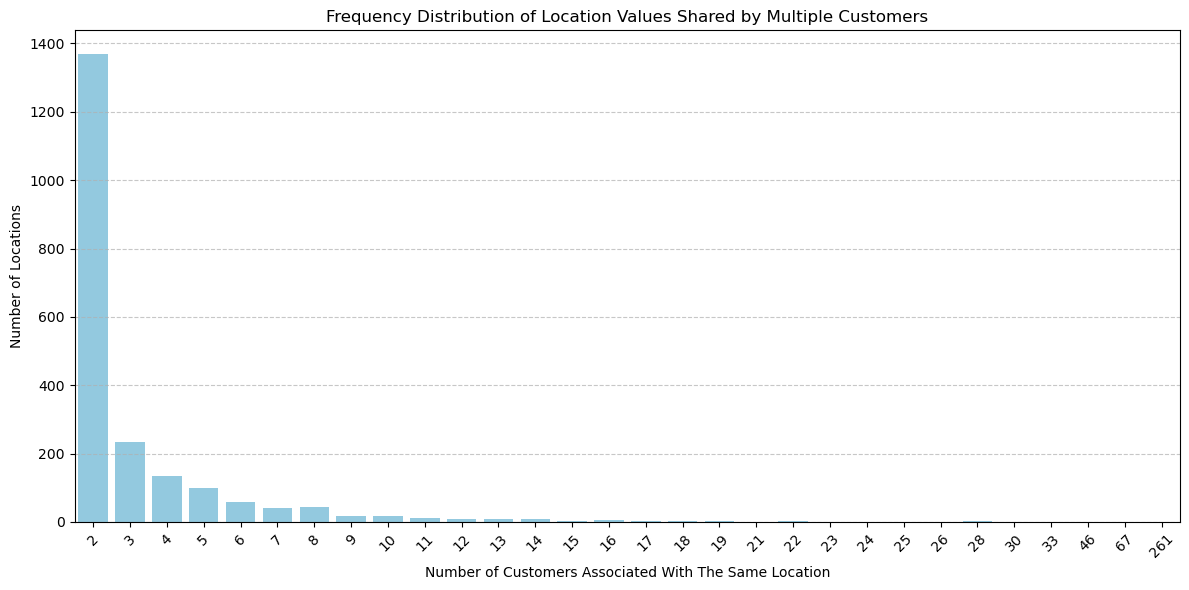

In [ ]:
# Create frequency distribution
frequency_dist = (
    locations_with_multiple_customers.group_by("number_of_customers")
    .agg(pl.len().alias(name="frequency"))
    .sort(by="number_of_customers")
)
# Convert to pandas for plotting
frequency_dist_pd = frequency_dist.to_pandas()

# Plot with Seaborn (Matplotlib requires more setup for this categorical axis plot)
plt.figure(figsize=(12, 6))
sns.barplot(
    data=frequency_dist_pd, x="number_of_customers", y="frequency", color="skyblue"
)
plt.xlabel(xlabel="Number of Customers Associated With The Same Location")
plt.ylabel(ylabel="Number of Locations")
plt.title(label="Frequency Distribution of Location Values Shared by Multiple Customers")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

The above shows us that for the majority of cases where multiple customers are associated with the same location, it is still a small number. Majority being 2 customers, and lmost all being captured by 10 or less customers 

In [ ]:
# Check the cities associated with these locations that are associated with multiple customers
print("\n" + "-" * 120)
print("Total Location and Customers Count for locations that have more than 2 customers in 'customers_table_pldf':\n" + "-" * 120)
city_summary = (
    customers_table_pldf
    .join(
        locations_with_multiple_customers.select("location").unique(),
        on="location",
        how="semi",          # keep only matching rows; no extra columns
    )
    .group_by(["city", "location"])
    .agg(
        pl.count("id").alias("customer_count"),
        pl.col("id").alias("customer_ids")
    )
    .group_by("city")
    .agg(
        pl.count("location").alias("location_count"),
        pl.sum("customer_count").alias("total_customers"),
    )
    .sort(by="city")
)
print(city_summary)


------------------------------------------------------------------------------------------------------------------------
Total Location and Customers Count for locations that have more than 2 customers in 'customers_table_pldf':
------------------------------------------------------------------------------------------------------------------------
shape: (2, 3)
┌────────┬────────────────┬─────────────────┐
│ city   ┆ location_count ┆ total_customers │
│ ---    ┆ ---            ┆ ---             │
│ str    ┆ u32            ┆ u32             │
╞════════╪════════════════╪═════════════════╡
│ delhi  ┆ 1380           ┆ 5391            │
│ mumbai ┆ 707            ┆ 1810            │
└────────┴────────────────┴─────────────────┘


In [ ]:
# Now we'll look at the distribution of customers per location for all locations (even those with a 1:1 ratio of customers to locations) for comparison

frequency_dist_all_locations = (
    customers_table_pldf.group_by("location")
    .agg(pl.col(name="id").n_unique().alias(name="number_of_customers"))
    .sort(by="number_of_customers", descending=True)
)
# Now we'll create a frequency distribution of the number of customers per location
frequency_dist_all_locations_count = (
    frequency_dist_all_locations.group_by("number_of_customers")
    .agg(pl.len().alias(name="frequency"))
    .sort(by="number_of_customers")
)

print("\n" + "-" * 120)
print(f"Locations with only 1 customer: {frequency_dist_all_locations_count.filter(pl.col(name='number_of_customers') == 1)['frequency'].item():,}\t ({(frequency_dist_all_locations_count.filter(pl.col(name='number_of_customers') == 1)['frequency'].item()) / (customers_table_pldf.height) * 100:.2f}% of all rows, {(frequency_dist_all_locations_count.filter(pl.col(name='number_of_customers') == 1)['frequency'].item()) / (unique_locations.item()) * 100:.2f}% of unique locations)")
print(f"Locations with 5 or fewer customers: {frequency_dist_all_locations_count.filter(pl.col(name='number_of_customers') <= 5)['frequency'].sum():,}\t ({(frequency_dist_all_locations_count.filter(pl.col(name='number_of_customers') <= 5)['frequency'].sum()) / (customers_table_pldf.height) * 100:.2f}% of all rows, {(frequency_dist_all_locations_count.filter(pl.col(name='number_of_customers') <= 5)['frequency'].sum()) / (unique_locations.item()) * 100:.2f}% of unique locations)")
print(f"Locations with 10 or fewer customers: {frequency_dist_all_locations_count.filter(pl.col(name='number_of_customers') <= 10)['frequency'].sum():,}\t ({(frequency_dist_all_locations_count.filter(pl.col(name='number_of_customers') <= 10)['frequency'].sum()) / (customers_table_pldf.height) * 100:.2f}% of all rows, {(frequency_dist_all_locations_count.filter(pl.col(name='number_of_customers') <= 10)['frequency'].sum()) / (unique_locations.item()) * 100:.2f}% of unique locations)")

print("\n" + "-" * 120)
print("Frequency Distribution of Customers per Location in 'customers_table_pldf' (full):\n" + "-" * 120)
print(f"\tCustomers per Location\tNumber of Locations")
for row in frequency_dist_all_locations_count.to_dicts():
    print(f"\t{row['number_of_customers']}\t\t\t{row['frequency']:,}")


------------------------------------------------------------------------------------------------------------------------
Locations with only 1 customer: 218,482	 (96.81% of all rows, 99.05% of unique locations)
Locations with 5 or fewer customers: 220,321	 (97.62% of all rows, 99.89% of unique locations)
Locations with 10 or fewer customers: 220,501	 (97.70% of all rows, 99.97% of unique locations)

------------------------------------------------------------------------------------------------------------------------
Frequency Distribution of Customers per Location in 'customers_table_pldf' (full):
------------------------------------------------------------------------------------------------------------------------
	Customers per Location	Number of Locations
	1			218,482
	2			1,370
	3			234
	4			136
	5			99
	6			59
	7			41
	8			43
	9			18
	10			19
	11			13
	12			10
	13			8
	14			8
	15			4
	16			5
	17			2
	18			2
	19			2
	21			1
	22			2
	23			1
	24			1
	25			1
	26			1
	28			2
	30			

##### Value Structures and Attributes

In [ ]:
display(customers_table_pldf.head(2))

shape: (2, 3)
┌──────────────┬─────────────────────────────────┬────────┐
│ id           ┆ location                        ┆ city   │
│ ---          ┆ ---                             ┆ ---    │
│ str          ┆ str                             ┆ str    │
╞══════════════╪═════════════════════════════════╪════════╡
│ 900000031184 ┆ 0101000020E6100000D034387CD834… ┆ mumbai │
│ 900000031173 ┆ 0101000020E6100000A6E7E5C9D834… ┆ mumbai │
└──────────────┴─────────────────────────────────┴────────┘

###### 'id' column

In [ ]:
# ID column
id_lengths = customers_table_pldf.select(pl.col(name="id").str.len_bytes().alias(name="id_length")).to_series()

print("\n" + "-" * 120)
print(f"Count of 'id' values by length in 'customers_table_pldf':\n" + "-" * 120)
print(id_lengths.value_counts().sort(by="id_length"))


------------------------------------------------------------------------------------------------------------------------
Count of 'id' values by length in 'customers_table_pldf':
------------------------------------------------------------------------------------------------------------------------
shape: (3, 2)
┌───────────┬────────┐
│ id_length ┆ count  │
│ ---       ┆ ---    │
│ u32       ┆ u32    │
╞═══════════╪════════╡
│ 0         ┆ 1      │
│ 11        ┆ 188315 │
│ 12        ┆ 37367  │
└───────────┴────────┘


We can see that there are few different lengths of values for the 'id' column. This could potentially prove problematic, so we'll keep an eye on it for later.

The lengths of 11 and 12 seem reasonable enough, and likely corresponds to the two different cities.
The the count of ids per city for delhi is the exact same as length 11 shown above, and the count for mumbai is only one more (37368) than the count shown above for length 12. It is likely that there is some sort of error with the value that has length of 0 and this value corresponds to a customer in mumbai.

In [ ]:
# Quick look at the row with shortest ID (length 0)
shortest_id_row = customers_table_pldf.filter(pl.col(name="id").str.len_bytes() == 0)
print("\nRow with shortest ID (length 1):\n" + "-" * 120)
display(shortest_id_row)


Row with shortest ID (length 1):
------------------------------------------------------------------------------------------------------------------------


shape: (1, 3)
┌─────┬─────────────────────────────────┬────────┐
│ id  ┆ location                        ┆ city   │
│ --- ┆ ---                             ┆ ---    │
│ str ┆ str                             ┆ str    │
╞═════╪═════════════════════════════════╪════════╡
│     ┆ 0101000020E61000005F3DD5BE0C35… ┆ mumbai │
└─────┴─────────────────────────────────┴────────┘

We can see that this row does appear to have a valid location associated with it, so this will be something to monitor going forward.

It should theoretically not cause problems so long as no blank values exist for customer_id in the meter_readings table

In [ ]:
# Location column of row with blank id
print("\nLocation of row with blank ID:\n" + "-" * 120)
print(shortest_id_row.select(pl.col(name="location")).to_series().item())

# All ids associated with this location
print("\nAll IDs associated with this location:\n" + "-" * 120)
ids_for_location = customers_table_pldf.filter(pl.col(name="location") == shortest_id_row.select(pl.col(name="location")).to_series().item())
print(ids_for_location.select(pl.col(name="id")).to_series().to_list())


Location of row with blank ID:
------------------------------------------------------------------------------------------------------------------------
0101000020E61000005F3DD5BE0C3552405EF457C0EB1B3340

All IDs associated with this location:
------------------------------------------------------------------------------------------------------------------------
['900000309136', '']


In [ ]:
# length of the id field
print("\n" + "-" * 120)
print(f"Length of the 'location' field in 'customers_table_pldf': {customers_table_pldf.select(pl.col(name='location').str.len_chars())} characters")
print(f"Minimum length of the 'location' field in 'customers_table_pldf': {customers_table_pldf.select(pl.col(name='location').str.len_chars().min())} characters")
print(f"Maximum length of the 'location' field in 'customers_table_pldf': {customers_table_pldf.select(pl.col(name='location').str.len_chars().max())} characters")


------------------------------------------------------------------------------------------------------------------------
Length of the 'location' field in 'customers_table_pldf': shape: (225_683, 1)
┌──────────┐
│ location │
│ ---      │
│ u32      │
╞══════════╡
│ 50       │
│ 50       │
│ 50       │
│ 50       │
│ 50       │
│ …        │
│ 50       │
│ 50       │
│ 50       │
│ 50       │
│ 50       │
└──────────┘ characters
Minimum length of the 'location' field in 'customers_table_pldf': shape: (1, 1)
┌──────────┐
│ location │
│ ---      │
│ u32      │
╞══════════╡
│ 50       │
└──────────┘ characters
Maximum length of the 'location' field in 'customers_table_pldf': shape: (1, 1)
┌──────────┐
│ location │
│ ---      │
│ u32      │
╞══════════╡
│ 50       │
└──────────┘ characters


This shows us that for this location, there is both a blank id and a valid id associated with it.
We can likely drop the row with a blank id, but cannot drop the whole location as it is associated with a valid id.

In [ ]:
# Now we'll look at the prefixes of the 'id' values in the customers table
# First 7,5,4,3 characters of 'id' values
chars_list = [7, 5, 4, 3]
print("\n" + "-" * 120)
print("Prefixes of 'id' values in 'customers_table_pldf':\n" + "-" * 120)

for chars in chars_list:
    id_prefix = (
        customers_table_pldf.select(pl.col(name="id").str.slice(offset=0, length=chars).alias(name="id_prefix"))
        .group_by("id_prefix")
        .agg(pl.len().alias(name="frequency"))
    )
    print(f"The first {chars} characters of 'id' reduces to {id_prefix.height:,} unique prefixes:")
    print(id_prefix)
    print("\n")


------------------------------------------------------------------------------------------------------------------------
Prefixes of 'id' values in 'customers_table_pldf':
------------------------------------------------------------------------------------------------------------------------
The first 7 characters of 'id' reduces to 2,978 unique prefixes:
shape: (2_978, 2)
┌───────────┬───────────┐
│ id_prefix ┆ frequency │
│ ---       ┆ ---       │
│ str       ┆ u32       │
╞═══════════╪═══════════╡
│ 6000313   ┆ 54        │
│ 6000879   ┆ 58        │
│ 6001855   ┆ 53        │
│ 6001761   ┆ 32        │
│ 6001522   ┆ 36        │
│ …         ┆ …         │
│ 6000484   ┆ 64        │
│ 6001264   ┆ 64        │
│ 6000446   ┆ 59        │
│ 6002869   ┆ 76        │
│ 6002156   ┆ 59        │
└───────────┴───────────┘


The first 5 characters of 'id' reduces to 32 unique prefixes:
shape: (32, 2)
┌───────────┬───────────┐
│ id_prefix ┆ frequency │
│ ---       ┆ ---       │
│ str       ┆ u32       

Looks like we're able to get to a unique prefix with the first 3-4 characters. Let's take a further look at these values

In [ ]:
reduced_chars = [4,3]

print("\n" + "-" * 120)
print("Prefixes and Frequency of 'id' values in 'customers_table_pldf':\n" + "-" * 120)
for char in reduced_chars:
    id_first_n_chars = (
        customers_table_pldf.select(pl.col(name="id").str.slice(offset=0, length=char).alias(name="id_prefix"))
        .group_by("id_prefix")
        .agg(pl.len().alias(name="frequency")).sort(by="frequency", descending=True)
    )
    print(f"\nFirst {char} characters:")
    print(id_first_n_chars)


------------------------------------------------------------------------------------------------------------------------
Prefixes and Frequency of 'id' values in 'customers_table_pldf':
------------------------------------------------------------------------------------------------------------------------

First 4 characters:
shape: (5, 2)
┌───────────┬───────────┐
│ id_prefix ┆ frequency │
│ ---       ┆ ---       │
│ str       ┆ u32       │
╞═══════════╪═══════════╡
│ 6002      ┆ 81489     │
│ 6000      ┆ 56769     │
│ 6001      ┆ 50057     │
│ 9000      ┆ 37367     │
│           ┆ 1         │
└───────────┴───────────┘

First 3 characters:
shape: (3, 2)
┌───────────┬───────────┐
│ id_prefix ┆ frequency │
│ ---       ┆ ---       │
│ str       ┆ u32       │
╞═══════════╪═══════════╡
│ 600       ┆ 188315    │
│ 900       ┆ 37367     │
│           ┆ 1         │
└───────────┴───────────┘


Of course we're seeing that empty value for id showing up again. But besides that it looks like we again have two groupings - one starting with 600 and the other starting with 900. As with the lengths counts before, we can probably safely assume that 900 is for mumbai and 600 is for delhi based on the value counts.

In [ ]:
## Checking the assumptions about length and prefixes of 'id' values in the customers table
# Check the city associated with all the prefixes of 'id' values in the customers table
print("\n" + "-" * 120)
print(f"City associated with prefixes of 'id' values in 'customers_table_pldf':\n"+ "-" * 120)
print(customers_table_pldf.select(pl.col(name="id").str.slice(offset=0, length=3).alias(name="id_prefix"), "city")
    .group_by("id_prefix")
    .agg(pl.col(name="city").unique().alias(name="cities"))
    .sort(by="id_prefix")
)

# Check the city associated with the length of the 'id' values in the customers table
print("\n" + "-" * 120)
print(f"City associated with length of 'id' values in 'customers_table_pldf':\n"+ "-" * 120)
print(customers_table_pldf.select(pl.col(name="id").str.len_bytes().alias(name="id_length"), "city")
    .group_by("id_length")
    .agg(pl.col(name="city").unique().alias(name="cities"))
    .sort(by="id_length")
)


------------------------------------------------------------------------------------------------------------------------
City associated with prefixes of 'id' values in 'customers_table_pldf':
------------------------------------------------------------------------------------------------------------------------
shape: (3, 2)
┌───────────┬────────────┐
│ id_prefix ┆ cities     │
│ ---       ┆ ---        │
│ str       ┆ list[str]  │
╞═══════════╪════════════╡
│           ┆ ["mumbai"] │
│ 600       ┆ ["delhi"]  │
│ 900       ┆ ["mumbai"] │
└───────────┴────────────┘

------------------------------------------------------------------------------------------------------------------------
City associated with length of 'id' values in 'customers_table_pldf':
------------------------------------------------------------------------------------------------------------------------
shape: (3, 2)
┌───────────┬────────────┐
│ id_length ┆ cities     │
│ ---       ┆ ---        │
│ u32       ┆ list[s

###### 'location' column

In [ ]:
# location column
location_lengths = customers_table_pldf.select(
    pl.col(name="location").str.len_bytes().alias(name="location_length")
).to_series()

print("\n" + "-" * 120)
print(f"Count of 'location' values by length in 'customers_table_pldf':\n" + "-" * 120)
print(location_lengths.value_counts().sort(by="location_length"))


------------------------------------------------------------------------------------------------------------------------
Count of 'location' values by length in 'customers_table_pldf':
------------------------------------------------------------------------------------------------------------------------
shape: (1, 2)
┌─────────────────┬────────┐
│ location_length ┆ count  │
│ ---             ┆ ---    │
│ u32             ┆ u32    │
╞═════════════════╪════════╡
│ 50              ┆ 225683 │
└─────────────────┴────────┘


In [ ]:
# Now we'll look at the prefixes of the 'location' values in the customers table
# First 30, 25, 20, 15, 10, 5, 4, 3 characters of 'location' values

location_chars_list = [30, 25, 20, 15, 10, 5, 4, 3]
print("\n" + "-" * 120)
print("Prefixes and Frequency of 'location' values in 'customers_table_pldf':\n" + "-" * 120)
for chars in location_chars_list:
    loc_prefix = (
        customers_table_pldf.select(pl.col("location").str.slice(offset=0, length=chars).alias("location_prefix"))
        .group_by("location_prefix")
        .agg(pl.len().alias("frequency"))
    )
    print(f"\nThe first {chars} characters of 'location' reduces to {loc_prefix.height:,} unique prefix(es):")
    print(loc_prefix)


------------------------------------------------------------------------------------------------------------------------
Prefixes and Frequency of 'location' values in 'customers_table_pldf':
------------------------------------------------------------------------------------------------------------------------

The first 30 characters of 'location' reduces to 219,064 unique prefix(es):
shape: (219_064, 2)
┌────────────────────────────────┬───────────┐
│ location_prefix                ┆ frequency │
│ ---                            ┆ ---       │
│ str                            ┆ u32       │
╞════════════════════════════════╪═══════════╡
│ 0101000020E6100000837FF8960549 ┆ 1         │
│ 0101000020E610000063E36ECE1047 ┆ 1         │
│ 0101000020E6100000C5B9D961444C ┆ 1         │
│ 0101000020E6100000E873C5F70B4E ┆ 1         │
│ 0101000020E610000081D09B06DC35 ┆ 1         │
│ …                              ┆ …         │
│ 0101000020E610000023580BA22436 ┆ 2         │
│ 0101000020E610000064AC9

Okay, so it looks as though we get unique values somewhere between 15 and 20 - let's narrow that down a bit.

In [ ]:
# Now we'll look at the prefixes of the 'location' values in the customers table
# First 19, 18, 17, 16 characters of 'location' values

reduced_location_chars_list = [19, 18, 17, 16]
print("\n" + "-" * 120)
print("Prefixes and Frequency of 'location' values in 'customers_table_pldf':\n" + "-" * 120)

for char in reduced_location_chars_list:
    loc_prefix = (
        customers_table_pldf.select(pl.col(name="location").str.slice(0, char).alias("location_prefix"))
        .group_by("location_prefix")
        .agg(pl.len().alias(name="frequency")).sort(by="frequency", descending=True)
    )
    print(f"\nFirst {char} characters:")
    print(loc_prefix)



------------------------------------------------------------------------------------------------------------------------
Prefixes and Frequency of 'location' values in 'customers_table_pldf':
------------------------------------------------------------------------------------------------------------------------

First 19 characters:
shape: (16, 2)
┌─────────────────────┬───────────┐
│ location_prefix     ┆ frequency │
│ ---                 ┆ ---       │
│ str                 ┆ u32       │
╞═════════════════════╪═══════════╡
│ 0101000020E61000000 ┆ 14451     │
│ 0101000020E61000001 ┆ 14351     │
│ 0101000020E6100000B ┆ 14183     │
│ 0101000020E61000003 ┆ 14178     │
│ 0101000020E61000005 ┆ 14151     │
│ …                   ┆ …         │
│ 0101000020E61000007 ┆ 14006     │
│ 0101000020E61000004 ┆ 13987     │
│ 0101000020E6100000D ┆ 13985     │
│ 0101000020E6100000F ┆ 13909     │
│ 0101000020E6100000C ┆ 13905     │
└─────────────────────┴───────────┘

First 18 characters:
shape: (1, 2)
┌

Based on the above results, the first 18 characters of the location column are all the same for both of the cities.

In [ ]:
# Look at the first 19 characters of the location values in the customers table by city just to see how the values start to differ
print("\n" + "-" * 120)
print(
    f"City associated with prefixes of 'location' values in 'customers_table_pldf':\n"
    + "-" * 120
)
print(
    customers_table_pldf.select(
        pl.col("location").str.slice(0, 19).alias("location_prefix"), "city"
    )
    .group_by("location_prefix")
    .agg(pl.col("city").unique().alias("cities"))
    .sort("location_prefix")
)


------------------------------------------------------------------------------------------------------------------------
City associated with prefixes of 'location' values in 'customers_table_pldf':
------------------------------------------------------------------------------------------------------------------------
shape: (16, 2)
┌─────────────────────┬─────────────────────┐
│ location_prefix     ┆ cities              │
│ ---                 ┆ ---                 │
│ str                 ┆ list[str]           │
╞═════════════════════╪═════════════════════╡
│ 0101000020E61000000 ┆ ["mumbai", "delhi"] │
│ 0101000020E61000001 ┆ ["mumbai", "delhi"] │
│ 0101000020E61000002 ┆ ["mumbai", "delhi"] │
│ 0101000020E61000003 ┆ ["mumbai", "delhi"] │
│ 0101000020E61000004 ┆ ["mumbai", "delhi"] │
│ …                   ┆ …                   │
│ 0101000020E6100000B ┆ ["delhi", "mumbai"] │
│ 0101000020E6100000C ┆ ["delhi", "mumbai"] │
│ 0101000020E6100000D ┆ ["mumbai", "delhi"] │
│ 0101000020E6100000

The location column appears to be in WKB format, which is a binary representation of geometry data.

https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry

https://libgeos.org/specifications/wkb/

To make it useful for our analysis, we will need to convert it to a more usable format. Let's try to convert it to coordinates (longitude, latitude).

In [ ]:
# converting WKB to coordinates
customers_table_pldf = customers_table_pldf.with_columns(
    pl.col("location").map_elements(wkb_to_coords, return_dtype=pl.List(pl.Float64)).alias("coordinates")
)


In [ ]:
display(customers_table_pldf.head(5))

shape: (5, 4)
┌──────────────┬─────────────────────────────────┬────────┬────────────────────────┐
│ id           ┆ location                        ┆ city   ┆ coordinates            │
│ ---          ┆ ---                             ┆ ---    ┆ ---                    │
│ str          ┆ str                             ┆ str    ┆ list[f64]              │
╞══════════════╪═════════════════════════════════╪════════╪════════════════════════╡
│ 900000031184 ┆ 0101000020E6100000D034387CD834… ┆ mumbai ┆ [72.825713, 18.979316] │
│ 900000031173 ┆ 0101000020E6100000A6E7E5C9D834… ┆ mumbai ┆ [72.825732, 18.979353] │
│ 900000084889 ┆ 0101000020E61000007B423C337D36… ┆ mumbai ┆ [72.851392, 19.011059] │
│ 900001013992 ┆ 0101000020E6100000559354647C36… ┆ mumbai ┆ [72.851342, 19.011017] │
│ 900000084824 ┆ 0101000020E61000005EDCE3D87C36… ┆ mumbai ┆ [72.85137, 19.011072]  │
└──────────────┴─────────────────────────────────┴────────┴────────────────────────┘

##### Mapping the Locations

In [ ]:
mumbai_customers_table_pldf = customers_table_pldf.filter(pl.col("city") == "mumbai")
delhi_customers_table_pldf = customers_table_pldf.filter(pl.col("city") == "delhi")

###### Mumbai

In [ ]:
mumbai_map = folium.Map(location=[19.10, 72.85], zoom_start=11)

# Add markers (swap lon/lat to lat/lon)
for row in mumbai_customers_table_pldf.iter_rows(named=True):
    lon, lat = row["coordinates"]  # Unpack assuming [lon, lat]
    folium.CircleMarker(
            location=[lat, lon],  # Folium uses [latitude, longitude]
            radius=1,            # Adjust circle size (pixels)
            popup=f"ID: {row['id']}",
            tooltip=row["id"],
            color="red",         # Border color
            fill=True,           # Fill the circle
            fill_color="red",    # Inner color
            fill_opacity=0.7,    # Transparency (0-1)
        ).add_to(mumbai_map)


In [ ]:
title_html = """
    <div style="
        position: fixed;
        top: 10px;
        left: 50%;
        transform: translateX(-50%);
        background: white;
        padding: 8px 15px;
        border: 1px solid grey;
        border-radius: 5px;
        font-family: Arial;
        font-size: 16px;
        font-weight: bold;
        z-index: 1000;
    ">
        Mumbai Customer Locations
    </div>
"""
mumbai_map.get_root().html.add_child(folium.Element(title_html))

In [ ]:
# Uncomment this line to display the map created
# mumbai_map

In [ ]:
# Saving as html file
mumbai_html_path = "images/mumbai_customers_folium_map.html"
mumbai_map.save(mumbai_html_path)

# Converting the HTML map to PNG using Selenium and ChromeDriver
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service)

abs_mumbai_html_path = f"file://{os.path.abspath(mumbai_html_path)}"
driver.get(abs_mumbai_html_path)
driver.maximize_window()  # Ensures full map visibility

# outputs_images_directory
mumbai_png_path = os.path.join(outputs_images_directory, "mumbai_customers_map.png")
driver.save_screenshot(mumbai_png_path)
driver.quit()


In [ ]:
# Deleting html file after conversion
if os.path.exists(mumbai_html_path):
    os.remove(mumbai_html_path)
    print(f"Deleted file {mumbai_html_path} successfully.")
else:
    print(f"File {mumbai_html_path} does not exist, so it cannot be deleted.")

Deleted file images/mumbai_customers_folium_map.html successfully.


In [ ]:
# Uncomment this line to open the saved PNG image
# Image.open(mumbai_png_path).show()

###### Delhi

In [ ]:
delhi_map = folium.Map(location=[28.75, 77.1], zoom_start=11.2)

# Add markers (swap lon/lat to lat/lon)
for row in delhi_customers_table_pldf.iter_rows(named=True):
    lon, lat = row["coordinates"]  # Unpack assuming [lon, lat]
    folium.CircleMarker(
            location=[lat, lon],  # Folium uses [latitude, longitude]
            radius=1,            # Adjust circle size (pixels)
            popup=f"ID: {row['id']}",
            tooltip=row["id"],
            color="red",         # Border color
            fill=True,           # Fill the circle
            fill_color="red",    # Inner color
            fill_opacity=0.5,    # Transparency (0-1)
        ).add_to(delhi_map)


In [ ]:
title_html = """
    <div style="
        position: fixed;
        top: 10px;
        left: 50%;
        transform: translateX(-50%);
        background: white;
        padding: 8px 15px;
        border: 1px solid grey;
        border-radius: 5px;
        font-family: Arial;
        font-size: 16px;
        font-weight: bold;
        z-index: 1000;
    ">
        Delhi Customer Locations
    </div>
"""
delhi_map.get_root().html.add_child(folium.Element(title_html))

In [ ]:
# Uncomment this line to display the map created
# delhi_map

In [ ]:
# Saving to HTML File
delhi_html_path = "images/delhi_customers_folium_map.html"
delhi_map.save(delhi_html_path)

# Converting the HTML map to PNG using Selenium and ChromeDriver
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service)

abs_delhi_html_path = f"file://{os.path.abspath(delhi_html_path)}"
driver.get(abs_delhi_html_path)
driver.maximize_window()  # Ensures full map visibility

# outputs_images_directory
delhi_png_path = os.path.join(outputs_images_directory, "delhi_customers_map.png")
driver.save_screenshot(delhi_png_path)
driver.quit()

In [ ]:
# Deleting html file after conversion
if os.path.exists(delhi_html_path):
    os.remove(delhi_html_path)
    print(f"Deleted file {delhi_html_path} successfully.")
else:
    print(f"File {delhi_html_path} does not exist, so it cannot be deleted.")

Deleted file images/delhi_customers_folium_map.html successfully.


In [ ]:
# Uncomment this line to open the saved PNG image
# Image.open(delhi_png_path).show()

#### **CUSTOMERS DATA SUMMARY:**

**Contains the following columns:**
* *id*: customer id (string)
* *location*: geographic location of the customer in WKB format (string)
* *city*: city of the customer (delhi or mumbai) (string)

**Data Summary:**
* 225,683 customers across two cities (Delhi and Mumbai)
* 2 unique cities: 'delhi' and 'mumbai'
* 220,569 unique geographic locations for those customers, so  a 97.73% uniqueness of id - location pairs
    * There are only 2,087 locations with more than 1 customer
    * The majority of locations that have more than 1 customer have only 2 customers.
    * Here are locations with more than 1 customers (desc).
        * 0101000020E6100000000000000000… ┆ 261
        * 0101000020E6100000AA13E9E1783A… ┆ 67
        * 0101000020E61000001F10E84CDA35… ┆ 46
        * 0101000020E61000005280C56D364C… ┆ 33
        * 0101000020E6100000D5345AD4084A… ┆ 30
* Delhi:
    * 188,315 customers (83.44%) of total customers
    * 184,304 locations (83.56%) of total locations
    * contains customer id's with length of 11 and prefixed with 600
    * customers are primarily located in the northwestern part of the city
* Mumbai:
    * 37,368 customers (16.56%) of total customers
    * 36,265 locations (16.44%) of total locations
    * contains customer id's with length of 12 and prefixed with 900
    * customers are spread relatively evenly across the city, with a slight concentration in the northern half of the city

* Location '0101000020E61000005F3DD5BE0C3552405EF457C0EB1B3340'
    * Has two ids associated with it:
        * 900000309136
        * ''
    * May need to drop the row with a blank id, but cannot drop the whole location as it is associated with a valid id.

* The location column appears to be in WKB format, which is a binary representation of geometry data.
    * This can be converted to coordinates (longitude, latitude) for further analysis.


### **Carbontracker.in Data from 'grid_readings' table**

#### Loading Data

In [58]:
# Defining filenames for grid readings data files
grid_readings_20250606_filename = "grid_readings_20250606_1901"
grid_readings_20250630_filename = "grid_readings_20250630_1215"
grid_readings_20250701_filename = "grid_readings_20250701_1318"
grid_readings_20250714_filename = "grid_readings_20250714_1401"

In [59]:
# Defining filepaths
grid_readings_20250606_filepath = os.path.join(hitachi_data_directory, f"{grid_readings_20250606_filename}.parquet")
grid_readings_20250630_filepath = os.path.join(hitachi_data_directory, f"{grid_readings_20250630_filename}.parquet")
grid_readings_20250701_filepath = os.path.join(hitachi_data_directory, f"{grid_readings_20250701_filename}.parquet")
grid_readings_20250714_filepath = os.path.join(hitachi_data_directory, f"{grid_readings_20250714_filename}.parquet")

In [61]:
# Loading DataFrames from the grid readings files
# grid_readings_20250606_pldf = pl.read_parquet(source=grid_readings_20250606_filepath)
# grid_readings_20250630_pldf = pl.read_parquet(source=grid_readings_20250630_filepath)
# grid_readings_20250701_pldf = pl.read_parquet(source=grid_readings_20250701_filepath)
grid_readings_20250714_pldf = pl.read_parquet(source=grid_readings_20250714_filepath)

In [ ]:
print("Columns in grid_readings_20250714_filepath DataFrame:")
print(grid_readings_20250606_pldf.columns)

Columns in grid_readings_20250714_filepath DataFrame:
['timestamp', 'thermal_generation', 'gas_generation', 'g_co2_per_kwh', 'hydro_generation', 'nuclear_generation', 'renewable_generation', 'tons_co2', 'total_generation', 'tons_co2_per_mwh', 'demand_met', 'net_demand']


In [ ]:
df_grid_66_v_df_grid_630 = compare_dataframes(df1=grid_readings_20250606_pldf, df2=grid_readings_20250630_pldf, sort_by=["timestamp"])
print("\nComparison between grid_readings_20250606_pldf and grid_readings_20250630_pldf:")
print(df_grid_66_v_df_grid_630)
df_grid_66_v_df_grid_701 = compare_dataframes(df1=grid_readings_20250606_pldf, df2=grid_readings_20250701_pldf, sort_by=["timestamp"])
print("\nComparison between grid_readings_20250606_pldf and grid_readings_20250701_pldf:")
print(df_grid_66_v_df_grid_701)
df_grid_66_v_df_grid_714 = compare_dataframes(df1=grid_readings_20250606_pldf, df2=grid_readings_20250714_pldf, sort_by=["timestamp"])
print("\nComparison between grid_readings_20250606_pldf and grid_readings_20250714_pldf:")
print(df_grid_66_v_df_grid_714)
df_grid_630_v_df_grid_701 = compare_dataframes(df1=grid_readings_20250630_pldf, df2=grid_readings_20250701_pldf, sort_by=["timestamp"])
print("\nComparison between grid_readings_20250630_pldf and grid_readings_20250701_pldf:")
print(df_grid_630_v_df_grid_701)
df_grid_630_v_df_grid_714 = compare_dataframes(df1=grid_readings_20250630_pldf, df2=grid_readings_20250714_pldf, sort_by=["timestamp"])
print("\nComparison between grid_readings_20250630_pldf and grid_readings_20250714_pldf:")
print(df_grid_630_v_df_grid_714)
df_grid_701_v_df_grid_714 = compare_dataframes(df1=grid_readings_20250701_pldf, df2=grid_readings_20250714_pldf, sort_by=["timestamp"])
print("\nComparison between grid_readings_20250701_pldf and grid_readings_20250714_pldf:")
print(df_grid_701_v_df_grid_714)



Comparison between grid_readings_20250606_pldf and grid_readings_20250630_pldf:

df1 and df2 are identical.

Comparison between grid_readings_20250606_pldf and grid_readings_20250701_pldf:

df1 and df2 are identical.

Comparison between grid_readings_20250606_pldf and grid_readings_20250714_pldf:

df1 and df2 have different shapes: (46020, 12) vs (561067, 12)

Comparison between grid_readings_20250630_pldf and grid_readings_20250701_pldf:

df1 and df2 are identical.

Comparison between grid_readings_20250630_pldf and grid_readings_20250714_pldf:

df1 and df2 have different shapes: (46020, 12) vs (561067, 12)

Comparison between grid_readings_20250701_pldf and grid_readings_20250714_pldf:

df1 and df2 have different shapes: (46020, 12) vs (561067, 12)


Looks like the data is mostly consistent, but the most recent file (grid_readings_20250714_pldf) has some additional rows that the others do not have.

This is likely because additional data from a broader timescale was added, but lets take a look at the differences anyway to confirm

In [62]:
# Time range of the data in grid_readings_20250701_pldf
print("\n" + "-" * 120)
print(f"Temporal Range of Grid Readings Datasets:\n" + "-" * 120)

print(f"[grid_readings_20250701_pldf] Start: {grid_readings_20250701_pldf['timestamp'].min()}, End: {grid_readings_20250701_pldf['timestamp'].max()}")

# Time range of the data in grid_readings_20250714_pldf
print(f"[grid_readings_20250714_pldf] Start: {grid_readings_20250714_pldf['timestamp'].min()}, End: {grid_readings_20250714_pldf['timestamp'].max()}")


------------------------------------------------------------------------------------------------------------------------
Temporal Range of Grid Readings Datasets:
------------------------------------------------------------------------------------------------------------------------


NameError: name 'grid_readings_20250701_pldf' is not defined

The above confirms that the grid readings dataset includes information from 2020 and 2021, as well as from mid 2023 to mid 2025 that previous versions did not have.

#### grid_readings_20250714

In [63]:
grid_readings_20250714_pldf = pl.read_parquet(source=grid_readings_20250714_filepath)

# Selecting the most recent dataset for further analysis
grid_readings_table_pldf = grid_readings_20250714_pldf  # Use the most recent dataset

# Display the shape of the grid_readings table
print(f"The shape of 'grid_readings_table_pldf' is {grid_readings_table_pldf.shape}")

# Display the first 5 rows of the grid_readings table
print(f"\nLooking at the first few rows of the 'grid_readings_table_pldf':")
display(grid_readings_table_pldf.head(n=5))

# Display the summary statistics of the grid_readings table
print(f"\n Summary statistics of the 'grid_readings_table_pldf':")
grid_readings_table_pldf.describe()

The shape of 'grid_readings_table_pldf' is (561067, 12)

Looking at the first few rows of the 'grid_readings_table_pldf':


shape: (5, 12)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ timestamp ┆ thermal_g ┆ gas_gener ┆ g_co2_per ┆ … ┆ total_gen ┆ tons_co2_ ┆ demand_me ┆ net_dema │
│ ---       ┆ eneration ┆ ation     ┆ _kwh      ┆   ┆ eration   ┆ per_mwh   ┆ t         ┆ nd       │
│ datetime[ ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ μs]       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2022-01-0 ┆ 136202.0  ┆ 2901.0    ┆ 815.57308 ┆ … ┆ 164327.0  ┆ 0.815573  ┆ 162948.0  ┆ 154427.0 │
│ 4         ┆           ┆           ┆ 8         ┆   ┆           ┆           ┆           ┆          │
│ 17:05:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2022-01-0 ┆ 136202.0  ┆ 2901.0    ┆ 815.57308 ┆ … ┆ 164327.0  ┆ 0.815573  ┆ 162948.0  ┆ 154427.0 │
│ 4         ┆           ┆           ┆ 8         ┆   ┆           ┆           ┆           ┆          │
│ 17:10:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2022-01-0 ┆ 136202.0  ┆ 2901.0    ┆ 815.57308 ┆ … ┆ 164327.0  ┆ 0.815573  ┆ 162948.0  ┆ 154427.0 │
│ 4         ┆           ┆           ┆ 8         ┆   ┆           ┆           ┆           ┆          │
│ 17:15:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2022-01-0 ┆ 136202.0  ┆ 2901.0    ┆ 815.57308 ┆ … ┆ 164327.0  ┆ 0.815573  ┆ 162948.0  ┆ 154427.0 │
│ 4         ┆           ┆           ┆ 8         ┆   ┆           ┆           ┆           ┆          │
│ 17:20:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2022-01-0 ┆ 136202.0  ┆ 2901.0    ┆ 815.57308 ┆ … ┆ 164327.0  ┆ 0.815573  ┆ 162948.0  ┆ 154427.0 │
│ 4         ┆           ┆           ┆ 8         ┆   ┆           ┆           ┆           ┆          │
│ 17:25:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘


 Summary statistics of the 'grid_readings_table_pldf':


shape: (9, 13)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ timestamp ┆ thermal_g ┆ gas_gener ┆ … ┆ total_gen ┆ tons_co2_ ┆ demand_me ┆ net_dema │
│ ---       ┆ ---       ┆ eneration ┆ ation     ┆   ┆ eration   ┆ per_mwh   ┆ t         ┆ nd       │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 561067    ┆ 561067.0  ┆ 561067.0  ┆ … ┆ 561067.0  ┆ 561067.0  ┆ 561067.0  ┆ 561067.0 │
│ null_coun ┆ 0         ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ mean      ┆ 2022-09-1 ┆ 127192.15 ┆ 3888.0864 ┆ … ┆ 171933.94 ┆ 0.734163  ┆ 170732.29 ┆ 153985.5 │
│           ┆ 2 15:50:4 ┆ 4768      ┆ 09        ┆   ┆ 0173      ┆           ┆ 1455      ┆ 60859    │
│           ┆ 3.006628  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ std       ┆ null      ┆ 20960.644 ┆ 1626.0923 ┆ … ┆ 26456.112 ┆ 0.076569  ┆ 26158.803 ┆ 22143.97 │
│           ┆           ┆ 587       ┆ 21        ┆   ┆ 552       ┆           ┆ 872       ┆ 0194     │
│ min       ┆ 2020-01-0 ┆ 65919.0   ┆ 0.0       ┆ … ┆ 88658.0   ┆ 0.473856  ┆ 87972.0   ┆ 86367.0  │
│           ┆ 1         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 00:00:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 25%       ┆ 2021-05-0 ┆ 111703.5  ┆ 2563.5    ┆ … ┆ 153264.0  ┆ 0.681198  ┆ 152233.5  ┆ 138341.0 │
│           ┆ 2         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 17:15:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 50%       ┆ 2022-09-1 ┆ 128416.0  ┆ 3465.0    ┆ … ┆ 172266.5  ┆ 0.734538  ┆ 170895.0  ┆ 153908.0 │
│           ┆ 7         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 05:50:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 75%       ┆ 2024-01-2 ┆ 143172.5  ┆ 4938.0    ┆ … ┆ 192469.0  ┆ 0.79742   ┆ 190909.5  ┆ 169378.5 │
│           ┆ 1         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 10:35:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ max       ┆ 2025-06-0 ┆ 179602.0  ┆ 13125.0   ┆ … ┆ 258643.0  ┆ 0.899116  ┆ 256491.0  ┆ 225340.0 │
│           ┆ 3         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 23:55:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

There are no null values - which is great news
We have readings every 5 minutes starting from 2020 and ending in June of 2025.

There is no need for location information because this table covers all of India's grid.

In [64]:
grid_readings_table_pldf.schema

Schema([('timestamp', Datetime(time_unit='us', time_zone=None)),
        ('thermal_generation', Float64),
        ('gas_generation', Float64),
        ('g_co2_per_kwh', Float64),
        ('hydro_generation', Float64),
        ('nuclear_generation', Float64),
        ('renewable_generation', Float64),
        ('tons_co2', Float64),
        ('total_generation', Float64),
        ('tons_co2_per_mwh', Float64),
        ('demand_met', Float64),
        ('net_demand', Float64)])

The data is also already in good format for analysis (Datetime for timestamp and higher precision floats for analysis.)


##### Missing Data Checks

We'll now check for completeness.

The dataset we have has 561,067 rows. Is this the number of rows that we would expect to see given the start,end, and frequency of the dataset? Let's check.

In [65]:
# The dataset we have has 561,067 rows
data_start_date = datetime(2020, 1,1,0,0)
data_end_date = datetime(2025,6,30,23,55)
data_frequency = timedelta(minutes=5)

grid_readings_full_time_grid = pl.DataFrame({
    "timestamp": pl.datetime_range(
        start=data_start_date, end=data_end_date,
        interval=data_frequency,  # or "5m"
        closed="both", eager=True, time_unit="us"
    )
})

print(f"Count of rows in [grid_readings_table_pldf]:\t\t{grid_readings_table_pldf.shape[0]:,}")
print(f"Count of rows in [grid_readings_full_time_grid]:\t{grid_readings_full_time_grid.shape[0]:,}")
print(f"Number of missing observations:\t\t\t\t{grid_readings_full_time_grid.shape[0] - grid_readings_table_pldf.shape[0]:,}")
print(f"Percentage of rows in [grid_readings_table_pldf]that are present in [grid_readings_full_time_grid]:   {grid_readings_table_pldf.shape[0] / full_grid.shape[0] * 100:.2f}%")

Count of rows in [grid_readings_table_pldf]:		561,067
Count of rows in [grid_readings_full_time_grid]:	578,304
Number of missing observations:				17,237


NameError: name 'full_grid' is not defined

Unfortunately it looks like we are missing some data. This may cause issues later with our analysis, so we will likely have to gap fill. Lets get a slightly better idea of what this missing data looks like and where it is.

In [ ]:
missing_grid_time_data = (grid_readings_full_time_grid.join(other=grid_readings_table_pldf.select("timestamp").unique(),
                            on="timestamp",
                            how="anti"
                        ).sort("timestamp")
)
missing_grid_time_data

shape: (17_237, 1)
┌─────────────────────┐
│ timestamp           │
│ ---                 │
│ datetime[μs]        │
╞═════════════════════╡
│ 2020-01-03 22:30:00 │
│ 2020-01-03 22:35:00 │
│ 2020-01-03 22:40:00 │
│ 2020-01-24 00:10:00 │
│ 2020-01-24 00:15:00 │
│ …                   │
│ 2025-06-30 23:35:00 │
│ 2025-06-30 23:40:00 │
│ 2025-06-30 23:45:00 │
│ 2025-06-30 23:50:00 │
│ 2025-06-30 23:55:00 │
└─────────────────────┘

In [ ]:
# We'll now get the time ranges of data that is missing
missing_grid_time_ranges = (
    missing_grid_time_data
    .with_columns(
        is_break = (pl.col("timestamp").diff() != timedelta(minutes=5)).fill_null(True)
    )
    .with_columns(
        block_id = pl.col("is_break").cum_sum()
    )
    .group_by("block_id")
    .agg([
        pl.col("timestamp").min().alias("missing_start"),
        pl.col("timestamp").max().alias("missing_end"),
        pl.len().alias("n_missing"),
    ])
    .drop("block_id")
    .sort("missing_start")
)

missing_grid_time_ranges.sample(5)

shape: (5, 3)
┌─────────────────────┬─────────────────────┬───────────┐
│ missing_start       ┆ missing_end         ┆ n_missing │
│ ---                 ┆ ---                 ┆ ---       │
│ datetime[μs]        ┆ datetime[μs]        ┆ u32       │
╞═════════════════════╪═════════════════════╪═══════════╡
│ 2023-08-02 16:40:00 ┆ 2023-08-02 18:55:00 ┆ 28        │
│ 2022-07-05 02:35:00 ┆ 2022-07-05 03:00:00 ┆ 6         │
│ 2020-04-23 12:40:00 ┆ 2020-04-23 12:40:00 ┆ 1         │
│ 2024-05-18 16:50:00 ┆ 2024-05-18 16:55:00 ┆ 2         │
│ 2023-01-19 17:05:00 ┆ 2023-01-19 17:10:00 ┆ 2         │
└─────────────────────┴─────────────────────┴───────────┘

In [ ]:
# We'll now add a few more features to help understand the distribution of these missing values.
missing_grid_time_ranges = missing_grid_time_ranges.with_columns(
    pl.col("missing_start").dt.year().alias("gap_start_year"),
    pl.col("missing_start").dt.month().alias("gap_start_month"),
)
missing_grid_time_ranges.sample(5)

shape: (5, 5)
┌─────────────────────┬─────────────────────┬───────────┬────────────────┬─────────────────┐
│ missing_start       ┆ missing_end         ┆ n_missing ┆ gap_start_year ┆ gap_start_month │
│ ---                 ┆ ---                 ┆ ---       ┆ ---            ┆ ---             │
│ datetime[μs]        ┆ datetime[μs]        ┆ u32       ┆ i32            ┆ i8              │
╞═════════════════════╪═════════════════════╪═══════════╪════════════════╪═════════════════╡
│ 2022-07-04 11:00:00 ┆ 2022-07-04 11:10:00 ┆ 3         ┆ 2022           ┆ 7               │
│ 2021-06-17 19:40:00 ┆ 2021-06-17 19:45:00 ┆ 2         ┆ 2021           ┆ 6               │
│ 2022-01-14 22:25:00 ┆ 2022-01-14 22:25:00 ┆ 1         ┆ 2022           ┆ 1               │
│ 2020-04-23 10:40:00 ┆ 2020-04-23 10:45:00 ┆ 2         ┆ 2020           ┆ 4               │
│ 2021-09-12 10:20:00 ┆ 2021-09-12 12:30:00 ┆ 27        ┆ 2021           ┆ 9               │
└─────────────────────┴─────────────────────┴───────────┴────────────────┴─────────────────┘

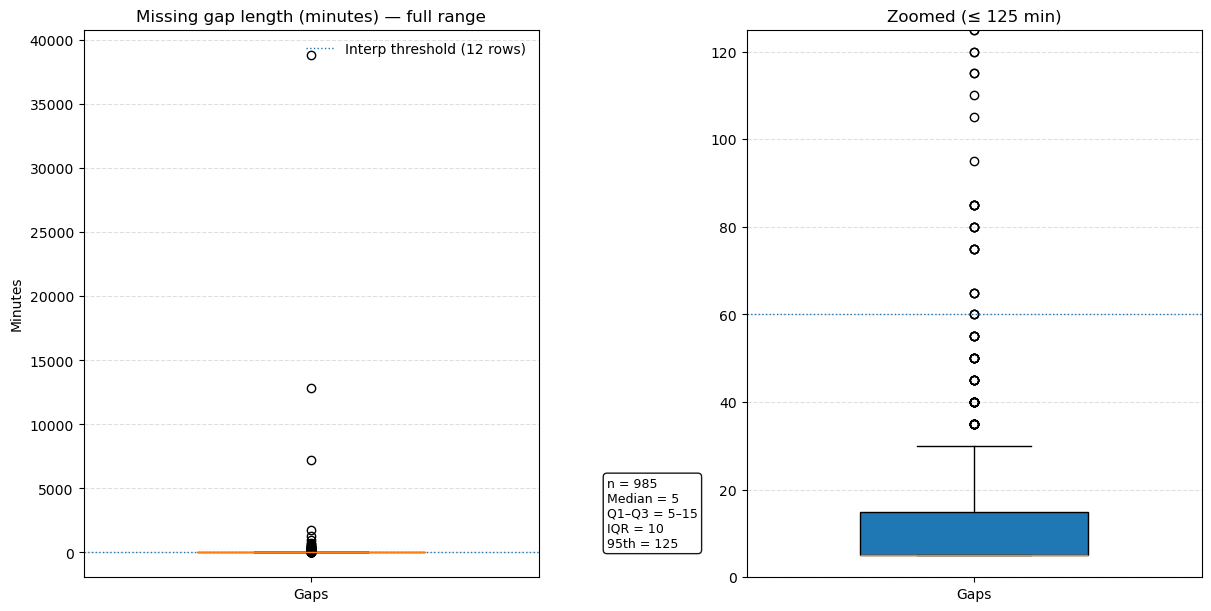

In [ ]:
plot_missing_gaps_box(missing_grid_time_ranges, step_minutes=5, interp_threshold_n=12, zoom='p95')

In [ ]:
stats = prepare_missing_gap_stats(missing_grid_time_ranges, step_minutes=5)

print(stats["summary"].to_pandas().to_string(index=False))
display(stats["by_year"].to_pandas().head())
display(stats["by_year_month"].to_pandas().head())
display(stats["top_gaps"].to_pandas())

 n_gap_periods  rows_missing  hours_missing  days_missing  avg_gap_minutes  median_gap_minutes  max_gap_minutes
           985         17237    1436.416667     59.850694        87.497462                 5.0          38880.0


gap_start_year  n_gap_periods  rows_missing  hours_missing  days_missing  \
0            2020             38           162      13.500000      0.562500   
1            2021            171           399      33.250000      1.385417   
2            2022            339          4224     352.000000     14.666667   
3            2023            215          1057      88.083333      3.670139   
4            2024            153           767      63.916667      2.663194   

   avg_gap_minutes  median_gap_minutes  max_gap_minutes  
0        21.315789                 5.0            275.0  
1        11.666667                 5.0            295.0  
2        62.300885                 5.0           7235.0  
3        24.581395                 5.0            955.0  
4        25.065359                 5.0           1285.0

year_month  n_gap_periods  rows_missing  hours_missing  avg_gap_minutes  \
0    2020-01              3             9       0.750000        15.000000   
1    2020-02              3             3       0.250000         5.000000   
2    2020-03              8            64       5.333333        40.000000   
3    2020-04             12            16       1.333333         6.666667   
4    2020-06              2             5       0.416667        12.500000   

   median_gap_minutes  
0                15.0  
1                 5.0  
2                10.0  
3                 5.0  
4                12.5

missing_start         missing_end  n_missing  gap_minutes  \
0  2025-06-04 00:00:00 2025-06-30 23:55:00       7776      38880.0   
1  2025-05-10 17:10:00 2025-05-19 15:00:00       2567      12835.0   
2  2022-04-27 15:35:00 2022-05-02 16:05:00       1447       7235.0   
3  2022-03-24 11:30:00 2022-03-25 17:00:00        355       1775.0   
4  2024-12-21 17:05:00 2024-12-22 14:25:00        257       1285.0   
5  2023-02-26 14:15:00 2023-02-27 06:05:00        191        955.0   
6  2023-06-07 19:25:00 2023-06-08 07:55:00        151        755.0   
7  2023-03-01 18:05:00 2023-03-02 04:55:00        131        655.0   
8  2022-05-04 23:00:00 2022-05-05 08:05:00        110        550.0   
9  2022-07-05 17:35:00 2022-07-06 02:15:00        105        525.0   
10 2022-06-03 11:00:00 2022-06-03 19:25:00        102        510.0   
11 2022-07-11 18:20:00 2022-07-12 01:20:00         85        425.0   
12 2022-07-03 08:45:00 2022-07-03 15:15:00         79        395.0   
13 2022-02-04 09:30:00 2022-02-04 15:50:00         77        385.0   
14 2022-02-06 09:35:00 2022-02-06 15:50:00         76        380.0   
15 2022-02-05 09:35:00 2022-02-05 15:25:00         71        355.0   
16 2022-03-09 01:20:00 2022-03-09 06:50:00         67        335.0   
17 2025-04-03 02:00:00 2025-04-03 07:30:00         67        335.0   
18 2022-07-30 23:20:00 2022-07-31 04:45:00         66        330.0   
19 2023-11-21 23:35:00 2023-11-22 04:55:00         65        325.0   

     gap_hours   gap_days  
0   648.000000  27.000000  
1   213.916667   8.913194  
2   120.583333   5.024306  
3    29.583333   1.232639  
4    21.416667   0.892361  
5    15.916667   0.663194  
6    12.583333   0.524306  
7    10.916667   0.454861  
8     9.166667   0.381944  
9     8.750000   0.364583  
10    8.500000   0.354167  
11    7.083333   0.295139  
12    6.583333   0.274306  
13    6.416667   0.267361  
14    6.333333   0.263889  
15    5.916667   0.246528  
16    5.583333   0.232639  
17    5.583333   0.232639  
18    5.500000   0.229167  
19    5.416667   0.225694

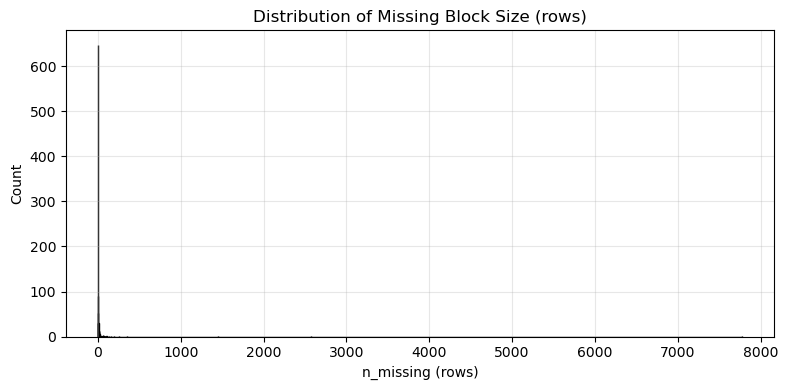

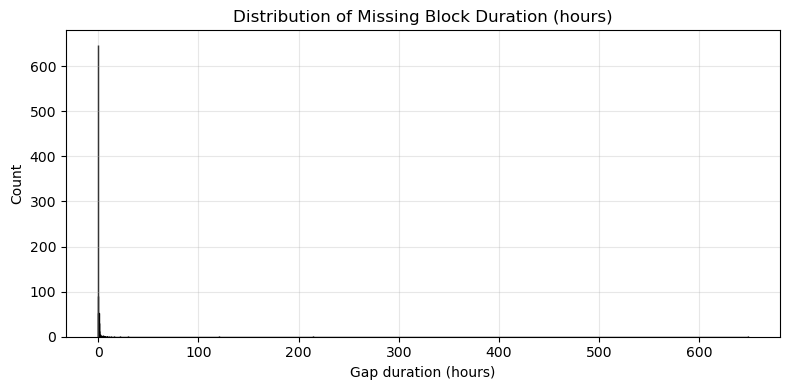

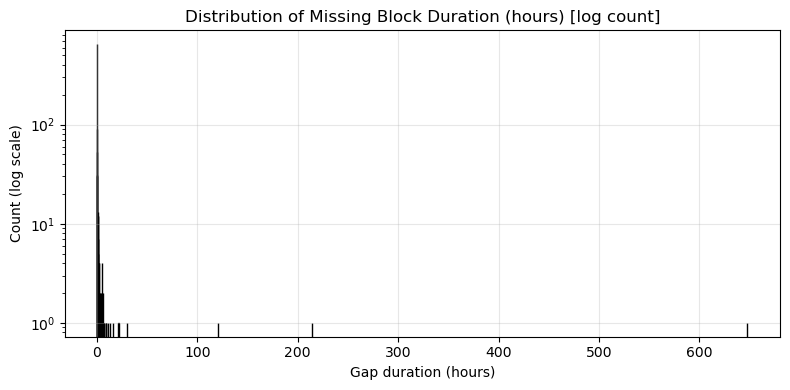

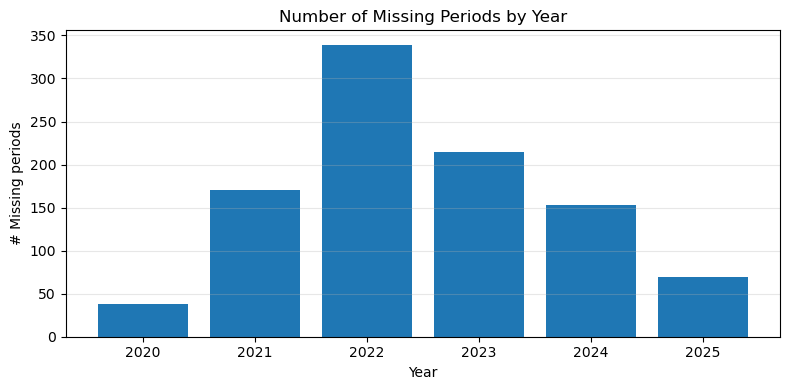

In [ ]:
plot_missing_gap_histograms(missing_grid_time_ranges, step_minutes=5)

Based on the above - we will likely need to do some gap filling for this dataset.

Luckily it appears that the majority of gaps are relatively small (just 5 minutes). For those we can do linear interpolation, but for larger gaps we may need to use a different method.

##### Visualising the Data

Lets visualise the data to get a better understanding of the readings.

###### Demand and Generation Summary

We'll look at the demand and generation data for a single day in the native 5 minute increments, as well as averaged over 30 and 60 minutes to get a better understanding of the data. We'll also plot one graph starting at 0 with another more zoomed in so we can better see trends.

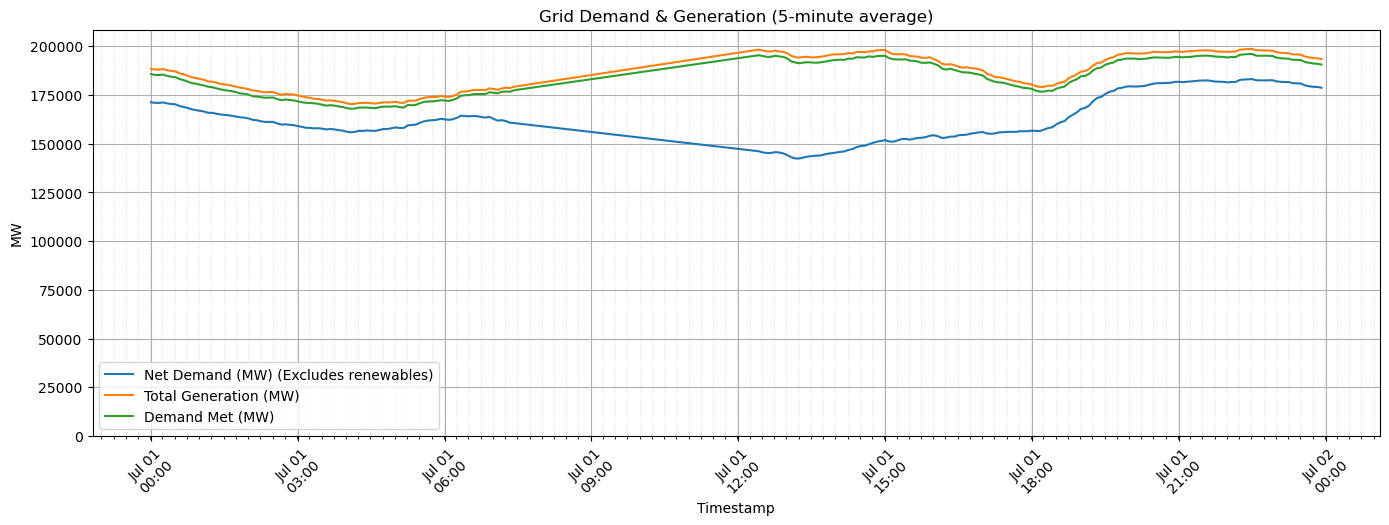

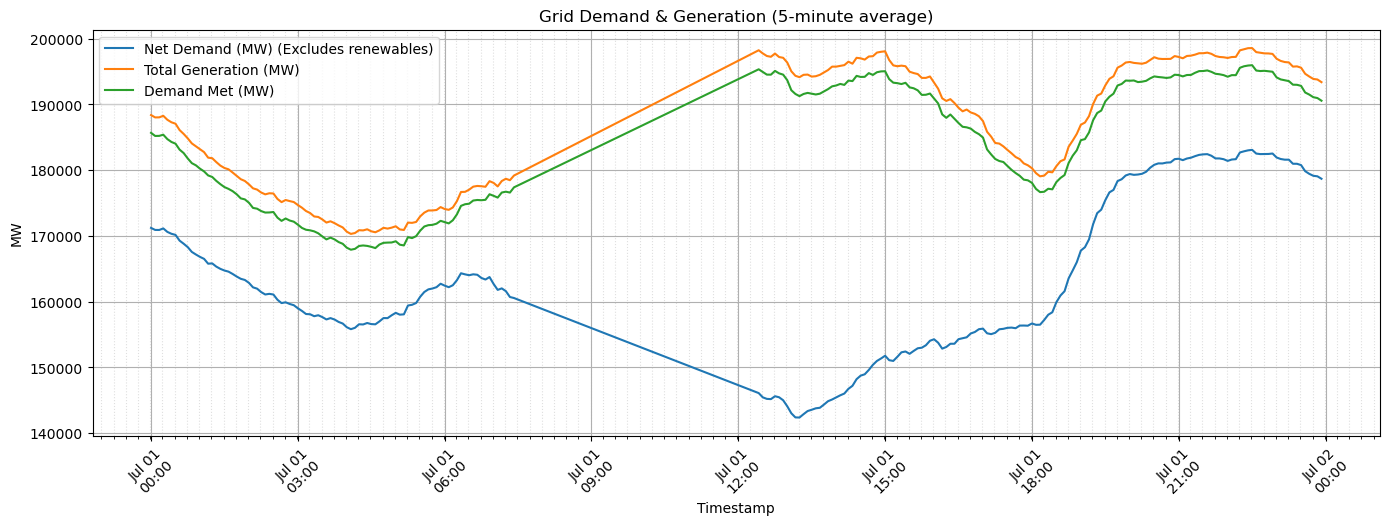

In [ ]:
plot_core_demand_variables(
    df=grid_readings_table_pldf,
    start="2023-07-01 00:00:00",
    end="2023-07-01 23:59:59",
    freq_minutes=5,
    figsize=(14, 5),)

plot_core_demand_variables(
    df=grid_readings_table_pldf,
    start="2023-07-01 00:00:00",
    end="2023-07-01 23:59:59",
    freq_minutes=5,
    figsize=(14, 5),
    start_y_at_zero=False,
)

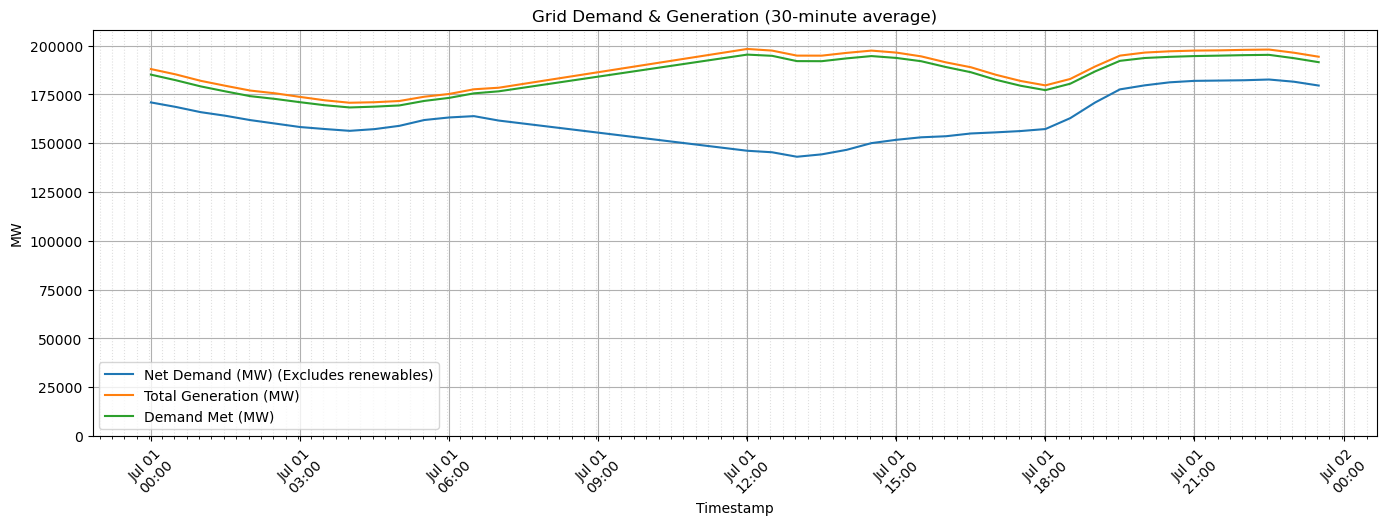

In [ ]:
plot_core_demand_variables(
    df=grid_readings_table_pldf,
    start="2023-07-01 00:00:00",
    end="2023-07-01 23:59:59",
    freq_minutes=30,
    figsize=(14, 5),)

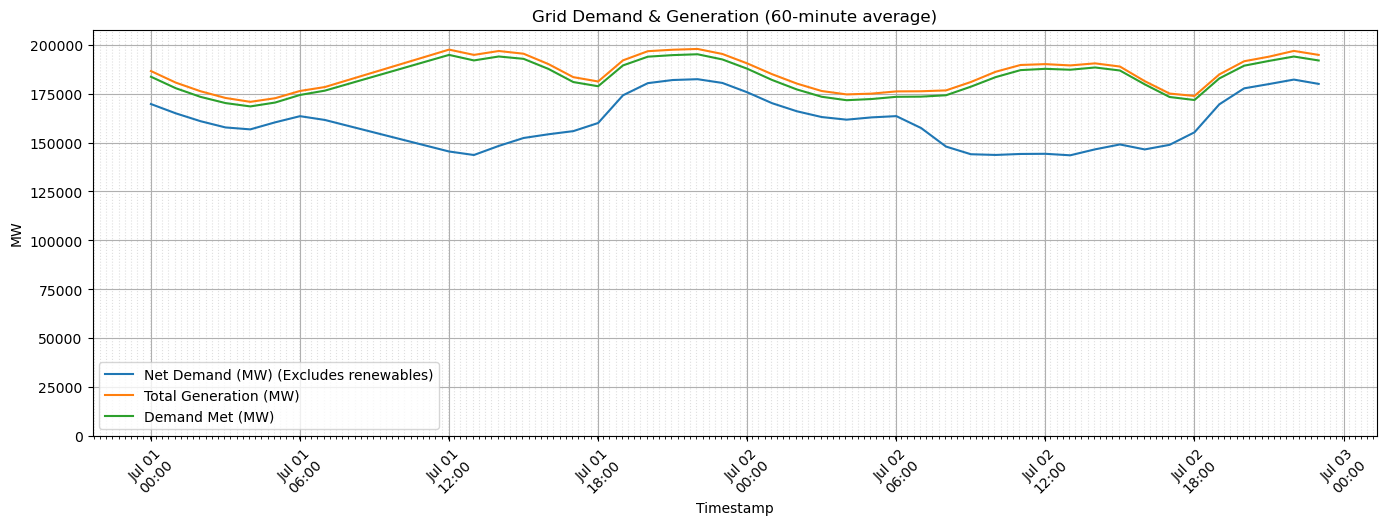

In [ ]:
# Looking at 2 days of data here - we can see similar patterns in the data
plot_core_demand_variables(
    df=grid_readings_table_pldf,
    start="2023-07-01 00:00:00",
    end="2023-07-02 23:59:59",
    freq_minutes=60,
    figsize=(14, 5),)

Based on the above data we can see that there is a rise in production of renewables in the morning peaking around 12:00, and then declining as the day goes on and other sources are ramped up to meet demand.

Now we'll look at plotting individual generation sources to confirm this assumption.
Again, we'll also plot a few graphs starting at 0 with another more zoomed in so we can better see trends.

###### Generation Sources

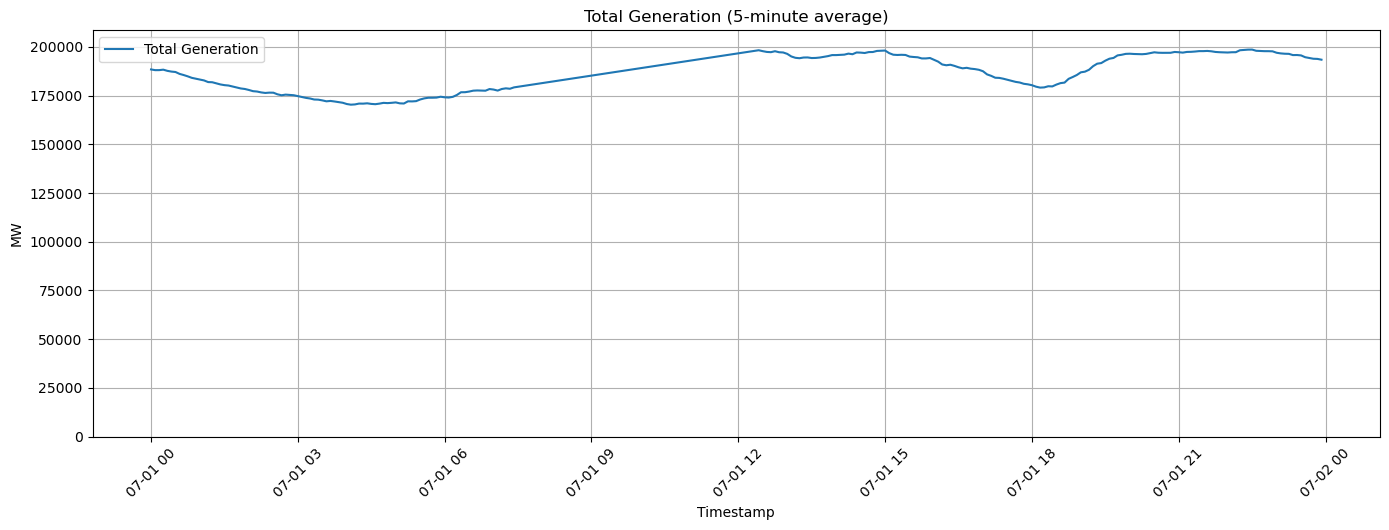

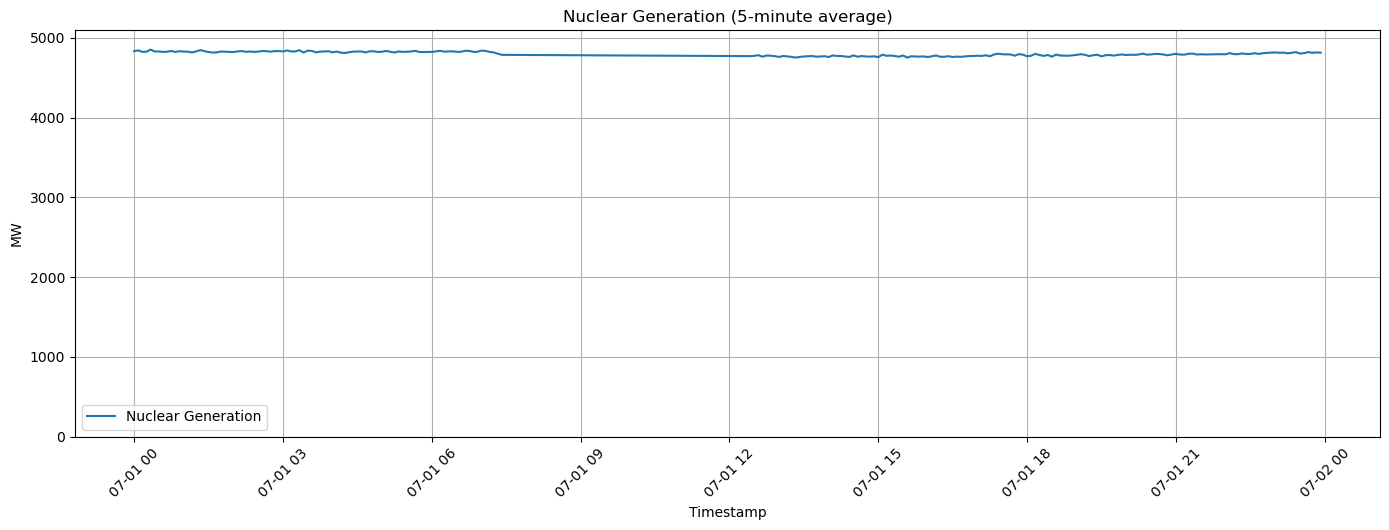

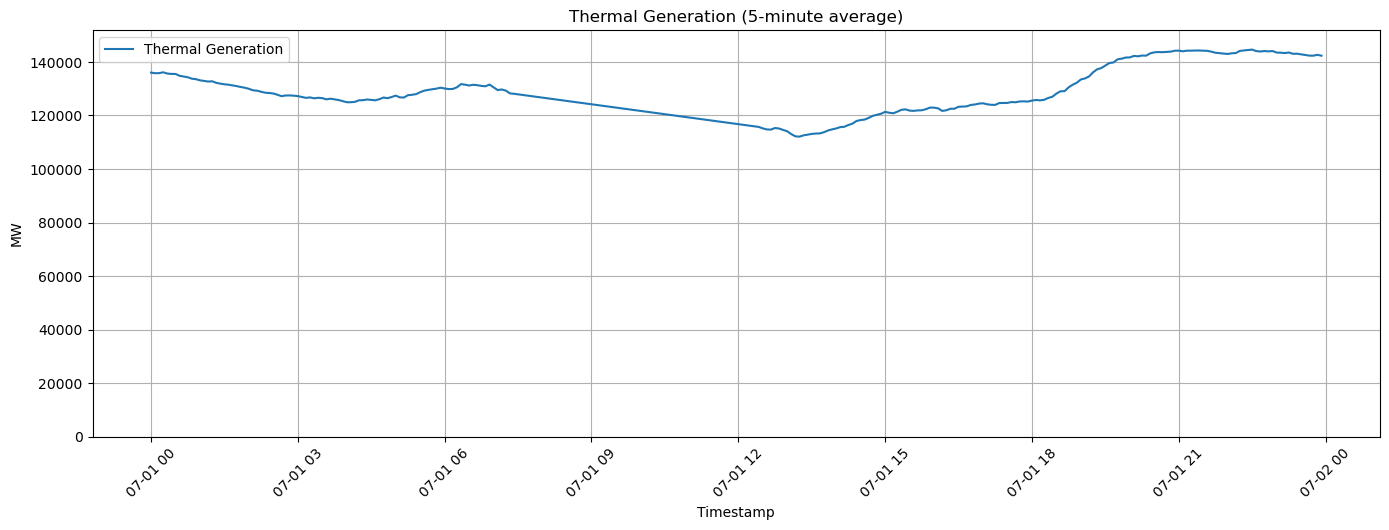

In [69]:
# Example usage for plotting individual variables
plot_variable_over_time(
    df=grid_readings_table_pldf,
    variable="total_generation",
    start="2023-07-01 00:00:00",
    end="2023-07-01 23:59:59",
    freq_minutes=5,
    figsize=(14, 5),
)




plot_variable_over_time(
    df=grid_readings_table_pldf,
    variable="renewable_generation",
    start="2023-07-01 00:00:00",
    end="2023-07-01 23:59:59",
    freq_minutes=5,
    figsize=(14, 5),
)

plot_variable_over_time(
    df=grid_readings_table_pldf,
    variable="nuclear_generation",
    start="2023-07-01 00:00:00",
    end="2023-07-01 23:59:59",
    freq_minutes=5,
    figsize=(14, 5),
)

plot_variable_over_time(
    df=grid_readings_table_pldf,
    variable="hydro_generation",
    start="2023-07-01 00:00:00",
    end="2023-07-01 23:59:59",
    freq_minutes=5,
    figsize=(14, 5),
)

plot_variable_over_time(
    df=grid_readings_table_pldf,
    variable="thermal_generation",
    start="2023-07-01 00:00:00",
    end="2023-07-01 23:59:59",
    freq_minutes=5,
    figsize=(14, 5),
)

plot_variable_over_time(
    df=grid_readings_table_pldf,
    variable="gas_generation",
    start="2023-07-01 00:00:00",
    end="2023-07-01 23:59:59",
    freq_minutes=5,
    figsize=(14, 5),
)


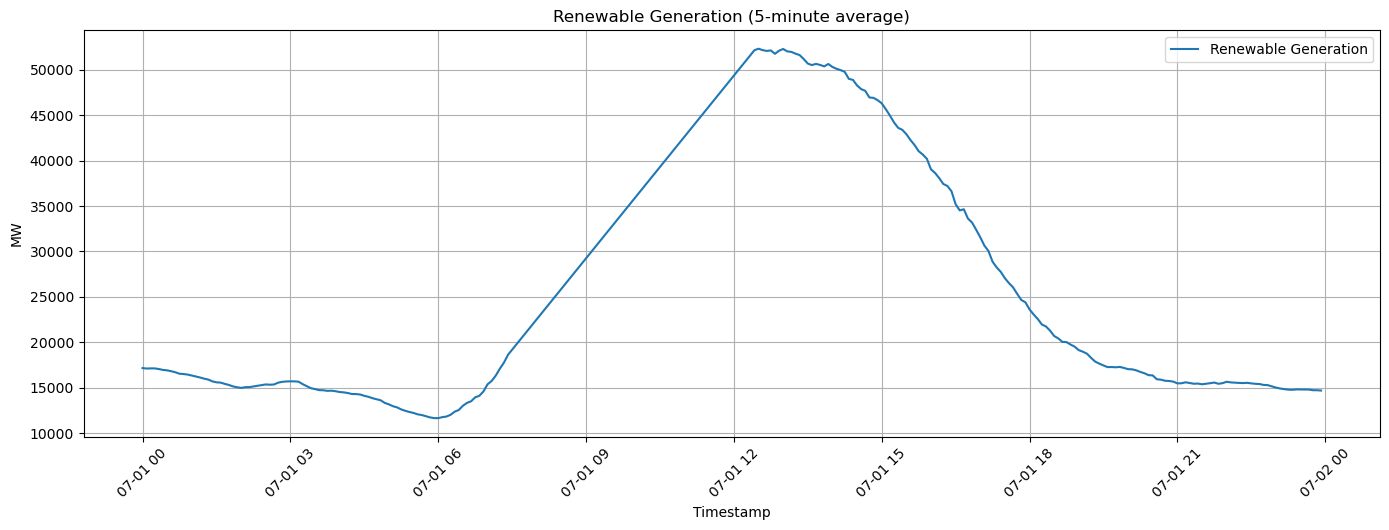

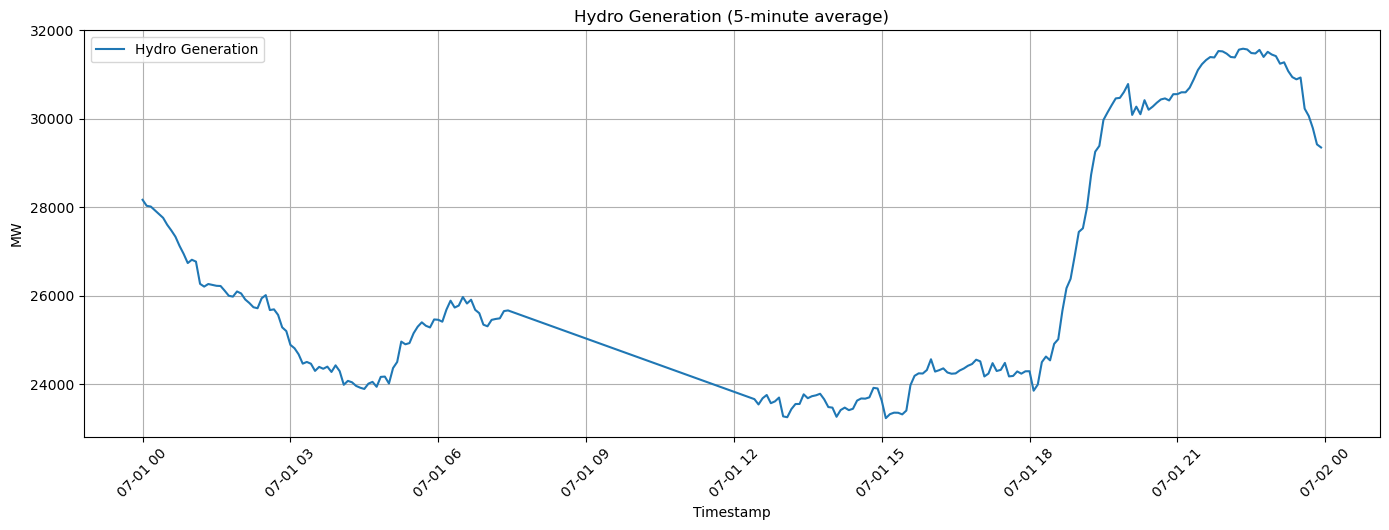

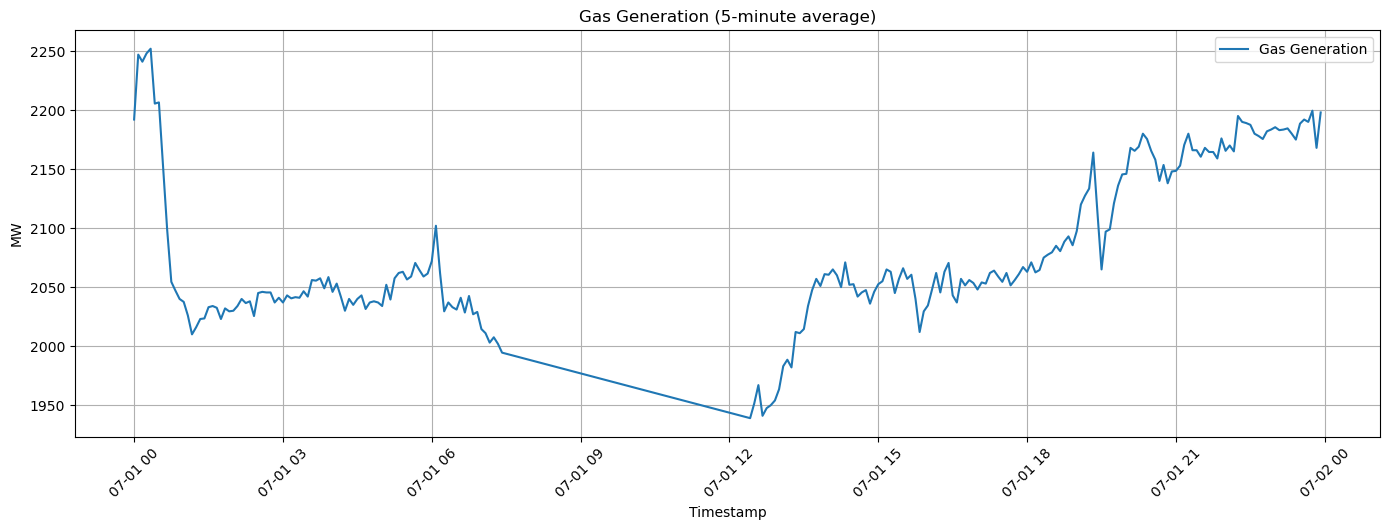

In [68]:
# Example usage for plotting individual variables
plot_variable_over_time(
    df=grid_readings_table_pldf,
    variable="renewable_generation",
    start="2023-07-01 00:00:00",
    end="2023-07-01 23:59:59",
    freq_minutes=5,
    figsize=(14, 5),
    start_y_at_zero=False
)

plot_variable_over_time(
    df=grid_readings_table_pldf,
    variable="nuclear_generation",
    start="2023-07-01 00:00:00",
    end="2023-07-01 23:59:59",
    freq_minutes=5,
    figsize=(14, 5),
    start_y_at_zero=False
)

plot_variable_over_time(
    df=grid_readings_table_pldf,
    variable="hydro_generation",
    start="2023-07-01 00:00:00",
    end="2023-07-01 23:59:59",
    freq_minutes=5,
    figsize=(14, 5),
    start_y_at_zero=False
)

plot_variable_over_time(
    df=grid_readings_table_pldf,
    variable="thermal_generation",
    start="2023-07-01 00:00:00",
    end="2023-07-01 23:59:59",
    freq_minutes=5,
    figsize=(14, 5),
    start_y_at_zero=False
)

plot_variable_over_time(
    df=grid_readings_table_pldf,
    variable="gas_generation",
    start="2023-07-01 00:00:00",
    end="2023-07-01 23:59:59",
    freq_minutes=5,
    figsize=(14, 5),
    start_y_at_zero=False
)

We'll plot another of a different day to see if the patterns look similar

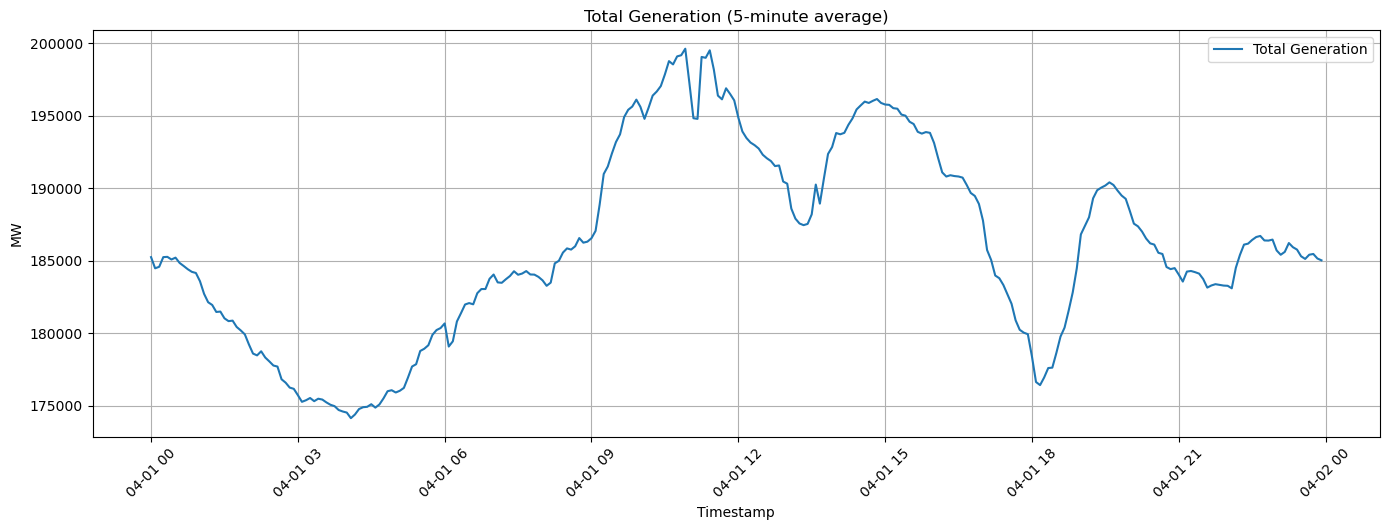

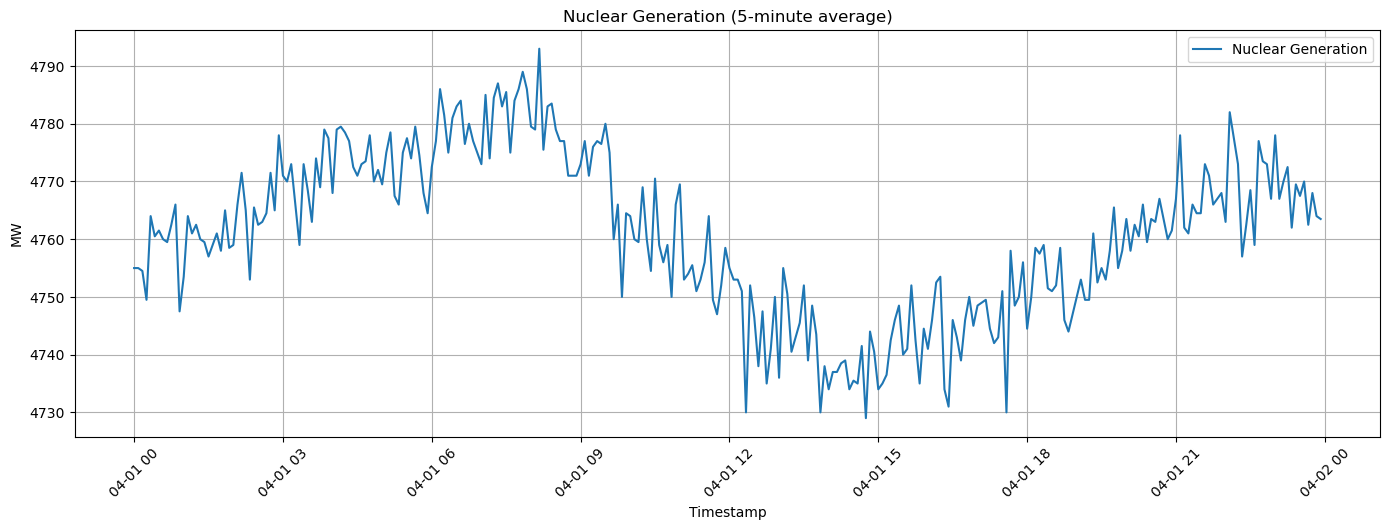

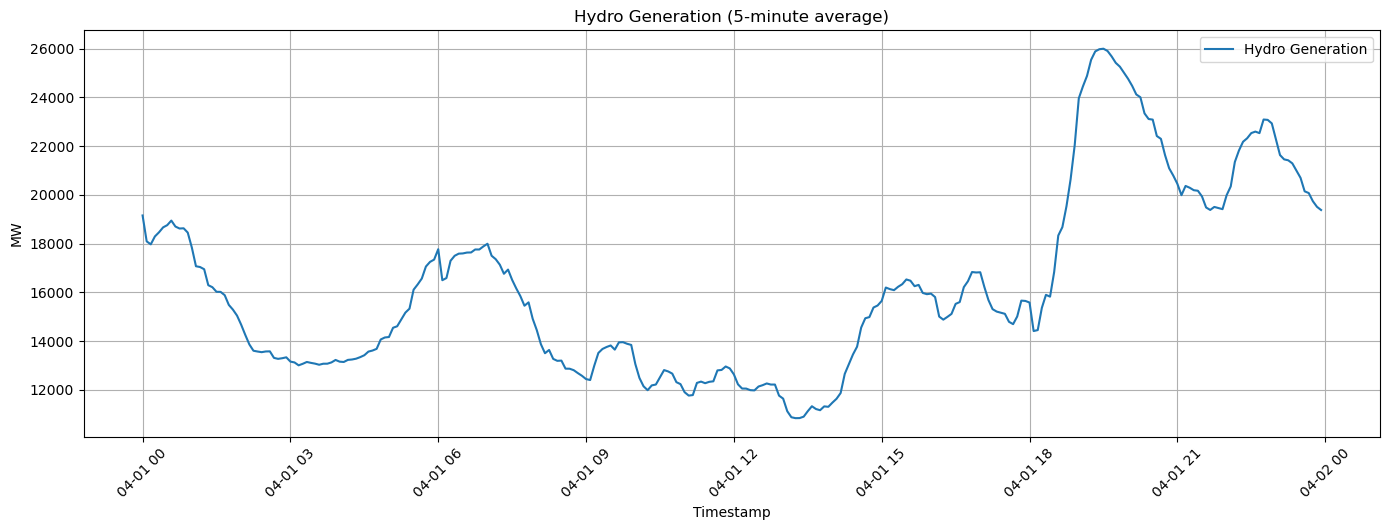

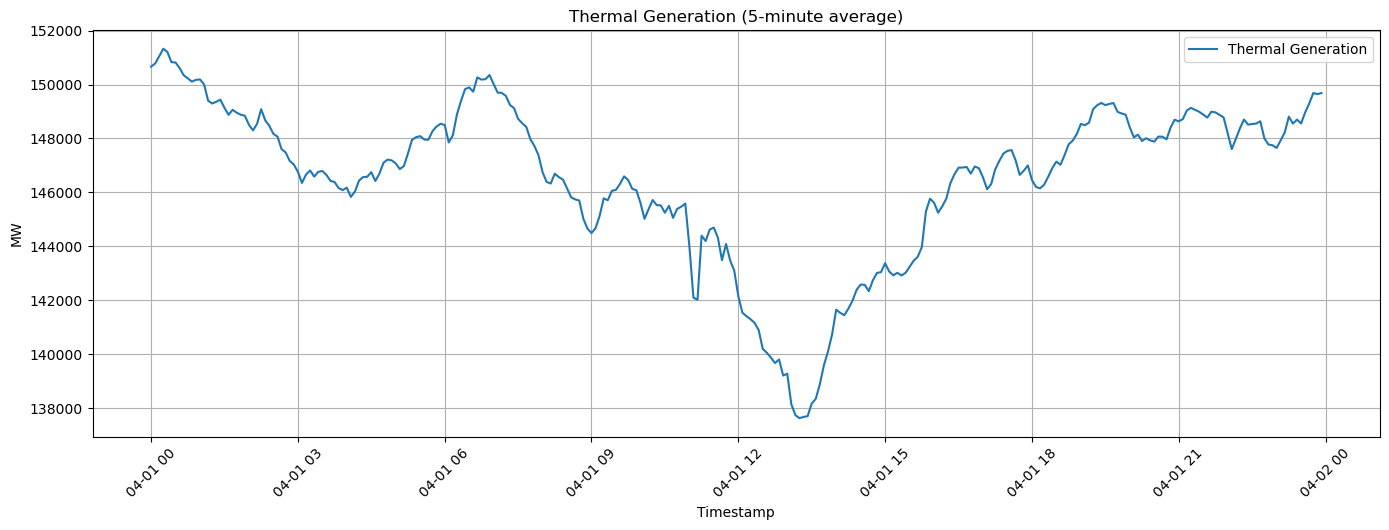

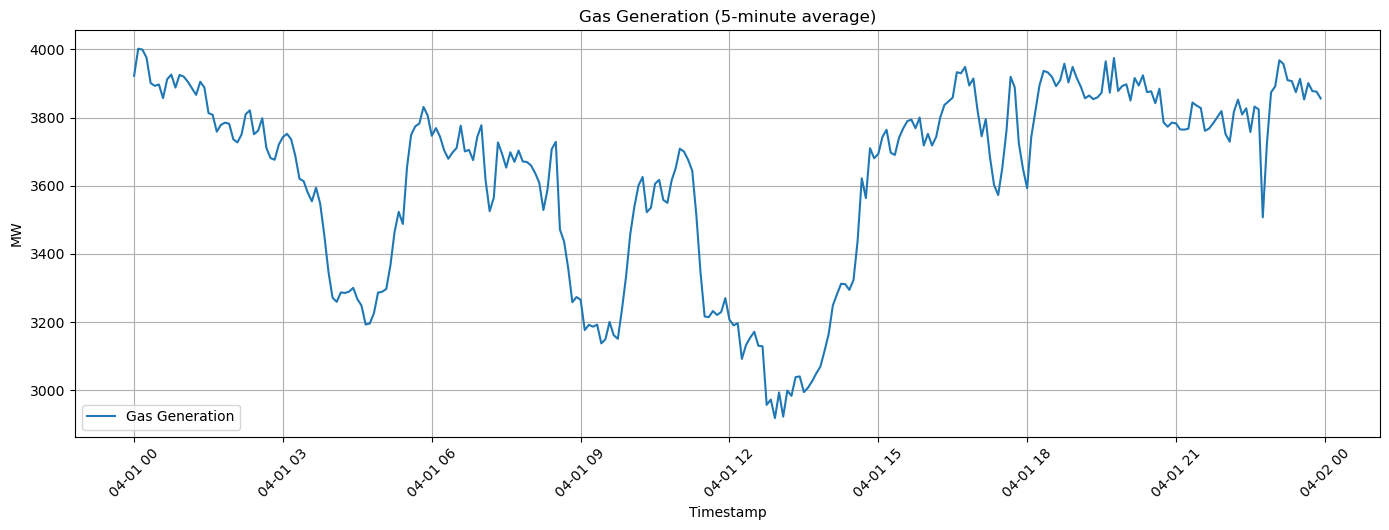

In [70]:
# Example usage for plotting individual variables
plot_variable_over_time(
    df=grid_readings_table_pldf,
    variable="total_generation",
    start="2022-04-01 00:00:00",
    end="2022-04-01 23:59:59",
    freq_minutes=5,
    figsize=(14, 5),
    start_y_at_zero=False
)


plot_variable_over_time(
    df=grid_readings_table_pldf,
    variable="renewable_generation",
    start="2022-04-01 00:00:00",
    end="2022-04-01 23:59:59",
    freq_minutes=5,
    figsize=(14, 5),
    start_y_at_zero=False
)

plot_variable_over_time(
    df=grid_readings_table_pldf,
    variable="nuclear_generation",
    start="2022-04-01 00:00:00",
    end="2022-04-01 23:59:59",
    freq_minutes=5,
    figsize=(14, 5),
    start_y_at_zero=False
)

plot_variable_over_time(
    df=grid_readings_table_pldf,
    variable="hydro_generation",
    start="2022-04-01 00:00:00",
    end="2022-04-01 23:59:59",
    freq_minutes=5,
    figsize=(14, 5),
    start_y_at_zero=False
)

plot_variable_over_time(
    df=grid_readings_table_pldf,
    variable="thermal_generation",
    start="2022-04-01 00:00:00",
    end="2022-04-01 23:59:59",
    freq_minutes=5,
    figsize=(14, 5),
    start_y_at_zero=False
)
plot_variable_over_time(
    df=grid_readings_table_pldf,
    variable="gas_generation",
    start="2022-04-01 00:00:00",
    end="2022-04-01 23:59:59",
    freq_minutes=5,
    figsize=(14, 5),
    start_y_at_zero=False
)


The data looks roughly the same. We're looking at a slightly different time of year, so we can expect some differences, but the overall trends look similar.
The renewable generation still peaks around 12:00, and the other sources ramp up to meet demand as the day goes on.

Now we'll look at plotting all of the generation sources together to see how they compare to each other over the course of a day and over the course of a week

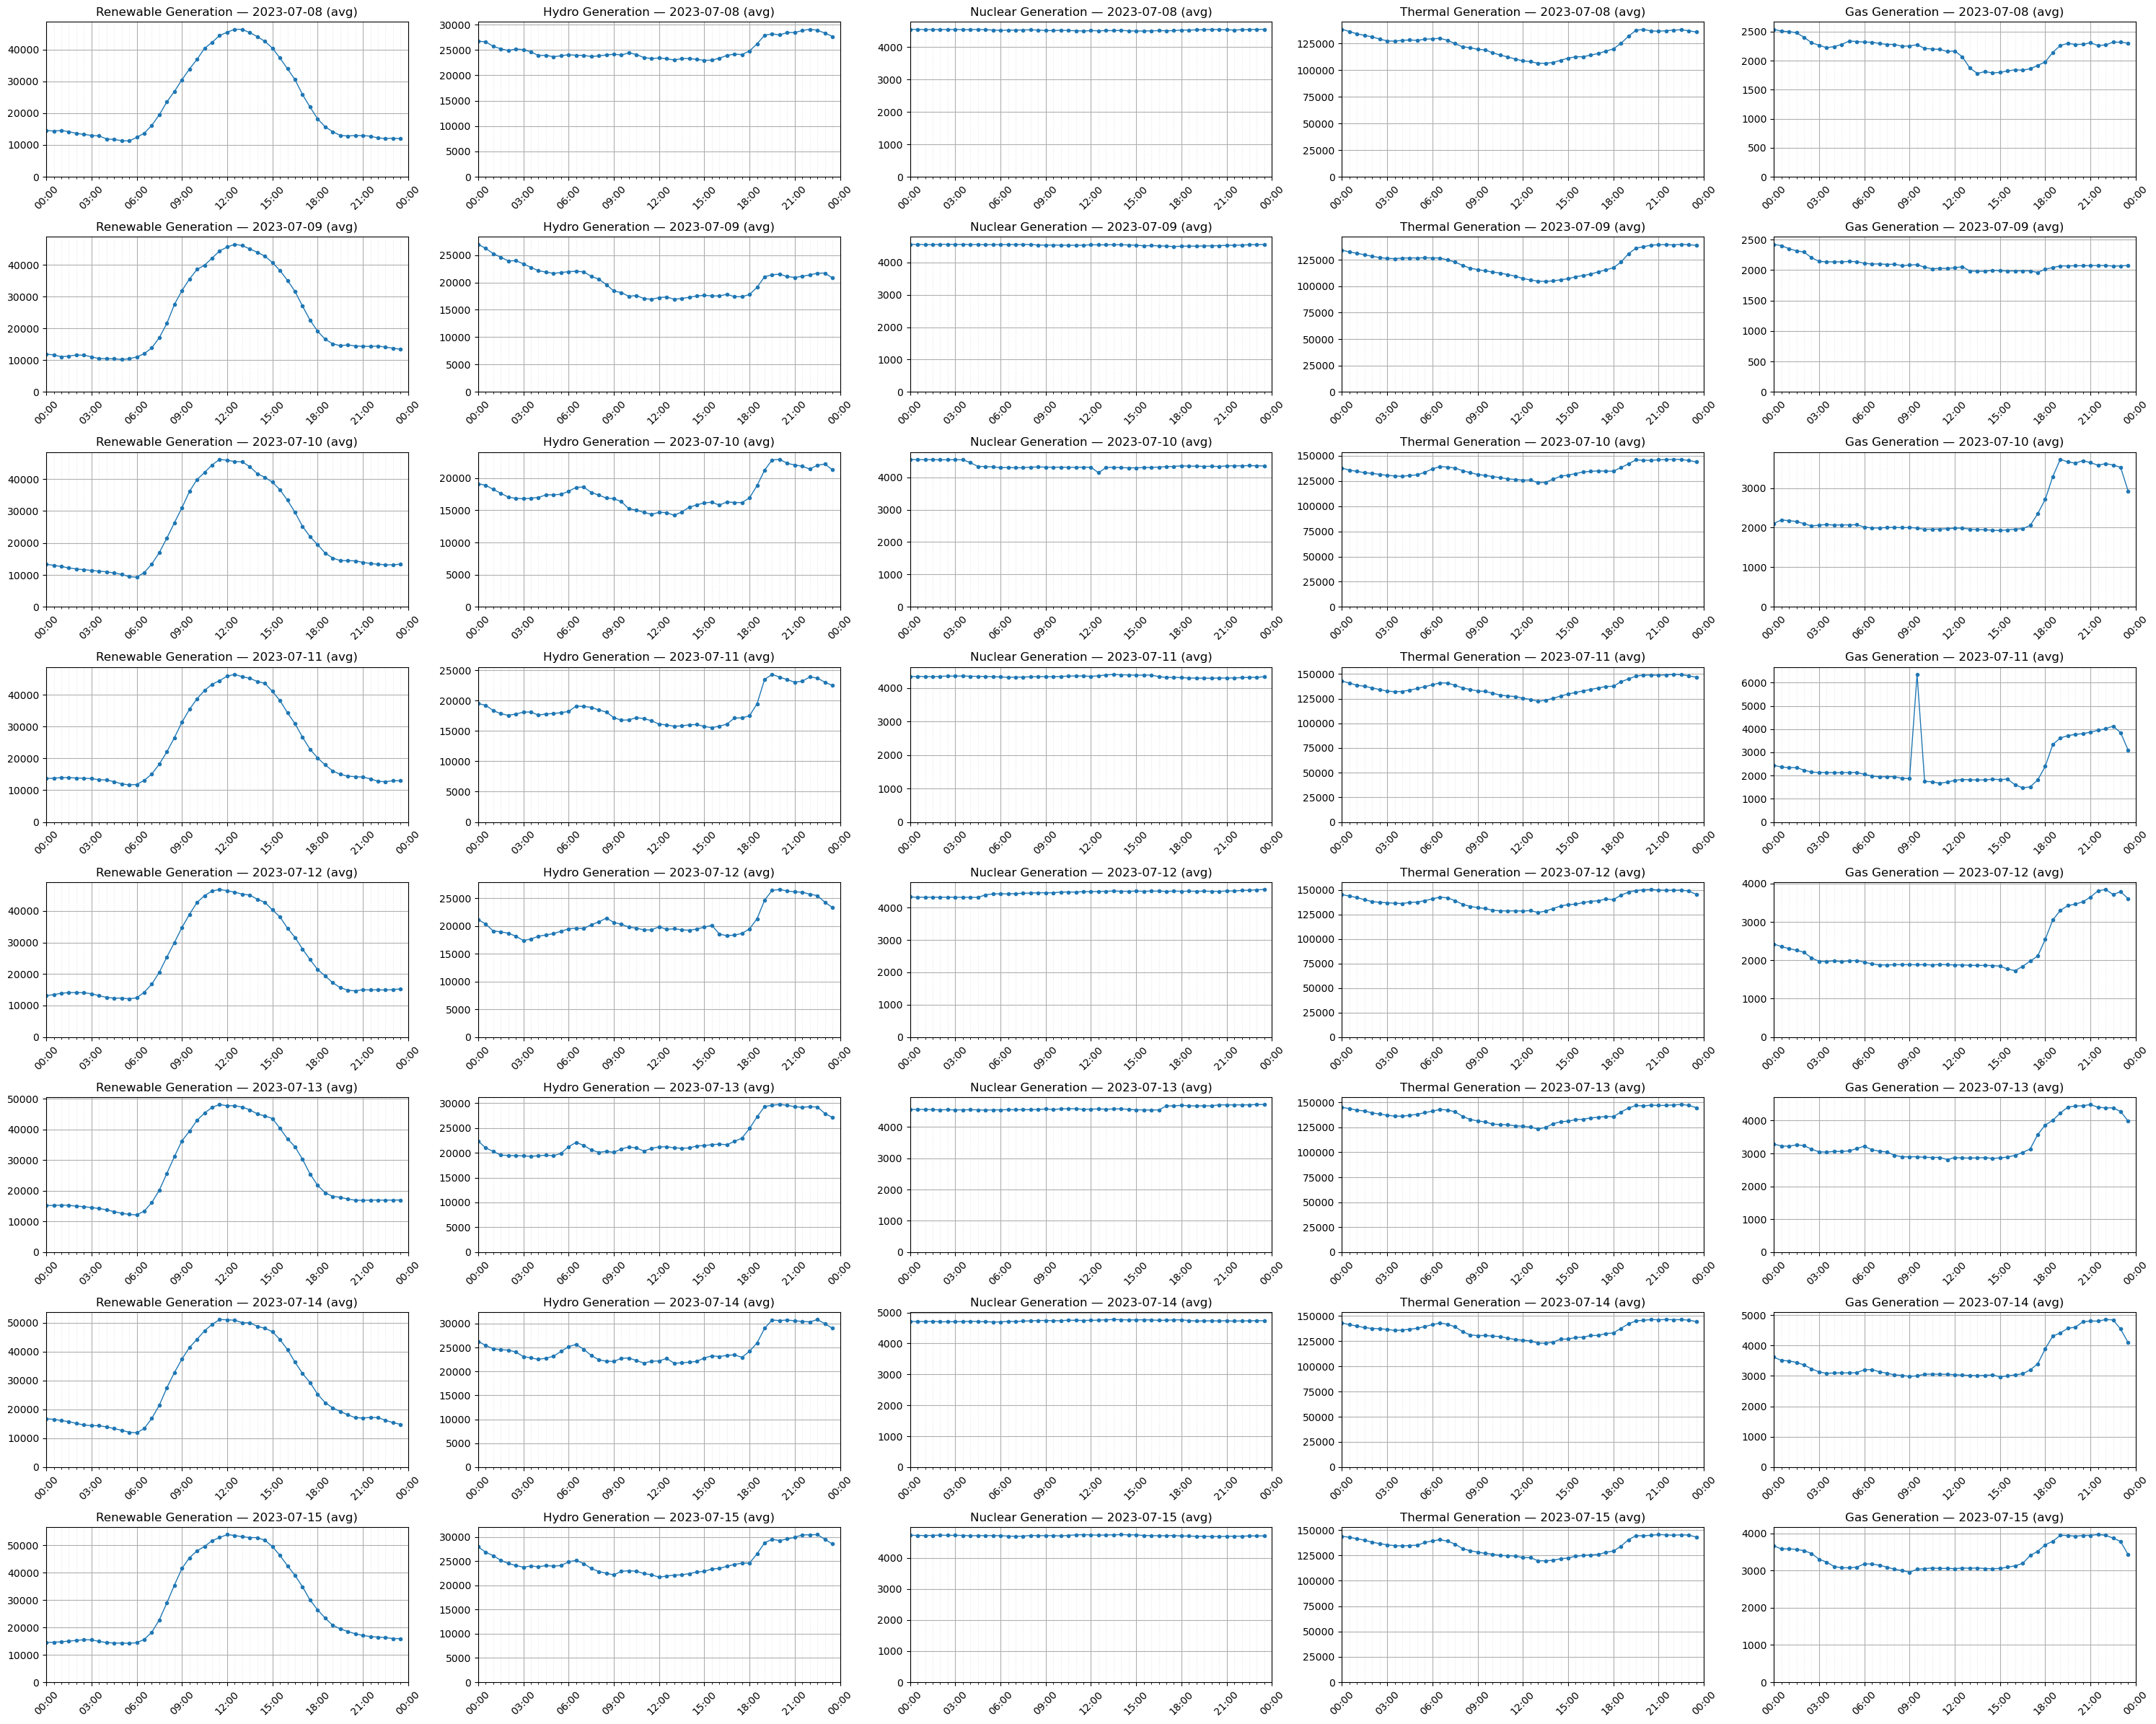

In [ ]:
plot_daily_grid_of_variables(
    df=grid_readings_table_pldf,
    variables=["renewable_generation", "hydro_generation", "nuclear_generation", "thermal_generation", "gas_generation"],
    start="2023-07-08",
    end="2023-07-15",
    freq_minutes=30,
    figsize_per_plot=(6, 3),
    unify_y_axis=False
)


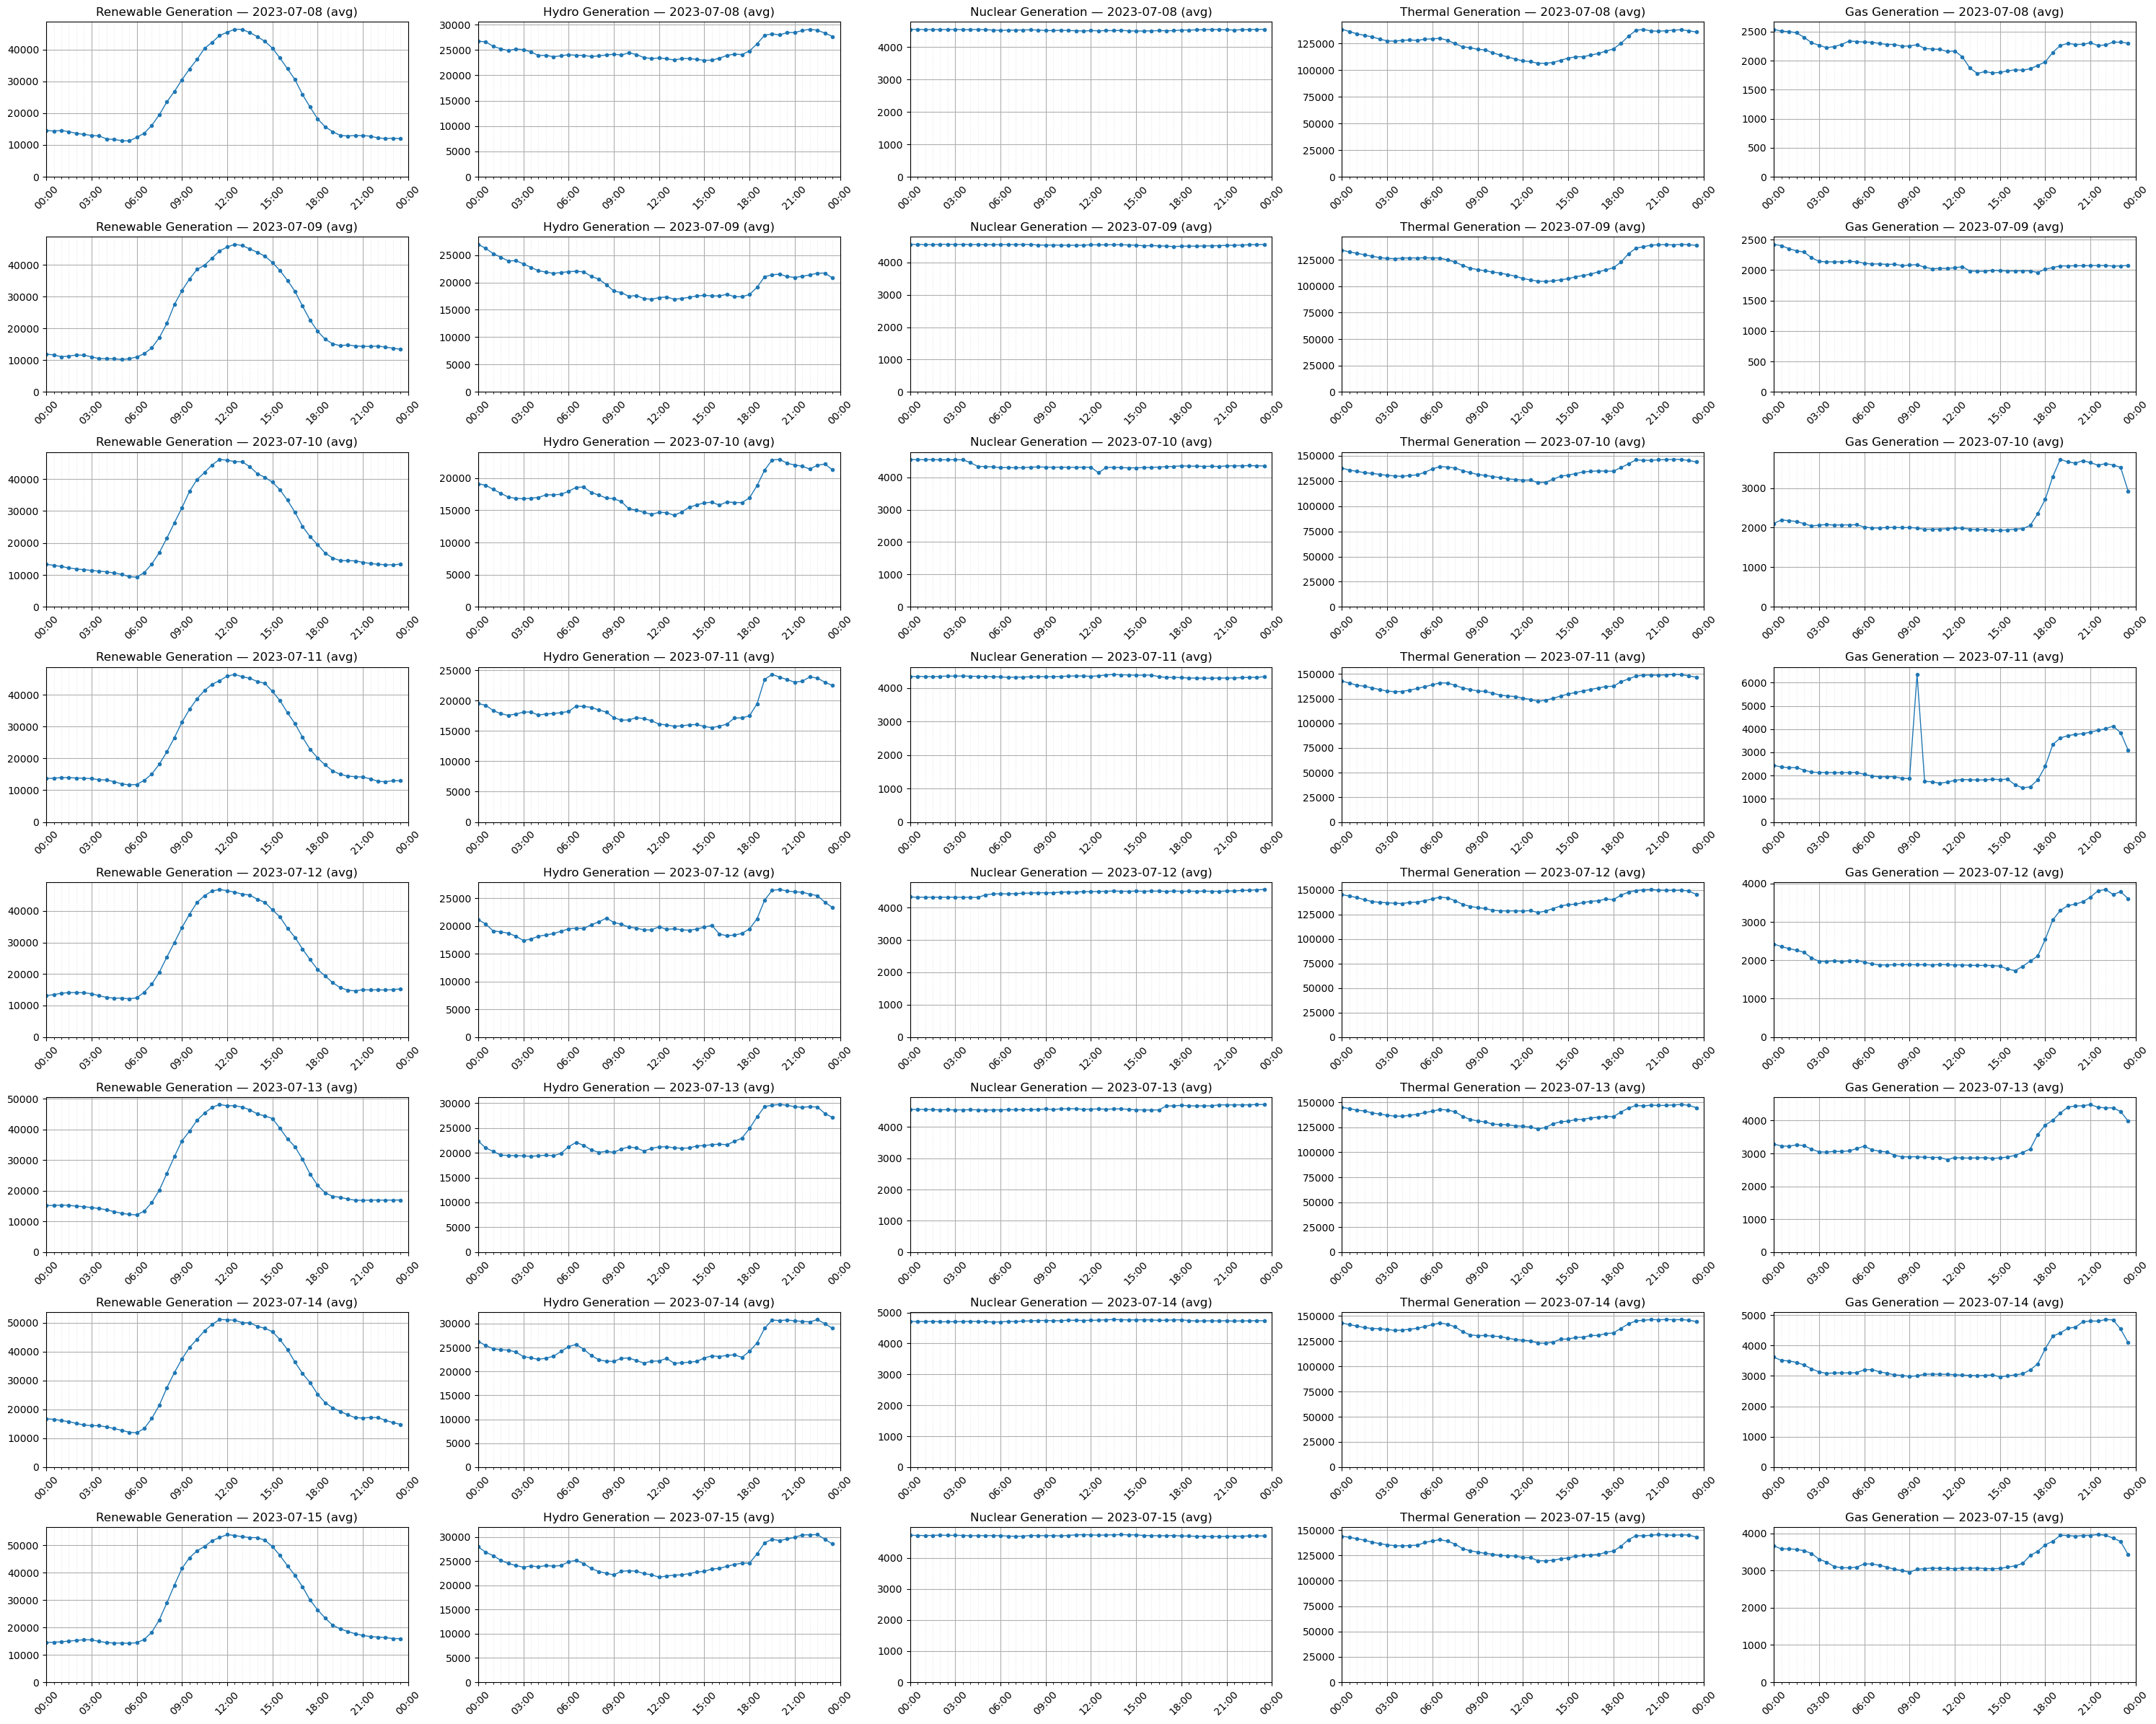

In [ ]:
plot_daily_grid_of_variables(
    df=grid_readings_table_pldf,
    variables=["renewable_generation", "hydro_generation", "nuclear_generation", "thermal_generation", "gas_generation"],
    start="2023-07-08",
    end="2023-07-15",
    freq_minutes=30,
    figsize_per_plot=(6, 3),
    unify_y_axis=False
)


If we zoom in a bit more there is a lot more variation in the data, but the overall trends are still similar.

###### Long Term Trends

In [ ]:
plot_generation_trends(
    df=grid_readings_table_pldf,
    plot_type="stacked",
    freq="annual",
    sources=["thermal_generation", "gas_generation", "nuclear_generation", "hydro_generation", "renewable_generation"],
    title="Annual Generation Trends (Stacked Area Chart)",
    total_gen_line=False,
)

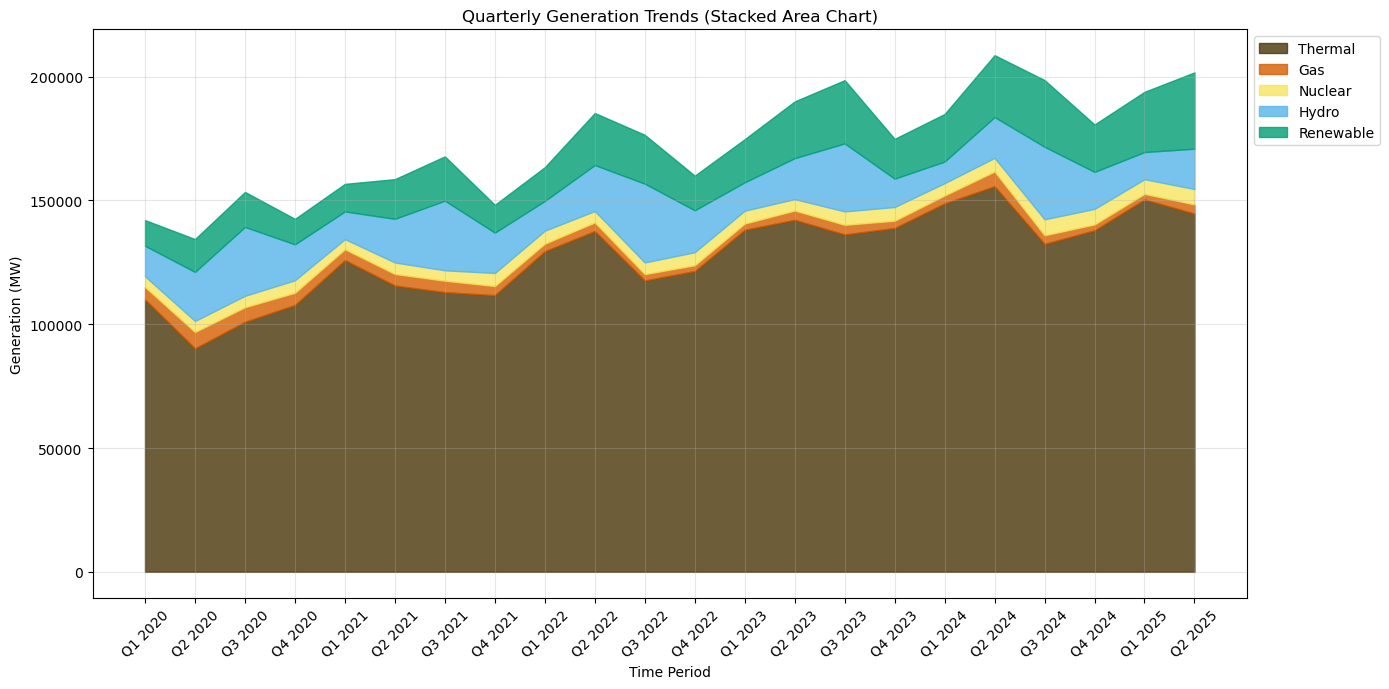

In [ ]:
plot_generation_trends(
    df=grid_readings_table_pldf,
    plot_type="stacked",
    freq="quarterly",
    sources=["thermal_generation", "gas_generation", "nuclear_generation", "hydro_generation", "renewable_generation"],
    title="Quarterly Generation Trends (Stacked Area Chart)",
    total_gen_line=False,
)


/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_52556/3258779119.py:61: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--o" (-> color='k'). The keyword argument will take precedence.
  plt.plot(


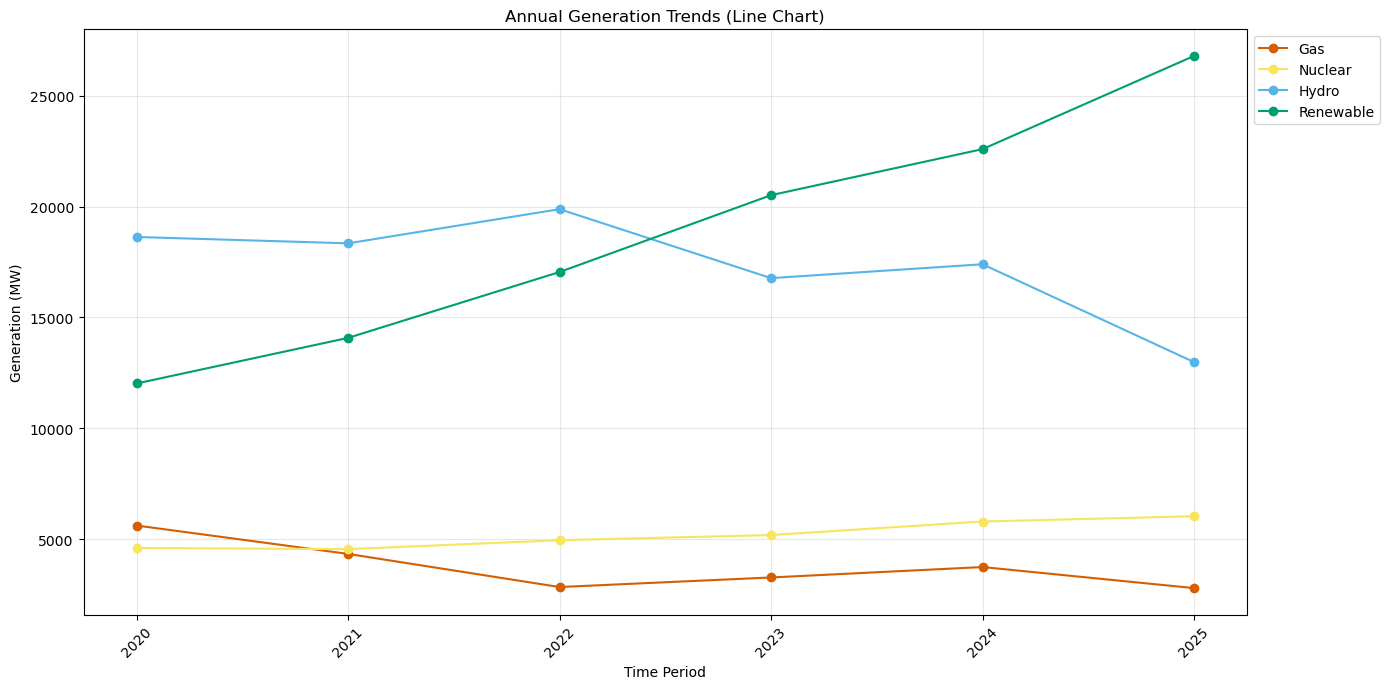

In [ ]:
plot_generation_trends(
    df=grid_readings_table_pldf,
    plot_type="line",
    freq="annual",
    sources=[
            # "thermal_generation",
             "gas_generation",
             "nuclear_generation",
             "hydro_generation",
             "renewable_generation"],
    title="Annual Generation Trends (Line Chart)",
    total_gen_line=True,
)
plot_generation_trends(
    df=grid_readings_table_pldf,
    plot_type="line",
    freq="annual",
    sources=[
        # "thermal_generation",
             "gas_generation",
             "nuclear_generation",
             "hydro_generation",
             "renewable_generation"],
    title="Annual Generation Trends (Line Chart)",
    total_gen_line=False,
)

/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_10077/3258779119.py:61: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--o" (-> color='k'). The keyword argument will take precedence.
  plt.plot(


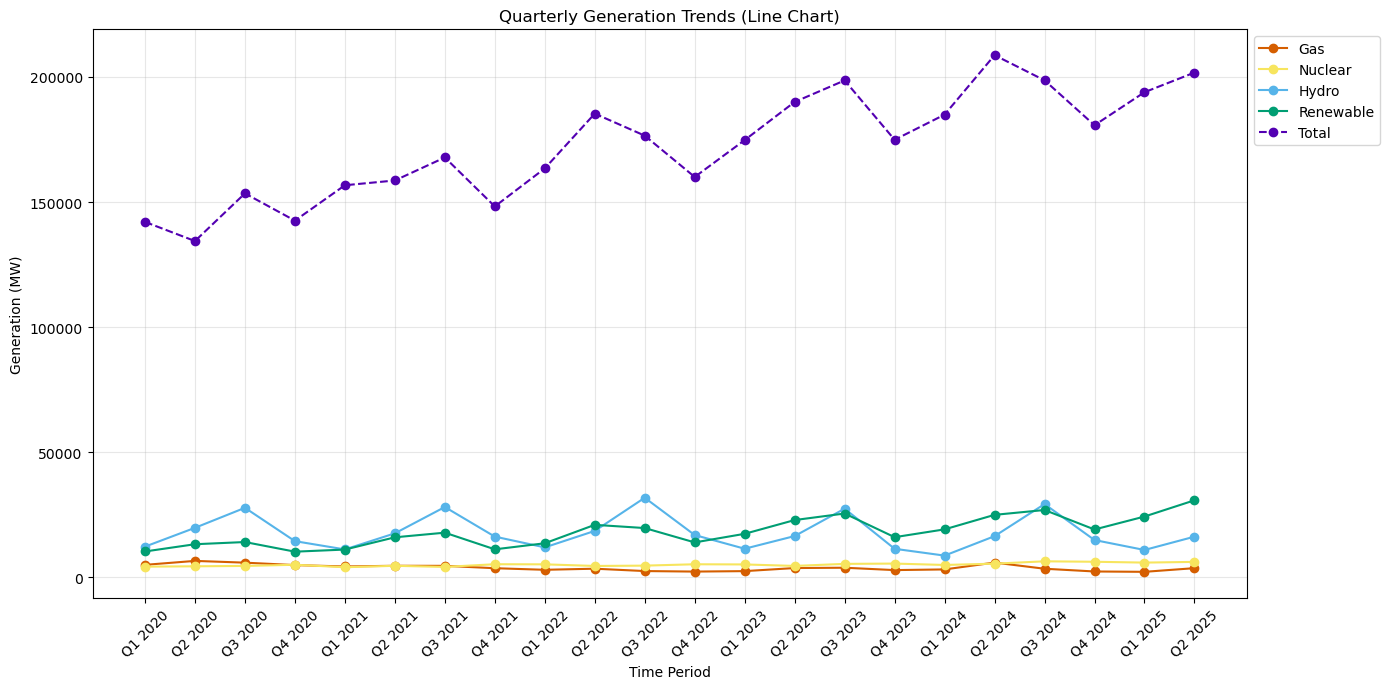

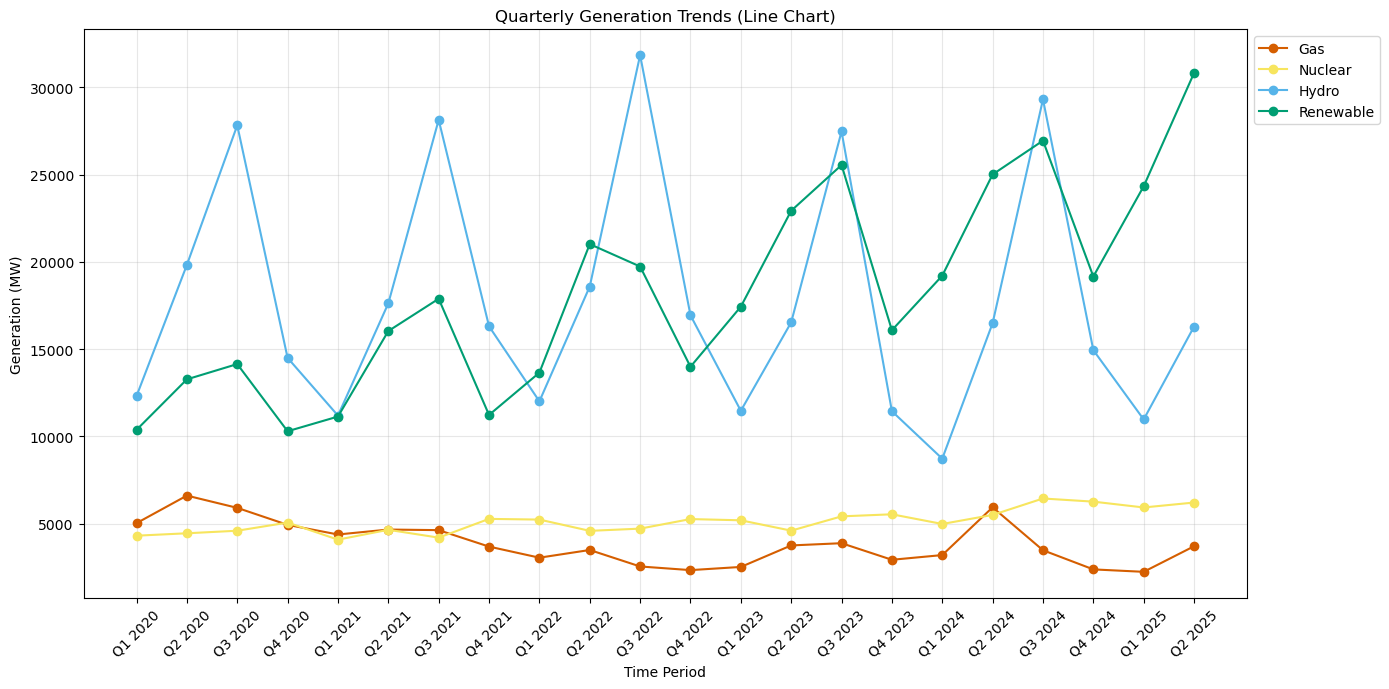

In [ ]:
plot_generation_trends(
    df=grid_readings_table_pldf,
    plot_type="line",
    freq="quarterly",
    sources=[
        # "thermal_generation",
             "gas_generation",
             "nuclear_generation",
             "hydro_generation",
             "renewable_generation"],
    title="Quarterly Generation Trends (Line Chart)",
    total_gen_line=True,
)

plot_generation_trends(
    df=grid_readings_table_pldf,
    plot_type="line",
    freq="quarterly",
    sources=[
        # "thermal_generation",
             "gas_generation",
             "nuclear_generation",
             "hydro_generation",
             "renewable_generation"],
    title="Quarterly Generation Trends (Line Chart)",
    total_gen_line=False,
)

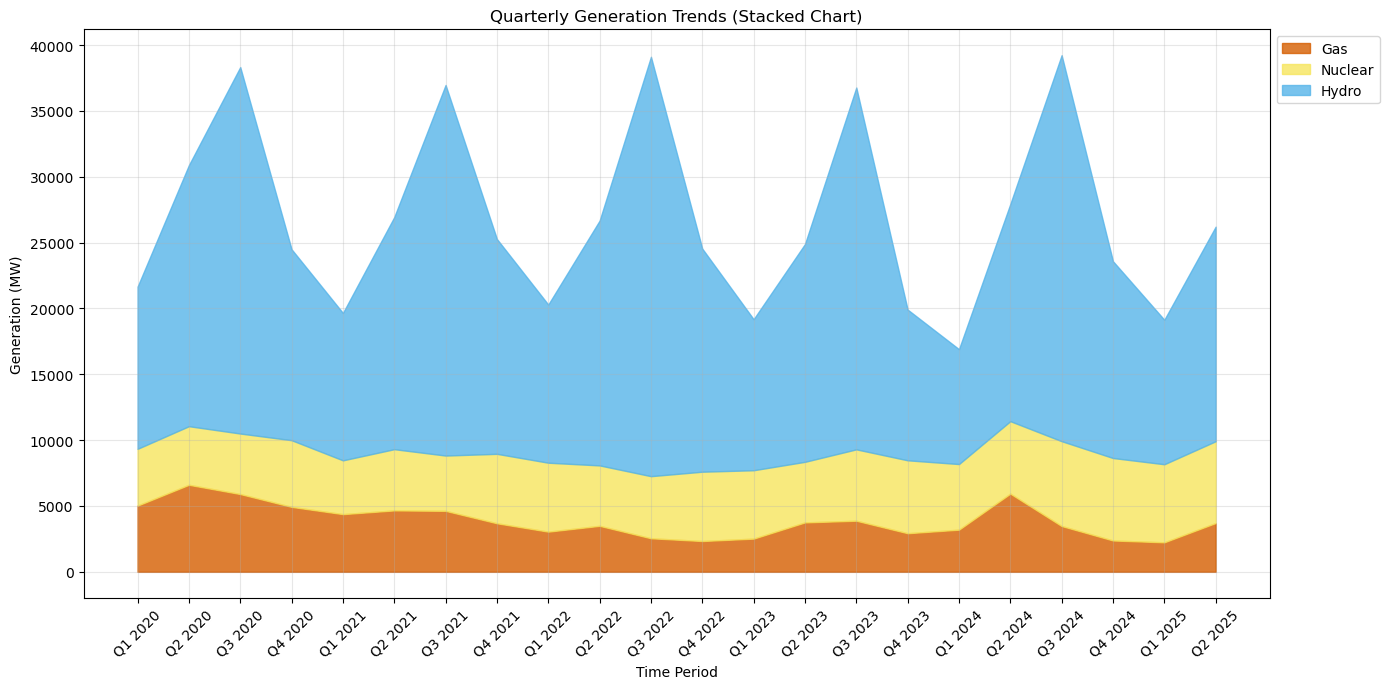

In [ ]:
plot_generation_trends(
    df=grid_readings_table_pldf,
    plot_type="stacked",
    freq="quarterly",
    sources=[
        # "thermal_generation",
             "gas_generation",
             "nuclear_generation",
             "hydro_generation",
            #  "renewable_generation"
            ],
    title="Quarterly Generation Trends (Stacked Chart)",
    total_gen_line=False,
)

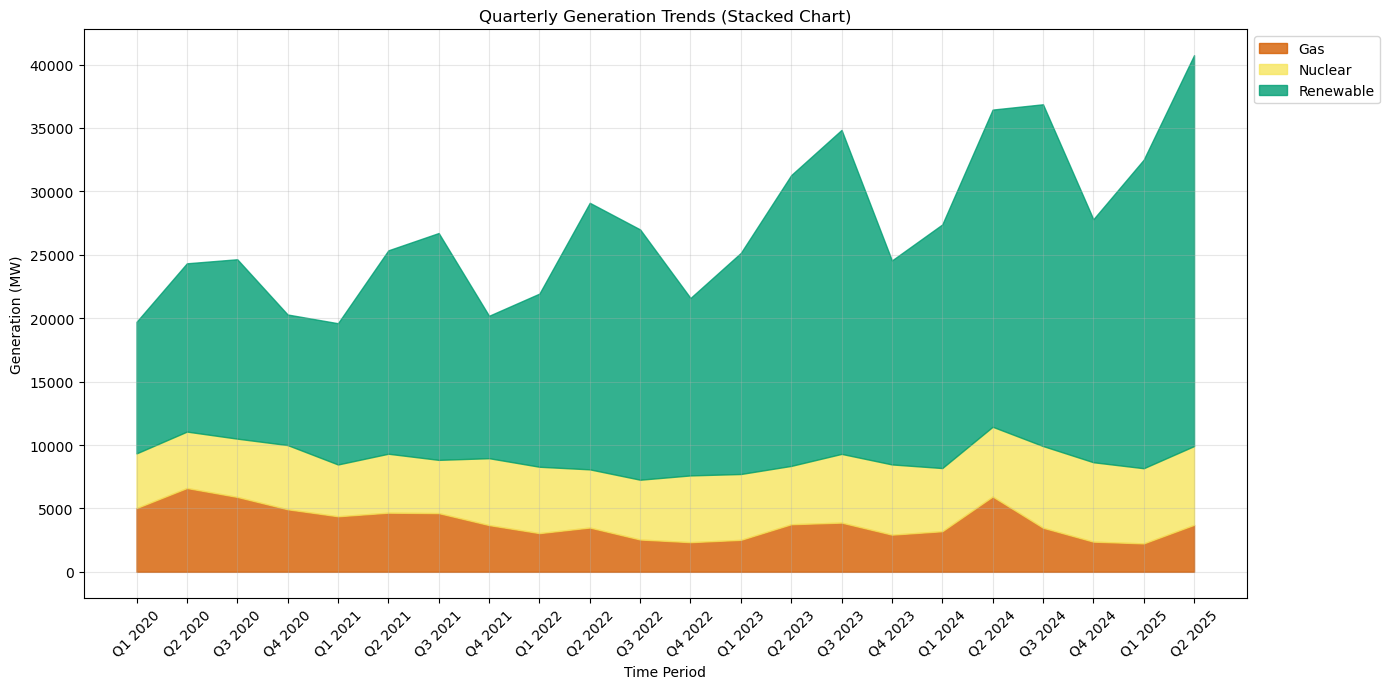

In [ ]:
plot_generation_trends(
    df=grid_readings_table_pldf,
    plot_type="stacked",
    freq="quarterly",
    sources=[
        # "thermal_generation",
             "gas_generation",
             "nuclear_generation",
            #  "hydro_generation",
             "renewable_generation"
            ],
    title="Quarterly Generation Trends (Stacked Chart)",
    total_gen_line=False,
)

The above shows that renewable generation is growing over time, but the majority of generation is still coming from thermal coal sources.

We also see a cyclical nature to both renewable and hydro generation, with Q2 and Q3 seeing the highest generation, and Q1 and Q4 seeing the lowest generation.

Nuclear and gas are relatively stable and if anything gas may have decreased and nuclear increased.

Thermal is also increasing

Now lets look  at the annual growth

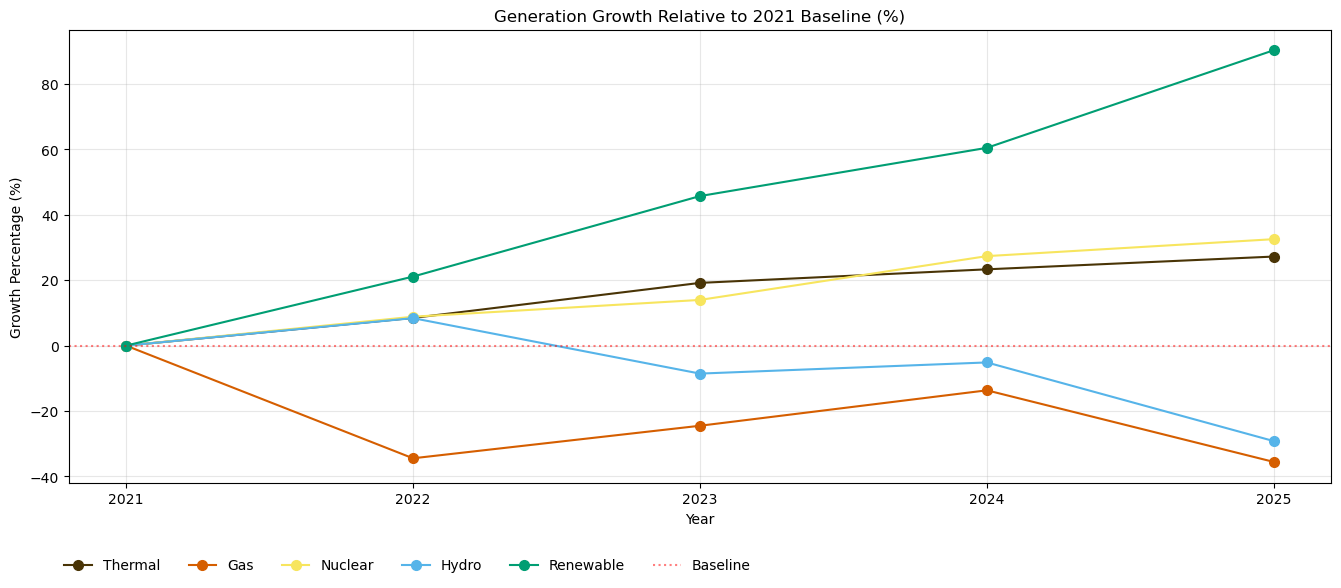

In [ ]:
x(
    df=grid_readings_table_pldf,
    baseline_year=2021,
    include_sources=["thermal_generation", "gas_generation", "nuclear_generation", "hydro_generation", "renewable_generation"],
    exclude_sources=None,
    figsize=(14, 6),
    show_baseline_only=True
)

In [ ]:
display_growth_data(
    df=grid_readings_table_pldf,
    baseline_year=2021,
    include_sources=["thermal_generation", "gas_generation", "nuclear_generation", "hydro_generation", "renewable_generation"],
    exclude_sources=None,
    show_baseline_only=True
)


Generation Growth Relative to 2021 (% change):
 year  Thermal Generation %  Gas Generation %  Nuclear Generation %  Hydro Generation %  Renewable Generation %
 2021                   0.0               0.0                   0.0                 0.0                     0.0
 2022                   8.5             -34.4                   8.8                 8.4                    21.1
 2023                  19.2             -24.5                  14.0                -8.6                    45.7
 2024                  23.3             -13.7                  27.4                -5.1                    60.5
 2025                  27.2             -35.6                  32.5               -29.2                    90.3


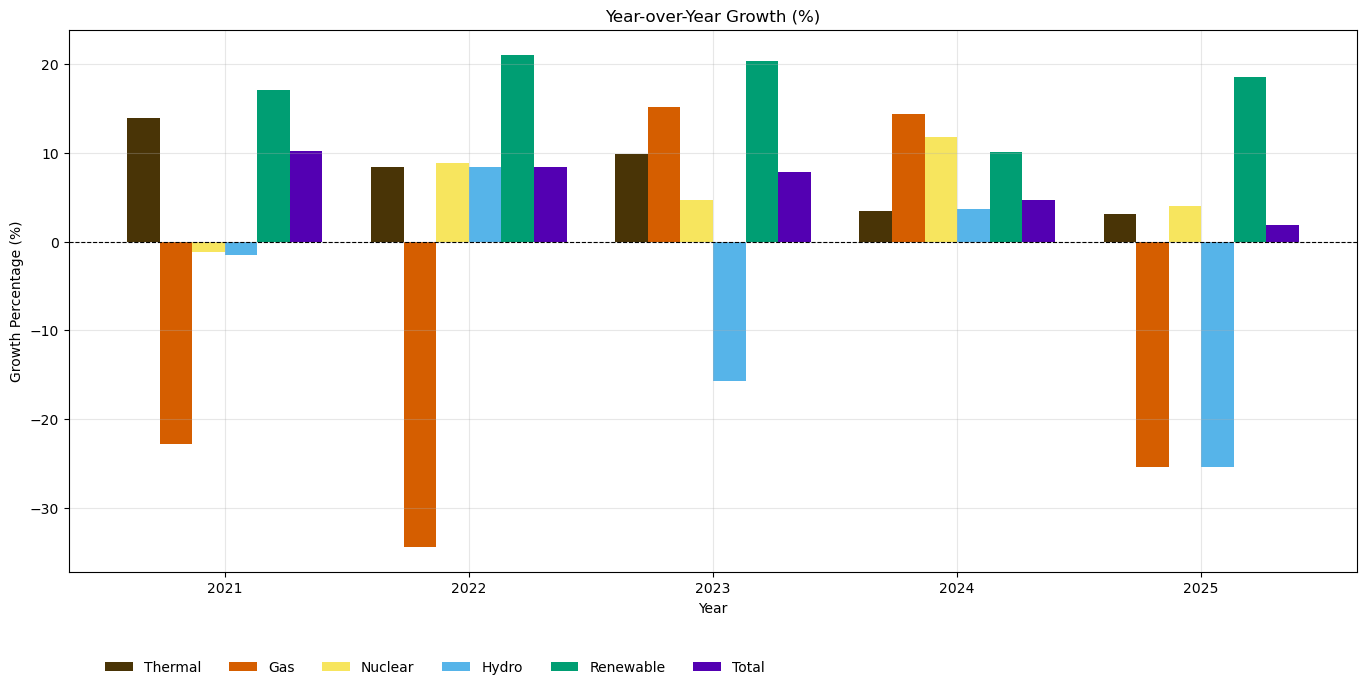


Year-over-Year Growth (%):
 year Thermal    Gas Nuclear  Hydro Renewable Total
 2021   13.9% -22.8%   -1.1%  -1.5%     17.1% 10.3%
 2022    8.5% -34.4%    8.8%   8.4%     21.1%  8.4%
 2023    9.9%  15.2%    4.7% -15.6%     20.3%  7.9%
 2024    3.5%  14.3%   11.8%   3.7%     10.1%  4.7%
 2025    3.2% -25.4%    4.1% -25.4%     18.6%  1.9%


In [109]:
plot_yoy_growth(
    df=grid_readings_table_pldf,
    sources=["thermal_generation", "gas_generation", "nuclear_generation", "hydro_generation", "renewable_generation", "total_generation"],
    plot_type="bar",
    figsize=(14, 7),
    show_table=True
)

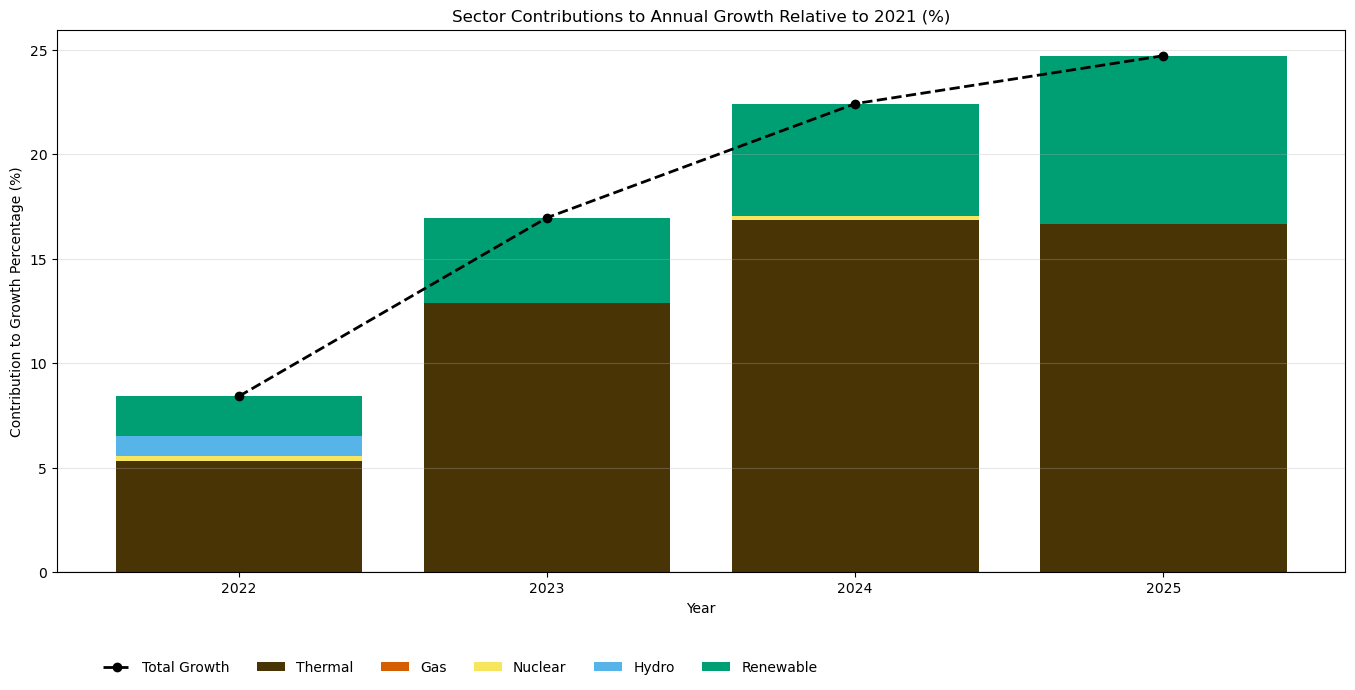


Sector Contributions to Growth Relative to 2021 (% of total):
 year Thermal   Gas Nuclear Hydro Renewable Total Growth
 2022    6.2% -0.9%    0.3%  1.0%      1.9%         8.4%
 2023   14.2% -0.7%    0.4% -1.0%      4.1%        17.0%
 2024   17.2% -0.4%    0.8% -0.6%      5.4%        22.4%
 2025   20.1% -1.0%    0.9% -3.4%      8.1%        24.7%


In [115]:
plot_growth_contributions(
    df=grid_readings_table_pldf,
    baseline_year=2021,
    figsize=(14, 7),
    show_table=True
)

#### Validating Emissions Calculations

We'll now validate the emissions calculations that we see in the table to ensure that everything looks reasonable

In [ ]:
display(
    grid_readings_table_pldf.head(n=1)
)  # Display the first 5 rows of the grid_readings table

shape: (1, 12)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ timestamp ┆ thermal_g ┆ gas_gener ┆ g_co2_per ┆ … ┆ total_gen ┆ tons_co2_ ┆ demand_me ┆ net_dema │
│ ---       ┆ eneration ┆ ation     ┆ _kwh      ┆   ┆ eration   ┆ per_mwh   ┆ t         ┆ nd       │
│ datetime[ ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ μs]       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2022-01-0 ┆ 136202.0  ┆ 2901.0    ┆ 815.57308 ┆ … ┆ 164327.0  ┆ 0.815573  ┆ 162948.0  ┆ 154427.0 │
│ 4         ┆           ┆           ┆ 8         ┆   ┆           ┆           ┆           ┆          │
│ 17:05:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [ ]:
thermal_generation = (grid_readings_table_pldf.select(pl.col(name="thermal_generation")).head(n=1).item())
gas_generation = (grid_readings_table_pldf.select(pl.col(name="gas_generation")).head(n=1).item())
hydro_generation = (grid_readings_table_pldf.select(pl.col(name="hydro_generation")).head(n=1).item())
nuclear_generation = (grid_readings_table_pldf.select(pl.col(name="nuclear_generation")).head(n=1).item())
renewable_generation = (grid_readings_table_pldf.select(pl.col(name="renewable_generation")).head(n=1).item())

print(f"\nFossil Fuel Generation: {thermal_generation + gas_generation:,} MW")

total_generation = (
    thermal_generation
    + gas_generation
    + hydro_generation
    + nuclear_generation
    + renewable_generation
)
print(f"\nTotal Generation (calculated): {total_generation:,} MW")

total_generation_from_table = (grid_readings_table_pldf.select(pl.col(name="total_generation")).head(n=1).item())
print(f"Total Generation (from table): {total_generation_from_table:,} MW")

emission_factor = (grid_readings_table_pldf.select(pl.col(name="tons_co2_per_mwh")).head(n=1).item())
print(f"\nEmission Factor (from table): {emission_factor:.3f} tons CO2/MWh")

calculated_emissions_all = total_generation * emission_factor
print(f"\nCalculated Total Emissions: {calculated_emissions_all:,.3f} tons CO2 (NOT adjusted for hour to 5-minute conversion)")
print(f"Calculated Total Emissions: {calculated_emissions_all / 12:,.3f} tons CO2 (adjusted for hour to 5-minute conversion)")
print(f"Total Emissions from table: {grid_readings_table_pldf.select(pl.col(name='tons_co2')).head(n=1).item():,.3f} tons CO2")


Fossil Fuel Generation: 139,103.0 MW

Total Generation (calculated): 164,327.0 MW
Total Generation (from table): 164,327.0 MW

Emission Factor (from table): 0.816 tons CO2/MWh

Calculated Total Emissions: 134,020.679 tons CO2 (NOT adjusted for hour to 5-minute conversion)
Calculated Total Emissions: 11,168.390 tons CO2 (adjusted for hour to 5-minute conversion)
Total Emissions from table: 11,168.390 tons CO2


From the above we can see that we obviously need to account for the difference in the time for the emission factor and the data collection.
* The emission factor is presented in tons of CO2 per mega-watt-**hour**
* The data is collected every **5 minutes** and represents generation rate/capacity over that time period
* Therefore we must include a / 12 in the calculations of emissions

This is an important point to keep in mind because this is a simple mistake easily overlooked during data aggregation, and could lead to incorrect results if not done properly.

We know from the documentation that the emission factors used are from 2018, so lets run a few reproducability tests here.
Note that we will be using the aggregate emission factors for each fuel source here. This is what the documentation on https://carbontracker.in/ says is used.

This is an important disctinction from using the per capacity emission factors which are broken down in the excel file in the "CDM – CO2 Baseline Database" found at <https://cea.nic.in/cdm-co2-baseline-database/?lang=en>

In [ ]:
# Emission factors for coal and gas for 2023 can be found here:  https://cea.nic.in/wp-content/uploads/2021/03/User_Guide_Version_20.0.pdf
# Coal = 0.969 tCO2/MWh,    Gas = 0.451 tCO2/MWh

# Emission factors for coal and gas for 2022 can be found here:  https://cea.nic.in/wp-content/uploads/2021/03/User_Guide_Version_19.0.pdf
# Coal = 0.978 tCO2/MWh,    Gas = 0.478 tCO2/MWh

# Emission factors for coal and gas for 2021 can be found here:  https://cea.nic.in/wp-content/uploads/2021/03/User_Guide_Version_18.0.pdf
# Coal = 0.975 tCO2/MWh,    Gas = 0.465 tCO2/MWh

# Emission factors for coal and gas for 2018 (stated in methodology as used for the table) can be found here: https://cea.nic.in/wp-content/uploads/baseline/2020/07/user_guide_ver14.pdf
# Coal = 0.97 tCO2/MWh,    Gas = 0.45 tCO2/MWh

In [ ]:
emission_factor_coal_2018 = 0.97  # Emission factor for coal in tCO2/MWh
emission_factor_gas_2018 = 0.45  # Emission for gas in tCO2/MWh

emission_factor_coal_2022 = 0.978  # Emission factor for coal in tCO2/MWh
emission_factor_gas_2022 = 0.478  # Emission for gas in tCO2/MWh

# Calculate the emissions for coal and gas
total_emissions_2018_factors = (thermal_generation * emission_factor_coal_2018) + (gas_generation * emission_factor_gas_2018)
total_emissions_2022_factors = (thermal_generation * emission_factor_coal_2022) + (gas_generation * emission_factor_gas_2022)

print(f"Total Emissions : {(total_emissions_2018_factors)/12:,.3f} tCO2  (calculated - 2018 factors)")
print(f"Total Emissions : {total_emissions_2022_factors/12:,.3f} tCO2  (calculated - 2022 factors)")
print(f"Total Emissions : {grid_readings_table_pldf.select(pl.col('tons_co2')).head(1).item():,.3f} tCO2  (from table)")

Total Emissions : 11,118.449 tCO2  (calculated - 2018 factors)
Total Emissions : 11,216.020 tCO2  (calculated - 2022 factors)
Total Emissions : 11,168.390 tCO2  (from table)


We certainly expect the emissions calculated using the 2022 emission factors to be different, but it is surprising to see that the 2018 factors are different. The values should be the exact same as we are using those exact values from the report. What we are instead noticing is that the emissions using the 2018 factors are undercounting.

Next steps - run some tests to calculate the emissions of every 5 minute period in the table using the 2018 annual emission factors, then compare this to the provided emissions.

The best practice would be to use the emission factors from the relevant year for calculations. But as the overall emissions do not appear to change much more than the recalculated verison in comparison to the original, this may not be a necessary change to get directional insights on where to reduce or shift consumption (our overall goal)

We'll now check the errors of our calculations.

In [ ]:
grid_readings_table_adjusted_pldf = grid_readings_table_pldf.with_columns(
    [
        (
            (
                (pl.col("thermal_generation") * emission_factor_coal_2018)
                + (pl.col("gas_generation") * emission_factor_gas_2018)
            )
            / 12
        ).alias("total_emissions_tCO2_2018_external_factors")
    ]
)

grid_readings_table_adjusted_pldf = grid_readings_table_adjusted_pldf.with_columns(
    [
        (
            pl.col("total_emissions_tCO2_2018_external_factors") - pl.col("tons_co2")
        ).alias("error"),
        (
            (pl.col("total_emissions_tCO2_2018_external_factors") - pl.col("tons_co2"))
            / pl.col("tons_co2")
        ).alias("error_ratio"),
    ]
)
# Display the first row of the adjusted grid readings table
grid_readings_table_adjusted_pldf.head(1)

shape: (1, 15)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ timestamp ┆ thermal_g ┆ gas_gener ┆ g_co2_per ┆ … ┆ net_deman ┆ total_emi ┆ error     ┆ error_ra │
│ ---       ┆ eneration ┆ ation     ┆ _kwh      ┆   ┆ d         ┆ ssions_tC ┆ ---       ┆ tio      │
│ datetime[ ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ O2_2018_e ┆ f64       ┆ ---      │
│ μs]       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ xte…      ┆           ┆ f64      │
│           ┆           ┆           ┆           ┆   ┆           ┆ ---       ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ f64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2022-01-0 ┆ 136202.0  ┆ 2901.0    ┆ 815.57308 ┆ … ┆ 154427.0  ┆ 11118.449 ┆ -49.94073 ┆ -0.00447 │
│ 4         ┆           ┆           ┆ 8         ┆   ┆           ┆ 167       ┆ 3         ┆ 2        │
│ 17:05:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [ ]:
# Now we'll plot the distribution of the error between the calculated emissions and the emissions from the table
error_series = grid_readings_table_adjusted_pldf.select(
    pl.col("error_ratio")
).to_series()
plt.figure(figsize=(10, 6))
plt.hist(error_series, bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Error (tCO2)")
plt.ylabel("Frequency")
plt.title("Distribution of Error Between Calculated Emissions and Emissions from Table")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Based on the above we can see that the error is in almost all cases less than 0.5%, so the impact of recalculation is relatively minor.
Based on this we can *relatively* safely ignore this error and put aside recalculations unless needed later.
It is worth noticing that all of the errors are negative, meaning that the calculated values are **less** than the provided values.

If adjustments were to be made in the future and take into account this comparison, the safest thing would be to systemically overcount rather than systemically undercount. A simple adding of 0.45% to each value could account for this discrepancy.

#### Recalculating Emissions Using Year-Specific Factors

We will likely not need the additional recalculation. 
But at the point of making this analysis I was waiting for additional data, and decided to create a framework for how to do it in case it was needed later.

We know from the documentation that emission factors used are from 2018.
But we have data from 2021, 2022 and 2023, so we should use the emission factors from those years to calculate the corresponding emissions.
We'll do that below here

In [ ]:
# Emission factors for coal and gas for 2023 can be found here:  https://cea.nic.in/wp-content/uploads/2021/03/User_Guide_Version_20.0.pdf
# Coal = 0.969 tCO2/MWh,    Gas = 0.451 tCO2/MWh

# Emission factors for coal and gas for 2022 can be found here:  https://cea.nic.in/wp-content/uploads/2021/03/User_Guide_Version_19.0.pdf
# Coal = 0.978 tCO2/MWh,    Gas = 0.478 tCO2/MWh

# Emission factors for coal and gas for 2021 can be found here:  https://cea.nic.in/wp-content/uploads/2021/03/User_Guide_Version_18.0.pdf
# Coal = 0.975 tCO2/MWh,    Gas = 0.465 tCO2/MWh

# Emission factors for coal and gas for 2020 can be found here:  https://cea.nic.in/wp-content/uploads/tpe___cc/2022/02/User_Guide__ver_17_2021.pdf
# Coal = 0.97 tCO2/MWh,    Gas = 0.42 tCO2/MWh


In [ ]:
thermal_gen_factors = {
    2023: 0.969,
    2022: 0.978,
    2021: 0.975,
    2020: 0.97,
}  # Emission factors for coal in tCO2/MWh
gas_gen_factors = {
    2023: 0.451,
    2022: 0.478,
    2021: 0.465,
    2020: 0.42,
}  # Emission factors for gas in tCO2/MWh

In [ ]:
# Apply the wrapper function
grid_readings_table_pldf = calculate_year_specific_emissions(
    grid_readings_table_pldf,
    thermal_factors=thermal_gen_factors,
    gas_factors=gas_gen_factors,
    interval_minutes=5
)

# Display results
display(grid_readings_table_pldf.head(5))

shape: (5, 17)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ timestamp ┆ thermal_g ┆ gas_gener ┆ g_co2_per ┆ … ┆ gas_emiss ┆ tonnes_CO ┆ CO2_diffe ┆ relative │
│ ---       ┆ eneration ┆ ation     ┆ _kwh      ┆   ┆ ion_facto ┆ 2_emissio ┆ rence     ┆ _CO2_dif │
│ datetime[ ┆ ---       ┆ ---       ┆ ---       ┆   ┆ r_tonnes_ ┆ ns_year_s ┆ ---       ┆ ference  │
│ μs]       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ CO2…      ┆ pec…      ┆ f64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ ---       ┆ ---       ┆           ┆ f64      │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆ f64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2022-01-0 ┆ 136202.0  ┆ 2901.0    ┆ 815.57308 ┆ … ┆ 0.478     ┆ 11216.019 ┆ 47.6296   ┆ 0.004265 │
│ 4         ┆           ┆           ┆ 8         ┆   ┆           ┆ 5         ┆           ┆          │
│ 17:05:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2022-01-0 ┆ 136202.0  ┆ 2901.0    ┆ 815.57308 ┆ … ┆ 0.478     ┆ 11216.019 ┆ 47.6296   ┆ 0.004265 │
│ 4         ┆           ┆           ┆ 8         ┆   ┆           ┆ 5         ┆           ┆          │
│ 17:10:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2022-01-0 ┆ 136202.0  ┆ 2901.0    ┆ 815.57308 ┆ … ┆ 0.478     ┆ 11216.019 ┆ 47.6296   ┆ 0.004265 │
│ 4         ┆           ┆           ┆ 8         ┆   ┆           ┆ 5         ┆           ┆          │
│ 17:15:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2022-01-0 ┆ 136202.0  ┆ 2901.0    ┆ 815.57308 ┆ … ┆ 0.478     ┆ 11216.019 ┆ 47.6296   ┆ 0.004265 │
│ 4         ┆           ┆           ┆ 8         ┆   ┆           ┆ 5         ┆           ┆          │
│ 17:20:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2022-01-0 ┆ 136202.0  ┆ 2901.0    ┆ 815.57308 ┆ … ┆ 0.478     ┆ 11216.019 ┆ 47.6296   ┆ 0.004265 │
│ 4         ┆           ┆           ┆ 8         ┆   ┆           ┆ 5         ┆           ┆          │
│ 17:25:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [ ]:
# Extract year from timestamp
grid_readings_table_pldf = grid_readings_table_pldf.with_columns(
    pl.col("timestamp").dt.year().alias("year")
)
# Add emission factors to grid_readings_table_pldf based on the year
grid_readings_table_pldf = grid_readings_table_pldf.with_columns(
    pl.col("timestamp").dt.year().alias("year"),  # Extract year directly from datetime
    (
        pl.when(pl.col(name="year") == 2020)
        .then(statement=thermal_gen_factors[2020])
        .when(pl.col(name="year") == 2021)
        .then(statement=thermal_gen_factors[2021])
        .when(pl.col(name="year") == 2022)
        .then(statement=thermal_gen_factors[2022])
        .when(pl.col(name="year") == 2023)
        .then(statement=thermal_gen_factors[2023])
        .otherwise(statement=thermal_gen_factors[2023])
    ).alias(name="thermal_emission_factor_tonnes_CO2_per_mwh"),
    (
        pl.when(pl.col(name="year") == 2020)
        .then(statement=gas_gen_factors[2020])
        .when(pl.col(name="year") == 2021)
        .then(statement=gas_gen_factors[2021])
        .when(pl.col(name="year") == 2022)
        .then(statement=gas_gen_factors[2022])
        .when(pl.col(name="year") == 2023)
        .then(statement=gas_gen_factors[2023])
        .otherwise(statement=gas_gen_factors[2023])
    ).alias(name="gas_emission_factor_tonnes_CO2_per_mwh"),
)

# Retrieve the unique values of the emission factors (we expect to see 2 because the data only covers 2022 and 2023)
unique_emission_factors = grid_readings_table_pldf.select(
    pl.col(name="thermal_emission_factor_tonnes_CO2_per_mwh")
    .unique()
    .alias(name="unique_thermal_emission_factors"),
    pl.col(name="gas_emission_factor_tonnes_CO2_per_mwh")
    .unique()
    .alias(name="unique_gas_emission_factors"),
)
print("\n" + "-" * 120)
print("Unique emission factors in 'grid_readings_table_pldf':\n" + "-" * 120)
print(unique_emission_factors)


------------------------------------------------------------------------------------------------------------------------
Unique emission factors in 'grid_readings_table_pldf':
------------------------------------------------------------------------------------------------------------------------
shape: (4, 2)
┌─────────────────────────────────┬─────────────────────────────┐
│ unique_thermal_emission_factor… ┆ unique_gas_emission_factors │
│ ---                             ┆ ---                         │
│ f64                             ┆ f64                         │
╞═════════════════════════════════╪═════════════════════════════╡
│ 0.969                           ┆ 0.42                        │
│ 0.97                            ┆ 0.451                       │
│ 0.975                           ┆ 0.465                       │
│ 0.978                           ┆ 0.478                       │
└─────────────────────────────────┴─────────────────────────────┘


In [ ]:
# Compute emission factors for each relevant year
grid_readings_table_pldf = grid_readings_table_pldf.with_columns(
    (
        pl.col(name="thermal_generation")
        * pl.col(name="thermal_emission_factor_tonnes_CO2_per_mwh")
        * (1 / 12)
    ).alias(
        name="thermal_emissions_tonnes_CO2"
    ),  # remember 1/12 is to adjust for 5-minute intervals
    (
        pl.col(name="gas_generation")
        * pl.col(name="gas_emission_factor_tonnes_CO2_per_mwh")
        * (1 / 12)
    ).alias(
        name="gas_emissions_tonnes_CO2"
    ),  # remember 1/12 is to adjust for 5-minute intervals
)

# Consolidate totals, differences, and drop unnecessary columns
grid_readings_table_pldf = grid_readings_table_pldf.with_columns(
    (
        (pl.col(name="thermal_emissions_tonnes_CO2") + pl.col(name="gas_emissions_tonnes_CO2"))
    ).alias(name="tonnes_CO2_emissions_year_specific"),
    (
        (pl.col(name="thermal_emissions_tonnes_CO2") + pl.col(name="gas_emissions_tonnes_CO2"))
        - pl.col(name="tons_co2")
    ).alias(name="CO2_difference"),
    (
        (
            (
                pl.col(name="thermal_emissions_tonnes_CO2")
                + pl.col(name="gas_emissions_tonnes_CO2")
            )
            - pl.col(name="tons_co2")
        )
        / pl.col(name="tons_co2")
    ).alias(name="relative_CO2_difference"),
).drop(["thermal_emissions_tonnes_CO2", "gas_emissions_tonnes_CO2", "year"])

# Display the first few rows of the adjusted grid readings table
display(grid_readings_table_pldf.head(5))

shape: (5, 17)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ timestamp ┆ thermal_g ┆ gas_gener ┆ g_co2_per ┆ … ┆ gas_emiss ┆ tonnes_CO ┆ CO2_diffe ┆ relative │
│ ---       ┆ eneration ┆ ation     ┆ _kwh      ┆   ┆ ion_facto ┆ 2_emissio ┆ rence     ┆ _CO2_dif │
│ datetime[ ┆ ---       ┆ ---       ┆ ---       ┆   ┆ r_tonnes_ ┆ ns_year_s ┆ ---       ┆ ference  │
│ μs]       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ CO2…      ┆ pec…      ┆ f64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ ---       ┆ ---       ┆           ┆ f64      │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆ f64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2022-01-0 ┆ 136202.0  ┆ 2901.0    ┆ 815.57308 ┆ … ┆ 0.478     ┆ 11216.019 ┆ 47.6296   ┆ 0.004265 │
│ 4         ┆           ┆           ┆ 8         ┆   ┆           ┆ 5         ┆           ┆          │
│ 17:05:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2022-01-0 ┆ 136202.0  ┆ 2901.0    ┆ 815.57308 ┆ … ┆ 0.478     ┆ 11216.019 ┆ 47.6296   ┆ 0.004265 │
│ 4         ┆           ┆           ┆ 8         ┆   ┆           ┆ 5         ┆           ┆          │
│ 17:10:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2022-01-0 ┆ 136202.0  ┆ 2901.0    ┆ 815.57308 ┆ … ┆ 0.478     ┆ 11216.019 ┆ 47.6296   ┆ 0.004265 │
│ 4         ┆           ┆           ┆ 8         ┆   ┆           ┆ 5         ┆           ┆          │
│ 17:15:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2022-01-0 ┆ 136202.0  ┆ 2901.0    ┆ 815.57308 ┆ … ┆ 0.478     ┆ 11216.019 ┆ 47.6296   ┆ 0.004265 │
│ 4         ┆           ┆           ┆ 8         ┆   ┆           ┆ 5         ┆           ┆          │
│ 17:20:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2022-01-0 ┆ 136202.0  ┆ 2901.0    ┆ 815.57308 ┆ … ┆ 0.478     ┆ 11216.019 ┆ 47.6296   ┆ 0.004265 │
│ 4         ┆           ┆           ┆ 8         ┆   ┆           ┆ 5         ┆           ┆          │
│ 17:25:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

#### **GRID READINGS DATA SUMMARY**

**Contains the following columns:**
* *timestamp (Datetime):* Timestamp of the observation (5-minute intervals)
* *thermal_generation (Float64):* Electricity generation from thermal (coal) sources (MW)
* *gas_generation (Float64):* Electricity generation from gas sources (MW)
* *g_co2_per_kwh (Float64):* Emissions intensity (gCO₂/kWh)
* *hydro_generation (Float64):* Electricity generation from hydro sources (MW)
* *nuclear_generation (Float64):* Electricity generation from nuclear sources (MW)
* *renewable_generation (Float64):* Electricity generation from renewable sources (MW)
* *tons_co2 (Float64):* CO₂ emissions in tons per 5-minute interval
* *total_generation (Float64):* Total SCADA-tracked generation on the grid (MW)
* *tons_co2_per_mwh (Float64):* Emissions intensity (tCO₂/MWh) — likely derived from tons_co2 / total_generation
* *demand_met (Float64):* Electricity demand met at state transmission grid boundaries (MW)
* *net_demand (Float64):* Calculated as total_generation - renewable_generation (MW); reflects supply from non-renewables

**Data Summary:**
* Granularity: 5-minute resolution across the dataset.
* Units:
    * All generation/demand variables are in megawatts (MW) and should be:
        * Averaged when aggregating over time (e.g., to hourly, daily).
        * Multiplied by time (e.g., MW × 5 minutes) to compute total energy (MWh).
    * Emissions (tons_co2) are per 5-minute window and should be summed over time to compute total emissions.
* Net Demand is technically a non-renewable supply metric, not actual demand.
    * See [documentation](https://carbontracker.in/) for more details.


**Daily Trends (Based on Sample Observations):**
* Renewable generation peaks around 12:00 noon, consistent with solar generation.
* Thermal and other fuels ramp up during non-peak renewable hours to meet demand.
* Hydro is relatively stable with a small evening increase.
* Nuclear is highly stable, fluctuating only ~±30 MW.
* Gas is also stable and small in contribution, similar to nuclear.


**Seasonal and Structural Observations:**
* Renewable generation is growing steadily, with a 90.3% increase from 2021 to 2025.
* Thermal generation remains dominant and continues to grow.
* Hydro and renewables show cyclical behavior, peaking in Q2–Q3 and dropping in Q1–Q4 (possibly seasonal weather effects).
* Gas generation has declined, while nuclear has slowly increased.
* Year-over-year trends show:
  * Consistent renewable growth (10–20% YoY)
  * Decline or variability in gas
  * Small and steady nuclear/hydro shifts
  * Slowing thermal growth after initial post-2020 rebound


**Daily and Seasonal Patterns**
* The data shows clear daily cycles with renewable generation peaking around noon and thermal sources ramping up during non-peak renewable hours
* Hydro and renewables demonstrate strong seasonal patterns, with peaks in Q2-Q3 and drops in Q1-Q4, suggesting weather-dependent generation

**Long-term Growth Trends**
* Renewable generation has shown consistent year-over-year growth (10-20% annually)
* Thermal generation remains dominant but shows slowing growth rates after an initial post-2020 rebound
* Notable 90.3% increase in renewable generation from 2021 to 2025

**Emissions Calculations Details**
* The emission factors used appear to be from 2018 (0.97 tCO2/MWh for coal, 0.45 tCO2/MWh for gas)
* When comparing calculated vs. provided emissions, there's a systematic difference of less than 0.5%
* The emissions in tons_co2 column reflect 5-minute intervals, requiring careful handling when aggregating


**Data Completeness**
* No null values detected across the dataset, making it ideal for modeling
* Continuous 5-minute resolution data spanning multiple years

**Source Contributions**
* Nuclear and gas generation are relatively stable contributors to the grid
* Thermal generation continues to contribute the largest portion to overall growth

**Generation Growth Relative to 2021 (% change)**
| Year | Thermal Generation (%) | Gas Generation (%) | Nuclear Generation (%) | Hydro Generation (%) | Renewable Generation (%) |
| ---- | ---------------------- | ------------------ | ---------------------- | -------------------- | ------------------------ |
| 2021 | 0.0                    | 0.0                | 0.0                    | 0.0                  | 0.0                      |
| 2022 | 8.5%                   | -34.4%             | 8.8%                   | 8.4%                 | 21.1%                    |
| 2023 | 19.2%                  | -24.5%             | 14.0%                  | -8.6%                | 45.7%                    |
| 2024 | 23.3%                  | -13.7%             | 27.4%                  | -5.1%                | 60.5%                    |
| 2025 | 27.2%                  | -35.6%             | 32.5%                  | -29.2%               | 90.3%                    |


**Year-over-Year Growth (%)**
| Year | Thermal | Gas    | Nuclear | Hydro  | Renewable | Total |
| ---- | ------- | ------ | ------- | ------ | --------- | ----- |
| 2021 | 13.9%   | -22.8% | -1.1%   | -1.5%  | 17.1%     | 10.3% |
| 2022 | 8.5%    | -34.4% | 8.8%    | 8.4%   | 21.1%     | 8.4%  |
| 2023 | 9.9%    | 15.2%  | 4.7%    | -15.6% | 20.3%     | 7.9%  |
| 2024 | 3.5%    | 14.3%  | 11.8%   | 3.7%   | 10.1%     | 4.7%  |
| 2025 | 3.2%    | -25.4% | 4.1%    | -25.4% | 18.6%     | 1.9%  |


**Sector Contributions to Growth Relative to 2021 (% of total):**
| Year | Thermal | Gas   | Nuclear | Hydro | Renewable | Total Growth |
| ---- | ------- | ----- | ------- | ----- | --------- | ------------ |
| 2022 | 6.2%    | -0.9% | 0.3%    | 1.0%  | 1.9%      | 8.4%         |
| 2023 | 14.2%   | -0.7% | 0.4%    | -1.0% | 4.1%      | 17.0%        |
| 2024 | 17.2%   | -0.4% | 0.8%    | -0.6% | 5.4%      | 22.4%        |
| 2025 | 20.1%   | -1.0% | 0.9%    | -3.4% | 8.1%      | 24.7%        |



### **Electricity Usage Data from 'meter_readings' table**

We know that we were only able to retrieve a portion of the data in the initial pulls from the 'step1_hitachi_data_retrieval.ipynb' notebook so there is no point in looking at change over time for this data.

The full data is segmented by year and was retrieved using the 'step1_hitachi_meter_reading_data_retrieval.py' script run on the HPC.

But the smaller dataset may be useful in some initial analyses.

#### Reduced Meter Readings Data : meter_readings_20250701_1318

In [ ]:
meter_readings_20250701_1318_filename = "meter_readings_20250701_1318"
meter_readings_20250701_1318_filepath = os.path.join(hitachi_data_directory, f"{meter_readings_20250701_1318_filename}.parquet")
meter_readings_20250701_1318_pldf = pl.read_parquet(source=meter_readings_20250701_1318_filepath)
print("Columns in meter_readings_20250701_1318 DataFrame:")
print(meter_readings_20250701_1318_pldf.columns)

Columns in meter_readings_20250701_1318 DataFrame:
['ca_id', 'date', 'value', 'city']


In [ ]:
print(f"The shape of 'meter_readings_20250701_1318_pldf' is {meter_readings_20250701_1318_pldf.shape}")  # Display the shape of the meter_readings table

 # Display the first 5 rows of the meter_readings table (reduced to 10 million rows)
print(f"\nLooking at the first few rows of the 'meter_readings_20250701_1318_pldf':")
display(meter_readings_20250701_1318_pldf.head(5))

# Display the summary statistics of the meter_readings table (reduced to 10 million rows)
print(f"\n Summary statistics of the 'meter_readings_20250701_1318_pldf':")
meter_readings_20250701_1318_pldf.describe()

The shape of 'meter_readings_20250701_1318_pldf' is (100000000, 4)

Looking at the first few rows of the 'meter_readings_20250701_1318_pldf':


shape: (5, 4)
┌─────────────┬─────────────────────┬───────┬───────┐
│ ca_id       ┆ date                ┆ value ┆ city  │
│ ---         ┆ ---                 ┆ ---   ┆ ---   │
│ str         ┆ datetime[μs]        ┆ f64   ┆ str   │
╞═════════════╪═════════════════════╪═══════╪═══════╡
│ 60020352153 ┆ 2021-12-10 08:30:00 ┆ 0.468 ┆ delhi │
│ 60009868526 ┆ 2021-12-10 08:30:00 ┆ 0.581 ┆ delhi │
│ 60008518627 ┆ 2021-12-10 08:30:00 ┆ 0.283 ┆ delhi │
│ 60002218950 ┆ 2021-12-10 08:30:00 ┆ 0.681 ┆ delhi │
│ 60028207193 ┆ 2021-12-10 08:30:00 ┆ 0.0   ┆ delhi │
└─────────────┴─────────────────────┴───────┴───────┘


 Summary statistics of the 'meter_readings_20250701_1318_pldf':


shape: (9, 5)
┌────────────┬─────────────┬────────────────────────────┬──────────┬───────────┐
│ statistic  ┆ ca_id       ┆ date                       ┆ value    ┆ city      │
│ ---        ┆ ---         ┆ ---                        ┆ ---      ┆ ---       │
│ str        ┆ str         ┆ str                        ┆ f64      ┆ str       │
╞════════════╪═════════════╪════════════════════════════╪══════════╪═══════════╡
│ count      ┆ 100000000   ┆ 100000000                  ┆ 1e8      ┆ 100000000 │
│ null_count ┆ 0           ┆ 0                          ┆ 0.0      ┆ 0         │
│ mean       ┆ null        ┆ 2021-12-16 17:44:56.931683 ┆ 0.159057 ┆ null      │
│ std        ┆ null        ┆ null                       ┆ 0.352425 ┆ null      │
│ min        ┆ 60000005516 ┆ 2021-12-10 08:30:00        ┆ 0.0      ┆ delhi     │
│ 25%        ┆ null        ┆ 2021-12-13 13:30:00        ┆ 0.018    ┆ null      │
│ 50%        ┆ null        ┆ 2021-12-16 18:00:00        ┆ 0.055    ┆ null      │
│ 75%        ┆ null        ┆ 2021-12-19 22:30:00        ┆ 0.131    ┆ null      │
│ max        ┆ 60029920000 ┆ 2021-12-23 02:30:00        ┆ 63.703   ┆ delhi     │
└────────────┴─────────────┴────────────────────────────┴──────────┴───────────┘

In [ ]:
# What is the temporal range of our dataset?
print("\n" + "-" * 120)
print(f"Temporal Range of the dataset:\n" + "-" * 120)

print(f"Time Start: {meter_readings_20250701_1318_pldf['date'].min()}")
print(f"Time End: {meter_readings_20250701_1318_pldf['date'].max()}")
total_days = (meter_readings_20250701_1318_pldf['date'].max() - meter_readings_20250701_1318_pldf['date'].min()).days + 1
print(f"Total number of days in the dataset: {total_days} days\n")



------------------------------------------------------------------------------------------------------------------------
Temporal Range of the dataset:
------------------------------------------------------------------------------------------------------------------------
Time Start: 2021-12-10 08:30:00
Time End: 2021-12-23 02:30:00
Total number of days in the dataset: 13 days



We have no null values thus far which is good news.
We only have data from about two weeks in 2022, but that is because we have reduced the size of our dataset to be able to fit into local memory on our computer.
After getting the full dataset from the HPC script runs, we will potentially evaluate how to reduce the size of this data.

But first lets analyse the information as we did with the other datasets.
We expect that the ca_id field will have the same attributes as the 'id' field from the *customers* table, and that the distribution of data across the two cities will follow that same ratio in the customers table as well. Roughly 70% in Dehli and 30% in Mumbai.

##### Unique Values, Completeness, and Distribution of Data

In [ ]:
## First we'll look at the number of unique values for each column in the meter_readings table

# Look at the unique values in the 'ca_id' column
print("\n" + "-" * 120)
print("Unique values in the 'ca_id' column of 'meter_readings_20250701_1318_pldf':\n"+ "-" * 120)
unique_ids = meter_readings_20250701_1318_pldf.select(pl.col("ca_id").unique().len())

# Display the number of unique IDs in the meter_readings table
print(f"Number of unique IDs in 'meter_readings_20250701_1318_pldf': {unique_ids.item()}")
# Display the total number of rows in the meter_readings table
print(f"(Reference) Total number of rows in 'meter_readings_20250701_1318_pldf': {meter_readings_20250701_1318_pldf.height}")

# Verifying the number of unique cities in the meter_readings table (we expect this to be 2)
unique_cities = meter_readings_20250701_1318_pldf.select(pl.col("city").unique().len())
print("\n" + "-" * 120)
print("Unique values in the 'city' column of 'meter_readings_20250701_1318_pldf':\n"+ "-" * 120)
# Display the number of unique cities in the meter_readings table
print(f"Number of unique cities in 'meter_readings_20250701_1318_pldf': {unique_cities.item()}")
display(meter_readings_20250701_1318_pldf.select(pl.col("city").unique().sort()))


------------------------------------------------------------------------------------------------------------------------
Unique values in the 'ca_id' column of 'meter_readings_20250701_1318_pldf':
------------------------------------------------------------------------------------------------------------------------
Number of unique IDs in 'meter_readings_20250701_1318_pldf': 164281
(Reference) Total number of rows in 'meter_readings_20250701_1318_pldf': 100000000

------------------------------------------------------------------------------------------------------------------------
Unique values in the 'city' column of 'meter_readings_20250701_1318_pldf':
------------------------------------------------------------------------------------------------------------------------
Number of unique cities in 'meter_readings_20250701_1318_pldf': 1


shape: (1, 1)
┌───────┐
│ city  │
│ ---   │
│ str   │
╞═══════╡
│ delhi │
└───────┘

We see that we only have 1 city instead of two. This is slightly unexpected, but not impossible as we know that we only retrieved a reduced dataset.

Lets look into this and see how many customers we have per city and what data they have.

In [ ]:
# How many customer per city do we have? (Delhi)
# 188315 customers in Delhi in total (from customers table)
customers_per_city_20250701_1318 = (
    meter_readings_20250701_1318_pldf.group_by("city")
    .agg(pl.col(name="ca_id").n_unique().alias(name="number_of_customers"))
    .with_columns(
        (pl.col(name="number_of_customers") / 188315 * 100)
        .round(decimals=2)
        .alias(name="percentage_of_customers")
    )
    .sort("number_of_customers", descending=True)
)

display(customers_per_city_20250701_1318)

shape: (1, 3)
┌───────┬─────────────────────┬─────────────────────────┐
│ city  ┆ number_of_customers ┆ percentage_of_customers │
│ ---   ┆ ---                 ┆ ---                     │
│ str   ┆ u32                 ┆ f64                     │
╞═══════╪═════════════════════╪═════════════════════════╡
│ delhi ┆ 164281              ┆ 87.24                   │
└───────┴─────────────────────┴─────────────────────────┘

Note that we only have 164,281 customers.

Based on the analysis done above on the customers table, we should have 188,315 in dehli (of which we have ~87%), but then also another 37,368 in Mumbai as well (so ~73% of the total [165,797/225,683]).
So with 100,000,000 rows of data, we are still only able to grab a fraction of one month out of 3 years. It is probably close to 2 years of full data spanning 3 calendar years, but still it's a shockingly small amount.

Now we look at number of readings per city

In [ ]:
# This code isn't really useful when not running on the full dataset, but we'll leave it here for reference

# Looking at distribution of readings per city
print("\n" + "-" * 120)
print("Distribution of readings per city in 'meter_readings_20250701_1318_pldf':\n"+ "-" * 120)
readings_per_city = (
    meter_readings_20250701_1318_pldf.group_by("city")
    .agg(pl.len().alias(name="number_of_readings"))
    .with_columns(
        (pl.col(name="number_of_readings") / pl.col(name="number_of_readings").sum() * 100)
        .round(decimals=2)
        .alias(name="percentage_of_readings")
    )
    .sort(by="number_of_readings", descending=True)
)
print(readings_per_city)


------------------------------------------------------------------------------------------------------------------------
Distribution of readings per city in 'meter_readings_20250701_1318_pldf':
------------------------------------------------------------------------------------------------------------------------
shape: (1, 3)
┌───────┬────────────────────┬────────────────────────┐
│ city  ┆ number_of_readings ┆ percentage_of_readings │
│ ---   ┆ ---                ┆ ---                    │
│ str   ┆ u32                ┆ f64                    │
╞═══════╪════════════════════╪════════════════════════╡
│ delhi ┆ 100000000          ┆ 100.0                  │
└───────┴────────────────────┴────────────────────────┘


In [ ]:
# Look at how much data per customer ID ('ca_id') we have in the meter_readings table
# again, if this is not run on the full dataset, this will not be very useful, but we'll leave it here for reference
print("\n" + "-" * 120)
print(
    "Distribution of readings per customer ID in 'meter_readings_20250701_1318_pldf':\n"
    + "-" * 120
)
readings_per_id = (
    meter_readings_20250701_1318_pldf.group_by("ca_id")
    .agg(pl.len().alias(name="number_of_readings"))
    .with_columns(
        (pl.col(name="number_of_readings") / pl.col(name="number_of_readings").sum() * 100)
        .round(decimals=5)
        .alias(name="percentage_of_readings")
    )
    .sort(by="number_of_readings", descending=True)
)
print(readings_per_id)


------------------------------------------------------------------------------------------------------------------------
Distribution of readings per customer ID in 'meter_readings_20250701_1318_pldf':
------------------------------------------------------------------------------------------------------------------------
shape: (164_281, 3)
┌─────────────┬────────────────────┬────────────────────────┐
│ ca_id       ┆ number_of_readings ┆ percentage_of_readings │
│ ---         ┆ ---                ┆ ---                    │
│ str         ┆ u32                ┆ f64                    │
╞═════════════╪════════════════════╪════════════════════════╡
│ 60000270185 ┆ 613                ┆ 0.00061                │
│ 60023967742 ┆ 613                ┆ 0.00061                │
│ 60025020052 ┆ 613                ┆ 0.00061                │
│ 60029805003 ┆ 613                ┆ 0.00061                │
│ 60018846547 ┆ 613                ┆ 0.00061                │
│ …           ┆ …                  ┆

In [ ]:
# First ensure consistent daily granularity
meter_readings_20250701_1318_pldf = meter_readings_20250701_1318_pldf.with_columns(
    pl.col(name="date")
    .dt.date()
    .alias(name="date_day")  # Convert to date type for daily granularity
)

# Calculate global start and end dates
date_range = meter_readings_20250701_1318_pldf.select(
    [
        pl.col(name="date_day").min().alias(name="global_start"),
        pl.col(name="date_day").max().alias(name="global_end"),
    ]
).to_dict(as_series=False)

# Store total number of days in the global date range (+1 to include both start and end dates)
global_days = (date_range["global_end"][0] - date_range["global_start"][0]).days + 1

# Calculate the number of days each customer has data for (their 'customer_lifetime' in the dataset)
customer_lifetimes = (
    meter_readings_20250701_1318_pldf.group_by("ca_id")
    .agg(
        [
            pl.col("date_day").min().alias("start_date"),
            pl.col("date_day").max().alias("end_date"),
        ]
    )
    .with_columns(
        (pl.col("end_date") - pl.col("start_date") + pl.duration(days=1))
        .dt.total_days()
        .alias("customer_lifetime_days")
    )
)
print("\n" + "-" * 120)
print("Customer lifetimes in 'meter_readings_table_pldf_reduced':\n" + "-" * 120)
print(customer_lifetimes.sort("customer_lifetime_days", descending=True))


------------------------------------------------------------------------------------------------------------------------
Customer lifetimes in 'meter_readings_table_pldf_reduced':
------------------------------------------------------------------------------------------------------------------------
shape: (164_281, 4)
┌─────────────┬────────────┬────────────┬────────────────────────┐
│ ca_id       ┆ start_date ┆ end_date   ┆ customer_lifetime_days │
│ ---         ┆ ---        ┆ ---        ┆ ---                    │
│ str         ┆ date       ┆ date       ┆ i64                    │
╞═════════════╪════════════╪════════════╪════════════════════════╡
│ 60018760441 ┆ 2021-12-10 ┆ 2021-12-23 ┆ 14                     │
│ 60006809127 ┆ 2021-12-10 ┆ 2021-12-23 ┆ 14                     │
│ 60003105008 ┆ 2021-12-10 ┆ 2021-12-23 ┆ 14                     │
│ 60011406810 ┆ 2021-12-10 ┆ 2021-12-23 ┆ 14                     │
│ 60003737974 ┆ 2021-12-10 ┆ 2021-12-23 ┆ 14                     │
│ …     

In [ ]:
# Analyse the compleness of customer data based on the customer lifetime and the global date range
# This metric is then stored as a percentage of the total number of days in the global date range (customer_completeness_global) and in the customer lifetime (customer_completeness_local)
customer_data_completeness = (
    meter_readings_20250701_1318_pldf.group_by("ca_id")
    .agg(
        [
            pl.col(name="date_day")
            .n_unique()
            .alias(
                name="active_days"
            ),  # Count of unique days with readings  - needed to avoid double counting
            pl.col(name="date_day").min().alias("start_date"),
            pl.col(name="date_day").max().alias("end_date"),
        ]
    )
    .with_columns(
        [
            (pl.col(name="end_date") - pl.col("start_date") + pl.duration(days=1))
            .dt.total_days()
            .alias(name="lifetime_days"),
            (
                pl.col(name="active_days")
                / (
                    (
                        pl.col(name="end_date") - pl.col("start_date") + pl.duration(days=1)
                    ).dt.total_days()
                )
                * 100
            )
            .round(decimals=2)
            .alias(name="customer_completeness_local"),
            (pl.col(name="active_days") / global_days * 100)
            .round(decimals=2)
            .alias(name="customer_completeness_global"),
        ]
    )
    .drop(["active_days"])
)
print("\n" + "-" * 120)
print("Customer data completeness in 'meter_readings_table_pldf_reduced':\n" + "-" * 120)
print("--> Sorted by customer lifetime (in days) ⬆️\n" + "-" * 120)
print(customer_data_completeness.sort("lifetime_days", descending=False))
print("\n" + "-" * 120)
print("--> Sorted by customer completeness (global) ⬇️\n" + "-" * 120)
print(customer_data_completeness.sort("customer_completeness_global", descending=True))
print("\n" + "-" * 120)
print("--> Sorted by customer completeness (local) ⬇️\n" + "-" * 120)
print(customer_data_completeness.sort("customer_completeness_local", descending=True))


------------------------------------------------------------------------------------------------------------------------
Customer data completeness in 'meter_readings_table_pldf_reduced':
------------------------------------------------------------------------------------------------------------------------
--> Sorted by customer lifetime (in days) ⬆️
------------------------------------------------------------------------------------------------------------------------
shape: (164_281, 6)
┌─────────────┬────────────┬────────────┬───────────────┬─────────────────────┬────────────────────┐
│ ca_id       ┆ start_date ┆ end_date   ┆ lifetime_days ┆ customer_completene ┆ customer_completen │
│ ---         ┆ ---        ┆ ---        ┆ ---           ┆ ss_local            ┆ ess_global         │
│ str         ┆ date       ┆ date       ┆ i64           ┆ ---                 ┆ ---                │
│             ┆            ┆            ┆               ┆ f64                 ┆ f64                │

##### Completeness By Month

In [ ]:
meter_readings_20250701_1318_pldf = meter_readings_20250701_1318_pldf.with_columns(
    pl.col(name="date_day").dt.strftime(format="%Y-%m").alias(name="month"),
)

In [ ]:
# Compute days in month for each year-month in dataset
unique_months = (
    meter_readings_20250701_1318_pldf.select("month").unique().to_series().to_list()
)
month_days = [
    {"month": m, "days_in_month": calendar.monthrange(year=int(m[:4]), month=int(m[5:]))[1]}
    for m in unique_months
]
month_days_df = pl.DataFrame(data=month_days)

# Count readings per customer per month
meter_readings_monthly_completeness = (
    meter_readings_20250701_1318_pldf.group_by(["ca_id", "month"])
    .agg(pl.col(name="date_day").n_unique().alias("active_days_in_month"))
    .join(other=month_days_df, on="month", how="left")
    .with_columns(
        (pl.col(name="active_days_in_month") / pl.col("days_in_month") * 100)
        .round(decimals=2)
        .alias(name="naive_monthly_completeness")
    )
)

print("\n" + "-" * 120)
print("Monthly completeness of meter readings in 'meter_readings_20250701_1318_pldf':\n" + "-" * 120)
print(meter_readings_monthly_completeness.sort(by="naive_monthly_completeness", descending=True))


------------------------------------------------------------------------------------------------------------------------
Monthly completeness of meter readings in 'meter_readings_20250701_1318_pldf':
------------------------------------------------------------------------------------------------------------------------
shape: (164_281, 5)
┌─────────────┬─────────┬──────────────────────┬───────────────┬────────────────────────────┐
│ ca_id       ┆ month   ┆ active_days_in_month ┆ days_in_month ┆ naive_monthly_completeness │
│ ---         ┆ ---     ┆ ---                  ┆ ---           ┆ ---                        │
│ str         ┆ str     ┆ u32                  ┆ i64           ┆ f64                        │
╞═════════════╪═════════╪══════════════════════╪═══════════════╪════════════════════════════╡
│ 60008748422 ┆ 2021-12 ┆ 14                   ┆ 31            ┆ 45.16                      │
│ 60004435685 ┆ 2021-12 ┆ 14                   ┆ 31            ┆ 45.16                      │


In [ ]:
# Get start and end per customer
customer_lifetimes = meter_readings_20250701_1318_pldf.group_by("ca_id").agg(
    [
        pl.col(name="date_day").min().alias(name="start_date"),
        pl.col(name="date_day").max().alias(name="end_date"),
    ]
)

# Add first and last date of month to the month_days_df
month_days_df = month_days_df.with_columns(
    [
        pl.col(name="month").str.to_date(format="%Y-%m").alias(name="month_start"),
        (
            pl.col(name="month").str.to_date(format="%Y-%m")
            + pl.duration(days=pl.col(name="days_in_month"))
            - pl.duration(days=1)
        ).alias("month_end"),
    ]
)

# Join counts with month + customer metadata
# This may be blank when you run it on a reduced dataset.
meter_readings_monthly_completeness_existing_customers = (
    meter_readings_monthly_completeness.join(other=customer_lifetimes, on="ca_id", how="left")
    .join(other=month_days_df, on="month", how="left")
    .filter(
        (pl.col(name="start_date") < pl.col(name="month_start"))
        & (pl.col(name="end_date") > pl.col(name="month_end"))
    )
    .with_columns(
        (pl.col(name="active_days_in_month") / pl.col(name="days_in_month") * 100)
        .round(decimals=2)
        .alias(name="monthly_completeness_filtered")
    )
)

In [ ]:
print("\n" + "-" * 120)
print("Monthly completeness for fully-active customers in 'meter_readings_table_pldf_reduced':\n" + "-" * 120)
print(meter_readings_monthly_completeness_existing_customers.sort(by="monthly_completeness_filtered", descending=True))
print("(Note : Only includes customers whose start and end dates cover the entire month.)")


------------------------------------------------------------------------------------------------------------------------
Monthly completeness for fully-active customers in 'meter_readings_table_pldf_reduced':
------------------------------------------------------------------------------------------------------------------------
shape: (0, 11)
┌───────┬───────┬─────────────┬─────────────┬───┬────────────┬────────────┬───────────┬────────────┐
│ ca_id ┆ month ┆ active_days ┆ days_in_mon ┆ … ┆ days_in_mo ┆ month_star ┆ month_end ┆ monthly_co │
│ ---   ┆ ---   ┆ _in_month   ┆ th          ┆   ┆ nth_right  ┆ t          ┆ ---       ┆ mpleteness │
│ str   ┆ str   ┆ ---         ┆ ---         ┆   ┆ ---        ┆ ---        ┆ date      ┆ _filtered  │
│       ┆       ┆ u32         ┆ i64         ┆   ┆ i64        ┆ date       ┆           ┆ ---        │
│       ┆       ┆             ┆             ┆   ┆            ┆            ┆           ┆ f64        │
╞═══════╪═══════╪═════════════╪═════════════╪═══

In [ ]:
# Cleaning up the meter readings table by dropping unnecessary columns
meter_readings_20250701_1318_pldf = meter_readings_20250701_1318_pldf.drop(
    ["month", "date_day"]
)

##### Value Structures and Attributes

In [ ]:
display(meter_readings_20250701_1318_pldf.head(2))

shape: (2, 4)
┌─────────────┬─────────────────────┬───────┬───────┐
│ ca_id       ┆ date                ┆ value ┆ city  │
│ ---         ┆ ---                 ┆ ---   ┆ ---   │
│ str         ┆ datetime[μs]        ┆ f64   ┆ str   │
╞═════════════╪═════════════════════╪═══════╪═══════╡
│ 60020352153 ┆ 2021-12-10 08:30:00 ┆ 0.468 ┆ delhi │
│ 60009868526 ┆ 2021-12-10 08:30:00 ┆ 0.581 ┆ delhi │
└─────────────┴─────────────────────┴───────┴───────┘

##### 'ca_id' column

We know that the contents of the 'ca_id' column should be the same as the 'id' column in the 'customers' table, so we don't need to do a full analysis on what this column is. But it will be helpful to check consistency

In [ ]:
# ID column
id_lengths = meter_readings_20250701_1318_pldf.select(pl.col(name="ca_id").str.len_bytes().alias(name="ca_id_length")).to_series()

print("\n" + "-" * 120)
print(f"Count of 'ca_id' values by length in 'meter_readings_20250701_1318_pldf':\n" + "-" * 120)
print(id_lengths.value_counts().sort(by="ca_id_length"))


------------------------------------------------------------------------------------------------------------------------
Count of 'ca_id' values by length in 'meter_readings_20250701_1318_pldf':
------------------------------------------------------------------------------------------------------------------------
shape: (1, 2)
┌──────────────┬───────────┐
│ ca_id_length ┆ count     │
│ ---          ┆ ---       │
│ u32          ┆ u32       │
╞══════════════╪═══════════╡
│ 11           ┆ 100000000 │
└──────────────┴───────────┘


In [ ]:
# Check the city associated with all the prefixes of 'ca_id' values in the meter_readings table
print("\n" + "-" * 120)
print(f"City associated with prefixes of 'ca_id' values in 'meter_readings_20250701_1318_pldf':\n" + "-" * 120)
print(
    meter_readings_20250701_1318_pldf.select(
        pl.col(name="ca_id").str.slice(0, 3).alias(name="ca_id_prefix"), "city"
    )
    .group_by("ca_id_prefix")
    .agg(pl.col(name="city").unique().alias(name="cities"))
    .sort(by="ca_id_prefix")
)

# Check the city associated with the length of the 'ca_id' values in the meter_readings table
print("\n" + "-" * 120)
print(f"City associated with length of 'ca_id' values in 'meter_readings_20250701_1318_pldf':\n" + "-" * 120)
print(
    meter_readings_20250701_1318_pldf.select(
        pl.col(name="ca_id").str.len_bytes().alias(name="ca_id_length"), "city"
    )
    .group_by("ca_id_length")
    .agg(pl.col(name="city").unique().alias(name="cities"))
    .sort(by="ca_id_length")
)


------------------------------------------------------------------------------------------------------------------------
City associated with prefixes of 'ca_id' values in 'meter_readings_20250701_1318_pldf':
------------------------------------------------------------------------------------------------------------------------
shape: (1, 2)
┌──────────────┬───────────┐
│ ca_id_prefix ┆ cities    │
│ ---          ┆ ---       │
│ str          ┆ list[str] │
╞══════════════╪═══════════╡
│ 600          ┆ ["delhi"] │
└──────────────┴───────────┘

------------------------------------------------------------------------------------------------------------------------
City associated with length of 'ca_id' values in 'meter_readings_20250701_1318_pldf':
------------------------------------------------------------------------------------------------------------------------
shape: (1, 2)
┌──────────────┬───────────┐
│ ca_id_length ┆ cities    │
│ ---          ┆ ---       │
│ u32          ┆ list[

This matches exactly what we saw when analysing the customer table as we expect

##### 'value' column


------------------------------------------------------------------------------------------------------------------------
Minimum :		0.0		Maximum :		63.703

Mean :			0.15906
Median :		0.055
Mode :			0.0

Standard deviation :	0.35243
------------------------------------------------------------------------------------------------------------------------


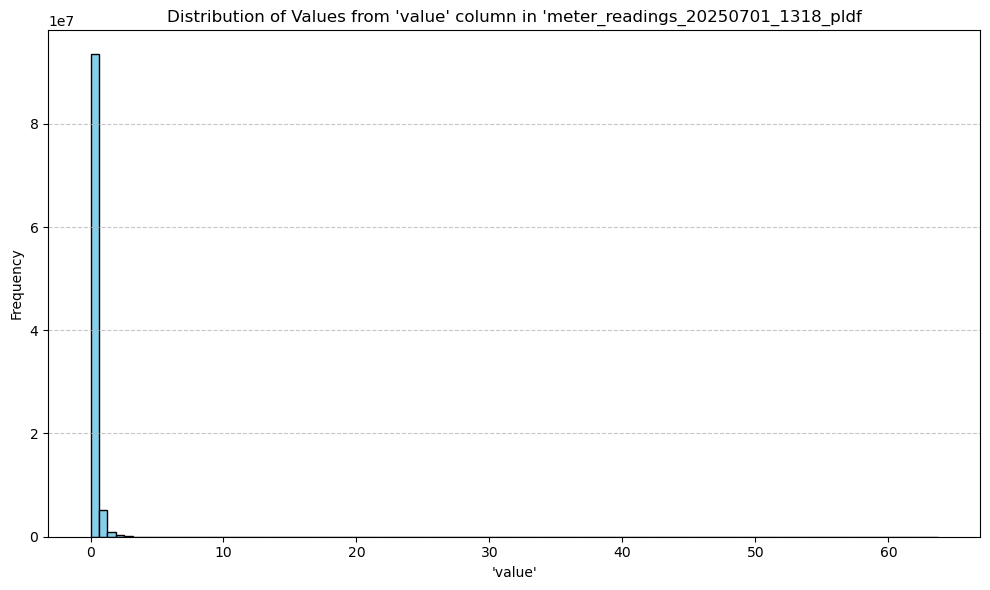

In [ ]:
# lets look at the distribution of the values contained 'value' column.
values = meter_readings_20250701_1318_pldf.select(pl.col("value")).to_series()
print("\n" + "-" * 120)
print(f"Minimum :\t\t{values.min()}\t\tMaximum :\t\t{values.max()}\n")
print(f"Mean :\t\t\t{values.mean():.5f}")
print(f"Median :\t\t{values.median()}")
print(f"Mode :\t\t\t{values.mode()[0]}\n")
print(f"Standard deviation :\t{values.std():.5f}")
print("-" * 120)

# Plot a histogram of the values in the 'value' column
plt.figure(figsize=(10, 6))
plt.hist(x=values, bins=100, color="skyblue", edgecolor="black")
plt.xlabel(xlabel="'value'")
plt.ylabel(ylabel="Frequency")
plt.title(
    label="Distribution of Values from 'value' column in 'meter_readings_20250701_1318_pldf"
)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Looks like there are a lot of 0 values. It will be interesting to look at the full dataset and see if this is the case. Also, it may be interesting to look at aggregations by the hour to see if those 0's are eliminated.

After this aggregation, it may also be useful to look at a gap analysis similar to what was done with the weather data originally.

#### Yearly Meter Readings Data

In [ ]:
# Defining filenames
meter_readings_2021_filename = "meter_readings_2021_20250714_2015"
meter_readings_2022_filename = "meter_readings_2022_20250714_2324"
meter_readings_2023_filename = "meter_readings_2023_20250714_2039"


meter_readings_2021_formatted_filename = "meter_readings_2021_20250714_2015_formatted"
meter_readings_2022_formatted_filename = "meter_readings_2022_20250714_2324_formatted"
meter_readings_2023_formatted_filename = "meter_readings_2023_20250714_2039_formatted"


meter_readings_delhi_2021_filename = "meter_readings_delhi_2021_20250714_2015_formatted"
meter_readings_delhi_2022_filename = "meter_readings_delhi_2022_20250714_2324_formatted"
# Note that a 2023 file for Delhi does not exist in the provided context

# Note that a 2021 file for Mumbai does not exist in the provided context
meter_readings_mumbai_2022_filename = "meter_readings_mumbai_2022_20250714_2324_formatted"
meter_readings_mumbai_2023_filename = "meter_readings_mumbai_2023_20250714_2039_formatted"

In [ ]:
# Defining filepaths
meter_readings_2021_filepath = os.path.join(meter_save_directory, meter_readings_2021_filename + ".parquet")
meter_readings_2022_filepath = os.path.join(meter_save_directory, meter_readings_2022_filename + ".parquet")
meter_readings_2023_filepath = os.path.join(meter_save_directory, meter_readings_2023_filename + ".parquet")

meter_readings_2021_formatted_filepath = os.path.join(meter_save_directory, meter_readings_2021_formatted_filename + ".parquet")
meter_readings_2022_formatted_filepath = os.path.join(meter_save_directory, meter_readings_2022_formatted_filename + ".parquet")
meter_readings_2023_formatted_filepath = os.path.join(meter_save_directory, meter_readings_2023_formatted_filename + ".parquet")

meter_readings_delhi_2021_filepath = os.path.join(meter_save_directory, meter_readings_delhi_2021_filename + ".parquet")
meter_readings_delhi_2022_filepath = os.path.join(meter_save_directory, meter_readings_delhi_2022_filename + ".parquet")
# Note that a 2023 file for Delhi does not exist in the provided context

# Note that a 2021 file for Mumbai does not exist in the provided context
meter_readings_mumbai_2022_filepath = os.path.join(meter_save_directory, meter_readings_mumbai_2022_filename + ".parquet")
meter_readings_mumbai_2023_filepath = os.path.join(meter_save_directory, meter_readings_mumbai_2023_filename + ".parquet")


In [ ]:
file_paths = [
    meter_readings_2021_formatted_filepath,
    meter_readings_2022_formatted_filepath,
    meter_readings_2023_formatted_filepath,
    meter_readings_delhi_2021_filepath,
    meter_readings_delhi_2022_filepath,
    meter_readings_mumbai_2022_filepath,
    meter_readings_mumbai_2023_filepath,
]

In [ ]:
meter_readings_2021_pldf = pl.read_parquet(source=meter_readings_2021_filepath)

# Check data types
print("\nData types in 'meter_readings_2021_pldf':")
print(meter_readings_2021_pldf.dtypes)
print(meter_readings_2021_pldf.schema)



Data types in 'meter_readings_2021_pldf':
[Int64, String, Float64, String]
Schema([('ca_id', Int64), ('date', String), ('value', Float64), ('city', String)])


In [ ]:
print("\n" + "-" * 120)
print("Date Range Analysis for Meter Readings Files:\n" + "-" * 120)

for file in file_paths:
    print(f"Processing {os.path.basename(file)}...")
    min_date, max_date = get_date_range_lazy(file)
    if min_date and max_date:
        print(f"\tDate range: {min_date} to {max_date}")
    else:
        print("\tERROR: Could not determine date range for this file.")
    print()


------------------------------------------------------------------------------------------------------------------------
Date Range Analysis for Meter Readings Files:
------------------------------------------------------------------------------------------------------------------------
Processing meter_readings_2021_20250714_2015_formatted.parquet...
	Date range: 2021-12-01 00:00:00 to 2021-12-31 23:30:00

Processing meter_readings_2022_20250714_2324_formatted.parquet...
	Date range: 2022-01-01 00:00:00 to 2022-12-31 23:30:00

Processing meter_readings_2023_20250714_2039_formatted.parquet...
	Date range: 2023-01-01 00:00:00 to 2023-03-28 00:00:00

Processing meter_readings_delhi_2021_20250714_2015_formatted.parquet...
	Date range: 2021-12-01 00:00:00 to 2021-12-31 23:30:00

Processing meter_readings_delhi_2022_20250714_2324_formatted.parquet...
	Date range: 2022-01-01 00:00:00 to 2022-12-31 08:30:00

Processing meter_readings_mumbai_2022_20250714_2324_formatted.parquet...
	Date range

Based on the above we can conclude that the total temporal range of the dataset is 2021-12-01 to 2023-03-28, but this range varies depending on the city.

* **Delhi** has data from 2021-12-01 until 2022-12-12-31 , a little over a year's worth of data

* **Mumbai** has data from 2022-09-28 until 2023-03-28, half of a year's worth of data 

We now have to be slightly careful with how we process this data. Because the data is so large it can cause the kernel to crash.
You may need to restart the kernel or access a machine with more processing power to rerun this part of the analysis

In [ ]:
print("\n" + "-" * 120)
print("Summary Analysis of 2021 Data :\n" + "-" * 120)
unique_ca_ids21, unique_cities21, total_rows21, unique_cities_list21 = summarize_meter_readings_lazy(file_path=meter_readings_2021_filepath)
print(f"Unique Customer Ids: {unique_ca_ids21:,}")
print(f"Unique Cities: {unique_cities21:,}")
print(f"Total Rows: {total_rows21:,}")
print(f"Unique Cities List: {unique_cities_list21}")


------------------------------------------------------------------------------------------------------------------------
Summary Analysis of 2021 Data :
------------------------------------------------------------------------------------------------------------------------


Unique Customer Ids: 165,077
Unique Cities: 1
Total Rows: 243,195,781
Unique Cities List: ['delhi']


In [ ]:
print("\n" + "-" * 120)
print("Summary Analysis of 2022 Data :\n" + "-" * 120)
unique_ca_ids22, unique_cities22, total_rows22, unique_cities_list22 = summarize_meter_readings_lazy(file_path=meter_readings_2022_filepath)
print(f"Unique Customer Ids: {unique_ca_ids22:,}")
print(f"Unique Cities: {unique_cities22:,}")
print(f"Total Rows: {total_rows22:,}")
print(f"Unique Cities List: {unique_cities_list22}")


------------------------------------------------------------------------------------------------------------------------
Summary Analysis of 2022 Data :
------------------------------------------------------------------------------------------------------------------------
Unique Customer Ids: 228,234
Unique Cities: 2
Total Rows: 1,223,040,456
Unique Cities List: ['mumbai', 'delhi']


In [ ]:
print("\n" + "-" * 120)
print("Summary Analysis of 2023 Data :\n" + "-" * 120)
unique_ca_ids23, unique_cities23, total_rows23, unique_cities_list23 = summarize_meter_readings_lazy(file_path=meter_readings_2023_filepath)
print(f"Unique Customer Ids: {unique_ca_ids23:,}")
print(f"Unique Cities: {unique_cities23:,}")
print(f"Total Rows: {total_rows23:,}")
print(f"Unique Cities List: {unique_cities_list23}")


------------------------------------------------------------------------------------------------------------------------
Summary Analysis of 2023 Data :
------------------------------------------------------------------------------------------------------------------------
Unique Customer Ids: 53,796
Unique Cities: 1
Total Rows: 189,094,063
Unique Cities List: ['mumbai']


As we can see above, and as the files above indicate, the data is spread across 2021, 2022, and 2023, with the majority in 2022.

Also the majority of data appears to be coming from Delhi.
We know that the 2021 data is only December and contains data only from Delhi.
We also know that the 2023 data is January through March and contains data only for Mumbai. 
As the 2023 data contains less that 33% of the data in the 2021 data, despite spanning 2 more months, we can assume that the majority of data is coming from Delhi.

##### Yearly Readings Per City and Per Customer, and Customer Lifetimes

In [ ]:
print("\n" + "-" * 120)
print("2021 Data : Readings Per City \n" + "-" * 120)
rpci_21 = analyze_readings_per_city_lazy(meter_readings_2021_filepath)
display(rpci_21.head(8))
display(rpci_21.describe())


------------------------------------------------------------------------------------------------------------------------
2021 Data : Readings Per City 
------------------------------------------------------------------------------------------------------------------------


shape: (1, 3)
┌───────┬────────────────────┬────────────────────────┐
│ city  ┆ number_of_readings ┆ percentage_of_readings │
│ ---   ┆ ---                ┆ ---                    │
│ str   ┆ u32                ┆ f64                    │
╞═══════╪════════════════════╪════════════════════════╡
│ delhi ┆ 243195781          ┆ 100.0                  │
└───────┴────────────────────┴────────────────────────┘

shape: (9, 4)
┌────────────┬───────┬────────────────────┬────────────────────────┐
│ statistic  ┆ city  ┆ number_of_readings ┆ percentage_of_readings │
│ ---        ┆ ---   ┆ ---                ┆ ---                    │
│ str        ┆ str   ┆ f64                ┆ f64                    │
╞════════════╪═══════╪════════════════════╪════════════════════════╡
│ count      ┆ 1     ┆ 1.0                ┆ 1.0                    │
│ null_count ┆ 0     ┆ 0.0                ┆ 0.0                    │
│ mean       ┆ null  ┆ 2.43195781e8       ┆ 100.0                  │
│ std        ┆ null  ┆ null               ┆ null                   │
│ min        ┆ delhi ┆ 2.43195781e8       ┆ 100.0                  │
│ 25%        ┆ null  ┆ 2.43195781e8       ┆ 100.0                  │
│ 50%        ┆ null  ┆ 2.43195781e8       ┆ 100.0                  │
│ 75%        ┆ null  ┆ 2.43195781e8       ┆ 100.0                  │
│ max        ┆ delhi ┆ 2.43195781e8       ┆ 100.0                  │
└────────────┴───────┴────────────────────┴────────────────────────┘

In [ ]:
print("\n" + "-" * 120)
print("2022 Data : Readings Per City \n" + "-" * 120)
rpci_22 = analyze_readings_per_city_lazy(meter_readings_2022_filepath)
display(rpci_22.head(8))
display(rpci_22.describe())


------------------------------------------------------------------------------------------------------------------------
2022 Data : Readings Per City 
------------------------------------------------------------------------------------------------------------------------


shape: (2, 3)
┌────────┬────────────────────┬────────────────────────┐
│ city   ┆ number_of_readings ┆ percentage_of_readings │
│ ---    ┆ ---                ┆ ---                    │
│ str    ┆ u32                ┆ f64                    │
╞════════╪════════════════════╪════════════════════════╡
│ delhi  ┆ 1100253784         ┆ 89.96                  │
│ mumbai ┆ 122786672          ┆ 10.04                  │
└────────┴────────────────────┴────────────────────────┘

shape: (9, 4)
┌────────────┬────────┬────────────────────┬────────────────────────┐
│ statistic  ┆ city   ┆ number_of_readings ┆ percentage_of_readings │
│ ---        ┆ ---    ┆ ---                ┆ ---                    │
│ str        ┆ str    ┆ f64                ┆ f64                    │
╞════════════╪════════╪════════════════════╪════════════════════════╡
│ count      ┆ 2      ┆ 2.0                ┆ 2.0                    │
│ null_count ┆ 0      ┆ 0.0                ┆ 0.0                    │
│ mean       ┆ null   ┆ 6.11520228e8       ┆ 50.0                   │
│ std        ┆ null   ┆ 6.9117e8           ┆ 56.511974              │
│ min        ┆ delhi  ┆ 1.22786672e8       ┆ 10.04                  │
│ 25%        ┆ null   ┆ 1.22786672e8       ┆ 10.04                  │
│ 50%        ┆ null   ┆ 1.1003e9           ┆ 89.96                  │
│ 75%        ┆ null   ┆ 1.1003e9           ┆ 89.96                  │
│ max        ┆ mumbai ┆ 1.1003e9           ┆ 89.96                  │
└────────────┴────────┴────────────────────┴────────────────────────┘

In [ ]:
print("\n" + "-" * 120)
print("2023 Data : Readings Per City \n" + "-" * 120)
rpci_23 = analyze_readings_per_city_lazy(meter_readings_2023_filepath)
display(rpci_23.head(8))
display(rpci_23.describe())



------------------------------------------------------------------------------------------------------------------------
2023 Data : Readings Per City 
------------------------------------------------------------------------------------------------------------------------


shape: (1, 3)
┌────────┬────────────────────┬────────────────────────┐
│ city   ┆ number_of_readings ┆ percentage_of_readings │
│ ---    ┆ ---                ┆ ---                    │
│ str    ┆ u32                ┆ f64                    │
╞════════╪════════════════════╪════════════════════════╡
│ mumbai ┆ 189094063          ┆ 100.0                  │
└────────┴────────────────────┴────────────────────────┘

shape: (9, 4)
┌────────────┬────────┬────────────────────┬────────────────────────┐
│ statistic  ┆ city   ┆ number_of_readings ┆ percentage_of_readings │
│ ---        ┆ ---    ┆ ---                ┆ ---                    │
│ str        ┆ str    ┆ f64                ┆ f64                    │
╞════════════╪════════╪════════════════════╪════════════════════════╡
│ count      ┆ 1      ┆ 1.0                ┆ 1.0                    │
│ null_count ┆ 0      ┆ 0.0                ┆ 0.0                    │
│ mean       ┆ null   ┆ 1.89094063e8       ┆ 100.0                  │
│ std        ┆ null   ┆ null               ┆ null                   │
│ min        ┆ mumbai ┆ 1.89094063e8       ┆ 100.0                  │
│ 25%        ┆ null   ┆ 1.89094063e8       ┆ 100.0                  │
│ 50%        ┆ null   ┆ 1.89094063e8       ┆ 100.0                  │
│ 75%        ┆ null   ┆ 1.89094063e8       ┆ 100.0                  │
│ max        ┆ mumbai ┆ 1.89094063e8       ┆ 100.0                  │
└────────────┴────────┴────────────────────┴────────────────────────┘

In [ ]:
print("\n" + "-" * 120)
print("2021 Data : Readings Per Customer \n" + "-" * 120)
rpc_21 = analyze_readings_per_customer_lazy(meter_readings_2021_filepath)
display(rpc_21.head(8))
display(rpc_21.describe())


------------------------------------------------------------------------------------------------------------------------
2021 Data : Readings Per Customer 
------------------------------------------------------------------------------------------------------------------------


shape: (8, 3)
┌─────────────┬────────────────────┬────────────────────────┐
│ ca_id       ┆ number_of_readings ┆ percentage_of_readings │
│ ---         ┆ ---                ┆ ---                    │
│ i64         ┆ u32                ┆ f64                    │
╞═════════════╪════════════════════╪════════════════════════╡
│ 60014658821 ┆ 1488               ┆ 0.00061                │
│ 60023095510 ┆ 1488               ┆ 0.00061                │
│ 60000845754 ┆ 1488               ┆ 0.00061                │
│ 60000843262 ┆ 1488               ┆ 0.00061                │
│ 60014435048 ┆ 1488               ┆ 0.00061                │
│ 60011032236 ┆ 1488               ┆ 0.00061                │
│ 60026436877 ┆ 1488               ┆ 0.00061                │
│ 60014632073 ┆ 1488               ┆ 0.00061                │
└─────────────┴────────────────────┴────────────────────────┘

shape: (9, 4)
┌────────────┬───────────┬────────────────────┬────────────────────────┐
│ statistic  ┆ ca_id     ┆ number_of_readings ┆ percentage_of_readings │
│ ---        ┆ ---       ┆ ---                ┆ ---                    │
│ str        ┆ f64       ┆ f64                ┆ f64                    │
╞════════════╪═══════════╪════════════════════╪════════════════════════╡
│ count      ┆ 165077.0  ┆ 165077.0           ┆ 165077.0               │
│ null_count ┆ 0.0       ┆ 0.0                ┆ 0.0                    │
│ mean       ┆ 6.0016e10 ┆ 1473.226319        ┆ 0.000604               │
│ std        ┆ 8.9692e6  ┆ 118.450112         ┆ 0.000048               │
│ min        ┆ 6.0000e10 ┆ 1.0                ┆ 0.0                    │
│ 25%        ┆ 6.0008e10 ┆ 1488.0             ┆ 0.00061                │
│ 50%        ┆ 6.0017e10 ┆ 1488.0             ┆ 0.00061                │
│ 75%        ┆ 6.0025e10 ┆ 1488.0             ┆ 0.00061                │
│ max        ┆ 6.0030e10 ┆ 1488.0             ┆ 0.00061                │
└────────────┴───────────┴────────────────────┴────────────────────────┘

In [ ]:
# Commenting this code out because it will not run on a personal computer with normal resources

# print("\n" + "-" * 120)
# print("2022 Data : Readings Per Customer \n" + "-" * 120)
# rpc_22 = analyze_readings_per_customer_lazy(meter_readings_2022_filepath)
# display(rpc_22.head(8))
# display(rpc_22.describe())

In [ ]:
print("\n" + "-" * 120)
print("2023 Data : Readings Per Customer \n" + "-" * 120)
rpc_23 = analyze_readings_per_customer_lazy(meter_readings_2023_filepath)
display(rpc_23.head(8))
display(rpc_23.describe())


------------------------------------------------------------------------------------------------------------------------
2023 Data : Readings Per Customer 
------------------------------------------------------------------------------------------------------------------------


shape: (8, 3)
┌──────────────┬────────────────────┬────────────────────────┐
│ ca_id        ┆ number_of_readings ┆ percentage_of_readings │
│ ---          ┆ ---                ┆ ---                    │
│ i64          ┆ u32                ┆ f64                    │
╞══════════════╪════════════════════╪════════════════════════╡
│ 900001205584 ┆ 4129               ┆ 0.00218                │
│ 900001020212 ┆ 4129               ┆ 0.00218                │
│ 900001068864 ┆ 4129               ┆ 0.00218                │
│ 900001020227 ┆ 4129               ┆ 0.00218                │
│ 900001030329 ┆ 4129               ┆ 0.00218                │
│ 900000978024 ┆ 4129               ┆ 0.00218                │
│ 900001148283 ┆ 4129               ┆ 0.00218                │
│ 900001213825 ┆ 4129               ┆ 0.00218                │
└──────────────┴────────────────────┴────────────────────────┘

shape: (9, 4)
┌────────────┬───────────┬────────────────────┬────────────────────────┐
│ statistic  ┆ ca_id     ┆ number_of_readings ┆ percentage_of_readings │
│ ---        ┆ ---       ┆ ---                ┆ ---                    │
│ str        ┆ f64       ┆ f64                ┆ f64                    │
╞════════════╪═══════════╪════════════════════╪════════════════════════╡
│ count      ┆ 53796.0   ┆ 53796.0            ┆ 53796.0                │
│ null_count ┆ 0.0       ┆ 0.0                ┆ 0.0                    │
│ mean       ┆ 8.9997e11 ┆ 3515.020875        ┆ 0.00186                │
│ std        ┆ 4.2462e9  ┆ 1258.426234        ┆ 0.000666               │
│ min        ┆ 2.0000e11 ┆ 7.0                ┆ 0.0                    │
│ 25%        ┆ 9.0000e11 ┆ 4073.0             ┆ 0.00215                │
│ 50%        ┆ 9.0000e11 ┆ 4119.0             ┆ 0.00218                │
│ 75%        ┆ 9.0000e11 ┆ 4121.0             ┆ 0.00218                │
│ max        ┆ 9.0000e11 ┆ 4129.0             ┆ 0.00218                │
└────────────┴───────────┴────────────────────┴────────────────────────┘

In [ ]:
print("\n" + "-" * 120)
print("2021 Data : Customer Lifetimes \n" + "-" * 120)
rpcl_21 = analyze_customer_lifetimes_lazy(meter_readings_2021_formatted_filepath)
display(rpcl_21.head(8))
display(rpcl_21.describe())


------------------------------------------------------------------------------------------------------------------------
2021 Data : Customer Lifetimes 
------------------------------------------------------------------------------------------------------------------------


shape: (8, 4)
┌─────────────┬────────────┬────────────┬────────────────────────┐
│ ca_id       ┆ start_date ┆ end_date   ┆ customer_lifetime_days │
│ ---         ┆ ---        ┆ ---        ┆ ---                    │
│ str         ┆ date       ┆ date       ┆ i64                    │
╞═════════════╪════════════╪════════════╪════════════════════════╡
│ 60005772110 ┆ 2021-12-01 ┆ 2021-12-31 ┆ 31                     │
│ 60022276715 ┆ 2021-12-01 ┆ 2021-12-31 ┆ 31                     │
│ 60023968138 ┆ 2021-12-01 ┆ 2021-12-31 ┆ 31                     │
│ 60006325694 ┆ 2021-12-01 ┆ 2021-12-31 ┆ 31                     │
│ 60027235245 ┆ 2021-12-01 ┆ 2021-12-31 ┆ 31                     │
│ 60029527607 ┆ 2021-12-01 ┆ 2021-12-31 ┆ 31                     │
│ 60023021953 ┆ 2021-12-01 ┆ 2021-12-31 ┆ 31                     │
│ 60008188884 ┆ 2021-12-01 ┆ 2021-12-31 ┆ 31                     │
└─────────────┴────────────┴────────────┴────────────────────────┘

shape: (9, 5)
┌────────────┬─────────────┬─────────────────┬─────────────────┬────────────────────────┐
│ statistic  ┆ ca_id       ┆ start_date      ┆ end_date        ┆ customer_lifetime_days │
│ ---        ┆ ---         ┆ ---             ┆ ---             ┆ ---                    │
│ str        ┆ str         ┆ str             ┆ str             ┆ f64                    │
╞════════════╪═════════════╪═════════════════╪═════════════════╪════════════════════════╡
│ count      ┆ 165077      ┆ 165077          ┆ 165077          ┆ 165077.0               │
│ null_count ┆ 0           ┆ 0               ┆ 0               ┆ 0.0                    │
│ mean       ┆ null        ┆ 2021-12-01      ┆ 2021-12-30      ┆ 30.716199              │
│            ┆             ┆ 05:23:42.557000 ┆ 22:35:02.160000 ┆                        │
│ std        ┆ null        ┆ null            ┆ null            ┆ 2.365845               │
│ min        ┆ 60000005516 ┆ 2021-12-01      ┆ 2021-12-01      ┆ 1.0                    │
│ 25%        ┆ null        ┆ 2021-12-01      ┆ 2021-12-31      ┆ 31.0                   │
│ 50%        ┆ null        ┆ 2021-12-01      ┆ 2021-12-31      ┆ 31.0                   │
│ 75%        ┆ null        ┆ 2021-12-01      ┆ 2021-12-31      ┆ 31.0                   │
│ max        ┆ 60029920000 ┆ 2021-12-31      ┆ 2021-12-31      ┆ 31.0                   │
└────────────┴─────────────┴─────────────────┴─────────────────┴────────────────────────┘

In [ ]:
# Commenting this code out because it will not run on a personal computer with normal resources

# print("\n" + "-" * 120)
# print("2022 Data : Customer Lifetimes \n" + "-" * 120)
# rpcl_22 = analyze_customer_lifetimes_lazy(meter_readings_2022_filepath)
# display(rpcl_22.head(8))
# display(rpcl_22.describe())

In [ ]:
print("\n" + "-" * 120)
print("2023 Data : Customer Lifetimes \n" + "-" * 120)
rpcl_23 = analyze_customer_lifetimes_lazy(meter_readings_2023_formatted_filepath)
display(rpcl_23.head(8))
display(rpcl_23.describe())


------------------------------------------------------------------------------------------------------------------------
2023 Data : Customer Lifetimes 
------------------------------------------------------------------------------------------------------------------------


shape: (8, 4)
┌──────────────┬────────────┬────────────┬────────────────────────┐
│ ca_id        ┆ start_date ┆ end_date   ┆ customer_lifetime_days │
│ ---          ┆ ---        ┆ ---        ┆ ---                    │
│ str          ┆ date       ┆ date       ┆ i64                    │
╞══════════════╪════════════╪════════════╪════════════════════════╡
│ 900001205391 ┆ 2023-01-01 ┆ 2023-03-28 ┆ 87                     │
│ 900001181192 ┆ 2023-01-01 ┆ 2023-03-28 ┆ 87                     │
│ 900001030354 ┆ 2023-01-01 ┆ 2023-03-28 ┆ 87                     │
│ 900000978503 ┆ 2023-01-01 ┆ 2023-03-28 ┆ 87                     │
│ 900001213798 ┆ 2023-01-01 ┆ 2023-03-28 ┆ 87                     │
│ 900000978523 ┆ 2023-01-01 ┆ 2023-03-28 ┆ 87                     │
│ 900001048308 ┆ 2023-01-01 ┆ 2023-03-28 ┆ 87                     │
│ 900001068924 ┆ 2023-01-01 ┆ 2023-03-28 ┆ 87                     │
└──────────────┴────────────┴────────────┴────────────────────────┘

shape: (9, 5)
┌────────────┬──────────────┬─────────────────┬─────────────────┬────────────────────────┐
│ statistic  ┆ ca_id        ┆ start_date      ┆ end_date        ┆ customer_lifetime_days │
│ ---        ┆ ---          ┆ ---             ┆ ---             ┆ ---                    │
│ str        ┆ str          ┆ str             ┆ str             ┆ f64                    │
╞════════════╪══════════════╪═════════════════╪═════════════════╪════════════════════════╡
│ count      ┆ 53796        ┆ 53796           ┆ 53796           ┆ 53796.0                │
│ null_count ┆ 0            ┆ 0               ┆ 0               ┆ 0.0                    │
│ mean       ┆ null         ┆ 2023-01-12      ┆ 2023-03-26      ┆ 74.008328              │
│            ┆              ┆ 11:21:07.990000 ┆ 11:33:07.508000 ┆                        │
│ std        ┆ null         ┆ null            ┆ null            ┆ 25.908117              │
│ min        ┆ 200000018015 ┆ 2023-01-01      ┆ 2023-01-01      ┆ 1.0                    │
│ 25%        ┆ null         ┆ 2023-01-01      ┆ 2023-03-27      ┆ 86.0                   │
│ 50%        ┆ null         ┆ 2023-01-01      ┆ 2023-03-27      ┆ 86.0                   │
│ 75%        ┆ null         ┆ 2023-01-01      ┆ 2023-03-27      ┆ 86.0                   │
│ max        ┆ 900001220776 ┆ 2023-03-27      ┆ 2023-03-28      ┆ 87.0                   │
└────────────┴──────────────┴─────────────────┴─────────────────┴────────────────────────┘

Unfortunately you'll notice that some of the 2022 analyses cannot be run due to processing constraints. These will have to be run on the HPC.


From the summary statistics we can see that we have no null values - which is great news.

* 90% of the data in 2022 is coming from Delhi

* We won't be able to determine the full lifetime of customers without running these functions on the full dataset, but what we see in the 2021 and 2023 data of showing that the majority of values appear to be equal to the length of te dataset - shows that there is little turnover in this dataset which is important because there is little use analysing the behavioral patterns and attempting to change behavior of a constantly changing customer base.

##### Delhi Specific

In [ ]:
print("\n" + "-" * 120)
print("Summary Analysis of 2021 Delhi Data :\n" + "-" * 120)
unique_ca_ids21delhi, unique_cities21delhi, total_rows21delhi, unique_cities_list21delhi = summarize_meter_readings_lazy(file_path=meter_readings_delhi_2021_filepath)
print(f"Unique Customer Ids: {unique_ca_ids21delhi:,}")
print(f"Unique Cities: {unique_cities21delhi:,}")
print(f"Total Rows: {total_rows21delhi:,}")
print(f"Unique Cities List: {unique_cities_list21delhi}")


------------------------------------------------------------------------------------------------------------------------
Summary Analysis of 2021 Delhi Data :
------------------------------------------------------------------------------------------------------------------------
Unique Customer Ids: 165,077
Unique Cities: 1
Total Rows: 243,195,781
Unique Cities List: ['delhi']


In [ ]:
print("\n" + "-" * 120)
print("Summary Analysis of 2022 Delhi Data :\n" + "-" * 120)
unique_ca_ids22delhi, unique_cities22delhi, total_rows22delhi, unique_cities_list22delhi = summarize_meter_readings_lazy(file_path=meter_readings_delhi_2022_filepath)
print(f"Unique Customer Ids: {unique_ca_ids22delhi:,}")
print(f"Unique Cities: {unique_cities22delhi:,}")
print(f"Total Rows: {total_rows22delhi:,}")
print(f"Unique Cities List: {unique_cities_list22delhi}")


------------------------------------------------------------------------------------------------------------------------
Summary Analysis of 2022 Delhi Data :
------------------------------------------------------------------------------------------------------------------------


sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance


Unique Customer Ids: 184,530
Unique Cities: 1
Total Rows: 1,100,253,784
Unique Cities List: ['delhi']


In [ ]:
print("\n" + "-" * 120)
print("2021 Delhi Data : Readings Per City \n" + "-" * 120)
rpci_delhi_21 = analyze_readings_per_city_lazy(meter_readings_delhi_2021_filepath)
display(rpci_delhi_21.head(8))
display(rpci_delhi_21.describe())


------------------------------------------------------------------------------------------------------------------------
2021 Delhi Data : Readings Per City 
------------------------------------------------------------------------------------------------------------------------


shape: (1, 3)
┌───────┬────────────────────┬────────────────────────┐
│ city  ┆ number_of_readings ┆ percentage_of_readings │
│ ---   ┆ ---                ┆ ---                    │
│ cat   ┆ u32                ┆ f64                    │
╞═══════╪════════════════════╪════════════════════════╡
│ delhi ┆ 243195781          ┆ 100.0                  │
└───────┴────────────────────┴────────────────────────┘

shape: (9, 4)
┌────────────┬──────┬────────────────────┬────────────────────────┐
│ statistic  ┆ city ┆ number_of_readings ┆ percentage_of_readings │
│ ---        ┆ ---  ┆ ---                ┆ ---                    │
│ str        ┆ str  ┆ f64                ┆ f64                    │
╞════════════╪══════╪════════════════════╪════════════════════════╡
│ count      ┆ 1    ┆ 1.0                ┆ 1.0                    │
│ null_count ┆ 0    ┆ 0.0                ┆ 0.0                    │
│ mean       ┆ null ┆ 2.43195781e8       ┆ 100.0                  │
│ std        ┆ null ┆ null               ┆ null                   │
│ min        ┆ null ┆ 2.43195781e8       ┆ 100.0                  │
│ 25%        ┆ null ┆ 2.43195781e8       ┆ 100.0                  │
│ 50%        ┆ null ┆ 2.43195781e8       ┆ 100.0                  │
│ 75%        ┆ null ┆ 2.43195781e8       ┆ 100.0                  │
│ max        ┆ null ┆ 2.43195781e8       ┆ 100.0                  │
└────────────┴──────┴────────────────────┴────────────────────────┘

In [ ]:
print("\n" + "-" * 120)
print("2022 Delhi Data : Readings Per City \n" + "-" * 120)
rpci_delhi_22 = analyze_readings_per_city_lazy(meter_readings_delhi_2022_filepath)
display(rpci_delhi_22.head(8))
display(rpci_delhi_22.describe())


------------------------------------------------------------------------------------------------------------------------
2022 Delhi Data : Readings Per City 
------------------------------------------------------------------------------------------------------------------------


shape: (1, 3)
┌───────┬────────────────────┬────────────────────────┐
│ city  ┆ number_of_readings ┆ percentage_of_readings │
│ ---   ┆ ---                ┆ ---                    │
│ cat   ┆ u32                ┆ f64                    │
╞═══════╪════════════════════╪════════════════════════╡
│ delhi ┆ 1100253784         ┆ 100.0                  │
└───────┴────────────────────┴────────────────────────┘

shape: (9, 4)
┌────────────┬──────┬────────────────────┬────────────────────────┐
│ statistic  ┆ city ┆ number_of_readings ┆ percentage_of_readings │
│ ---        ┆ ---  ┆ ---                ┆ ---                    │
│ str        ┆ str  ┆ f64                ┆ f64                    │
╞════════════╪══════╪════════════════════╪════════════════════════╡
│ count      ┆ 1    ┆ 1.0                ┆ 1.0                    │
│ null_count ┆ 0    ┆ 0.0                ┆ 0.0                    │
│ mean       ┆ null ┆ 1.1003e9           ┆ 100.0                  │
│ std        ┆ null ┆ null               ┆ null                   │
│ min        ┆ null ┆ 1.1003e9           ┆ 100.0                  │
│ 25%        ┆ null ┆ 1.1003e9           ┆ 100.0                  │
│ 50%        ┆ null ┆ 1.1003e9           ┆ 100.0                  │
│ 75%        ┆ null ┆ 1.1003e9           ┆ 100.0                  │
│ max        ┆ null ┆ 1.1003e9           ┆ 100.0                  │
└────────────┴──────┴────────────────────┴────────────────────────┘

In [ ]:
print("\n" + "-" * 120)
print("2021 Delhi Data : Readings Per Customer \n" + "-" * 120)
rpc_delhi_21 = analyze_readings_per_customer_lazy(meter_readings_delhi_2021_filepath)
display(rpc_delhi_21.head(8))
display(rpc_delhi_21.describe())


------------------------------------------------------------------------------------------------------------------------
2021 Delhi Data : Readings Per Customer 
------------------------------------------------------------------------------------------------------------------------


shape: (8, 3)
┌─────────────┬────────────────────┬────────────────────────┐
│ ca_id       ┆ number_of_readings ┆ percentage_of_readings │
│ ---         ┆ ---                ┆ ---                    │
│ str         ┆ u32                ┆ f64                    │
╞═════════════╪════════════════════╪════════════════════════╡
│ 60007821147 ┆ 1488               ┆ 0.00061                │
│ 60026072417 ┆ 1488               ┆ 0.00061                │
│ 60000970677 ┆ 1488               ┆ 0.00061                │
│ 60025863105 ┆ 1488               ┆ 0.00061                │
│ 60002836298 ┆ 1488               ┆ 0.00061                │
│ 60007636016 ┆ 1488               ┆ 0.00061                │
│ 60020140871 ┆ 1488               ┆ 0.00061                │
│ 60000350391 ┆ 1488               ┆ 0.00061                │
└─────────────┴────────────────────┴────────────────────────┘

shape: (9, 4)
┌────────────┬─────────────┬────────────────────┬────────────────────────┐
│ statistic  ┆ ca_id       ┆ number_of_readings ┆ percentage_of_readings │
│ ---        ┆ ---         ┆ ---                ┆ ---                    │
│ str        ┆ str         ┆ f64                ┆ f64                    │
╞════════════╪═════════════╪════════════════════╪════════════════════════╡
│ count      ┆ 165077      ┆ 165077.0           ┆ 165077.0               │
│ null_count ┆ 0           ┆ 0.0                ┆ 0.0                    │
│ mean       ┆ null        ┆ 1473.226319        ┆ 0.000604               │
│ std        ┆ null        ┆ 118.450112         ┆ 0.000048               │
│ min        ┆ 60000005516 ┆ 1.0                ┆ 0.0                    │
│ 25%        ┆ null        ┆ 1488.0             ┆ 0.00061                │
│ 50%        ┆ null        ┆ 1488.0             ┆ 0.00061                │
│ 75%        ┆ null        ┆ 1488.0             ┆ 0.00061                │
│ max        ┆ 60029920000 ┆ 1488.0             ┆ 0.00061                │
└────────────┴─────────────┴────────────────────┴────────────────────────┘

In [ ]:
# Commenting this code out because it will not run on a personal computer with normal resources


# print("\n" + "-" * 120)
# print("2022 Data : Readings Per Customer \n" + "-" * 120)
# rpc_delhi_22 = analyze_readings_per_customer_lazy(meter_readings_delhi_2022_filepath)
# display(rpc_delhi_22.head(8))
# display(rpc_delhi_22.describe())

In [ ]:
print("\n" + "-" * 120)
print("2021 Delhi Data : Customer Lifetimes \n" + "-" * 120)
rpc_delhi_21 = analyze_customer_lifetimes_lazy(meter_readings_delhi_2021_filepath)
display(rpc_delhi_21.head(8))
display(rpc_delhi_21.describe())


------------------------------------------------------------------------------------------------------------------------
2021 Delhi Data : Customer Lifetimes 
------------------------------------------------------------------------------------------------------------------------


shape: (8, 4)
┌─────────────┬────────────┬────────────┬────────────────────────┐
│ ca_id       ┆ start_date ┆ end_date   ┆ customer_lifetime_days │
│ ---         ┆ ---        ┆ ---        ┆ ---                    │
│ str         ┆ date       ┆ date       ┆ i64                    │
╞═════════════╪════════════╪════════════╪════════════════════════╡
│ 60024161618 ┆ 2021-12-01 ┆ 2021-12-31 ┆ 31                     │
│ 60007469418 ┆ 2021-12-01 ┆ 2021-12-31 ┆ 31                     │
│ 60026851455 ┆ 2021-12-01 ┆ 2021-12-31 ┆ 31                     │
│ 60025333810 ┆ 2021-12-01 ┆ 2021-12-31 ┆ 31                     │
│ 60009111331 ┆ 2021-12-01 ┆ 2021-12-31 ┆ 31                     │
│ 60021836170 ┆ 2021-12-01 ┆ 2021-12-31 ┆ 31                     │
│ 60024790499 ┆ 2021-12-01 ┆ 2021-12-31 ┆ 31                     │
│ 60017700190 ┆ 2021-12-01 ┆ 2021-12-31 ┆ 31                     │
└─────────────┴────────────┴────────────┴────────────────────────┘

shape: (9, 5)
┌────────────┬─────────────┬─────────────────┬─────────────────┬────────────────────────┐
│ statistic  ┆ ca_id       ┆ start_date      ┆ end_date        ┆ customer_lifetime_days │
│ ---        ┆ ---         ┆ ---             ┆ ---             ┆ ---                    │
│ str        ┆ str         ┆ str             ┆ str             ┆ f64                    │
╞════════════╪═════════════╪═════════════════╪═════════════════╪════════════════════════╡
│ count      ┆ 165077      ┆ 165077          ┆ 165077          ┆ 165077.0               │
│ null_count ┆ 0           ┆ 0               ┆ 0               ┆ 0.0                    │
│ mean       ┆ null        ┆ 2021-12-01      ┆ 2021-12-30      ┆ 30.716199              │
│            ┆             ┆ 05:23:42.557000 ┆ 22:35:02.160000 ┆                        │
│ std        ┆ null        ┆ null            ┆ null            ┆ 2.365845               │
│ min        ┆ 60000005516 ┆ 2021-12-01      ┆ 2021-12-01      ┆ 1.0                    │
│ 25%        ┆ null        ┆ 2021-12-01      ┆ 2021-12-31      ┆ 31.0                   │
│ 50%        ┆ null        ┆ 2021-12-01      ┆ 2021-12-31      ┆ 31.0                   │
│ 75%        ┆ null        ┆ 2021-12-01      ┆ 2021-12-31      ┆ 31.0                   │
│ max        ┆ 60029920000 ┆ 2021-12-31      ┆ 2021-12-31      ┆ 31.0                   │
└────────────┴─────────────┴─────────────────┴─────────────────┴────────────────────────┘

In [ ]:
# Commenting this code out because it will not run on a personal computer with normal resources

# print("\n" + "-" * 120)
# print("2022 Delhi Data : Customer Lifetimes \n" + "-" * 120)
# rpcl_delhi_22 = analyze_customer_lifetimes_lazy(meter_readings_delhi_2022_filepath)
# display(rpcl_delhi_22.head(8))
# display(rpcl_delhi_22.describe())

##### Mumbai Specific

In [ ]:
print("\n" + "-" * 120)
print("Summary Analysis of 2022 Mumbai Data :\n" + "-" * 120)
unique_ca_ids22mumbai, unique_cities22mumbai, total_rows22mumbai, unique_cities_list22mumbai = summarize_meter_readings_lazy(file_path=meter_readings_mumbai_2022_filepath)
print(f"Unique Customer Ids: {unique_ca_ids22mumbai:,}")
print(f"Unique Cities: {unique_cities22mumbai:,}")
print(f"Total Rows: {total_rows22mumbai:,}")
print(f"Unique Cities List: {unique_cities_list22mumbai}")


------------------------------------------------------------------------------------------------------------------------
Summary Analysis of 2022 Mumbai Data :
------------------------------------------------------------------------------------------------------------------------
Unique Customer Ids: 43,704
Unique Cities: 1
Total Rows: 122,786,672
Unique Cities List: ['mumbai']


In [ ]:
print("\n" + "-" * 120)
print("Summary Analysis of 2023 Mumbai Data :\n" + "-" * 120)
unique_ca_ids23mumbai, unique_cities23mumbai, total_rows23mumbai, unique_cities_list23mumbai = summarize_meter_readings_lazy(file_path=meter_readings_mumbai_2023_filepath)
print(f"Unique Customer Ids: {unique_ca_ids23mumbai:,}")
print(f"Unique Cities: {unique_cities23mumbai:,}")
print(f"Total Rows: {total_rows23mumbai:,}")
print(f"Unique Cities List: {unique_cities_list23mumbai}")


------------------------------------------------------------------------------------------------------------------------
Summary Analysis of 2023 Mumbai Data :
------------------------------------------------------------------------------------------------------------------------
Unique Customer Ids: 53,796
Unique Cities: 1
Total Rows: 189,094,063
Unique Cities List: ['mumbai']


In [ ]:
print("\n" + "-" * 120)
print("2022 Mumbai Data : Readings Per City \n" + "-" * 120)
rpci_mumbai_22 = analyze_readings_per_city_lazy(meter_readings_mumbai_2022_filepath)
display(rpci_mumbai_22.head(8))
display(rpci_mumbai_22.describe())


------------------------------------------------------------------------------------------------------------------------
2022 Mumbai Data : Readings Per City 
------------------------------------------------------------------------------------------------------------------------


shape: (1, 3)
┌────────┬────────────────────┬────────────────────────┐
│ city   ┆ number_of_readings ┆ percentage_of_readings │
│ ---    ┆ ---                ┆ ---                    │
│ cat    ┆ u32                ┆ f64                    │
╞════════╪════════════════════╪════════════════════════╡
│ mumbai ┆ 122786672          ┆ 100.0                  │
└────────┴────────────────────┴────────────────────────┘

shape: (9, 4)
┌────────────┬──────┬────────────────────┬────────────────────────┐
│ statistic  ┆ city ┆ number_of_readings ┆ percentage_of_readings │
│ ---        ┆ ---  ┆ ---                ┆ ---                    │
│ str        ┆ str  ┆ f64                ┆ f64                    │
╞════════════╪══════╪════════════════════╪════════════════════════╡
│ count      ┆ 1    ┆ 1.0                ┆ 1.0                    │
│ null_count ┆ 0    ┆ 0.0                ┆ 0.0                    │
│ mean       ┆ null ┆ 1.22786672e8       ┆ 100.0                  │
│ std        ┆ null ┆ null               ┆ null                   │
│ min        ┆ null ┆ 1.22786672e8       ┆ 100.0                  │
│ 25%        ┆ null ┆ 1.22786672e8       ┆ 100.0                  │
│ 50%        ┆ null ┆ 1.22786672e8       ┆ 100.0                  │
│ 75%        ┆ null ┆ 1.22786672e8       ┆ 100.0                  │
│ max        ┆ null ┆ 1.22786672e8       ┆ 100.0                  │
└────────────┴──────┴────────────────────┴────────────────────────┘

In [ ]:
print("\n" + "-" * 120)
print("2023 Mumbai Data : Readings Per City \n" + "-" * 120)
rpci_mumbai_23 = analyze_readings_per_city_lazy(meter_readings_mumbai_2023_filepath)
display(rpci_mumbai_23.head(8))
display(rpci_mumbai_23.describe())


------------------------------------------------------------------------------------------------------------------------
2023 Mumbai Data : Readings Per City 
------------------------------------------------------------------------------------------------------------------------


shape: (1, 3)
┌────────┬────────────────────┬────────────────────────┐
│ city   ┆ number_of_readings ┆ percentage_of_readings │
│ ---    ┆ ---                ┆ ---                    │
│ cat    ┆ u32                ┆ f64                    │
╞════════╪════════════════════╪════════════════════════╡
│ mumbai ┆ 189094063          ┆ 100.0                  │
└────────┴────────────────────┴────────────────────────┘

shape: (9, 4)
┌────────────┬──────┬────────────────────┬────────────────────────┐
│ statistic  ┆ city ┆ number_of_readings ┆ percentage_of_readings │
│ ---        ┆ ---  ┆ ---                ┆ ---                    │
│ str        ┆ str  ┆ f64                ┆ f64                    │
╞════════════╪══════╪════════════════════╪════════════════════════╡
│ count      ┆ 1    ┆ 1.0                ┆ 1.0                    │
│ null_count ┆ 0    ┆ 0.0                ┆ 0.0                    │
│ mean       ┆ null ┆ 1.89094063e8       ┆ 100.0                  │
│ std        ┆ null ┆ null               ┆ null                   │
│ min        ┆ null ┆ 1.89094063e8       ┆ 100.0                  │
│ 25%        ┆ null ┆ 1.89094063e8       ┆ 100.0                  │
│ 50%        ┆ null ┆ 1.89094063e8       ┆ 100.0                  │
│ 75%        ┆ null ┆ 1.89094063e8       ┆ 100.0                  │
│ max        ┆ null ┆ 1.89094063e8       ┆ 100.0                  │
└────────────┴──────┴────────────────────┴────────────────────────┘

In [ ]:
print("\n" + "-" * 120)
print("2022 Mumbai Data : Readings Per Customer \n" + "-" * 120)
rpc_mumbai_22 = analyze_readings_per_customer_lazy(meter_readings_mumbai_2022_filepath)
display(rpc_mumbai_22.head(8))
display(rpc_mumbai_22.describe())


------------------------------------------------------------------------------------------------------------------------
2022 Mumbai Data : Readings Per Customer 
------------------------------------------------------------------------------------------------------------------------


shape: (8, 3)
┌──────────────┬────────────────────┬────────────────────────┐
│ ca_id        ┆ number_of_readings ┆ percentage_of_readings │
│ ---          ┆ ---                ┆ ---                    │
│ str          ┆ u32                ┆ f64                    │
╞══════════════╪════════════════════╪════════════════════════╡
│ 900000823851 ┆ 4524               ┆ 0.00368                │
│ 900000837201 ┆ 4524               ┆ 0.00368                │
│ 900000068484 ┆ 4524               ┆ 0.00368                │
│ 900000833474 ┆ 4524               ┆ 0.00368                │
│ 900000159847 ┆ 4524               ┆ 0.00368                │
│ 900001143847 ┆ 4524               ┆ 0.00368                │
│ 900000845603 ┆ 4524               ┆ 0.00368                │
│ 900000836756 ┆ 4524               ┆ 0.00368                │
└──────────────┴────────────────────┴────────────────────────┘

shape: (9, 4)
┌────────────┬──────────────┬────────────────────┬────────────────────────┐
│ statistic  ┆ ca_id        ┆ number_of_readings ┆ percentage_of_readings │
│ ---        ┆ ---          ┆ ---                ┆ ---                    │
│ str        ┆ str          ┆ f64                ┆ f64                    │
╞════════════╪══════════════╪════════════════════╪════════════════════════╡
│ count      ┆ 43704        ┆ 43704.0            ┆ 43704.0                │
│ null_count ┆ 0            ┆ 0.0                ┆ 0.0                    │
│ mean       ┆ null         ┆ 2809.506498        ┆ 0.002284               │
│ std        ┆ null         ┆ 641.028901         ┆ 0.000521               │
│ min        ┆ 200000018015 ┆ 1.0                ┆ 0.0                    │
│ 25%        ┆ null         ┆ 2928.0             ┆ 0.00238                │
│ 50%        ┆ null         ┆ 2928.0             ┆ 0.00238                │
│ 75%        ┆ null         ┆ 2928.0             ┆ 0.00238                │
│ max        ┆ 900001220776 ┆ 4524.0             ┆ 0.00368                │
└────────────┴──────────────┴────────────────────┴────────────────────────┘

In [ ]:
print("\n" + "-" * 120)
print("2023 Mumbai Data : Readings Per Customer \n" + "-" * 120)
rpc_mumbai_23 = analyze_readings_per_customer_lazy(meter_readings_mumbai_2023_filepath)
display(rpc_mumbai_23.head(8))
display(rpc_mumbai_23.describe())


------------------------------------------------------------------------------------------------------------------------
2023 Mumbai Data : Readings Per Customer 
------------------------------------------------------------------------------------------------------------------------


shape: (8, 3)
┌──────────────┬────────────────────┬────────────────────────┐
│ ca_id        ┆ number_of_readings ┆ percentage_of_readings │
│ ---          ┆ ---                ┆ ---                    │
│ str          ┆ u32                ┆ f64                    │
╞══════════════╪════════════════════╪════════════════════════╡
│ 900000976979 ┆ 4129               ┆ 0.00218                │
│ 900001208974 ┆ 4129               ┆ 0.00218                │
│ 900001102760 ┆ 4129               ┆ 0.00218                │
│ 900000966358 ┆ 4129               ┆ 0.00218                │
│ 900001173781 ┆ 4129               ┆ 0.00218                │
│ 900000978219 ┆ 4129               ┆ 0.00218                │
│ 900000977400 ┆ 4129               ┆ 0.00218                │
│ 900001030238 ┆ 4129               ┆ 0.00218                │
└──────────────┴────────────────────┴────────────────────────┘

shape: (9, 4)
┌────────────┬──────────────┬────────────────────┬────────────────────────┐
│ statistic  ┆ ca_id        ┆ number_of_readings ┆ percentage_of_readings │
│ ---        ┆ ---          ┆ ---                ┆ ---                    │
│ str        ┆ str          ┆ f64                ┆ f64                    │
╞════════════╪══════════════╪════════════════════╪════════════════════════╡
│ count      ┆ 53796        ┆ 53796.0            ┆ 53796.0                │
│ null_count ┆ 0            ┆ 0.0                ┆ 0.0                    │
│ mean       ┆ null         ┆ 3515.020875        ┆ 0.00186                │
│ std        ┆ null         ┆ 1258.426234        ┆ 0.000666               │
│ min        ┆ 200000018015 ┆ 7.0                ┆ 0.0                    │
│ 25%        ┆ null         ┆ 4073.0             ┆ 0.00215                │
│ 50%        ┆ null         ┆ 4119.0             ┆ 0.00218                │
│ 75%        ┆ null         ┆ 4121.0             ┆ 0.00218                │
│ max        ┆ 900001220776 ┆ 4129.0             ┆ 0.00218                │
└────────────┴──────────────┴────────────────────┴────────────────────────┘

In [ ]:
print("\n" + "-" * 120)
print("2022 Mumbai Data : Customer Lifetimes \n" + "-" * 120)
rpc_mumbai_22 = analyze_customer_lifetimes_lazy(meter_readings_mumbai_2022_filepath)
display(rpc_mumbai_22.head(8))
display(rpc_mumbai_22.describe())


------------------------------------------------------------------------------------------------------------------------
2022 Mumbai Data : Customer Lifetimes 
------------------------------------------------------------------------------------------------------------------------


shape: (8, 4)
┌──────────────┬────────────┬────────────┬────────────────────────┐
│ ca_id        ┆ start_date ┆ end_date   ┆ customer_lifetime_days │
│ ---          ┆ ---        ┆ ---        ┆ ---                    │
│ str          ┆ date       ┆ date       ┆ i64                    │
╞══════════════╪════════════╪════════════╪════════════════════════╡
│ 900000068231 ┆ 2022-09-28 ┆ 2022-12-31 ┆ 95                     │
│ 900000922521 ┆ 2022-09-28 ┆ 2022-12-31 ┆ 95                     │
│ 900001119459 ┆ 2022-09-28 ┆ 2022-12-31 ┆ 95                     │
│ 900000068258 ┆ 2022-09-28 ┆ 2022-12-31 ┆ 95                     │
│ 900000068622 ┆ 2022-09-28 ┆ 2022-12-31 ┆ 95                     │
│ 900000880826 ┆ 2022-09-28 ┆ 2022-12-31 ┆ 95                     │
│ 900001097971 ┆ 2022-09-28 ┆ 2022-12-31 ┆ 95                     │
│ 900000835670 ┆ 2022-09-28 ┆ 2022-12-31 ┆ 95                     │
└──────────────┴────────────┴────────────┴────────────────────────┘

shape: (9, 5)
┌────────────┬──────────────┬─────────────────┬─────────────────┬────────────────────────┐
│ statistic  ┆ ca_id        ┆ start_date      ┆ end_date        ┆ customer_lifetime_days │
│ ---        ┆ ---          ┆ ---             ┆ ---             ┆ ---                    │
│ str        ┆ str          ┆ str             ┆ str             ┆ f64                    │
╞════════════╪══════════════╪═════════════════╪═════════════════╪════════════════════════╡
│ count      ┆ 43704        ┆ 43704           ┆ 43704           ┆ 43704.0                │
│ null_count ┆ 0            ┆ 0               ┆ 0               ┆ 0.0                    │
│ mean       ┆ null         ┆ 2022-11-02      ┆ 2022-12-30      ┆ 58.982038              │
│            ┆              ┆ 15:23:19.670000 ┆ 14:57:27.775000 ┆                        │
│ std        ┆ null         ┆ null            ┆ null            ┆ 12.92445               │
│ min        ┆ 200000018015 ┆ 2022-09-28      ┆ 2022-11-03      ┆ 1.0                    │
│ 25%        ┆ null         ┆ 2022-11-01      ┆ 2022-12-31      ┆ 61.0                   │
│ 50%        ┆ null         ┆ 2022-11-01      ┆ 2022-12-31      ┆ 61.0                   │
│ 75%        ┆ null         ┆ 2022-11-01      ┆ 2022-12-31      ┆ 61.0                   │
│ max        ┆ 900001220776 ┆ 2022-12-31      ┆ 2022-12-31      ┆ 95.0                   │
└────────────┴──────────────┴─────────────────┴─────────────────┴────────────────────────┘

In [ ]:
print("\n" + "-" * 120)
print("2023 Mumbai Data : Customer Lifetimes \n" + "-" * 120)
rpc_mumbai_23 = analyze_customer_lifetimes_lazy(meter_readings_mumbai_2023_filepath)
display(rpc_mumbai_23.head(8))
display(rpc_mumbai_23.describe())


------------------------------------------------------------------------------------------------------------------------
2023 Mumbai Data : Customer Lifetimes 
------------------------------------------------------------------------------------------------------------------------


shape: (8, 4)
┌──────────────┬────────────┬────────────┬────────────────────────┐
│ ca_id        ┆ start_date ┆ end_date   ┆ customer_lifetime_days │
│ ---          ┆ ---        ┆ ---        ┆ ---                    │
│ str          ┆ date       ┆ date       ┆ i64                    │
╞══════════════╪════════════╪════════════╪════════════════════════╡
│ 900001202778 ┆ 2023-01-01 ┆ 2023-03-28 ┆ 87                     │
│ 900001213760 ┆ 2023-01-01 ┆ 2023-03-28 ┆ 87                     │
│ 900001204702 ┆ 2023-01-01 ┆ 2023-03-28 ┆ 87                     │
│ 900001213725 ┆ 2023-01-01 ┆ 2023-03-28 ┆ 87                     │
│ 900000976971 ┆ 2023-01-01 ┆ 2023-03-28 ┆ 87                     │
│ 900001068904 ┆ 2023-01-01 ┆ 2023-03-28 ┆ 87                     │
│ 900001019896 ┆ 2023-01-01 ┆ 2023-03-28 ┆ 87                     │
│ 900000966362 ┆ 2023-01-01 ┆ 2023-03-28 ┆ 87                     │
└──────────────┴────────────┴────────────┴────────────────────────┘

shape: (9, 5)
┌────────────┬──────────────┬─────────────────┬─────────────────┬────────────────────────┐
│ statistic  ┆ ca_id        ┆ start_date      ┆ end_date        ┆ customer_lifetime_days │
│ ---        ┆ ---          ┆ ---             ┆ ---             ┆ ---                    │
│ str        ┆ str          ┆ str             ┆ str             ┆ f64                    │
╞════════════╪══════════════╪═════════════════╪═════════════════╪════════════════════════╡
│ count      ┆ 53796        ┆ 53796           ┆ 53796           ┆ 53796.0                │
│ null_count ┆ 0            ┆ 0               ┆ 0               ┆ 0.0                    │
│ mean       ┆ null         ┆ 2023-01-12      ┆ 2023-03-26      ┆ 74.008328              │
│            ┆              ┆ 11:21:07.990000 ┆ 11:33:07.508000 ┆                        │
│ std        ┆ null         ┆ null            ┆ null            ┆ 25.908117              │
│ min        ┆ 200000018015 ┆ 2023-01-01      ┆ 2023-01-01      ┆ 1.0                    │
│ 25%        ┆ null         ┆ 2023-01-01      ┆ 2023-03-27      ┆ 86.0                   │
│ 50%        ┆ null         ┆ 2023-01-01      ┆ 2023-03-27      ┆ 86.0                   │
│ 75%        ┆ null         ┆ 2023-01-01      ┆ 2023-03-27      ┆ 86.0                   │
│ max        ┆ 900001220776 ┆ 2023-03-27      ┆ 2023-03-28      ┆ 87.0                   │
└────────────┴──────────────┴─────────────────┴─────────────────┴────────────────────────┘

In [ ]:
rpc_mumbai_23_filter = rpc_mumbai_23.filter(pl.col("start_date") > datetime(2023,3,12))
rpc_mumbai_23_filter

shape: (3_760, 4)
┌──────────────┬────────────┬────────────┬────────────────────────┐
│ ca_id        ┆ start_date ┆ end_date   ┆ customer_lifetime_days │
│ ---          ┆ ---        ┆ ---        ┆ ---                    │
│ str          ┆ date       ┆ date       ┆ i64                    │
╞══════════════╪════════════╪════════════╪════════════════════════╡
│ 900001205603 ┆ 2023-03-13 ┆ 2023-03-28 ┆ 16                     │
│ 900001078330 ┆ 2023-03-13 ┆ 2023-03-28 ┆ 16                     │
│ 900001078332 ┆ 2023-03-13 ┆ 2023-03-28 ┆ 16                     │
│ 900001209101 ┆ 2023-03-13 ┆ 2023-03-27 ┆ 15                     │
│ 900000058796 ┆ 2023-03-13 ┆ 2023-03-27 ┆ 15                     │
│ …            ┆ …          ┆ …          ┆ …                      │
│ 900000916924 ┆ 2023-03-27 ┆ 2023-03-27 ┆ 1                      │
│ 900000979394 ┆ 2023-03-27 ┆ 2023-03-27 ┆ 1                      │
│ 900001013595 ┆ 2023-03-27 ┆ 2023-03-27 ┆ 1                      │
│ 900000895297 ┆ 2023-03-27 ┆ 2023-03-27 ┆ 1                      │
│ 900001205294 ┆ 2023-03-27 ┆ 2023-03-27 ┆ 1                      │
└──────────────┴────────────┴────────────┴────────────────────────┘

In [ ]:
# Lets look at the distribution of the value column on a weekly basis
meter_readings_mumbai_2023_pldf = pl.read_parquet(source=meter_readings_mumbai_2023_filepath)
meter_readings_mumbai_2023_pldf.head(5)

shape: (5, 4)
┌──────────────┬─────────────────────┬───────┬────────┐
│ ca_id        ┆ date                ┆ value ┆ city   │
│ ---          ┆ ---                 ┆ ---   ┆ ---    │
│ str          ┆ datetime[μs]        ┆ f64   ┆ cat    │
╞══════════════╪═════════════════════╪═══════╪════════╡
│ 900000976261 ┆ 2023-01-01 00:00:00 ┆ 0.1   ┆ mumbai │
│ 900000857372 ┆ 2023-01-01 00:00:00 ┆ 0.07  ┆ mumbai │
│ 900001212156 ┆ 2023-01-01 00:00:00 ┆ 0.04  ┆ mumbai │
│ 900001203376 ┆ 2023-01-01 00:00:00 ┆ 0.18  ┆ mumbai │
│ 900001123252 ┆ 2023-01-01 00:00:00 ┆ 0.01  ┆ mumbai │
└──────────────┴─────────────────────┴───────┴────────┘

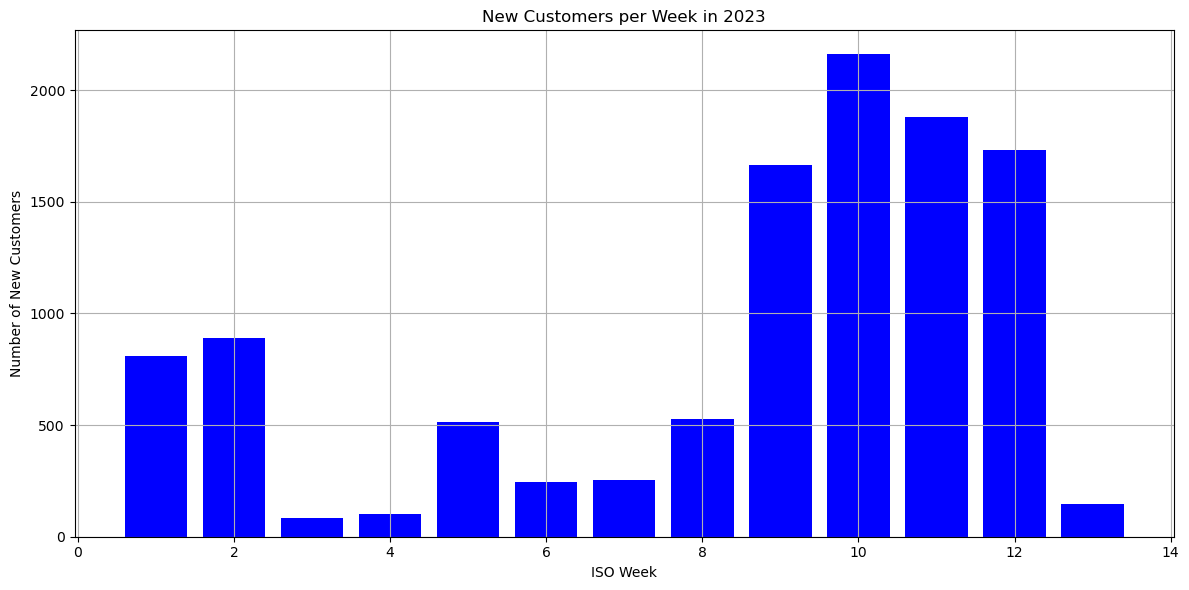

In [ ]:
plot_new_customers_per_week(rpc_mumbai_23, year=2023)

In [ ]:
plot_customer_lifetime_histogram(rpc_mumbai_23)

In [ ]:
mumbai_2022_hourly_df = analyze_and_plot_daily_patterns(filepath=meter_readings_mumbai_2022_filepath, city="mumbai")


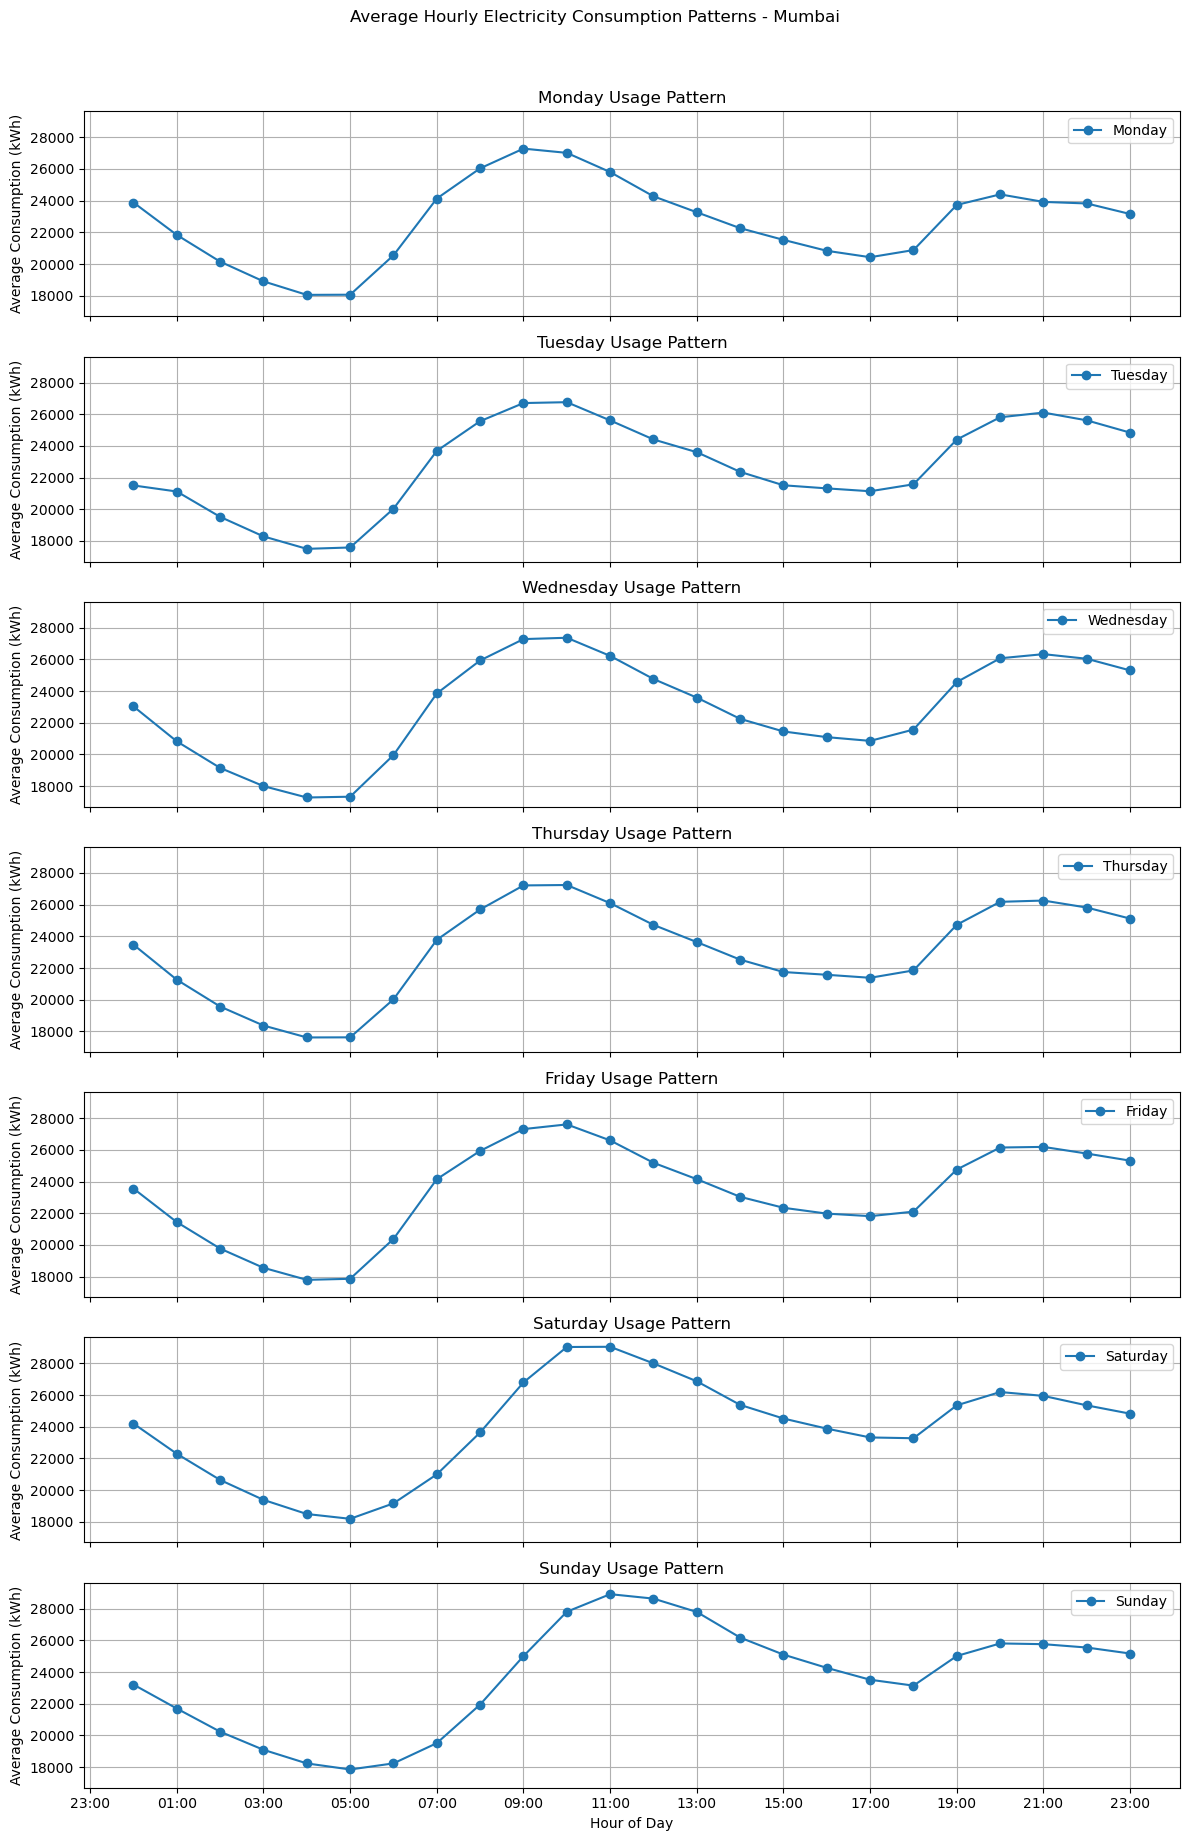

In [ ]:
mumbai_2023_hourly_df = analyze_and_plot_daily_patterns(filepath=meter_readings_mumbai_2023_filepath, city="mumbai")

In [ ]:
mumbai_2022_hourly_df_reshaped = reshape_and_sort_usage(df=mumbai_2022_hourly_df)
mumbai_2023_hourly_df_reshaped = reshape_and_sort_usage(df=mumbai_2023_hourly_df)
weekdays = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

print("\n" + "-" * 120)
print("Mumbai 2022 Data : Average Hourly Usage Patterns \n" + "-" * 120)

for day in weekdays:
    print(f"\n{day} Peak Hours:")
    display(mumbai_2022_hourly_df_reshaped.select(
        pl.col("hour"),
        pl.col(day)
    ).sort(day, descending=True).head(6))


print("\n" + "-" * 120)
print("Mumbai 2023 Data : Average Hourly Usage Patterns \n" + "-" * 120)

for day in weekdays:
    print(f"\n{day} Peak Hours:")
    display(mumbai_2023_hourly_df_reshaped.select(
        pl.col("hour"),
        pl.col(day)
    ).sort(day, descending=True).head(6))



------------------------------------------------------------------------------------------------------------------------
Mumbai 2022 Data : Average Hourly Usage Patterns 
------------------------------------------------------------------------------------------------------------------------

Mon Peak Hours:


shape: (6, 2)
┌──────┬──────────────┐
│ hour ┆ Mon          │
│ ---  ┆ ---          │
│ i8   ┆ f64          │
╞══════╪══════════════╡
│ 21   ┆ 15411.249231 │
│ 22   ┆ 15380.859846 │
│ 10   ┆ 15321.187231 │
│ 20   ┆ 15205.789308 │
│ 9    ┆ 15159.697154 │
│ 23   ┆ 15048.519923 │
└──────┴──────────────┘


Tue Peak Hours:


shape: (6, 2)
┌──────┬──────────────┐
│ hour ┆ Tue          │
│ ---  ┆ ---          │
│ i8   ┆ f64          │
╞══════╪══════════════╡
│ 10   ┆ 17624.610615 │
│ 21   ┆ 17568.396462 │
│ 22   ┆ 17492.624231 │
│ 20   ┆ 17372.150077 │
│ 9    ┆ 17275.699    │
│ 23   ┆ 17108.445077 │
└──────┴──────────────┘


Wed Peak Hours:


shape: (6, 2)
┌──────┬──────────────┐
│ hour ┆ Wed          │
│ ---  ┆ ---          │
│ i8   ┆ f64          │
╞══════╪══════════════╡
│ 10   ┆ 17673.647846 │
│ 9    ┆ 17388.213923 │
│ 11   ┆ 17041.843615 │
│ 21   ┆ 16443.877643 │
│ 8    ┆ 16399.968692 │
│ 22   ┆ 16344.069929 │
└──────┴──────────────┘


Thu Peak Hours:


shape: (6, 2)
┌──────┬──────────────┐
│ hour ┆ Thu          │
│ ---  ┆ ---          │
│ i8   ┆ f64          │
╞══════╪══════════════╡
│ 10   ┆ 16347.689429 │
│ 21   ┆ 16269.936214 │
│ 20   ┆ 16106.0155   │
│ 9    ┆ 16081.699286 │
│ 22   ┆ 16035.292643 │
│ 11   ┆ 15833.758214 │
└──────┴──────────────┘


Fri Peak Hours:


shape: (6, 2)
┌──────┬──────────────┐
│ hour ┆ Fri          │
│ ---  ┆ ---          │
│ i8   ┆ f64          │
╞══════╪══════════════╡
│ 10   ┆ 16387.036857 │
│ 9    ┆ 16057.427786 │
│ 11   ┆ 15836.503429 │
│ 20   ┆ 15738.993143 │
│ 21   ┆ 15734.147286 │
│ 19   ┆ 15394.030286 │
└──────┴──────────────┘


Sat Peak Hours:


shape: (6, 2)
┌──────┬──────────────┐
│ hour ┆ Sat          │
│ ---  ┆ ---          │
│ i8   ┆ f64          │
╞══════╪══════════════╡
│ 11   ┆ 17029.907929 │
│ 10   ┆ 16895.087214 │
│ 12   ┆ 16376.101929 │
│ 13   ┆ 15793.650714 │
│ 20   ┆ 15781.377071 │
│ 19   ┆ 15698.919143 │
└──────┴──────────────┘


Sun Peak Hours:


shape: (6, 2)
┌──────┬──────────────┐
│ hour ┆ Sun          │
│ ---  ┆ ---          │
│ i8   ┆ f64          │
╞══════╪══════════════╡
│ 11   ┆ 16831.546692 │
│ 12   ┆ 16575.930231 │
│ 13   ┆ 16148.797385 │
│ 10   ┆ 16028.724385 │
│ 14   ┆ 15509.901385 │
│ 20   ┆ 15133.980154 │
└──────┴──────────────┘


------------------------------------------------------------------------------------------------------------------------
Mumbai 2023 Data : Average Hourly Usage Patterns 
------------------------------------------------------------------------------------------------------------------------

Mon Peak Hours:


shape: (6, 2)
┌──────┬──────────────┐
│ hour ┆ Mon          │
│ ---  ┆ ---          │
│ i8   ┆ f64          │
╞══════╪══════════════╡
│ 9    ┆ 27285.164538 │
│ 10   ┆ 27017.245462 │
│ 8    ┆ 26040.960385 │
│ 11   ┆ 25804.272385 │
│ 20   ┆ 24395.736462 │
│ 12   ┆ 24273.097385 │
└──────┴──────────────┘


Tue Peak Hours:


shape: (6, 2)
┌──────┬──────────────┐
│ hour ┆ Tue          │
│ ---  ┆ ---          │
│ i8   ┆ f64          │
╞══════╪══════════════╡
│ 10   ┆ 26758.74925  │
│ 9    ┆ 26703.767583 │
│ 21   ┆ 26102.96775  │
│ 20   ┆ 25806.977583 │
│ 22   ┆ 25611.162583 │
│ 11   ┆ 25607.5135   │
└──────┴──────────────┘


Wed Peak Hours:


shape: (6, 2)
┌──────┬──────────────┐
│ hour ┆ Wed          │
│ ---  ┆ ---          │
│ i8   ┆ f64          │
╞══════╪══════════════╡
│ 10   ┆ 27368.445083 │
│ 9    ┆ 27283.55275  │
│ 21   ┆ 26333.471    │
│ 11   ┆ 26222.939917 │
│ 20   ┆ 26073.117    │
│ 22   ┆ 26041.29975  │
└──────┴──────────────┘


Thu Peak Hours:


shape: (6, 2)
┌──────┬──────────────┐
│ hour ┆ Thu          │
│ ---  ┆ ---          │
│ i8   ┆ f64          │
╞══════╪══════════════╡
│ 10   ┆ 27240.232583 │
│ 9    ┆ 27214.316583 │
│ 21   ┆ 26259.093167 │
│ 20   ┆ 26178.646083 │
│ 11   ┆ 26095.125667 │
│ 22   ┆ 25816.076    │
└──────┴──────────────┘


Fri Peak Hours:


shape: (6, 2)
┌──────┬──────────────┐
│ hour ┆ Fri          │
│ ---  ┆ ---          │
│ i8   ┆ f64          │
╞══════╪══════════════╡
│ 10   ┆ 27608.525833 │
│ 9    ┆ 27312.280333 │
│ 11   ┆ 26597.891417 │
│ 21   ┆ 26188.30975  │
│ 20   ┆ 26149.18375  │
│ 8    ┆ 25936.125167 │
└──────┴──────────────┘


Sat Peak Hours:


shape: (6, 2)
┌──────┬──────────────┐
│ hour ┆ Sat          │
│ ---  ┆ ---          │
│ i8   ┆ f64          │
╞══════╪══════════════╡
│ 11   ┆ 29050.8925   │
│ 10   ┆ 29037.22125  │
│ 12   ┆ 28002.662    │
│ 13   ┆ 26870.503083 │
│ 9    ┆ 26801.982    │
│ 20   ┆ 26194.707583 │
└──────┴──────────────┘


Sun Peak Hours:


shape: (6, 2)
┌──────┬──────────────┐
│ hour ┆ Sun          │
│ ---  ┆ ---          │
│ i8   ┆ f64          │
╞══════╪══════════════╡
│ 11   ┆ 28914.426462 │
│ 12   ┆ 28634.038462 │
│ 10   ┆ 27804.529077 │
│ 13   ┆ 27790.661    │
│ 14   ┆ 26173.644769 │
│ 20   ┆ 25804.311385 │
└──────┴──────────────┘

/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_10077/811842109.py:16: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  hourly_peaks.lazy()


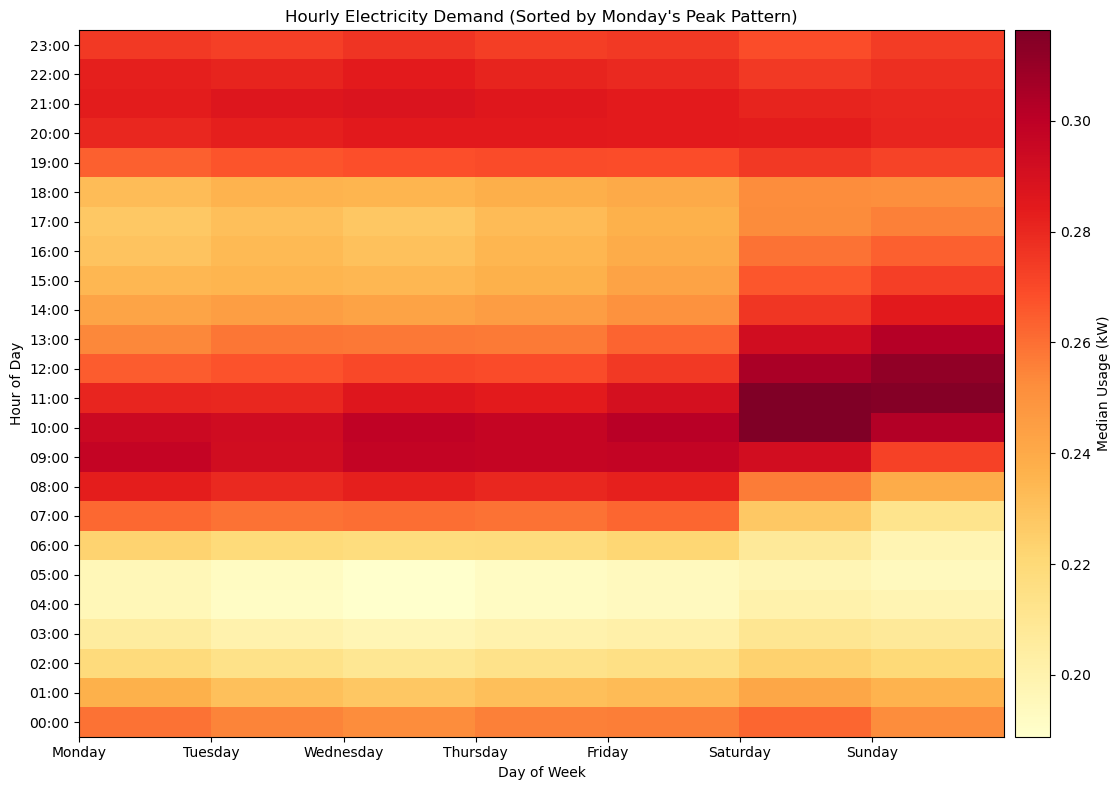

Peak Hours (Monday-sorted):
shape: (24, 8)
┌──────┬──────────┬──────────┬───────────┬──────────┬──────────┬──────────┬──────────┐
│ hour ┆ Sunday   ┆ Tuesday  ┆ Wednesday ┆ Saturday ┆ Friday   ┆ Monday   ┆ Thursday │
│ ---  ┆ ---      ┆ ---      ┆ ---       ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ i8   ┆ f64      ┆ f64      ┆ f64       ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞══════╪══════════╪══════════╪═══════════╪══════════╪══════════╪══════════╪══════════╡
│ 23   ┆ 0.273665 ┆ 0.272622 ┆ 0.276352  ┆ 0.26888  ┆ 0.274926 ┆ 0.274566 ┆ 0.273404 │
│ 22   ┆ 0.277784 ┆ 0.281147 ┆ 0.284391  ┆ 0.274563 ┆ 0.279796 ┆ 0.282478 ┆ 0.280994 │
│ 21   ┆ 0.280093 ┆ 0.286558 ┆ 0.287584  ┆ 0.28104  ┆ 0.284367 ┆ 0.283662 ┆ 0.285819 │
│ 20   ┆ 0.280577 ┆ 0.282855 ┆ 0.284743  ┆ 0.283726 ┆ 0.283976 ┆ 0.279999 ┆ 0.284946 │
│ 19   ┆ 0.271955 ┆ 0.267003 ┆ 0.268349  ┆ 0.274672 ┆ 0.268945 ┆ 0.263928 ┆ 0.2692   │
│ …    ┆ …        ┆ …        ┆ …         ┆ …        ┆ …        ┆ …        ┆ …        │


In [ ]:
# Aggregate to hourly (floor the hour and group)
hourly_peaks = (
    meter_readings_mumbai_2023_pldf.lazy()
    .with_columns([
        pl.col("date").dt.strftime("%A").alias("day_of_week"),
        pl.col("date").dt.hour().alias("hour")  # Just hour now, no half-hours
    ])
    .group_by(["city", "day_of_week", "hour"])
    .agg(pl.col("value").mean())  # Aggregate half-hours to hourly mean
    .sort(["day_of_week", "hour"])
    .collect()
)

# Create pivot table for heatmap (cities combined)
hourly_median = (
    hourly_peaks.lazy()
    .group_by(["day_of_week", "hour"])
    .agg(pl.col("value").median())  # Median across cities
    .collect()
    .pivot(values="value", index="hour", columns="day_of_week")
    .sort("hour")
)

# Get Monday's hour ranking (reference for sorting)
monday_ranking = (
    hourly_median.select(["hour", "Monday"])
    .sort("Monday", descending=True)
    .with_columns(rank=pl.col("hour").rank(descending=True))
)

# Apply Monday's sorting to all days
sorted_hourly = (
    hourly_median
    .join(monday_ranking.select(["hour", "rank"]), on="hour")
    .sort("rank")
    .drop("rank")
)

# Heatmap Visualization
plt.figure(figsize=(12, 8))

days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
hours = sorted_hourly["hour"].cast(pl.Int32).to_list()

im = plt.imshow(
    sorted_hourly.select(days).to_numpy(),
    cmap="YlOrRd",
    aspect="auto",
    extent=[0, 7, len(hours)-0.5, -0.5]  # Proper hour labeling
)

plt.title("Hourly Electricity Demand (Sorted by Monday's Peak Pattern)")
plt.ylabel("Hour of Day")
plt.xlabel("Day of Week")

# Axis formatting
plt.xticks(np.arange(7), labels=days)
plt.yticks(np.arange(len(hours)), labels=[f"{h:02d}:00" for h in hours])

# Add colorbar
cbar = plt.colorbar(im, pad=0.01)
cbar.set_label("Median Usage (kW)")

plt.tight_layout()
plt.show()

# Peak Hours Table
print("Peak Hours (Monday-sorted):")
print(sorted_hourly)

#### **METER READINGS DATA SUMMARY**

**Contains the following columns:**
* *ca_id (string):* Customer ID, matching the 'id' column in the 'customers' table
* *value (float):* Electricity usage value in kWh
* *date (datetime):* Timestamp of the observation (daily)
* *city (string):* City of the customer (delhi or mumbai)

**Data Summary:**
* *Locations Included:* 2 unique cities: 'delhi' and 'mumbai'
* *Time Range:* Full dataset spans from 2021-12-01 to 2023-03-28, though this varies by city:
    * **Delhi:** 2021-12-01 to 2022-12-31
    * **Mumbai:** 2022-09-28 to 2023-03-28
* *File Size:* The dataset is too large to load in full on a typical personal computer. It is stored across multiple partitioned files. Processing the entire dataset may require a high-performance computing (HPC) environment.
* *Memory Constraints:* Split into multiple files because it is too large to fit into memory for a normal personal computer
* *Data Coverage:* Contains data from 2021 to 2023
* *Year-wise Data Coverage:*
    * 2021: December only, Delhi only.
    * 2022: Full year for Delhi (majority of data).
    * 2023: January to March only, Mumbai only.
* *Data Completeness:* 
    * No missing (null) values detected across any columns — ideal for modeling and downstream analysis.
* *Caution on Turnover:* 
    * While complete customer lifecycle analysis requires the full dataset, preliminary snapshots from 2021 and 2023 suggest:
        * Most customers are persistent, with usage observed continuously throughout the available time range.
        * This stability makes the dataset suitable for analyzing usage behavior and interventions, since low turnover ensures continuity in consumption patterns.


**Mumbai – Average Hourly Usage Patterns**

Usage patterns in Mumbai vary by weekday, but consistently peak in the morning (9–11 AM) and evening (8–11 PM). Values for 2022 and 2023 are shown below.


**Mumbai 2022: Peak Hours (Top 6 hours per weekday)**
| Weekday | Peak Hours (hour)      | Average Usage (kWh) |
| ------- | ---------------------- | ------------------- |
| **Mon** | 21, 22, 10, 20, 9, 23  | \~15,050–15,400     |
| **Tue** | 10, 21, 22, 20, 9, 23  | \~17,100–17,600     |
| **Wed** | 10, 9, 11, 21, 8, 22   | \~16,300–17,600     |
| **Thu** | 10, 21, 20, 9, 22, 11  | \~15,800–16,300     |
| **Fri** | 10, 9, 11, 20, 21, 19  | \~15,400–16,400     |
| **Sat** | 11, 10, 12, 13, 20, 19 | \~15,700–17,000     |
| **Sun** | 11, 12, 13, 10, 14, 20 | \~15,100–16,800     |

**Mumbai 2023: Peak Hours (Top 6 hours per weekday)**

| Weekday | Peak Hours (hour)      | Average Usage (kWh) |
| ------- | ---------------------- | ------------------- |
| **Mon** | 9, 10, 8, 11, 20, 12   | \~24,200–27,300     |
| **Tue** | 10, 9, 21, 20, 22, 11  | \~25,600–26,800     |
| **Wed** | 10, 9, 21, 11, 20, 22  | \~26,000–27,300     |
| **Thu** | 10, 9, 21, 20, 11, 22  | \~25,800–27,200     |
| **Fri** | 10, 9, 11, 21, 20, 8   | \~25,900–27,600     |
| **Sat** | 11, 10, 12, 13, 9, 20  | \~26,800–29,000     |
| **Sun** | 11, 12, 10, 13, 14, 20 | \~25,800–28,900     |

**Observations:**
* Significant increase in usage from 2022 to 2023, nearly doubling in some peak hours.
* Weekends (Sat–Sun) consistently show highest average hourly usage, likely due to home-based activity.
* Morning hours (8–11 AM) and late evening (8–11 PM) are dominant peaks across all days.
* Usage is consistent across weekdays in structure, though Friday and Saturday are often slightly higher.



### **ERA5-Land Data from 'weather' table**

The following links contain documentation for the raw data that feeds into this 'weather' table
* https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation
* https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview


There are a few differences that we know that we will see. 
On July 12 the dataset was expanded to include data from 2020 to 2025 compared to the original 2022-2023.
Additionally two new fields were included (ssr and ssrd - see documentation)

As a result of these changes we will expect to see an increase in the number of rows of data comparing the pull from July 14th to previous datasets. We also expect to see two additional columns present in the dataset

In [ ]:
# Defining filenames for weather data files
weather_20250606_filename = "weather_20250606_1901"
weather_20250630_filename = "weather_20250630_1215"
weather_20250701_filename = "weather_20250701_1318"
weather_20250714_filename = "weather_20250714_1401"

In [ ]:
# Defining filepaths
weather_20250606_filepath = os.path.join(hitachi_data_directory, f"{weather_20250606_filename}.parquet")
weather_20250630_filepath = os.path.join(hitachi_data_directory, f"{weather_20250630_filename}.parquet")
weather_20250701_filepath = os.path.join(hitachi_data_directory, f"{weather_20250701_filename}.parquet")
weather_20250714_filepath = os.path.join(hitachi_data_directory, f"{weather_20250714_filename}.parquet")

In [ ]:
# Loading files into polars DataFrames
weather_20250606_pldf = pl.read_parquet(source=weather_20250606_filepath)
weather_20250630_pldf = pl.read_parquet(source=weather_20250630_filepath)
weather_20250701_pldf = pl.read_parquet(source=weather_20250701_filepath)
weather_20250714_pldf = pl.read_parquet(source=weather_20250714_filepath)

In [ ]:
print("Columns in weather_20250606 DataFrame:\n" + "-" * 120)
print(weather_20250606_pldf.columns)

Columns in weather_20250606 DataFrame:
------------------------------------------------------------------------------------------------------------------------
['timestamp', 'wind_speed', 'wind_direction', 'temperature', 'city', 'precipitation', 'location']


In [ ]:
print("Columns in the weather_20250714 DataFrame:\n" + "-" * 120)
print(weather_20250714_pldf.columns)

Columns in the weather_20250714 DataFrame:
------------------------------------------------------------------------------------------------------------------------
['timestamp', 'wind_speed', 'wind_direction', 'temperature', 'city', 'precipitation', 'location', 'surface_net_solar_radiation', 'surface_solar_radiation_downwards']


Just as expected we see those additional columns

In [ ]:
df_era_66_v_df_era_630 = compare_dataframes(df1=weather_20250606_pldf, df2=weather_20250630_pldf, sort_by=["timestamp"])
print("\nComparison between weather_20250606_pldf and weather_20250630_pldf:")
print(df_era_66_v_df_era_630)
df_era_66_v_df_era_701 = compare_dataframes(df1=weather_20250606_pldf, df2=weather_20250701_pldf, sort_by=["timestamp"])
print("\nComparison between weather_20250606_pldf and weather_20250701_pldf:")
print(df_era_66_v_df_era_701)
df_era_630_v_df_era_701 = compare_dataframes(df1=weather_20250630_pldf, df2=weather_20250701_pldf, sort_by=["timestamp"])
print("\nComparison between weather_20250630_pldf and weather_20250701_pldf:")
print(df_era_630_v_df_era_701)
df_era_66_v_df_era_714 = compare_dataframes(df1=weather_20250606_pldf, df2=weather_20250714_pldf, sort_by=["timestamp"])
print("\nComparison between weather_20250606_pldf and weather_20250714_pldf:")
print(df_era_66_v_df_era_714)
df_era_630_v_df_era_714 = compare_dataframes(df1=weather_20250630_pldf, df2=weather_20250714_pldf, sort_by=["timestamp"])
print("\nComparison between weather_20250630_pldf and weather_20250714_pldf:")
print(df_era_630_v_df_era_714)
df_era_701_v_df_era_714 = compare_dataframes(df1=weather_20250701_pldf, df2=weather_20250714_pldf, sort_by=["timestamp"])
print("\nComparison between weather_20250701_pldf and weather_20250714_pldf:")
print(df_era_701_v_df_era_714)


Comparison between weather_20250606_pldf and weather_20250630_pldf:

df1 and df2 are identical.

Comparison between weather_20250606_pldf and weather_20250701_pldf:

df1 and df2 are identical.

Comparison between weather_20250630_pldf and weather_20250701_pldf:

df1 and df2 are identical.

Comparison between weather_20250606_pldf and weather_20250714_pldf:

df1 and df2 have different shapes: (306432, 7) vs (3989664, 9)

Comparison between weather_20250630_pldf and weather_20250714_pldf:

df1 and df2 have different shapes: (306432, 7) vs (3989664, 9)

Comparison between weather_20250701_pldf and weather_20250714_pldf:

df1 and df2 have different shapes: (306432, 7) vs (3989664, 9)


The above analysis confirms what we expected to see, we will proceed with the newest dataset.

#### weather_20250714

In [ ]:
weather_20250714_pldf = pl.read_parquet(source=weather_20250714_filepath)

# Assigning the newest weather data to the variable 'weather_data_pldf'
weather_data_pldf = weather_20250714_pldf

# Sorting the weather data by timestamp
weather_data_pldf = weather_data_pldf.sort("timestamp")

# Display the shape of the weather table
print(f"The shape of 'weather_data_pldf' is {weather_data_pldf.shape}")

# Display the first 5 rows of the weather table
print(f"\nLooking at the first few rows of the 'weather_data_pldf':")
display(weather_data_pldf.head(n=5))

The shape of 'weather_data_pldf' is (3989664, 9)

Looking at the first few rows of the 'weather_data_pldf':


shape: (5, 9)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ timestamp ┆ wind_spee ┆ wind_dire ┆ temperatu ┆ … ┆ precipita ┆ location  ┆ surface_n ┆ surface_ │
│ ---       ┆ d         ┆ ction     ┆ re        ┆   ┆ tion      ┆ ---       ┆ et_solar_ ┆ solar_ra │
│ datetime[ ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ str       ┆ radiation ┆ diation_ │
│ μs]       ┆ decimal[3 ┆ decimal[3 ┆ decimal[3 ┆   ┆ decimal[3 ┆           ┆ ---       ┆ downwa…  │
│           ┆ 8,18]     ┆ 8,20]     ┆ 8,15]     ┆   ┆ 8,28]     ┆           ┆ decimal[3 ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 8,17]     ┆ decimal[ │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 38,17]   │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2019-12-3 ┆ null      ┆ null      ┆ null      ┆ … ┆ null      ┆ 010100002 ┆ null      ┆ null     │
│ 1         ┆           ┆           ┆           ┆   ┆           ┆ 0E6100000 ┆           ┆          │
│ 01:00:00  ┆           ┆           ┆           ┆   ┆           ┆ AE47E17A1 ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ 41E…      ┆           ┆          │
│ 2019-12-3 ┆ null      ┆ null      ┆ null      ┆ … ┆ null      ┆ 010100002 ┆ null      ┆ null     │
│ 1         ┆           ┆           ┆           ┆   ┆           ┆ 0E6100000 ┆           ┆          │
│ 01:00:00  ┆           ┆           ┆           ┆   ┆           ┆ 14AE47E17 ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ A24…      ┆           ┆          │
│ 2019-12-3 ┆ null      ┆ null      ┆ null      ┆ … ┆ null      ┆ 010100002 ┆ null      ┆ null     │
│ 1         ┆           ┆           ┆           ┆   ┆           ┆ 0E6100000 ┆           ┆          │
│ 01:00:00  ┆           ┆           ┆           ┆   ┆           ┆ 7A14AE47E ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ 12A…      ┆           ┆          │
│ 2019-12-3 ┆ null      ┆ null      ┆ null      ┆ … ┆ null      ┆ 010100002 ┆ null      ┆ null     │
│ 1         ┆           ┆           ┆           ┆   ┆           ┆ 0E6100000 ┆           ┆          │
│ 01:00:00  ┆           ┆           ┆           ┆   ┆           ┆ E07A14AE4 ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ 731…      ┆           ┆          │
│ 2019-12-3 ┆ null      ┆ null      ┆ null      ┆ … ┆ null      ┆ 010100002 ┆ null      ┆ null     │
│ 1         ┆           ┆           ┆           ┆   ┆           ┆ 0E6100000 ┆           ┆          │
│ 01:00:00  ┆           ┆           ┆           ┆   ┆           ┆ 46E17A14A ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ E37…      ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [ ]:
# Lets look at the time spanned by the weather data

# Time Span Analysis
print("\n" + "-" * 120)
print("Time Span Analysis of the 'weather_data_pldf':\n" + "-" * 120)

# Calculate the time span of the weather data
print(f"- Start timestamp: {weather_data_pldf['timestamp'].min()}")
print(f"- End timestamp: {weather_data_pldf['timestamp'].max()}")

# Display the total temporal range
print(f"\nTotal temporal range: {weather_data_pldf['timestamp'].max() - weather_data_pldf['timestamp'].min()}")


------------------------------------------------------------------------------------------------------------------------
Time Span Analysis of the 'weather_data_pldf':
------------------------------------------------------------------------------------------------------------------------
- Start timestamp: 2019-12-31 01:00:00
- End timestamp: 2025-06-01 00:00:00

Total temporal range: 1978 days, 23:00:00


In [ ]:
display(weather_data_pldf.schema)  # Display the schema of the weather table

Schema([('timestamp', Datetime(time_unit='us', time_zone=None)),
        ('wind_speed', Decimal(precision=38, scale=18)),
        ('wind_direction', Decimal(precision=38, scale=20)),
        ('temperature', Decimal(precision=38, scale=15)),
        ('city', String),
        ('precipitation', Decimal(precision=38, scale=28)),
        ('location', String),
        ('surface_net_solar_radiation', Decimal(precision=38, scale=17)),
        ('surface_solar_radiation_downwards',
         Decimal(precision=38, scale=17))])

We may want to change some of these data types at a later stage in order to reduce the size of the dataset, but we'll leave them for now.

In [ ]:
# Display the summary statistics of the weather table
print(f"\nDescription of the 'weather_data_pldf':")
display(weather_data_pldf.describe())


Description of the 'weather_data_pldf':


shape: (9, 10)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ timestamp ┆ wind_spee ┆ wind_dire ┆ … ┆ precipita ┆ location  ┆ surface_n ┆ surface_ │
│ ---       ┆ ---       ┆ d         ┆ ction     ┆   ┆ tion      ┆ ---       ┆ et_solar_ ┆ solar_ra │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ str       ┆ radiation ┆ diation_ │
│           ┆           ┆ f64       ┆ f64       ┆   ┆ f64       ┆           ┆ ---       ┆ downwa…  │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ f64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 3989664   ┆ 2.046285e ┆ 2.046285e ┆ … ┆ 2.046285e ┆ 3989664   ┆ 1.889953e ┆ 1.889954 │
│           ┆           ┆ 6         ┆ 6         ┆   ┆ 6         ┆           ┆ 6         ┆ e6       │
│ null_coun ┆ 0         ┆ 1.943379e ┆ 1.943379e ┆ … ┆ 1.943379e ┆ 0         ┆ 2.099711e ┆ 2.09971e │
│ t         ┆           ┆ 6         ┆ 6         ┆   ┆ 6         ┆           ┆ 6         ┆ 6        │
│ mean      ┆ 2022-09-1 ┆ 5.913636  ┆ 167.30251 ┆ … ┆ 0.001737  ┆ null      ┆ 1.1276e7  ┆ 1.3538e7 │
│           ┆ 5         ┆           ┆ 3         ┆   ┆           ┆           ┆           ┆          │
│           ┆ 12:30:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ std       ┆ null      ┆ 3.125727  ┆ 88.154022 ┆ … ┆ 0.006866  ┆ null      ┆ 6.9285e6  ┆ 8.3022e6 │
│ min       ┆ 2019-12-3 ┆ 0.005403  ┆ 0.000265  ┆ … ┆ 0.0       ┆ 010100002 ┆ 0.0       ┆ 0.0      │
│           ┆ 1         ┆           ┆           ┆   ┆           ┆ 0E6100000 ┆           ┆          │
│           ┆ 01:00:00  ┆           ┆           ┆   ┆           ┆ 14AE47E17 ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ A24…      ┆           ┆          │
│ 25%       ┆ 2021-05-0 ┆ 3.790591  ┆ 106.34765 ┆ … ┆ 0.0       ┆ null      ┆ 5.062334e ┆ 6.017553 │
│           ┆ 8         ┆           ┆ 1         ┆   ┆           ┆           ┆ 6         ┆ e6       │
│           ┆ 19:00:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 50%       ┆ 2022-09-1 ┆ 5.431484  ┆ 145.85406 ┆ … ┆ 0.000001  ┆ null      ┆ 1.2313436 ┆ 1.4862e7 │
│           ┆ 5         ┆           ┆           ┆   ┆           ┆           ┆ e7        ┆          │
│           ┆ 13:00:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 75%       ┆ 2024-01-2 ┆ 7.45679   ┆ 241.90180 ┆ … ┆ 0.000466  ┆ null      ┆ 1.6668687 ┆ 1.991219 │
│           ┆ 3         ┆           ┆ 7         ┆   ┆           ┆           ┆ e7        ┆ 6e7      │
│           ┆ 06:00:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ max       ┆ 2025-06-0 ┆ 42.517314 ┆ 359.99997 ┆ … ┆ 0.314005  ┆ 010100002 ┆ 2.49234e7 ┆ 2.903841 │
│           ┆ 1         ┆           ┆ 9         ┆   ┆           ┆ 0E6100000 ┆           ┆ 4e7      │
│           ┆ 00:00:00  ┆           ┆           ┆   ┆           ┆ F6285C8FC ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ 255…      ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

As expected, the data has the same general structure as the previous pull, but now with new columns and expanded time frame.

---
We now have 9 total columns

* *timestamp* - (dt) - containing the time that the measurement is taken
* *city* - (str) - the city where the measurement was taken
* *location* - (str) - the geographical region where the measurement was taken (2 meter for temp, 10 meter for wind, unknown for precipitation)
* measurements including: (all at 9km resolution)
    * *wind_speed* (mph) - 10 meter height- (calculated from 10m_u_component_of_wind & 10m_v_component_of_wind)
    * *wind_direction* (º) - 10 meter height - (calculated from 10m_u_component_of_wind & 10m_v_component_of_wind)
    * *temperature* (C) - 2 meter height - (2m_temperature) - (K original - converted to C)
    * *precipitation* (m) - (total_precipitation) - cumulative over the forecast step - evenly distributed over the grid box
        * "This variable is accumulated from the beginning of the forecast time to the end of the forecast step. The units of precipitation are depth in metres. It is the depth the water would have if it were spread evenly over the grid box"
    * *surface_net_solar_radiation* (J/m^2) - (ssr) - cumulative over the forecast step
        * "This variable is accumulated from the beginning of the forecast time to the end of the forecast step. The units are joules per square metre (J m^-2). To convert to watts per square metre (W m^-2), the accumulated values should be divided by the accumulation period expressed in seconds"
    * *surface_solar_radiation_downwards* (J/m^2)
        * "This variable is accumulated from the beginning of the forecast time to the end of the forecast step. The units are joules per square metre (J m^-2). To convert to watts per square metre (W m^-2), the accumulated values should be divided by the accumulation period expressed in seconds."

Notes from ERA5 documentation:

"Most hydrological parameters are in units of "m of water per day", so these should be multiplied by 1000 to convert to kg m-2 day-1 or mm day-1"
https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation

---


It looks as though we are missing a significant amount of data.
We will have to decide what the best course of action is to deal with this.


##### Distribution of Data

In [ ]:
# Lets add some additional columns to the weather table to make dates and times easier to work with
weather_data_pldf = weather_data_pldf.with_columns(
    [
        pl.col(name="timestamp").dt.date().alias(name="date"),  # Extract date from timestamp
        pl.col(name="timestamp").dt.time().alias(name="time"),  # Extract time from timestamp
        pl.col(name="timestamp").dt.year().alias(name="year"),  # Extract year from timestamp
        pl.col(name="timestamp").dt.month().alias(name="month"),  # Extract month from timestamp
        pl.col(name="timestamp").dt.day().alias(name="day"),  # Extract day from timestamp
        pl.col(name="timestamp").dt.hour().alias(name="hour"),  # Extract hour from timestamp
        pl.col(name="timestamp")
        .dt.minute()
        .alias(name="minute"),  # Extract minute from timestamp
        pl.col(name="timestamp")
        .dt.weekday()
        .cast(dtype=pl.UInt8)
        .alias(name="weekday_int"),  # Extract weekday as an integer from timestamp
    ]
)

# Now lets add a column to the weather table that contains the name of the day of the week
# In this case 1 = Monday, not 0
weather_data_pldf = weather_data_pldf.with_columns(
    pl.when(pl.col(name="weekday_int") == 1)
    .then(statement=pl.lit(value="Monday"))
    .when(pl.col(name="weekday_int") == 2)
    .then(pl.lit("Tuesday"))
    .when(pl.col("weekday_int") == 3)
    .then(pl.lit("Wednesday"))
    .when(pl.col("weekday_int") == 4)
    .then(pl.lit("Thursday"))
    .when(pl.col("weekday_int") == 5)
    .then(pl.lit("Friday"))
    .when(pl.col("weekday_int") == 6)
    .then(pl.lit("Saturday"))
    .when(pl.col("weekday_int") == 7)
    .then(pl.lit("Sunday"))
    .otherwise(pl.lit("Unknown"))  # Handle any unexpected values
    .alias("weekday_name")
)

# Lets first look at the 5 rows of the weather table to verify the new columns have been added correctly
print("\n" + "-" * 120)
print("First 5 rows of 'weather_data_pldf' after adding columns:\n" + "-" * 120)
display(weather_data_pldf.sort("weekday_int").head(5))

# Display the descriptive statistics of the weather table after adding new columns
print("\n" + "-" * 120)
print("Descriptive statistics of 'weather_data_pldf' after adding new columns:\n" + "-" * 120)
display(weather_data_pldf.describe())


------------------------------------------------------------------------------------------------------------------------
First 5 rows of 'weather_data_pldf' after adding columns:
------------------------------------------------------------------------------------------------------------------------


shape: (5, 18)
┌─────────────┬────────────┬────────────┬────────────┬───┬──────┬────────┬────────────┬────────────┐
│ timestamp   ┆ wind_speed ┆ wind_direc ┆ temperatur ┆ … ┆ hour ┆ minute ┆ weekday_in ┆ weekday_na │
│ ---         ┆ ---        ┆ tion       ┆ e          ┆   ┆ ---  ┆ ---    ┆ t          ┆ me         │
│ datetime[μs ┆ decimal[38 ┆ ---        ┆ ---        ┆   ┆ i8   ┆ i8     ┆ ---        ┆ ---        │
│ ]           ┆ ,18]       ┆ decimal[38 ┆ decimal[38 ┆   ┆      ┆        ┆ u8         ┆ str        │
│             ┆            ┆ ,20]       ┆ ,15]       ┆   ┆      ┆        ┆            ┆            │
╞═════════════╪════════════╪════════════╪════════════╪═══╪══════╪════════╪════════════╪════════════╡
│ 2020-01-06  ┆ null       ┆ null       ┆ null       ┆ … ┆ 0    ┆ 0      ┆ 1          ┆ Monday     │
│ 00:00:00    ┆            ┆            ┆            ┆   ┆      ┆        ┆            ┆            │
│ 2020-01-06  ┆ null       ┆ null       ┆ null       ┆ … ┆ 0    ┆ 0      ┆ 1          ┆ Monday     │
│ 00:00:00    ┆            ┆            ┆            ┆   ┆      ┆        ┆            ┆            │
│ 2020-01-06  ┆ null       ┆ null       ┆ null       ┆ … ┆ 0    ┆ 0      ┆ 1          ┆ Monday     │
│ 00:00:00    ┆            ┆            ┆            ┆   ┆      ┆        ┆            ┆            │
│ 2020-01-06  ┆ null       ┆ null       ┆ null       ┆ … ┆ 0    ┆ 0      ┆ 1          ┆ Monday     │
│ 00:00:00    ┆            ┆            ┆            ┆   ┆      ┆        ┆            ┆            │
│ 2020-01-06  ┆ null       ┆ null       ┆ null       ┆ … ┆ 0    ┆ 0      ┆ 1          ┆ Monday     │
│ 00:00:00    ┆            ┆            ┆            ┆   ┆      ┆        ┆            ┆            │
└─────────────┴────────────┴────────────┴────────────┴───┴──────┴────────┴────────────┴────────────┘


------------------------------------------------------------------------------------------------------------------------
Descriptive statistics of 'weather_data_pldf' after adding new columns:
------------------------------------------------------------------------------------------------------------------------


shape: (9, 19)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ timestamp ┆ wind_spee ┆ wind_dire ┆ … ┆ hour      ┆ minute    ┆ weekday_i ┆ weekday_ │
│ ---       ┆ ---       ┆ d         ┆ ction     ┆   ┆ ---       ┆ ---       ┆ nt        ┆ name     │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ f64       ┆ f64       ┆ ---       ┆ ---      │
│           ┆           ┆ f64       ┆ f64       ┆   ┆           ┆           ┆ f64       ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 3989664   ┆ 2.046285e ┆ 2.046285e ┆ … ┆ 3.989664e ┆ 3.989664e ┆ 3.989664e ┆ 3989664  │
│           ┆           ┆ 6         ┆ 6         ┆   ┆ 6         ┆ 6         ┆ 6         ┆          │
│ null_coun ┆ 0         ┆ 1.943379e ┆ 1.943379e ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0        │
│ t         ┆           ┆ 6         ┆ 6         ┆   ┆           ┆           ┆           ┆          │
│ mean      ┆ 2022-09-1 ┆ 5.913636  ┆ 167.30251 ┆ … ┆ 11.5      ┆ 0.0       ┆ 4.000105  ┆ null     │
│           ┆ 5         ┆           ┆ 3         ┆   ┆           ┆           ┆           ┆          │
│           ┆ 12:30:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ std       ┆ null      ┆ 3.125727  ┆ 88.154022 ┆ … ┆ 6.922187  ┆ 0.0       ┆ 1.998763  ┆ null     │
│ min       ┆ 2019-12-3 ┆ 0.005403  ┆ 0.000265  ┆ … ┆ 0.0       ┆ 0.0       ┆ 1.0       ┆ Friday   │
│           ┆ 1         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 01:00:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 25%       ┆ 2021-05-0 ┆ 3.790591  ┆ 106.34765 ┆ … ┆ 6.0       ┆ 0.0       ┆ 2.0       ┆ null     │
│           ┆ 8         ┆           ┆ 1         ┆   ┆           ┆           ┆           ┆          │
│           ┆ 19:00:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 50%       ┆ 2022-09-1 ┆ 5.431484  ┆ 145.85406 ┆ … ┆ 12.0      ┆ 0.0       ┆ 4.0       ┆ null     │
│           ┆ 5         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 13:00:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 75%       ┆ 2024-01-2 ┆ 7.45679   ┆ 241.90180 ┆ … ┆ 17.0      ┆ 0.0       ┆ 6.0       ┆ null     │
│           ┆ 3         ┆           ┆ 7         ┆   ┆           ┆           ┆           ┆          │
│           ┆ 06:00:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ max       ┆ 2025-06-0 ┆ 42.517314 ┆ 359.99997 ┆ … ┆ 23.0      ┆ 0.0       ┆ 7.0       ┆ Wednesda │
│           ┆ 1         ┆           ┆ 9         ┆   ┆           ┆           ┆           ┆ y        │
│           ┆ 00:00:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

---

From the above we can see that we have data spanning 1978 days and 23 hours from 2019-12-31 at 01:00 until 2025-06-01 at 00:00
Since we now the data is hourly, we can do a quick check for the expected number of observations per location before we run the code.

(1,978 days * 24 hours + 23 hours = 3,647 + 1 = 47,496 observations)
(+1 for inclusive boundary)

We can also check what the expected number of locations should be.
(3,989,664 total observations / 47,496 observations per location = 84 locations)

---

In [ ]:
print(f"Expected # of observations per location: {(1978 * 24 + 23 + 1):,}")
print(f"Expected # of locations: {int(3989664 / 47496)}")

Expected # of observations per location: 47,496
Expected # of locations: 84


In [ ]:
# Verifying the number of unique locations in the weather data
unique_locations = weather_data_pldf.select(
    pl.col("location").n_unique()
).item()

print("\n" + "-" * 120)
print(f"Total unique locations in 'weather_data_pldf': {unique_locations:,}")
print("-" * 120)


------------------------------------------------------------------------------------------------------------------------
Total unique locations in 'weather_data_pldf': 84
------------------------------------------------------------------------------------------------------------------------


In [ ]:
# We should also look at the total number of unique timestamps in the weather table, grouped by location
print("\n" + "-" * 120)
print("Total unique timestamps per location in the 'weather_data_pldf':\n" + "-" * 120)

location_total_counts = (
    weather_data_pldf.group_by(pl.col("location"))
    .agg(pl.col("timestamp").n_unique().alias("n_timestamps"))
    .sort("location")
)
print(location_total_counts)


------------------------------------------------------------------------------------------------------------------------
Total unique timestamps per location in the 'weather_data_pldf':
------------------------------------------------------------------------------------------------------------------------
shape: (84, 2)
┌─────────────────────────────────┬──────────────┐
│ location                        ┆ n_timestamps │
│ ---                             ┆ ---          │
│ str                             ┆ u32          │
╞═════════════════════════════════╪══════════════╡
│ 0101000020E610000014AE47E17A24… ┆ 47496        │
│ 0101000020E610000014AE47E17A24… ┆ 47496        │
│ 0101000020E610000014AE47E17A24… ┆ 47496        │
│ 0101000020E610000014AE47E17A24… ┆ 47496        │
│ 0101000020E610000014AE47E17A24… ┆ 47496        │
│ …                               ┆ …            │
│ 0101000020E6100000F6285C8FC255… ┆ 47496        │
│ 0101000020E6100000F6285C8FC255… ┆ 47496        │
│ 0101000020E6

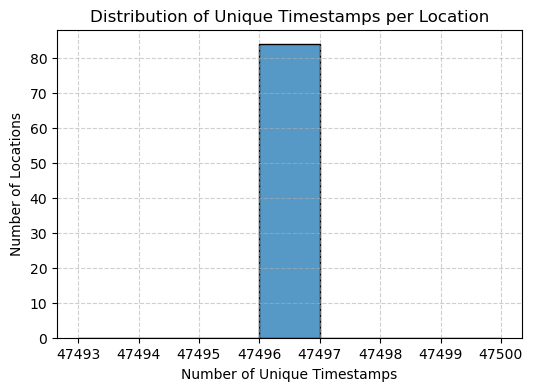

In [ ]:
# convert the Polars DataFrame to a Pandas DataFrame for plotting
plot_pldf = location_total_counts.to_pandas()
min_val = plot_pldf["n_timestamps"].min() - 3
max_val = plot_pldf["n_timestamps"].max() + 3


# Again it is easier to visualize the distribution of unique timestamps per location
plt.figure(figsize=(6, 4))
ax = sns.histplot(
    plot_pldf["n_timestamps"], bins=range(min_val, max_val + 2), kde=False
)
ax.ticklabel_format(useOffset=False, style='plain', axis='x')

plt.title("Distribution of Unique Timestamps per Location")
plt.xlabel("Number of Unique Timestamps")
plt.ylabel("Number of Locations")
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.grid(True, linestyle="--", alpha=0.6)
plt.show()

---

The above outputs match our expectations of timestamps and total number of locations.
- 84 locations
- All locations have the same number of timestamps - 47496.

Let's move onto investigating the number of timestamps in comparison to the number of weather-related readings

---

In [ ]:
# We first look at the number of unique locations in the weather table, grouped by city
print("\n" + "-" * 120)
print("Number of unique locations per city in the 'weather_table_pldf':\n" + "-" * 120)

location_counts_per_city = weather_data_pldf.group_by("city").agg(  # Grouping by city
    pl.col("location").n_unique().alias("n_unique_locations")
)  # Aggregating to count unique locations per city
print(location_counts_per_city)


------------------------------------------------------------------------------------------------------------------------
Number of unique locations per city in the 'weather_table_pldf':
------------------------------------------------------------------------------------------------------------------------
shape: (2, 2)
┌────────┬────────────────────┐
│ city   ┆ n_unique_locations │
│ ---    ┆ ---                │
│ str    ┆ u32                │
╞════════╪════════════════════╡
│ mumbai ┆ 54                 │
│ delhi  ┆ 30                 │
└────────┴────────────────────┘


---

We have two cities in the dataset, **delhi** and **mumbai**, having 30 and 54 unique locations respectively. And obviously the sum of these two locations (50+34) is equivalent to the total amount of locations we determined earlier (**84**).

Lets now look at the number of weather related readings for each location.

Keep in mind - this is just the count of readings - not the value of readings themselves.

---

In [ ]:
# Now we'll look at the count of weather-related readings per location
print("\n" + "-" * 120)
print("Count of weather readings per location in 'weather_data_pldf':\n" + "-" * 120)

location_weather_counts = (
    weather_data_pldf.group_by(
        pl.col("location")
    )
    .agg([
        # Count non-null values for each weather metric
        pl.col(name="wind_speed").count().alias(name="wind_speed_count"),
        pl.col(name="wind_direction").count().alias(name="wind_direction_count"),
        pl.col(name="temperature").count().alias(name="temperature_count"),
        pl.col(name="precipitation").count().alias(name="precipitation_count"),
        pl.col(name="surface_net_solar_radiation").count().alias(name="surface_net_solar_radiation_count"),
        pl.col(name="surface_solar_radiation_downwards").count().alias(name="surface_solar_radiation_downwards_count"),

        # Additional useful metrics
        pl.col(name="wind_speed").mean().alias(name="avg_wind_speed"),
        pl.col(name="temperature").mean().alias(name="avg_temperature"),
    ]
    )
    .sort("location")
)

# Print the first 10 locations to avoid overwhelming output
display(location_weather_counts)

# Print summary statistics
print("\nSummary statistics:")
display(location_weather_counts.describe())


------------------------------------------------------------------------------------------------------------------------
Count of weather readings per location in 'weather_data_pldf':
------------------------------------------------------------------------------------------------------------------------


shape: (84, 9)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ location  ┆ wind_spee ┆ wind_dire ┆ temperatu ┆ … ┆ surface_n ┆ surface_s ┆ avg_wind_ ┆ avg_temp │
│ ---       ┆ d_count   ┆ ction_cou ┆ re_count  ┆   ┆ et_solar_ ┆ olar_radi ┆ speed     ┆ erature  │
│ str       ┆ ---       ┆ nt        ┆ ---       ┆   ┆ radiation ┆ ation_dow ┆ ---       ┆ ---      │
│           ┆ u32       ┆ ---       ┆ u32       ┆   ┆ _co…      ┆ nwa…      ┆ f64       ┆ f64      │
│           ┆           ┆ u32       ┆           ┆   ┆ ---       ┆ ---       ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ u32       ┆ u32       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 010100002 ┆ 0         ┆ 0         ┆ 0         ┆ … ┆ 0         ┆ 0         ┆ null      ┆ null     │
│ 0E6100000 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 14AE47E17 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ A24…      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 010100002 ┆ 0         ┆ 0         ┆ 0         ┆ … ┆ 0         ┆ 0         ┆ null      ┆ null     │
│ 0E6100000 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 14AE47E17 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ A24…      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 010100002 ┆ 0         ┆ 0         ┆ 0         ┆ … ┆ 0         ┆ 0         ┆ null      ┆ null     │
│ 0E6100000 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 14AE47E17 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ A24…      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 010100002 ┆ 0         ┆ 0         ┆ 0         ┆ … ┆ 0         ┆ 0         ┆ null      ┆ null     │
│ 0E6100000 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 14AE47E17 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ A24…      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 010100002 ┆ 0         ┆ 0         ┆ 0         ┆ … ┆ 0         ┆ 0         ┆ null      ┆ null     │
│ 0E6100000 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 14AE47E17 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ A24…      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ 010100002 ┆ 45473     ┆ 45473     ┆ 45473     ┆ … ┆ 41999     ┆ 41999     ┆ 5.234613  ┆ 24.33150 │
│ 0E6100000 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 9        │
│ F6285C8FC ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 255…      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 010100002 ┆ 45473     ┆ 45473     ┆ 45473     ┆ … ┆ 41999     ┆ 41999     ┆ 5.266667  ┆ 24.63041 │
│ 0E6100000 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 8        │
│ F6285C8FC ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 255…      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 010100002 ┆ 45473     ┆ 45473     ┆ 45473     ┆ … ┆ 41999     ┆ 41999     ┆ 5.264889  ┆ 24.44699 │
│ 0E6100000 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 2        │
│ F6285C8FC ┆           ┆           ┆         


Summary statistics:


shape: (9, 10)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ location  ┆ wind_spee ┆ wind_dire ┆ … ┆ surface_n ┆ surface_s ┆ avg_wind_ ┆ avg_temp │
│ ---       ┆ ---       ┆ d_count   ┆ ction_cou ┆   ┆ et_solar_ ┆ olar_radi ┆ speed     ┆ erature  │
│ str       ┆ str       ┆ ---       ┆ nt        ┆   ┆ radiation ┆ ation_dow ┆ ---       ┆ ---      │
│           ┆           ┆ f64       ┆ ---       ┆   ┆ _co…      ┆ nwa…      ┆ f64       ┆ f64      │
│           ┆           ┆           ┆ f64       ┆   ┆ ---       ┆ ---       ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆ f64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 84        ┆ 84.0      ┆ 84.0      ┆ … ┆ 84.0      ┆ 84.0      ┆ 45.0      ┆ 45.0     │
│ null_coun ┆ 0         ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 39.0      ┆ 39.0     │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ mean      ┆ null      ┆ 24360.535 ┆ 24360.535 ┆ … ┆ 22499.440 ┆ 22499.452 ┆ 5.913636  ┆ 25.37980 │
│           ┆           ┆ 714       ┆ 714       ┆   ┆ 476       ┆ 381       ┆           ┆ 1        │
│ std       ┆ null      ┆ 22814.632 ┆ 22814.632 ┆ … ┆ 21071.641 ┆ 21071.652 ┆ 1.008377  ┆ 1.155477 │
│           ┆           ┆ 533       ┆ 533       ┆   ┆ 145       ┆ 294       ┆           ┆          │
│ min       ┆ 010100002 ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 5.234613  ┆ 24.17909 │
│           ┆ 0E6100000 ┆           ┆           ┆   ┆           ┆           ┆           ┆ 8        │
│           ┆ 14AE47E17 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ A24…      ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 25%       ┆ null      ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 5.309864  ┆ 24.52022 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 5        │
│ 50%       ┆ null      ┆ 45473.0   ┆ 45473.0   ┆ … ┆ 41999.0   ┆ 41999.0   ┆ 5.332762  ┆ 24.74265 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 2        │
│ 75%       ┆ null      ┆ 45473.0   ┆ 45473.0   ┆ … ┆ 41999.0   ┆ 41999.0   ┆ 6.796011  ┆ 26.77957 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 2        │
│ max       ┆ 010100002 ┆ 45473.0   ┆ 45473.0   ┆ … ┆ 41999.0   ┆ 41999.0   ┆ 9.107481  ┆ 27.24150 │
│           ┆ 0E6100000 ┆           ┆           ┆   ┆           ┆           ┆           ┆ 4        │
│           ┆ F6285C8FC ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 255…      ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

---

Interestingly we see that there are some locations that appear to have no readings. Then for locations that do have data, they have **45473** observations or **41999** for the solar fields, not the full **47496** to match the number of timestamps we saw earlier.

As a result - we may need to gap fill these datapoints later in our analysis.

---

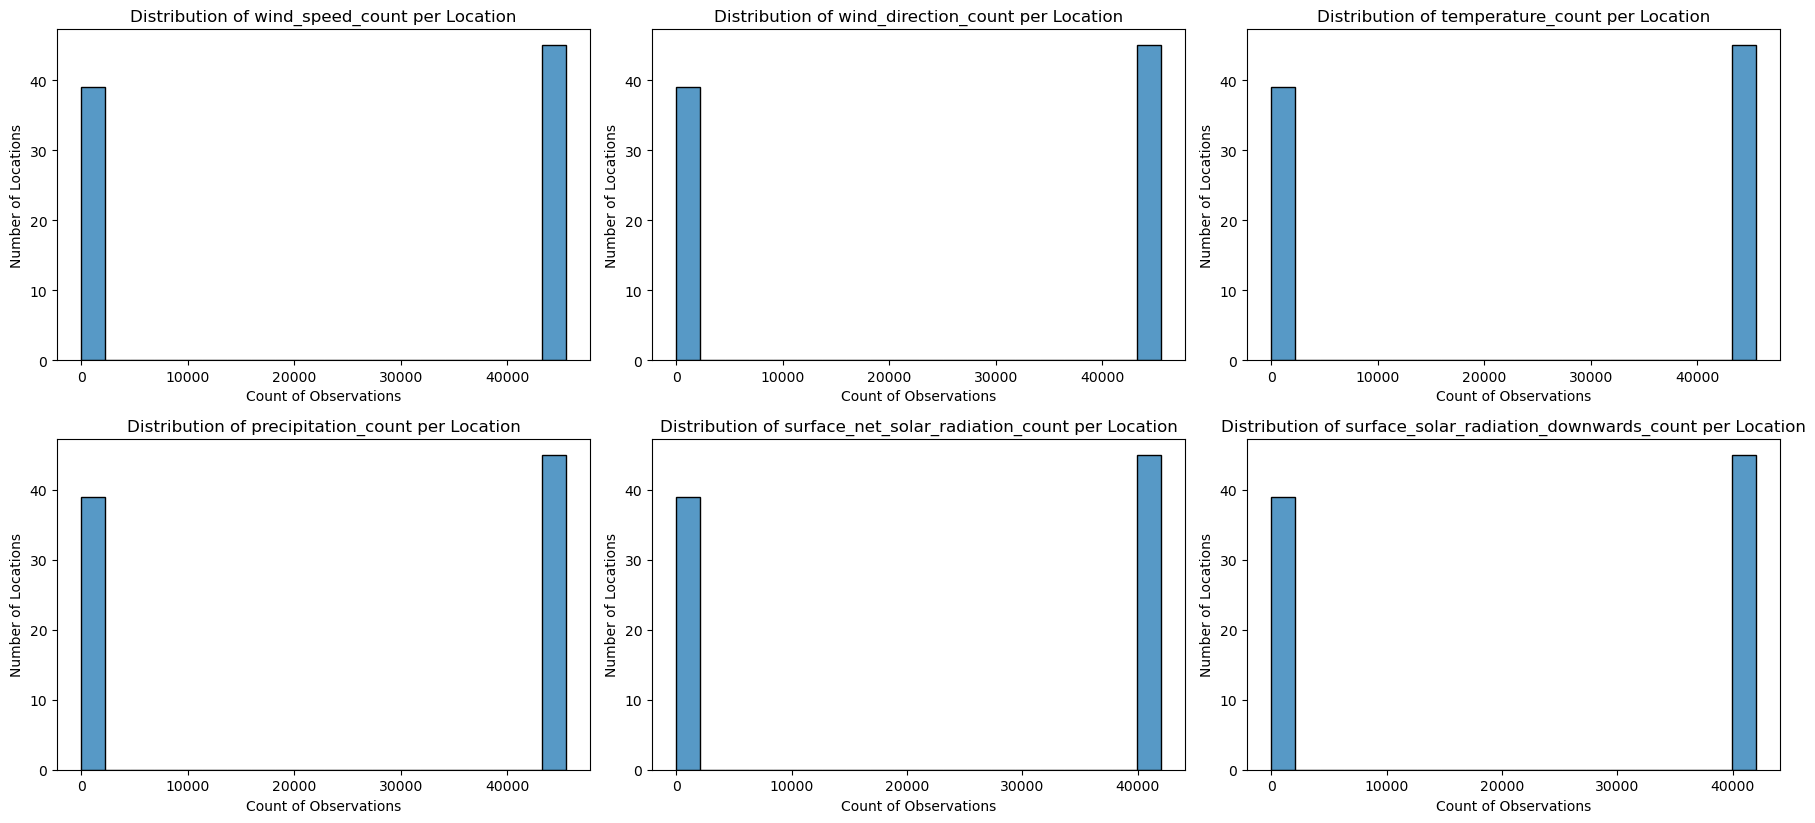

In [ ]:
# Since there are 84 different locations, it would be useful to visualize the distribution of weather-related readings per location.
# Convert to Pandas for plotting
location_weather_counts_pd = location_weather_counts.to_pandas()

# Plot histograms for each variable
plt.figure(figsize=(18, 12))
for i, col in enumerate(
    [
        "wind_speed_count",
        "wind_direction_count",
        "temperature_count",
        "precipitation_count",
        "surface_net_solar_radiation_count",
        "surface_solar_radiation_downwards_count"
    ],
    1,
):
    plt.subplot(3, 3, i)
    sns.histplot(location_weather_counts_pd[col], bins=20, kde=False)
    plt.title(f"Distribution of {col} per Location")
    plt.xlabel("Count of Observations")
    plt.ylabel("Number of Locations")

plt.tight_layout()
plt.show()

---

Based on the above graphs we can see that there appears to be just **shy of 40** locations that have **0 observations** recorded in the total dataset, but the **rest** have **45473** to **41999** **observations**. 
Now it's possible that these could be different locations at different points in time, but we may be best served simply dropping these locations from our analysis as they do not have any data.

---

Note we observed this same missing data in our original pulls of data.
Additionally it was confirmed that the missing data is present in the raw dataset.

##### Missing Data Analysis

In [ ]:
# Filter to find locations with no weather-related readings
locations_with_no_weather = location_weather_counts.filter(
    (pl.col("wind_speed_count") == 0)
    & (pl.col("wind_direction_count") == 0)
    & (pl.col("temperature_count") == 0)
    & (pl.col("precipitation_count") == 0)
    & (pl.col("surface_net_solar_radiation_count") == 0)
    & (pl.col("surface_solar_radiation_downwards_count") == 0)
)

In [ ]:
# Bring in the city information for these locations in case there is a pattern
location_city_pairs = weather_data_pldf.select(
    ["location", "city"]
).unique()  # Select unique pairs of location and city


locations_with_no_weather_city = locations_with_no_weather.join(
    location_city_pairs, on="location", how="left"
)

# Print number of rows (locations with no weather readings)
print("\n" + "-" * 120)
print(
    f"Count of locations with no weather readings: {locations_with_no_weather_city.shape[0]}"
)
print("-" * 120)

# print number of locations with no weather readings by city
locations_with_no_weather_city_counts = (
    locations_with_no_weather_city.group_by("city")
    .agg(pl.col("location").n_unique().alias("n_locations_with_no_weather"))
    .sort("city")
)

# Print the count of locations with no weather readings by city
print("\nCount of locations with no weather readings by city:\n" + "-" * 120)
print(locations_with_no_weather_city_counts)


------------------------------------------------------------------------------------------------------------------------
Count of locations with no weather readings: 39
------------------------------------------------------------------------------------------------------------------------

Count of locations with no weather readings by city:
------------------------------------------------------------------------------------------------------------------------
shape: (1, 2)
┌────────┬─────────────────────────────┐
│ city   ┆ n_locations_with_no_weather │
│ ---    ┆ ---                         │
│ str    ┆ u32                         │
╞════════╪═════════════════════════════╡
│ mumbai ┆ 39                          │
└────────┴─────────────────────────────┘


---

Based on this we can determine that if there are no observations recorded for one of the measurements, it appears to not have any.
Lets also note that mumbai has 54 locations total. So out of those 54, only 15 have data (27%). But relative to the amount of readings we have for mumbai, this is comparatively (to delhi) a significant amount of data.

Next, we'll look into those remaining locations that have data and try to understand where and when there is no weather data for a timestamp.
We seek to answer the following questions:
1. How many of these remaining 'good' locations are missing data?
2. When does this gap in data occur? (day and hour)
    * Is there one hour that specifically is missing consistently?
    * Is there one day that is missing more than others?
3. Are there any days that have complete data?

---

In [ ]:
# First we'll grab the location ids of all locations in the weather table
all_locations_pldf = weather_data_pldf.select(pl.col("location").unique())

# Use anti-join to drop the empty‐data locations that we found earlier
good_locations_pldf = all_locations_pldf.join(
    locations_with_no_weather.select("location"), on="location", how="anti"
)  # This will keep only the locations that have weather readings

print("\n" + "-" * 120)
print(f"Count of good locations: {good_locations_pldf.height}\n" + "-" * 120)

print("\n\nGood locations DataFrame (locations with weather readings):\n" + "-" * 120)
print(good_locations_pldf)


------------------------------------------------------------------------------------------------------------------------
Count of good locations: 45
------------------------------------------------------------------------------------------------------------------------


Good locations DataFrame (locations with weather readings):
------------------------------------------------------------------------------------------------------------------------
shape: (45, 1)
┌─────────────────────────────────┐
│ location                        │
│ ---                             │
│ str                             │
╞═════════════════════════════════╡
│ 0101000020E61000008EC2F5285C4F… │
│ 0101000020E6100000C2F5285C8F42… │
│ 0101000020E6100000C2F5285C8F42… │
│ 0101000020E6100000AE47E17A143E… │
│ 0101000020E6100000AE47E17A143E… │
│ …                               │
│ 0101000020E61000008EC2F5285C4F… │
│ 0101000020E61000005C8FC2F5283C… │
│ 0101000020E6100000C2F5285C8F42… │
│ 0101000020E6100000F6285C8

In [ ]:
# First we'll filter our original weather table down to only those locations that we have identified as 'good' (not missing all of their data)
weather_table_good_locations = weather_data_pldf.join(
    good_locations_pldf, on="location", how="inner"
)  # Join to filter weather data for good locations

# # Now we can create a flag for missing data in the 'wind_speed' column, which we will use as a proxy for missing weather readings
weather_table_good_locations = weather_table_good_locations.with_columns(
    pl.col("wind_speed").is_null().alias("missing_data")
)

# Now we'll extract the date and hour from the timestamp for easier analysis
weather_table_good_locations = weather_table_good_locations.with_columns(
    [
        pl.col("timestamp").dt.date().alias("date"),
        pl.col("timestamp").dt.hour().alias("hour"),
    ]
)

# Display the first 5 rows of the full grid with missing data flag
display(weather_table_good_locations.head(5))

shape: (5, 19)
┌────────────┬────────────┬───────────┬───────────┬───┬────────┬───────────┬───────────┬───────────┐
│ timestamp  ┆ wind_speed ┆ wind_dire ┆ temperatu ┆ … ┆ minute ┆ weekday_i ┆ weekday_n ┆ missing_d │
│ ---        ┆ ---        ┆ ction     ┆ re        ┆   ┆ ---    ┆ nt        ┆ ame       ┆ ata       │
│ datetime[μ ┆ decimal[38 ┆ ---       ┆ ---       ┆   ┆ i8     ┆ ---       ┆ ---       ┆ ---       │
│ s]         ┆ ,18]       ┆ decimal[3 ┆ decimal[3 ┆   ┆        ┆ u8        ┆ str       ┆ bool      │
│            ┆            ┆ 8,20]     ┆ 8,15]     ┆   ┆        ┆           ┆           ┆           │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪════════╪═══════════╪═══════════╪═══════════╡
│ 2019-12-31 ┆ null       ┆ null      ┆ null      ┆ … ┆ 0      ┆ 2         ┆ Tuesday   ┆ true      │
│ 01:00:00   ┆            ┆           ┆           ┆   ┆        ┆           ┆           ┆           │
│ 2019-12-31 ┆ null       ┆ null      ┆ null      ┆ … ┆ 0      ┆ 2         ┆ Tuesday   ┆ true      │
│ 01:00:00   ┆            ┆           ┆           ┆   ┆        ┆           ┆           ┆           │
│ 2019-12-31 ┆ null       ┆ null      ┆ null      ┆ … ┆ 0      ┆ 2         ┆ Tuesday   ┆ true      │
│ 01:00:00   ┆            ┆           ┆           ┆   ┆        ┆           ┆           ┆           │
│ 2019-12-31 ┆ null       ┆ null      ┆ null      ┆ … ┆ 0      ┆ 2         ┆ Tuesday   ┆ true      │
│ 01:00:00   ┆            ┆           ┆           ┆   ┆        ┆           ┆           ┆           │
│ 2019-12-31 ┆ null       ┆ null      ┆ null      ┆ … ┆ 0      ┆ 2         ┆ Tuesday   ┆ true      │
│ 01:00:00   ┆            ┆           ┆           ┆   ┆        ┆           ┆           ┆           │
└────────────┴────────────┴───────────┴───────────┴───┴────────┴───────────┴───────────┴───────────┘

##### Questions about what is missing, where, and when?

In [ ]:
# 1. How many locations of the 45 good locations have missing data?
count_of_good_locations_missing = (
    weather_table_good_locations.group_by("location")
    .agg(pl.col("missing_data").sum().alias("count_of_missing"))
    .filter(pl.col("count_of_missing") > 0)
    .height
)
print("\n" + "-" * 120)
print(
    f"1) Number of good locations with missing data: {count_of_good_locations_missing}\n"
    + "-" * 120
)

# 2 When do these gaps occur
## 2.1.1 Count of calendar days with missing data
count_of_missing_data_days = (
    weather_table_good_locations.filter(pl.col("missing_data") == True)
    .group_by(pl.col("date"))
    .agg(pl.col("location").n_unique().alias("count_of_missing_locations"))
    .sort("date")
)
print("\n" + "-" * 120)
print(
    f"2.1.1) Count of calendar days with missing data: {count_of_missing_data_days.shape[0]}\n"
    + "-" * 120
)

# 2.1.2 Number of hours (unique) with missing data
count_of_missing_data_hours = (
    weather_table_good_locations.filter(pl.col("missing_data") == True)
    .group_by(pl.col("hour"))
    .agg(pl.col("location").n_unique().alias("count_of_missing_locations"))
    .sort("hour")
)
print("\n" + "-" * 120)
print(
    f"2.1.2) Number of unique hours with missing data: {count_of_missing_data_hours.shape[0]}\n"
    + "-" * 120
)

# 2.2 Frequency of missing data by hour of the day
# Sort by number of missing locations
print(f"\n2.2) Frequency of missing data by hour of the day:\n" + "-" * 120)
print(count_of_missing_data_hours.sort("count_of_missing_locations", descending=True))


print(f"\n2.3) Frequency of missing data by calendar date:\n" + "-" * 120)
print(count_of_missing_data_days.sort("count_of_missing_locations", descending=True))


------------------------------------------------------------------------------------------------------------------------
1) Number of good locations with missing data: 45
------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------
2.1.1) Count of calendar days with missing data: 1978
------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------
2.1.2) Number of unique hours with missing data: 24
------------------------------------------------------------------------------------------------------------------------

2.2) Frequency of missing data by hour of the day:
---------------------------------------------------------------

From the above we can conclude the following:
* All of the 45 locations are still missing data in some way
* Each of the 1978 days in the dataset are missing data at some point
* Each of the 24 hours captured are missing data at some point in the dataset
* Each hour of the day ends up not having data for all 45 of the locations at some point.
* Each day of the dataset ends up not having data for all of the 45 locations at some point

In [ ]:
# Now we'll start to look at the missing data in a more structured way, by creating a grid of (date, hour) pairs and counting the number of locations with missing data for each pair.
# Building DataFrame of every (date, hour) pair present in the good-locations data
date_hour_full = weather_table_good_locations.select(["date", "hour"]).unique()

# Calculating how many locations had data missing for each pair (hour, date)
missing_by_date_hour = (
    weather_table_good_locations.filter(pl.col("missing_data"))
    .group_by(["date", "hour"])
    .agg(pl.col("location").n_unique().alias("count_of_missing_locations"))
)


# Now we will join the full date-hour grid with the missing data counts to get a complete view of missing data across all dates and hours
missing_by_date_hour_full = (
    date_hour_full.join(missing_by_date_hour, on=["date", "hour"], how="left")
    .with_columns(
        pl.col("count_of_missing_locations")
        .fill_null(0)
        .alias(name="count_of_missing_locations")
    )
    .sort(["date", "hour"])
)

# The above dataset not gives us a complete view of missing data across all dates and hours, with the number of locations missing data for each (date, hour) pair.

# We'll pivot this data to create a more structured view, where each row represents a date and each column represents an hour of the day.
pivot = (
    missing_by_date_hour_full.pivot(
        values="count_of_missing_locations", index="date", on="hour"
    )
    .fill_null(0)
    .sort("date")
)

print("\n" + "-" * 120)
print(
    "2.2) and 2.3) Continued: Frequency of missing data by calendar date and hour of the day"
)
print("3.3) Days with complete data (no missing hours):")
print("-" * 120)
print("\nPivoted view of missing data by date (row) and hour (col):\n" + "-" * 120)

df_pandas = pd.DataFrame(pivot.to_pandas())
display(df_pandas)
display((df_pandas[df_pandas["date"] > "2022-10-27"]).head(10))


------------------------------------------------------------------------------------------------------------------------
2.2) and 2.3) Continued: Frequency of missing data by calendar date and hour of the day
3.3) Days with complete data (no missing hours):
------------------------------------------------------------------------------------------------------------------------

Pivoted view of missing data by date (row) and hour (col):
------------------------------------------------------------------------------------------------------------------------


date   1   2   3   4   5   6   7   8   9  ...  15  16  17  18  19  \
0    2019-12-31  45  45  45  45  45  45  45  45  45  ...  45  45  45  45  45   
1    2020-01-01   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2    2020-01-02   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
3    2020-01-03   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
4    2020-01-04   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
...         ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..   
1975 2025-05-28   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
1976 2025-05-29   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
1977 2025-05-30   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
1978 2025-05-31   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
1979 2025-06-01   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   

      20  21  22  23   0  
0     45  45  45  45   0  
1      0   0   0   0   0  
2      0   0   0   0  45  
3      0   0   0   0  45  
4      0   0   0   0  45  
...   ..  ..  ..  ..  ..  
1975   0   0   0   0  45  
1976   0   0   0   0  45  
1977   0   0   0   0  45  
1978   0   0   0   0  45  
1979   0   0   0   0  45  

[1980 rows x 25 columns]

date   1   2   3   4   5   6   7   8   9  ...  15  16  17  18  19  \
1032 2022-10-28   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
1033 2022-10-29   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
1034 2022-10-30   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
1035 2022-10-31  45  45  45  45  45  45  45  45  45  ...  45  45  45  45  45   
1036 2022-11-01   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
1037 2022-11-02   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
1038 2022-11-03   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
1039 2022-11-04   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
1040 2022-11-05   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
1041 2022-11-06   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   

      20  21  22  23   0  
1032   0   0   0   0  45  
1033   0   0   0   0  45  
1034   0   0   0   0  45  
1035  45  45  45  45  45  
1036   0   0   0   0   0  
1037   0   0   0   0  45  
1038   0   0   0   0  45  
1039   0   0   0   0  45  
1040   0   0   0   0  45  
1041   0   0   0   0  45  

[10 rows x 25 columns]

Based on the above table we can make the following observations:
* We are still missing data for midnight (00:00) every single day except for the first and second days (2019-12-31 and 2020-01-01)
* We are missing data for the first day (2022-10-31) for all hours except the first hour (00:00)
* 2022-11-01 is the only day with a complete dataset (no hours missing)


In [ ]:
# Depending on the configuration of the notebook, the above pivoted view may not display all values.
# To confirm the validity of the observations made above, we can print out the number of days missing data for each hour of the day.
missing_data_by_hour_days = (
    weather_table_good_locations.filter(pl.col("missing_data") == True)
    .group_by(pl.col("hour"))
    .agg(pl.col("date").n_unique().alias("count_of_missing_days"))
    .sort("hour", descending=False)  # Sort by hour
)
# print out the results
print("\n" + "-" * 120)
print(
    "2.2) and 2.3) Continued: Frequency of missing data by calendar date and hour of the day"
)
print("-" * 120)
print("\nNumber of days with missing data for each hour of the day:\n" + "-" * 120)
for rec in missing_data_by_hour_days.to_dicts():
    print(f"\tHour {rec['hour']:02d}  :  {rec['count_of_missing_days']} day(s)")


------------------------------------------------------------------------------------------------------------------------
2.2) and 2.3) Continued: Frequency of missing data by calendar date and hour of the day
------------------------------------------------------------------------------------------------------------------------

Number of days with missing data for each hour of the day:
------------------------------------------------------------------------------------------------------------------------
	Hour 00  :  1977 day(s)
	Hour 01  :  2 day(s)
	Hour 02  :  2 day(s)
	Hour 03  :  2 day(s)
	Hour 04  :  2 day(s)
	Hour 05  :  2 day(s)
	Hour 06  :  2 day(s)
	Hour 07  :  2 day(s)
	Hour 08  :  2 day(s)
	Hour 09  :  2 day(s)
	Hour 10  :  2 day(s)
	Hour 11  :  2 day(s)
	Hour 12  :  2 day(s)
	Hour 13  :  2 day(s)
	Hour 14  :  2 day(s)
	Hour 15  :  2 day(s)
	Hour 16  :  2 day(s)
	Hour 17  :  2 day(s)
	Hour 18  :  2 day(s)
	Hour 19  :  2 day(s)
	Hour 20  :  2 day(s)
	Hour 21  :  2 day(s)
	

---

We'll now do additional analysis on the overall percentage of data that is missing.

---

In [ ]:
# Identifying the total number of unique dates and locations in the filtered weather table
total_dates = weather_table_good_locations.select(pl.col("date").unique()).height
total_locations = weather_table_good_locations.select(
    pl.col("location").unique()
).height

In [ ]:
# Creating aggreggates of missing data from different perspectives
# missing location hours grouped by hour
missing_by_hour_pldf = (
    weather_table_good_locations.group_by("hour")
    .agg(
        [
            pl.col("missing_data")
            .sum()
            .alias("count_of_hours_missing_across_locations"),
            pl.len().alias("total_hours_across_locations"),
        ]
    )
    .with_columns(
        (
            pl.col("count_of_hours_missing_across_locations")
            / pl.col("total_hours_across_locations")
        ).alias("pct_hours_missing_across_locations")
    )
)


# missing location days grouped by hour
missing_hours_by_day_pldf = (
    weather_table_good_locations.filter(pl.col("missing_data"))
    .select(["hour", "date"])
    .unique()
    .group_by("hour")
    .agg(pl.col("date").n_unique().alias("count_of_days_missing_across_locations"))
    .with_columns(
        [
            (
                pl.col("count_of_days_missing_across_locations") / pl.lit(total_dates)
            ).alias("pct_days_missing_across_locations"),
            pl.lit(total_dates).alias("total_days_across_locations"),
        ]
    )
)

# missing hours of data grouped by location
missing_hours_by_location_pldf = (
    weather_table_good_locations.group_by("location")
    .agg(
        [
            pl.col("missing_data").sum().alias("count_of_hours_missing"),
            pl.len().alias("total_hours"),
        ]
    )
    .with_columns(
        [
            (pl.col("count_of_hours_missing") / pl.col("total_hours")).alias(
                "pct_hours_missing_per_location"
            ),
        ]
    )
)

# missing days of data grouped by location
missing_days_by_location_pldf = (
    weather_table_good_locations.filter(pl.col("missing_data"))
    .select(["location", "date"])
    .unique()
    .group_by("location")
    .agg(pl.col("date").n_unique().alias("count_of_days_missing"))
    .with_columns(
        [
            (pl.col("count_of_days_missing") / pl.lit(total_dates)).alias(
                "pct_days_missing_per_location"
            ),
            pl.lit(total_dates).alias("total_days"),
        ]
    )
)

In [ ]:
# Now joining the above datasets to get a tabular view of missing data by hour and location

# Missing data by hour
missing_by_hour_pldf_join = (
    missing_hours_by_day_pldf.join(missing_by_hour_pldf, on="hour")
    .sort("hour")
    .select(
        [
            "hour",
            "count_of_days_missing_across_locations",
            "total_days_across_locations",
            "pct_days_missing_across_locations",
            "count_of_hours_missing_across_locations",
            "total_hours_across_locations",
            "pct_hours_missing_across_locations",
        ]
    )
)

# Missing data by location
missing_by_location_pldf_join = (
    missing_days_by_location_pldf.join(missing_hours_by_location_pldf, on="location")
    .sort("location")
    .select(
        [
            "location",
            "count_of_days_missing",
            "total_days",
            "pct_days_missing_per_location",
            "count_of_hours_missing",
            "total_hours",
            "pct_hours_missing_per_location",
        ]
    )
)

print("\n" + "-" * 120)
print("Profile of Missing Data by Hour:\n" + "-" * 120)
display(missing_by_hour_pldf_join)

print("\n" + "-" * 120)
print("Profile of Missing Data by Location:\n" + "-" * 120)
display(
    missing_by_location_pldf_join.sort(
        "pct_hours_missing_per_location", descending=True
    )
)


------------------------------------------------------------------------------------------------------------------------
Profile of Missing Data by Hour:
------------------------------------------------------------------------------------------------------------------------


shape: (24, 7)
┌──────┬───────────────┬───────────────┬──────────────┬──────────────┬──────────────┬──────────────┐
│ hour ┆ count_of_days ┆ total_days_ac ┆ pct_days_mis ┆ count_of_hou ┆ total_hours_ ┆ pct_hours_mi │
│ ---  ┆ _missing_acro ┆ ross_location ┆ sing_across_ ┆ rs_missing_a ┆ across_locat ┆ ssing_across │
│ i8   ┆ ss_l…         ┆ s             ┆ locati…      ┆ cross_…      ┆ ions         ┆ _locat…      │
│      ┆ ---           ┆ ---           ┆ ---          ┆ ---          ┆ ---          ┆ ---          │
│      ┆ u32           ┆ i32           ┆ f64          ┆ u32          ┆ u32          ┆ f64          │
╞══════╪═══════════════╪═══════════════╪══════════════╪══════════════╪══════════════╪══════════════╡
│ 0    ┆ 1977          ┆ 1980          ┆ 0.998485     ┆ 88965        ┆ 89055        ┆ 0.998989     │
│ 1    ┆ 2             ┆ 1980          ┆ 0.00101      ┆ 90           ┆ 89055        ┆ 0.001011     │
│ 2    ┆ 2             ┆ 1980          ┆ 0.00101      ┆ 90           ┆ 89055        ┆ 0.001011     │
│ 3    ┆ 2             ┆ 1980          ┆ 0.00101      ┆ 90           ┆ 89055        ┆ 0.001011     │
│ 4    ┆ 2             ┆ 1980          ┆ 0.00101      ┆ 90           ┆ 89055        ┆ 0.001011     │
│ …    ┆ …             ┆ …             ┆ …            ┆ …            ┆ …            ┆ …            │
│ 19   ┆ 2             ┆ 1980          ┆ 0.00101      ┆ 90           ┆ 89055        ┆ 0.001011     │
│ 20   ┆ 2             ┆ 1980          ┆ 0.00101      ┆ 90           ┆ 89055        ┆ 0.001011     │
│ 21   ┆ 2             ┆ 1980          ┆ 0.00101      ┆ 90           ┆ 89055        ┆ 0.001011     │
│ 22   ┆ 2             ┆ 1980          ┆ 0.00101      ┆ 90           ┆ 89055        ┆ 0.001011     │
│ 23   ┆ 2             ┆ 1980          ┆ 0.00101      ┆ 90           ┆ 89055        ┆ 0.001011     │
└──────┴───────────────┴───────────────┴──────────────┴──────────────┴──────────────┴──────────────┘


------------------------------------------------------------------------------------------------------------------------
Profile of Missing Data by Location:
------------------------------------------------------------------------------------------------------------------------


shape: (45, 7)
┌──────────────┬──────────────┬────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ location     ┆ count_of_day ┆ total_days ┆ pct_days_mi ┆ count_of_ho ┆ total_hours ┆ pct_hours_m │
│ ---          ┆ s_missing    ┆ ---        ┆ ssing_per_l ┆ urs_missing ┆ ---         ┆ issing_per_ │
│ str          ┆ ---          ┆ i32        ┆ ocation     ┆ ---         ┆ u32         ┆ location    │
│              ┆ u32          ┆            ┆ ---         ┆ u32         ┆             ┆ ---         │
│              ┆              ┆            ┆ f64         ┆             ┆             ┆ f64         │
╞══════════════╪══════════════╪════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ 0101000020E6 ┆ 1978         ┆ 1980       ┆ 0.99899     ┆ 2023        ┆ 47496       ┆ 0.042593    │
│ 100000285C8F ┆              ┆            ┆             ┆             ┆             ┆             │
│ C2F548…      ┆              ┆            ┆             ┆             ┆             ┆             │
│ 0101000020E6 ┆ 1978         ┆ 1980       ┆ 0.99899     ┆ 2023        ┆ 47496       ┆ 0.042593    │
│ 100000285C8F ┆              ┆            ┆             ┆             ┆             ┆             │
│ C2F548…      ┆              ┆            ┆             ┆             ┆             ┆             │
│ 0101000020E6 ┆ 1978         ┆ 1980       ┆ 0.99899     ┆ 2023        ┆ 47496       ┆ 0.042593    │
│ 100000285C8F ┆              ┆            ┆             ┆             ┆             ┆             │
│ C2F548…      ┆              ┆            ┆             ┆             ┆             ┆             │
│ 0101000020E6 ┆ 1978         ┆ 1980       ┆ 0.99899     ┆ 2023        ┆ 47496       ┆ 0.042593    │
│ 100000285C8F ┆              ┆            ┆             ┆             ┆             ┆             │
│ C2F548…      ┆              ┆            ┆             ┆             ┆             ┆             │
│ 0101000020E6 ┆ 1978         ┆ 1980       ┆ 0.99899     ┆ 2023        ┆ 47496       ┆ 0.042593    │
│ 100000285C8F ┆              ┆            ┆             ┆             ┆             ┆             │
│ C2F548…      ┆              ┆            ┆             ┆             ┆             ┆             │
│ …            ┆ …            ┆ …          ┆ …           ┆ …           ┆ …           ┆ …           │
│ 0101000020E6 ┆ 1978         ┆ 1980       ┆ 0.99899     ┆ 2023        ┆ 47496       ┆ 0.042593    │
│ 100000F6285C ┆              ┆            ┆             ┆             ┆             ┆             │
│ 8FC255…      ┆              ┆            ┆             ┆             ┆             ┆             │
│ 0101000020E6 ┆ 1978         ┆ 1980       ┆ 0.99899     ┆ 2023        ┆ 47496       ┆ 0.042593    │
│ 100000F6285C ┆              ┆            ┆             ┆             ┆             ┆             │
│ 8FC255…      ┆              ┆            ┆             ┆             ┆             ┆             │
│ 0101000020E6 ┆ 1978         ┆ 1980       ┆ 0.99899     ┆ 2023        ┆ 47496       ┆ 0.042593    │
│ 100000F6285C ┆              ┆            ┆             ┆             ┆             ┆             │
│ 8FC255…      ┆              ┆            ┆             ┆             ┆             ┆             │
│ 0101000020E6 ┆ 1978         ┆ 1980       ┆ 0.99899     ┆ 2023        ┆ 47496       ┆ 0.042593    │
│ 100000F6285C ┆              ┆            ┆             ┆             ┆             ┆             │
│ 8FC255…      ┆              ┆            ┆             ┆             ┆             ┆             │
│ 0101000020E6 ┆ 1978         ┆ 1980       ┆ 0.99899     ┆ 2023        ┆ 47496       ┆ 0.042593    │
│ 100000F6285C ┆              ┆            ┆             ┆             ┆             ┆             │
│ 8FC255…      ┆              ┆            ┆             ┆             ┆             ┆             │
└──────────────┴──────────────┴────────────┴─────────────┴─────────────┴─────────────┴─────────────┘

Based on the above we can conclude that the dataset is actually mostly compete in terms of number of hours recorded, at least for these 'good' identified locations. We are missing under 5% of the data as a result of the one day missing many hours, and consistently missing midnight.

In [ ]:
# 2.4.1) By date: how many hours were missing?
missing_by_date_pldf = (
    weather_table_good_locations.group_by("date")
    .agg(
        [
            pl.col("missing_data").sum().alias("count_of_hours_missing_by_date"),
            pl.len().alias("total_hours"),
        ]
    )
    .with_columns(
        (pl.col("count_of_hours_missing_by_date") / pl.col("total_hours")).alias(
            "pct_hours_missing"
        )
    )
    .sort("total_hours", descending=True)
    .sort("count_of_hours_missing_by_date", descending=True)
)  # Sort by number of missing hours, then total hours

print("\n2.4.1) Missing hours by date:")
print(missing_by_date_pldf)

# 2.4.2) Day with the most missing hours
print(
    f"\n2.4.2) Day with the most missing hours: [{missing_by_date_pldf['count_of_hours_missing_by_date'].max()}] missing hours out of a total of [{missing_by_date_pldf['total_hours'].max()}] hours on [{missing_by_date_pldf['date'][missing_by_date_pldf['count_of_hours_missing_by_date'].arg_max()]}]"
)

# 2.4.3) Day with the least missing hours
print(
    f"\n2.4.3) Day with the least missing hours: [{missing_by_date_pldf['count_of_hours_missing_by_date'].min()}] missing hours out of a total of [{missing_by_date_pldf['total_hours'].min()}] hours on [{missing_by_date_pldf['date'][missing_by_date_pldf['count_of_hours_missing_by_date'].arg_min()]}]"
)

# 3.) Day with complete data
no_missing_days = missing_by_date_pldf.filter(
    pl.col("count_of_hours_missing_by_date") == 0
)
if no_missing_days.height > 0:
    # convert Series of dates to a Python list of strings
    perfect_days = [str(d) for d in no_missing_days["date"].to_list()]
    print(f"\n3) Days with no missing hours: [{', '.join(perfect_days)}]")
else:
    print("\n3) There are no days with zero missing hours.")


2.4.1) Missing hours by date:
shape: (1_980, 4)
┌────────────┬────────────────────────────────┬─────────────┬───────────────────┐
│ date       ┆ count_of_hours_missing_by_date ┆ total_hours ┆ pct_hours_missing │
│ ---        ┆ ---                            ┆ ---         ┆ ---               │
│ date       ┆ u32                            ┆ u32         ┆ f64               │
╞════════════╪════════════════════════════════╪═════════════╪═══════════════════╡
│ 2022-10-31 ┆ 1080                           ┆ 1080        ┆ 1.0               │
│ 2019-12-31 ┆ 1035                           ┆ 1035        ┆ 1.0               │
│ 2020-01-02 ┆ 45                             ┆ 1080        ┆ 0.041667          │
│ 2020-01-03 ┆ 45                             ┆ 1080        ┆ 0.041667          │
│ 2020-01-04 ┆ 45                             ┆ 1080        ┆ 0.041667          │
│ …          ┆ …                              ┆ …           ┆ …                 │
│ 2025-05-30 ┆ 45                             ┆ 1

Now just to look visually at where the data missing and put it into perspective we will make a graph showing the distribution of missing values by hour of the day, across all locations, all days.

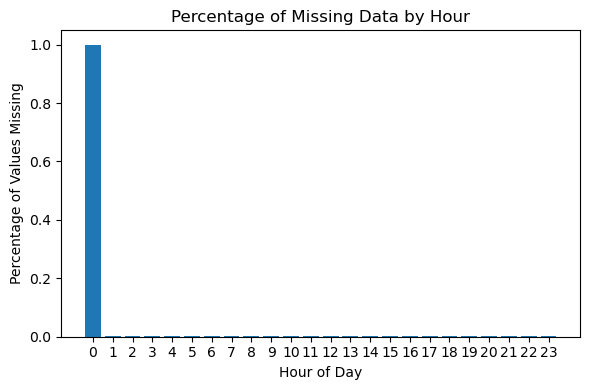

In [ ]:
# Now we will visualise the missingness of the data by hour of the data.

df_h = missing_by_hour_pldf_join.to_pandas()
plt.figure(figsize=(6, 4))
plt.bar(df_h["hour"], df_h["pct_hours_missing_across_locations"])
plt.xlabel("Hour of Day")
plt.ylabel("Percentage of Values Missing")
plt.title("Percentage of Missing Data by Hour")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

In [ ]:
# Check if all weather values are the same for the same timestamp within each city

weather_cols = ["wind_speed", "wind_direction", "temperature", "precipitation", "surface_net_solar_radiation", "surface_solar_radiation_downwards"]

# Step 1: Count unique values for each weather variable per city and timestamp
shared_weather = (
    weather_data_pldf.group_by(["city", "timestamp"])
    .agg([pl.col(name=col).n_unique().alias(name=f"{col}_n_unique") for col in weather_cols])
)

# Step 2: Filter to problematic rows (any weather column has >1 unique value)
problem_mask = (
    (pl.col(name="wind_speed_n_unique") > 1)
    | (pl.col(name="wind_direction_n_unique") > 1)
    | (pl.col(name="temperature_n_unique") > 1)
    | (pl.col(name="precipitation_n_unique") > 1)
    | (pl.col(name="surface_net_solar_radiation_n_unique") > 1)
    | (pl.col(name="surface_solar_radiation_downwards_n_unique") > 1)
)

# Step 3: Split by city and calculate stats
for city in ["delhi", "mumbai"]:
    city_groups = shared_weather.filter(pl.col("city") == city)
    city_issues = city_groups.filter(problem_mask)

    total = city_groups.shape[0]
    inconsistent = city_issues.shape[0]

    print(f"{city.title()}: {inconsistent:,} of {total:,} timestamp groups have differing weather readings.")


Delhi: 45,473 of 47,496 timestamp groups have differing weather readings.
Mumbai: 45,473 of 47,496 timestamp groups have differing weather readings.


Again we can determine that the majority of weather data even within the same city is different for each location, meaning that it should be retained.

Some of the next sections may be slightly redundant to the analysis done above, but is approaching the problem in a different way, so is kept for a comprehensive analysis

##### Data Completeness Checks

In [ ]:
columns_to_check = [
    "wind_speed",
    "wind_direction",
    "temperature",
    "precipitation",
    "surface_net_solar_radiation",
    "surface_solar_radiation_downwards"
]

In [ ]:
# Flattened version of completeness per location
completeness_report = compute_completeness(
    df=weather_data_pldf,
    grouping_col="location",
    columns_to_check=columns_to_check
)

display(completeness_report.head(3))

shape: (3, 17)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ location  ┆ total_row ┆ wind_spee ┆ wind_dire ┆ … ┆ surface_s ┆ avg_compl ┆ min_compl ┆ max_comp │
│ ---       ┆ s         ┆ d_non_nul ┆ ction_non ┆   ┆ olar_radi ┆ eteness   ┆ eteness   ┆ leteness │
│ str       ┆ ---       ┆ l         ┆ _null     ┆   ┆ ation_dow ┆ ---       ┆ ---       ┆ ---      │
│           ┆ u32       ┆ ---       ┆ ---       ┆   ┆ nwa…      ┆ f64       ┆ f64       ┆ f64      │
│           ┆           ┆ u32       ┆ u32       ┆   ┆ ---       ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 010100002 ┆ 47496     ┆ 0         ┆ 0         ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ 0E6100000 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 7A14AE47E ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 12A…      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 010100002 ┆ 47496     ┆ 45473     ┆ 45473     ┆ … ┆ 0.884243  ┆ 0.933022  ┆ 0.884243  ┆ 0.957407 │
│ 0E6100000 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 8EC2F5285 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ C4F…      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 010100002 ┆ 47496     ┆ 45473     ┆ 45473     ┆ … ┆ 0.884264  ┆ 0.933026  ┆ 0.884264  ┆ 0.957407 │
│ 0E6100000 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 8EC2F5285 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ C4F…      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [ ]:
# Transform the completeness report into long format for plotting
plot_df = completeness_transform_long(
    completeness_df=completeness_report,
    grouping_col="location",
    columns_to_check=columns_to_check
)

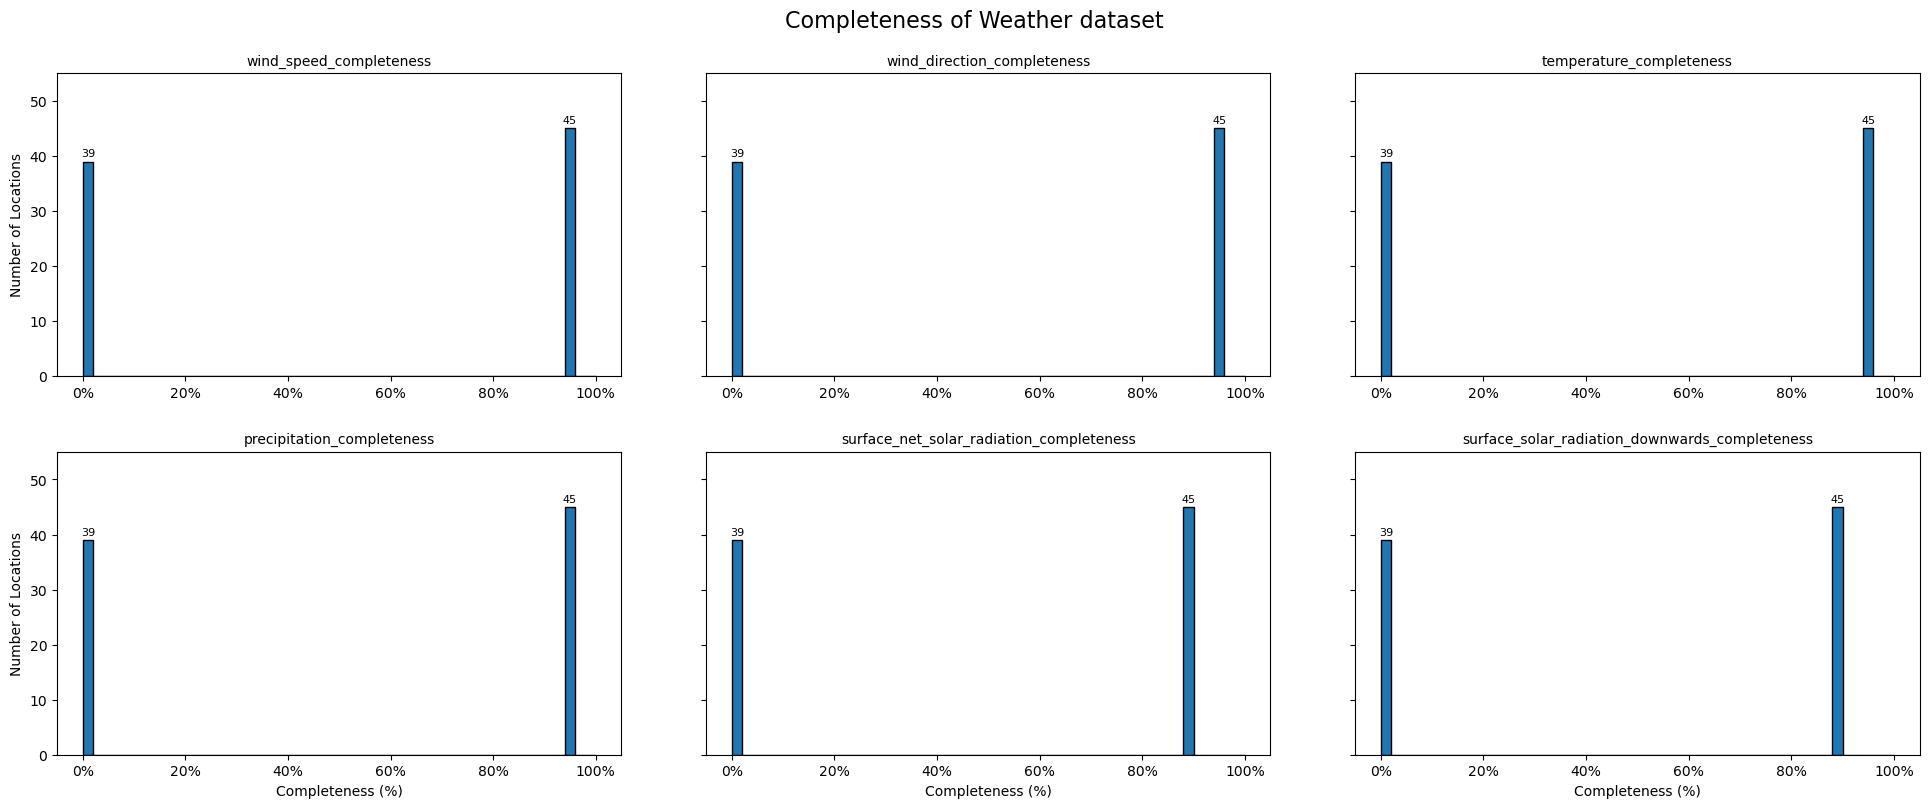

In [ ]:
# Plot
g = sns.FacetGrid(
    plot_df,
    col="column",
    col_wrap=3,
    height=4.0,
    aspect=1.6,
    sharex=True,
    sharey=True,
    despine=False
)

g.map_dataframe(hist_with_counts)

# Formatting
g.set_titles("{col_name}")
g.set_axis_labels("Completeness (%)", "Number of Locations")
for ax in g.axes.flatten():
    ax.set_xlim(-5, 105)
    ax.set_ylim(0, 55)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.xaxis.set_major_formatter(ticker.PercentFormatter())
    ax.tick_params(labelbottom=True)

plt.subplots_adjust(top=0.9, hspace=0.25, wspace=0.15)
g.fig.suptitle("Completeness of Weather dataset", fontsize=16)
plt.show()

In [ ]:
completeness_report.describe()

shape: (9, 18)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ location  ┆ total_row ┆ wind_spee ┆ … ┆ surface_s ┆ avg_compl ┆ min_compl ┆ max_comp │
│ ---       ┆ ---       ┆ s         ┆ d_non_nul ┆   ┆ olar_radi ┆ eteness   ┆ eteness   ┆ leteness │
│ str       ┆ str       ┆ ---       ┆ l         ┆   ┆ ation_dow ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆ f64       ┆ ---       ┆   ┆ nwa…      ┆ f64       ┆ f64       ┆ f64      │
│           ┆           ┆           ┆ f64       ┆   ┆ ---       ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 84        ┆ 84.0      ┆ 84.0      ┆ … ┆ 84.0      ┆ 84.0      ┆ 84.0      ┆ 84.0     │
│ null_coun ┆ 0         ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ mean      ┆ null      ┆ 47496.0   ┆ 24360.535 ┆ … ┆ 0.473713  ┆ 0.499835  ┆ 0.473712  ┆ 0.512897 │
│           ┆           ┆           ┆ 714       ┆   ┆           ┆           ┆           ┆          │
│ std       ┆ null      ┆ 0.0       ┆ 22814.632 ┆ … ┆ 0.443651  ┆ 0.468116  ┆ 0.443651  ┆ 0.480349 │
│           ┆           ┆           ┆ 533       ┆   ┆           ┆           ┆           ┆          │
│ min       ┆ 010100002 ┆ 47496.0   ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│           ┆ 0E6100000 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 14AE47E17 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ A24…      ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 25%       ┆ null      ┆ 47496.0   ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ 50%       ┆ null      ┆ 47496.0   ┆ 45473.0   ┆ … ┆ 0.884264  ┆ 0.933026  ┆ 0.884264  ┆ 0.957407 │
│ 75%       ┆ null      ┆ 47496.0   ┆ 45473.0   ┆ … ┆ 0.884264  ┆ 0.933026  ┆ 0.884264  ┆ 0.957407 │
│ max       ┆ 010100002 ┆ 47496.0   ┆ 45473.0   ┆ … ┆ 0.884264  ┆ 0.933026  ┆ 0.884264  ┆ 0.957407 │
│           ┆ 0E6100000 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ F6285C8FC ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 255…      ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

##### Removing locations with 0% completeness

In [ ]:
# Retrieving the locations with 0% completeness (from average coloumn)
zero_avg_locations = completeness_report.filter(
    pl.col("avg_completeness") == 0
).select("location")

zero_avg_locations.shape

(39, 1)

In [ ]:
# using the locations with 0% completeness to filter out these locations from the weather data
weather_data_pldf_no_null_locations = weather_data_pldf.filter(
    ~pl.col("location").is_in(zero_avg_locations["location"])
)

/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_52556/4316154.py:2: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  weather_data_pldf_no_null_locations = weather_data_pldf.filter(


In [ ]:
# Verify that the locations with 0% completeness have been removed
completeness_report_no_null = weather_data_pldf_no_null_locations.group_by("location").agg(
    [
        pl.len().alias("total_rows"),
        *[pl.col(col).is_not_null().sum().alias(f"{col}_non_null") for col in columns_to_check]
    ]
)
# Display the updated completeness report
display(completeness_report_no_null.head(3))
display(completeness_report_no_null.describe())

shape: (3, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ location   ┆ total_rows ┆ wind_speed ┆ wind_dire ┆ temperatu ┆ precipita ┆ surface_n ┆ surface_s │
│ ---        ┆ ---        ┆ _non_null  ┆ ction_non ┆ re_non_nu ┆ tion_non_ ┆ et_solar_ ┆ olar_radi │
│ str        ┆ u32        ┆ ---        ┆ _null     ┆ ll        ┆ null      ┆ radiation ┆ ation_dow │
│            ┆            ┆ u32        ┆ ---       ┆ ---       ┆ ---       ┆ _no…      ┆ nwa…      │
│            ┆            ┆            ┆ u32       ┆ u32       ┆ u32       ┆ ---       ┆ ---       │
│            ┆            ┆            ┆           ┆           ┆           ┆ u32       ┆ u32       │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 0101000020 ┆ 47496      ┆ 45473      ┆ 45473     ┆ 45473     ┆ 45473     ┆ 41999     ┆ 41999     │
│ E610000028 ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 5C8FC2F548 ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ …          ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 0101000020 ┆ 47496      ┆ 45473      ┆ 45473     ┆ 45473     ┆ 45473     ┆ 41999     ┆ 41999     │
│ E6100000E0 ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 7A14AE4731 ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ …          ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 0101000020 ┆ 47496      ┆ 45473      ┆ 45473     ┆ 45473     ┆ 45473     ┆ 41999     ┆ 41999     │
│ E610000046 ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ E17A14AE37 ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ …          ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
└────────────┴────────────┴────────────┴───────────┴───────────┴───────────┴───────────┴───────────┘

shape: (9, 9)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ location  ┆ total_row ┆ wind_spee ┆ … ┆ temperatu ┆ precipita ┆ surface_n ┆ surface_ │
│ ---       ┆ ---       ┆ s         ┆ d_non_nul ┆   ┆ re_non_nu ┆ tion_non_ ┆ et_solar_ ┆ solar_ra │
│ str       ┆ str       ┆ ---       ┆ l         ┆   ┆ ll        ┆ null      ┆ radiation ┆ diation_ │
│           ┆           ┆ f64       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ _no…      ┆ downwa…  │
│           ┆           ┆           ┆ f64       ┆   ┆ f64       ┆ f64       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 45        ┆ 45.0      ┆ 45.0      ┆ … ┆ 45.0      ┆ 45.0      ┆ 45.0      ┆ 45.0     │
│ null_coun ┆ 0         ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ mean      ┆ null      ┆ 47496.0   ┆ 45473.0   ┆ … ┆ 45473.0   ┆ 45473.0   ┆ 41998.955 ┆ 41998.97 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 556       ┆ 7778     │
│ std       ┆ null      ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.208409  ┆ 0.149071 │
│ min       ┆ 010100002 ┆ 47496.0   ┆ 45473.0   ┆ … ┆ 45473.0   ┆ 45473.0   ┆ 41998.0   ┆ 41998.0  │
│           ┆ 0E6100000 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 285C8FC2F ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 548…      ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 25%       ┆ null      ┆ 47496.0   ┆ 45473.0   ┆ … ┆ 45473.0   ┆ 45473.0   ┆ 41999.0   ┆ 41999.0  │
│ 50%       ┆ null      ┆ 47496.0   ┆ 45473.0   ┆ … ┆ 45473.0   ┆ 45473.0   ┆ 41999.0   ┆ 41999.0  │
│ 75%       ┆ null      ┆ 47496.0   ┆ 45473.0   ┆ … ┆ 45473.0   ┆ 45473.0   ┆ 41999.0   ┆ 41999.0  │
│ max       ┆ 010100002 ┆ 47496.0   ┆ 45473.0   ┆ … ┆ 45473.0   ┆ 45473.0   ┆ 41999.0   ┆ 41999.0  │
│           ┆ 0E6100000 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ F6285C8FC ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 255…      ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [ ]:
display(weather_data_pldf_no_null_locations.sample(n=8, with_replacement=False))

shape: (8, 18)
┌─────────────┬────────────┬────────────┬────────────┬───┬──────┬────────┬────────────┬────────────┐
│ timestamp   ┆ wind_speed ┆ wind_direc ┆ temperatur ┆ … ┆ hour ┆ minute ┆ weekday_in ┆ weekday_na │
│ ---         ┆ ---        ┆ tion       ┆ e          ┆   ┆ ---  ┆ ---    ┆ t          ┆ me         │
│ datetime[μs ┆ decimal[38 ┆ ---        ┆ ---        ┆   ┆ i8   ┆ i8     ┆ ---        ┆ ---        │
│ ]           ┆ ,18]       ┆ decimal[38 ┆ decimal[38 ┆   ┆      ┆        ┆ u8         ┆ str        │
│             ┆            ┆ ,20]       ┆ ,15]       ┆   ┆      ┆        ┆            ┆            │
╞═════════════╪════════════╪════════════╪════════════╪═══╪══════╪════════╪════════════╪════════════╡
│ 2025-03-01  ┆ 6.41364885 ┆ 285.454739 ┆ 17.0526123 ┆ … ┆ 3    ┆ 0      ┆ 6          ┆ Saturday   │
│ 03:00:00    ┆ 9341397000 ┆ 6452285000 ┆ 04687500   ┆   ┆      ┆        ┆            ┆            │
│             ┆            ┆ 0000       ┆            ┆   ┆      ┆        ┆            ┆            │
│ 2022-10-25  ┆ 4.34850268 ┆ 176.466635 ┆ 21.0498962 ┆ … ┆ 15   ┆ 0      ┆ 2          ┆ Tuesday    │
│ 15:00:00    ┆ 2189945000 ┆ 1885154300 ┆ 40234375   ┆   ┆      ┆        ┆            ┆            │
│             ┆            ┆ 0000       ┆            ┆   ┆      ┆        ┆            ┆            │
│ 2024-12-09  ┆ 3.91003710 ┆ 257.220394 ┆ 19.3609313 ┆ … ┆ 7    ┆ 0      ┆ 1          ┆ Monday     │
│ 07:00:00    ┆ 7010076300 ┆ 8107600700 ┆ 96484375   ┆   ┆      ┆        ┆            ┆            │
│             ┆            ┆ 0000       ┆            ┆   ┆      ┆        ┆            ┆            │
│ 2023-03-25  ┆ 4.94934358 ┆ 207.966942 ┆ 21.4049987 ┆ … ┆ 14   ┆ 0      ┆ 6          ┆ Saturday   │
│ 14:00:00    ┆ 3142828000 ┆ 7468288000 ┆ 79296875   ┆   ┆      ┆        ┆            ┆            │
│             ┆            ┆ 0000       ┆            ┆   ┆      ┆        ┆            ┆            │
│ 2020-11-20  ┆ null       ┆ null       ┆ null       ┆ … ┆ 0    ┆ 0      ┆ 5          ┆ Friday     │
│ 00:00:00    ┆            ┆            ┆            ┆   ┆      ┆        ┆            ┆            │
│ 2024-03-03  ┆ 8.97468641 ┆ 159.018871 ┆ 25.4127502 ┆ … ┆ 4    ┆ 0      ┆ 7          ┆ Sunday     │
│ 04:00:00    ┆ 2577947000 ┆ 0463340000 ┆ 44140625   ┆   ┆      ┆        ┆            ┆            │
│             ┆            ┆ 0000       ┆            ┆   ┆      ┆        ┆            ┆            │
│ 2021-06-20  ┆ 4.17145237 ┆ 233.838009 ┆ 25.8872985 ┆ … ┆ 20   ┆ 0      ┆ 7          ┆ Sunday     │
│ 20:00:00    ┆ 1761076000 ┆ 2994912600 ┆ 83984375   ┆   ┆      ┆        ┆            ┆            │
│             ┆            ┆ 0000       ┆            ┆   ┆      ┆        ┆            ┆            │
│ 2023-07-06  ┆ 6.04090764 ┆ 258.916528 ┆ 31.3311462 ┆ … ┆ 9    ┆ 0      ┆ 4          ┆ Thursday   │
│ 09:00:00    ┆ 4990100000 ┆ 5062032400 ┆ 40234375   ┆   ┆      ┆        ┆            ┆            │
│             ┆            ┆ 0000       ┆            ┆   ┆      ┆        ┆            ┆            │
└─────────────┴────────────┴────────────┴────────────┴───┴──────┴────────┴────────────┴────────────┘

##### Profile of Null Values

In [ ]:
# remember that this variable has already been defined: 'columns_to_check'

all_locations = weather_data_pldf_no_null_locations.select("location").unique()

result = all_locations

# Join each column's results
for col in columns_to_check:
    col_result = count_isolated_nulls(weather_data_pldf_no_null_locations, col, ["location"])
    result = result.join(
        col_result,
        on=["location"],
        how="left"  # Keep all locations even if no isolated nulls
    )

# Fill null values with 0 (since no isolated nulls means count is 0)
result = result.fill_null(0)
display(result.sample(n=8, with_replacement=False))

shape: (8, 7)
┌──────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ location     ┆ wind_speed_ ┆ wind_direct ┆ temperature ┆ precipitati ┆ surface_net ┆ surface_sol │
│ ---          ┆ isolated_nu ┆ ion_isolate ┆ _isolated_n ┆ on_isolated ┆ _solar_radi ┆ ar_radiatio │
│ str          ┆ lls         ┆ d_nulls     ┆ ulls        ┆ _nulls      ┆ ation_is…   ┆ n_downwa…   │
│              ┆ ---         ┆ ---         ┆ ---         ┆ ---         ┆ ---         ┆ ---         │
│              ┆ u32         ┆ u32         ┆ u32         ┆ u32         ┆ u32         ┆ u32         │
╞══════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ 0101000020E6 ┆ 1975        ┆ 1975        ┆ 1975        ┆ 1975        ┆ 1824        ┆ 1824        │
│ 100000C2F528 ┆             ┆             ┆             ┆             ┆             ┆             │
│ 5C8F42…      ┆             ┆             ┆             ┆             ┆             ┆             │
│ 0101000020E6 ┆ 1975        ┆ 1975        ┆ 1975        ┆ 1975        ┆ 1824        ┆ 1824        │
│ 100000C2F528 ┆             ┆             ┆             ┆             ┆             ┆             │
│ 5C8F42…      ┆             ┆             ┆             ┆             ┆             ┆             │
│ 0101000020E6 ┆ 1975        ┆ 1975        ┆ 1975        ┆ 1975        ┆ 1824        ┆ 1824        │
│ 100000F6285C ┆             ┆             ┆             ┆             ┆             ┆             │
│ 8FC235…      ┆             ┆             ┆             ┆             ┆             ┆             │
│ 0101000020E6 ┆ 1975        ┆ 1975        ┆ 1975        ┆ 1975        ┆ 1824        ┆ 1824        │
│ 100000C2F528 ┆             ┆             ┆             ┆             ┆             ┆             │
│ 5C8F42…      ┆             ┆             ┆             ┆             ┆             ┆             │
│ 0101000020E6 ┆ 1975        ┆ 1975        ┆ 1975        ┆ 1975        ┆ 1824        ┆ 1824        │
│ 10000046E17A ┆             ┆             ┆             ┆             ┆             ┆             │
│ 14AE37…      ┆             ┆             ┆             ┆             ┆             ┆             │
│ 0101000020E6 ┆ 1975        ┆ 1975        ┆ 1975        ┆ 1975        ┆ 1824        ┆ 1824        │
│ 100000AE47E1 ┆             ┆             ┆             ┆             ┆             ┆             │
│ 7A143E…      ┆             ┆             ┆             ┆             ┆             ┆             │
│ 0101000020E6 ┆ 1975        ┆ 1975        ┆ 1975        ┆ 1975        ┆ 1823        ┆ 1824        │
│ 100000AE47E1 ┆             ┆             ┆             ┆             ┆             ┆             │
│ 7A143E…      ┆             ┆             ┆             ┆             ┆             ┆             │
│ 0101000020E6 ┆ 1975        ┆ 1975        ┆ 1975        ┆ 1975        ┆ 1824        ┆ 1824        │
│ 100000F6285C ┆             ┆             ┆             ┆             ┆             ┆             │
│ 8FC255…      ┆             ┆             ┆             ┆             ┆             ┆             │
└──────────────┴─────────────┴─────────────┴─────────────┴─────────────┴─────────────┴─────────────┘

In [ ]:

# build a list of DataFrames, one per variable
stats_dfs = [
    analyze_null_patterns(weather_data_pldf_no_null_locations, col, ["location"])
    for col in columns_to_check
]

# reduce‑join them all together
final_stats = reduce(
    lambda left, right: left.join(
        right.select(["location"] + [c for c in right.columns if c not in ["location"]]),
        on=["location"],
        how="left"
    ),
    stats_dfs
).fill_null(0)

gap_cols = [f"{c}_gaps" for c in columns_to_check]

final_stats = final_stats.with_columns([
    # this sorts each List<Struct{gap_start, gap_end}> by gap_start (then gap_end if equal)
    pl.col(g).list.sort().alias(g)
    for g in gap_cols
])

display(final_stats.sample(n=8, with_replacement=False))

shape: (8, 19)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ location  ┆ wind_spee ┆ wind_spee ┆ wind_spee ┆ … ┆ surface_n ┆ surface_s ┆ surface_s ┆ surface_ │
│ ---       ┆ d_total_n ┆ d_isolate ┆ d_gaps    ┆   ┆ et_solar_ ┆ olar_radi ┆ olar_radi ┆ solar_ra │
│ str       ┆ ulls      ┆ d_nulls   ┆ ---       ┆   ┆ radiation ┆ ation_dow ┆ ation_dow ┆ diation_ │
│           ┆ ---       ┆ ---       ┆ list[stru ┆   ┆ _ga…      ┆ nwa…      ┆ nwa…      ┆ downwa…  │
│           ┆ u32       ┆ u32       ┆ ct[2]]    ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ list[stru ┆ u32       ┆ u32       ┆ list[str │
│           ┆           ┆           ┆           ┆   ┆ ct[2]]    ┆           ┆           ┆ uct[2]]  │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 010100002 ┆ 2023      ┆ 1975      ┆ [{2019-12 ┆ … ┆ [{2019-12 ┆ 5497      ┆ 1824      ┆ [{2019-1 │
│ 0E6100000 ┆           ┆           ┆ -31 02:00 ┆   ┆ -31 02:00 ┆           ┆           ┆ 2-31 02: │
│ AE47E17A1 ┆           ┆           ┆ :00,2019- ┆   ┆ :00,2019- ┆           ┆           ┆ 00:00,20 │
│ 43E…      ┆           ┆           ┆ 12-…      ┆   ┆ 12-…      ┆           ┆           ┆ 19-12-…  │
│ 010100002 ┆ 2023      ┆ 1975      ┆ [{2019-12 ┆ … ┆ [{2019-12 ┆ 5497      ┆ 1824      ┆ [{2019-1 │
│ 0E6100000 ┆           ┆           ┆ -31 02:00 ┆   ┆ -31 02:00 ┆           ┆           ┆ 2-31 02: │
│ C2F5285C8 ┆           ┆           ┆ :00,2019- ┆   ┆ :00,2019- ┆           ┆           ┆ 00:00,20 │
│ F42…      ┆           ┆           ┆ 12-…      ┆   ┆ 12-…      ┆           ┆           ┆ 19-12-…  │
│ 010100002 ┆ 2023      ┆ 1975      ┆ [{2019-12 ┆ … ┆ [{2019-12 ┆ 5497      ┆ 1824      ┆ [{2019-1 │
│ 0E6100000 ┆           ┆           ┆ -31 02:00 ┆   ┆ -31 02:00 ┆           ┆           ┆ 2-31 02: │
│ 5C8FC2F52 ┆           ┆           ┆ :00,2019- ┆   ┆ :00,2019- ┆           ┆           ┆ 00:00,20 │
│ 83C…      ┆           ┆           ┆ 12-…      ┆   ┆ 12-…      ┆           ┆           ┆ 19-12-…  │
│ 010100002 ┆ 2023      ┆ 1975      ┆ [{2019-12 ┆ … ┆ [{2019-12 ┆ 5497      ┆ 1824      ┆ [{2019-1 │
│ 0E6100000 ┆           ┆           ┆ -31 02:00 ┆   ┆ -31 02:00 ┆           ┆           ┆ 2-31 02: │
│ 8EC2F5285 ┆           ┆           ┆ :00,2019- ┆   ┆ :00,2019- ┆           ┆           ┆ 00:00,20 │
│ C4F…      ┆           ┆           ┆ 12-…      ┆   ┆ 12-…      ┆           ┆           ┆ 19-12-…  │
│ 010100002 ┆ 2023      ┆ 1975      ┆ [{2019-12 ┆ … ┆ [{2019-12 ┆ 5497      ┆ 1824      ┆ [{2019-1 │
│ 0E6100000 ┆           ┆           ┆ -31 02:00 ┆   ┆ -31 02:00 ┆           ┆           ┆ 2-31 02: │
│ 46E17A14A ┆           ┆           ┆ :00,2019- ┆   ┆ :00,2019- ┆           ┆           ┆ 00:00,20 │
│ E37…      ┆           ┆           ┆ 12-…      ┆   ┆ 12-…      ┆           ┆           ┆ 19-12-…  │
│ 010100002 ┆ 2023      ┆ 1975      ┆ [{2019-12 ┆ … ┆ [{2019-12 ┆ 5497      ┆ 1824      ┆ [{2019-1 │
│ 0E6100000 ┆           ┆           ┆ -31 02:00 ┆   ┆ -31 02:00 ┆           ┆           ┆ 2-31 02: │
│ F6285C8FC ┆           ┆           ┆ :00,2019- ┆   ┆ :00,2019- ┆           ┆           ┆ 00:00,20 │
│ 255…      ┆           ┆           ┆ 12-…      ┆   ┆ 12-…      ┆           ┆           ┆ 19-12-…  │
│ 010100002 ┆ 2023      ┆ 1975      ┆ [{2019-12 ┆ … ┆ [{2019-12 ┆ 5497      ┆ 1824      ┆ [{2019-1 │
│ 0E6100000 ┆           ┆           ┆ -31 02:00 ┆   ┆ -31 02:00 ┆           ┆           ┆ 2-31 02: │
│ C2F5285C8 ┆           ┆           ┆ :00,2019- ┆   ┆ :00,2019- ┆           ┆           ┆ 00:00,20 │
│ F42…      ┆           ┆           ┆ 12-…      ┆   ┆ 12-…      ┆           ┆           ┆ 19-12-…  │
│ 010100002 ┆ 2023      ┆ 1975      ┆ [{2019-12 ┆ … ┆ [{2019-12 ┆ 5497      ┆ 1824      ┆ [{2019-1 │
│ 0E6100000 ┆           ┆           ┆ -31 02:00 ┆   ┆ -31 02:00 ┆           ┆           ┆ 2-31 02: │
│ 46E17A14A ┆           ┆           ┆ :00,2019

Based on the sample above we see a few different patterns that we assume hold true to the rest of the dataset

1. There are a significant amount of isolated nulls
    * These can likely be solved through a simple imputation of the mean values surrounding them

2. The date of 2019-12-31 is causing problems for every single variable
    * We can probably drop this date as it is outside our analysis range anyway.

3. All variables have issues (nulls) on the date 2022-10-31.
    * For wind_speed, wind_direction, temperature, and precipitation, the nulls begin at 2022-10-31 00:00:00, but end relatively soon after at 2022-10-31 23:00:00. We should be able to fill this gap by imputing data from the surrounding days.

    * For surface_net_solar_radiation and surface_solar_radiation_downwards, the nulls also begin at 2022-10-31 00:00:00, but last until 2023-04-01 00:00:00. This is a significant gap that will need to be addressed.

##### Visualising Data

###### Locations of datapoints

In [ ]:
# convert location to coordinates
null_locations_only = zero_avg_locations.with_columns(
    lon = pl.col("location").map_elements(lambda h: wkb_to_coords(h)[0], return_dtype=float),
    lat = pl.col("location").map_elements(lambda h: wkb_to_coords(h)[1], return_dtype=float),
)
null_locations_only = null_locations_only.rename({"lon":"longitude", "lat": "latitude"}).drop("location")
display(null_locations_only.sample(3))

shape: (3, 2)
┌───────────┬──────────┐
│ longitude ┆ latitude │
│ ---       ┆ ---      │
│ f64       ┆ f64      │
╞═══════════╪══════════╡
│ 72.47     ┆ 18.9     │
│ 72.57     ┆ 19.3     │
│ 72.87     ┆ 18.6     │
└───────────┴──────────┘

In [ ]:
full_locations_only = (
    weather_data_pldf_no_null_locations.select(
            pl.col("location")
        ).unique()
    ).with_columns(
        lon = pl.col("location").map_elements(lambda h: wkb_to_coords(h)[0], return_dtype=float),
        lat = pl.col("location").map_elements(lambda h: wkb_to_coords(h)[1], return_dtype=float),
    ).rename({"lon": "longitude", "lat": "latitude"}).drop("location")
display(full_locations_only.sample(3))
full_locations_only.describe()


shape: (3, 2)
┌───────────┬──────────┐
│ longitude ┆ latitude │
│ ---       ┆ ---      │
│ f64       ┆ f64      │
╞═══════════╪══════════╡
│ 72.97     ┆ 19.1     │
│ 77.14     ┆ 28.4     │
│ 77.34     ┆ 28.8     │
└───────────┴──────────┘

shape: (9, 3)
┌────────────┬───────────┬───────────┐
│ statistic  ┆ longitude ┆ latitude  │
│ ---        ┆ ---       ┆ ---       │
│ str        ┆ f64       ┆ f64       │
╞════════════╪═══════════╪═══════════╡
│ count      ┆ 45.0      ┆ 45.0      │
│ null_count ┆ 0.0       ┆ 0.0       │
│ mean       ┆ 75.701111 ┆ 25.393333 │
│ std        ┆ 1.991707  ┆ 4.58988   │
│ min        ┆ 72.77     ┆ 18.5      │
│ 25%        ┆ 72.97     ┆ 19.2      │
│ 50%        ┆ 76.94     ┆ 28.5      │
│ 75%        ┆ 77.14     ┆ 28.7      │
│ max        ┆ 77.34     ┆ 28.8      │
└────────────┴───────────┴───────────┘

In [ ]:
# centers & radius (km)
mumbai_center = (19.10, 72.85)
delhi_center  = (28.61, 77.21)
radius = 60
point_radii = 20
point_color_data = "green"
point_color_nulls = "red"
fill_opacity =0.50
marker_shapes = "square"
km_size = 9

outputs_images_directory = "./outputs/images"  # wherever you want
with_df  = full_locations_only      # your with-data DF
zero_df  = null_locations_only      # your no/zero-data DF
with_mum = filter_by_radius(with_df, *mumbai_center, radius)
zero_mum = filter_by_radius(zero_df, *mumbai_center, radius)
with_del = filter_by_radius(with_df, *delhi_center,  radius)
zero_del = filter_by_radius(zero_df, *delhi_center,  radius)

In [ ]:
# All locations, both variants (bigger red for missing to make them pop)
make_map(
    with_df, zero_df,
    title="ERA5 Weather Locations - Full vs Null Data",
    html_basename="era5_data_all",
    output_dir=outputs_images_directory,
    zoom_start=5,
    variant="both",
    point_radius_with=point_radii,
    point_radius_zero=point_radii,
    color_with=point_color_data,
    color_zero=point_color_nulls,
    marker_shape_with=marker_shapes,
    marker_shape_zero=marker_shapes,
    fill_opacity=fill_opacity,
    use_cluster=False,
    square_side_km_with = km_size,
    square_side_km_zero = km_size,

)
# 2) All locations — WITH DATA ONLY (geo-sized squares)
make_map(
    with_df, zero_df,
    title="ERA5 Weather Locations - No Nulls",
    html_basename="era5_data_all_no_nulls",
    output_dir=outputs_images_directory,
    zoom_start=5,
    variant="withdata",
    point_radius_with=point_radii,
    color_withdata_only=point_color_data,
    marker_shape_with=marker_shapes,
    fill_opacity=fill_opacity,
    use_cluster=False,
    square_side_km_with=km_size,
)

# 3) Mumbai — FULL vs NULL (geo-sized squares)
make_map(
    with_mum, zero_mum,
    title="ERA5 Weather Locations - Mumbai — Full vs Null Data",
    html_basename="era5_data_mumbai",
    output_dir=outputs_images_directory,
    center=list(mumbai_center), zoom_start=11,
    variant="both",
    point_radius_with=point_radii,
    point_radius_zero=point_radii,
    color_with=point_color_data,
    color_zero=point_color_nulls,
    marker_shape_with=marker_shapes,
    marker_shape_zero=marker_shapes,
    fill_opacity=fill_opacity,
    use_cluster=False,
    square_side_km_with=km_size,
    square_side_km_zero=km_size,
)

# 4) Mumbai — WITH DATA ONLY (geo-sized squares)
make_map(
    with_mum, zero_mum,
    title="ERA5 Weather Locations - Mumbai — No Nulls",
    html_basename="era5_data_mumbai_no_nulls",
    output_dir=outputs_images_directory,
    center=list(mumbai_center), zoom_start=11,
    variant="withdata",
    point_radius_with=point_radii,
    color_withdata_only=point_color_data,
    marker_shape_with=marker_shapes,
    fill_opacity=fill_opacity,
    use_cluster=False,
    square_side_km_with=km_size,
)

# 5) Delhi — FULL vs NULL (geo-sized squares)
make_map(
    with_del, zero_del,
    title="ERA5 Weather Locations - Delhi — Full vs Null Data",
    html_basename="era5_data_delhi",
    output_dir=outputs_images_directory,
    center=list(delhi_center), zoom_start=11,
    variant="both",
    point_radius_with=point_radii,
    point_radius_zero=point_radii,
    color_with=point_color_data,
    color_zero=point_color_nulls,
    marker_shape_with=marker_shapes,
    marker_shape_zero=marker_shapes,
    fill_opacity=fill_opacity,
    use_cluster=False,
    square_side_km_with=km_size,
    square_side_km_zero=km_size,
)

# 6) Delhi — WITH DATA ONLY (geo-sized squares)
make_map(
    with_del, zero_del,
    title="ERA5 Weather Locations - Delhi — No Nulls",
    html_basename="era5_data_delhi_no_nulls",
    output_dir=outputs_images_directory,
    center=list(delhi_center), zoom_start=11,
    variant="withdata",
    point_radius_with=point_radii,
    color_withdata_only=point_color_data,
    marker_shape_with=marker_shapes,
    fill_opacity=fill_opacity,
    use_cluster=False,
    square_side_km_with=km_size,
)

[ok] wrote ./outputs/images/era5_data_all.html
[ok] wrote ./outputs/images/era5_data_all_no_nulls.html
[ok] wrote ./outputs/images/era5_data_mumbai.html
[ok] wrote ./outputs/images/era5_data_mumbai_no_nulls.html
[ok] wrote ./outputs/images/era5_data_delhi.html
[ok] wrote ./outputs/images/era5_data_delhi_no_nulls.html


'./outputs/images/era5_data_delhi_no_nulls.html'

###### Values

In [ ]:
# Grab a random location
random_location = weather_data_pldf_no_null_locations.select("location").sample(n=1).item()
display(random_location)


'0101000020E6100000285C8FC2F5485340CDCCCCCCCCCC3C40'

In [ ]:
weather_data_pldf_no_null_locations.filter(
    (pl.col('location') == '0101000020E6100000F6285C8FC23553406666666666663C40'),
    (pl.col('timestamp')> datetime.strptime('2023-07-14', '%Y-%m-%d'))
)


shape: (16_512, 18)
┌─────────────┬────────────┬────────────┬────────────┬───┬──────┬────────┬────────────┬────────────┐
│ timestamp   ┆ wind_speed ┆ wind_direc ┆ temperatur ┆ … ┆ hour ┆ minute ┆ weekday_in ┆ weekday_na │
│ ---         ┆ ---        ┆ tion       ┆ e          ┆   ┆ ---  ┆ ---    ┆ t          ┆ me         │
│ datetime[μs ┆ decimal[38 ┆ ---        ┆ ---        ┆   ┆ i8   ┆ i8     ┆ ---        ┆ ---        │
│ ]           ┆ ,18]       ┆ decimal[38 ┆ decimal[38 ┆   ┆      ┆        ┆ u8         ┆ str        │
│             ┆            ┆ ,20]       ┆ ,15]       ┆   ┆      ┆        ┆            ┆            │
╞═════════════╪════════════╪════════════╪════════════╪═══╪══════╪════════╪════════════╪════════════╡
│ 2023-07-14  ┆ 3.80145110 ┆ 291.310545 ┆ 26.2056579 ┆ … ┆ 1    ┆ 0      ┆ 5          ┆ Friday     │
│ 01:00:00    ┆ 6908645000 ┆ 7841759300 ┆ 58984375   ┆   ┆      ┆        ┆            ┆            │
│             ┆            ┆ 0000       ┆            ┆   ┆      ┆        ┆            ┆            │
│ 2023-07-14  ┆ 4.69125019 ┆ 306.348110 ┆ 26.9486389 ┆ … ┆ 2    ┆ 0      ┆ 5          ┆ Friday     │
│ 02:00:00    ┆ 8871235000 ┆ 9387175000 ┆ 16015625   ┆   ┆      ┆        ┆            ┆            │
│             ┆            ┆ 0000       ┆            ┆   ┆      ┆        ┆            ┆            │
│ 2023-07-14  ┆ 4.44851133 ┆ 325.024857 ┆ 28.2941589 ┆ … ┆ 3    ┆ 0      ┆ 5          ┆ Friday     │
│ 03:00:00    ┆ 9791134000 ┆ 5557595000 ┆ 35546875   ┆   ┆      ┆        ┆            ┆            │
│             ┆            ┆ 0000       ┆            ┆   ┆      ┆        ┆            ┆            │
│ 2023-07-14  ┆ 4.07739619 ┆ 333.597004 ┆ 29.2719116 ┆ … ┆ 4    ┆ 0      ┆ 5          ┆ Friday     │
│ 04:00:00    ┆ 2624779500 ┆ 4701698500 ┆ 21093750   ┆   ┆      ┆        ┆            ┆            │
│             ┆            ┆ 0000       ┆            ┆   ┆      ┆        ┆            ┆            │
│ 2023-07-14  ┆ 2.85756883 ┆ 0.58426084 ┆ 30.7115783 ┆ … ┆ 5    ┆ 0      ┆ 5          ┆ Friday     │
│ 05:00:00    ┆ 0720195400 ┆ 9962338600 ┆ 69140625   ┆   ┆      ┆        ┆            ┆            │
│             ┆            ┆ 00         ┆            ┆   ┆      ┆        ┆            ┆            │
│ …           ┆ …          ┆ …          ┆ …          ┆ … ┆ …    ┆ …      ┆ …          ┆ …          │
│ 2025-05-31  ┆ 4.92308997 ┆ 16.6091554 ┆ 30.0756530 ┆ … ┆ 20   ┆ 0      ┆ 6          ┆ Saturday   │
│ 20:00:00    ┆ 4811711000 ┆ 8099232000 ┆ 76171875   ┆   ┆      ┆        ┆            ┆            │
│             ┆            ┆ 000        ┆            ┆   ┆      ┆        ┆            ┆            │
│ 2025-05-31  ┆ 6.40437659 ┆ 358.111699 ┆ 30.0956420 ┆ … ┆ 21   ┆ 0      ┆ 6          ┆ Saturday   │
│ 21:00:00    ┆ 9815924000 ┆ 2988468000 ┆ 89843750   ┆   ┆      ┆        ┆            ┆            │
│             ┆            ┆ 0000       ┆            ┆   ┆      ┆        ┆            ┆            │
│ 2025-05-31  ┆ 7.15401836 ┆ 0.66414749 ┆ 30.0798645 ┆ … ┆ 22   ┆ 0      ┆ 6          ┆ Saturday   │
│ 22:00:00    ┆ 9737592000 ┆ 3001421000 ┆ 01953125   ┆   ┆      ┆        ┆            ┆            │
│             ┆            ┆ 00         ┆            ┆   ┆      ┆        ┆            ┆            │
│ 2025-05-31  ┆ 7.50716403 ┆ 10.8224362 ┆ 29.7992553 ┆ … ┆ 23   ┆ 0      ┆ 6          ┆ Saturday   │
│ 23:00:00    ┆ 2691779500 ┆ 1501468300 ┆ 71093750   ┆   ┆      ┆        ┆            ┆            │
│             ┆            ┆ 000        ┆            ┆   ┆      ┆        ┆            ┆            │
│ 2025-06-01  ┆ null       ┆ null       ┆ null       ┆ … ┆ 0    ┆ 0      ┆ 7          ┆ Sunday     │
│ 00:00:00    ┆            ┆            ┆            ┆   ┆      ┆        ┆            ┆            │
└─────────────┴────────────┴────────────┴────────────┴───┴──────┴────────┴────────────┴────────────┘

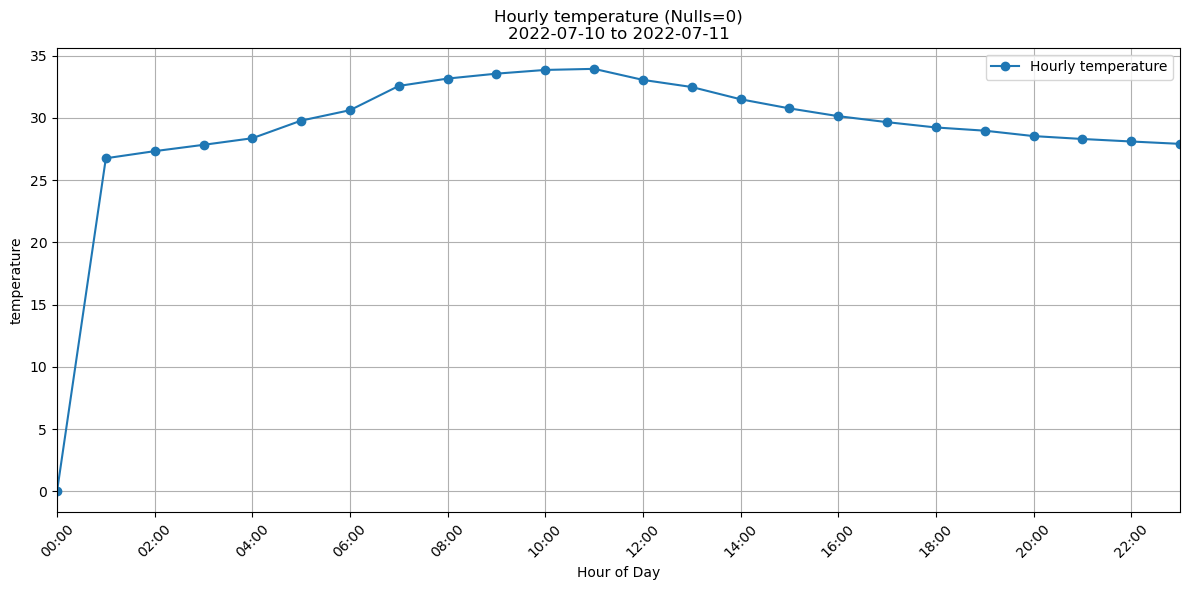

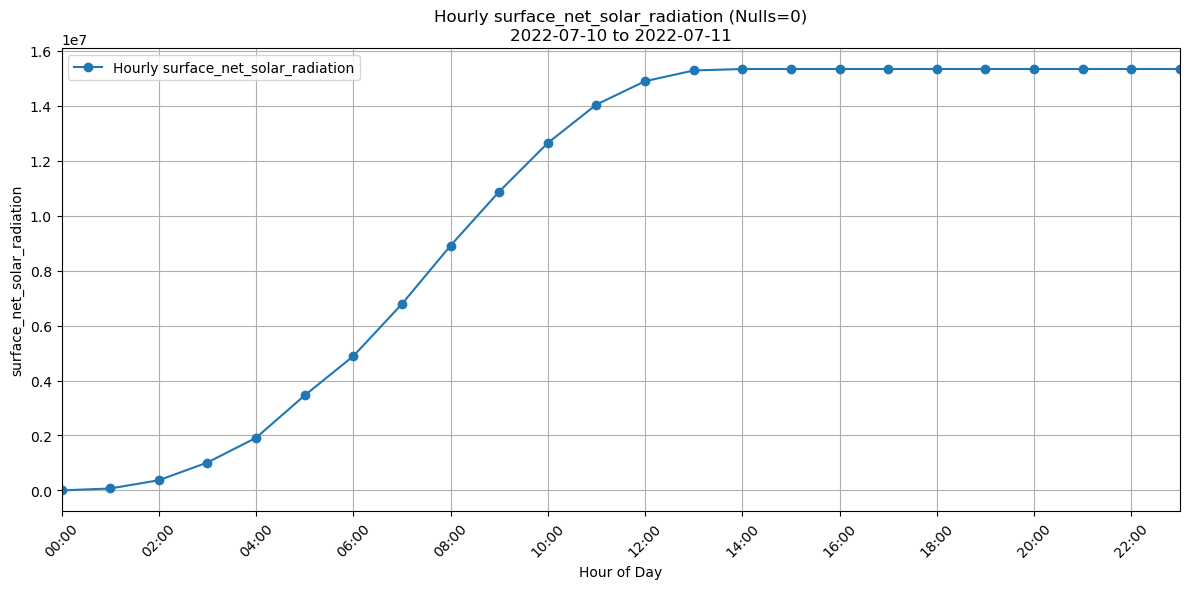

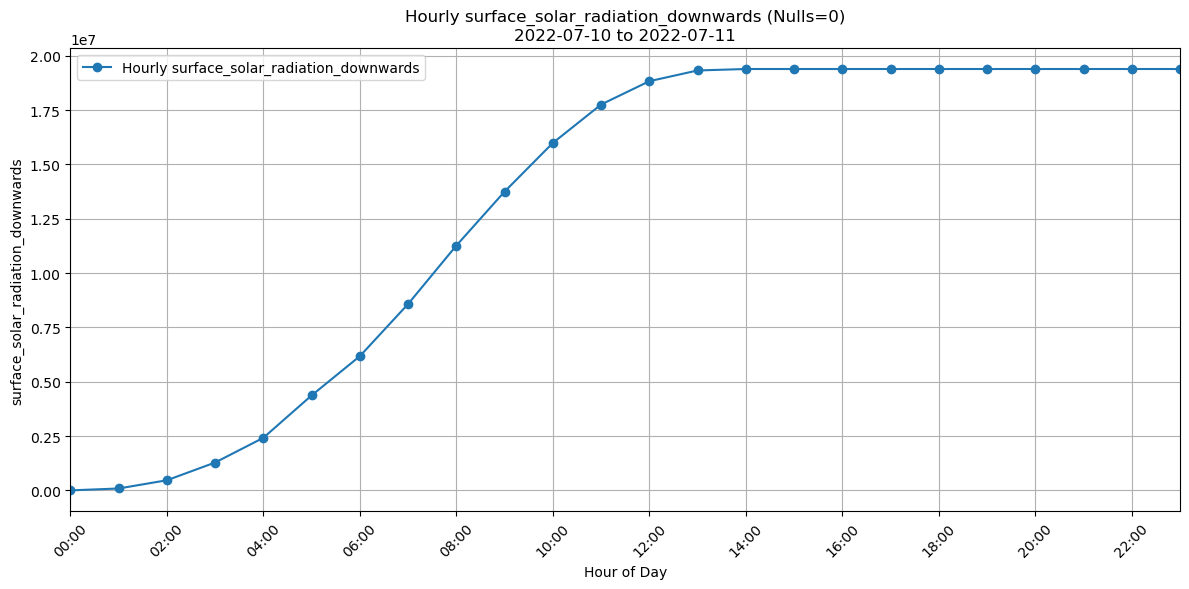

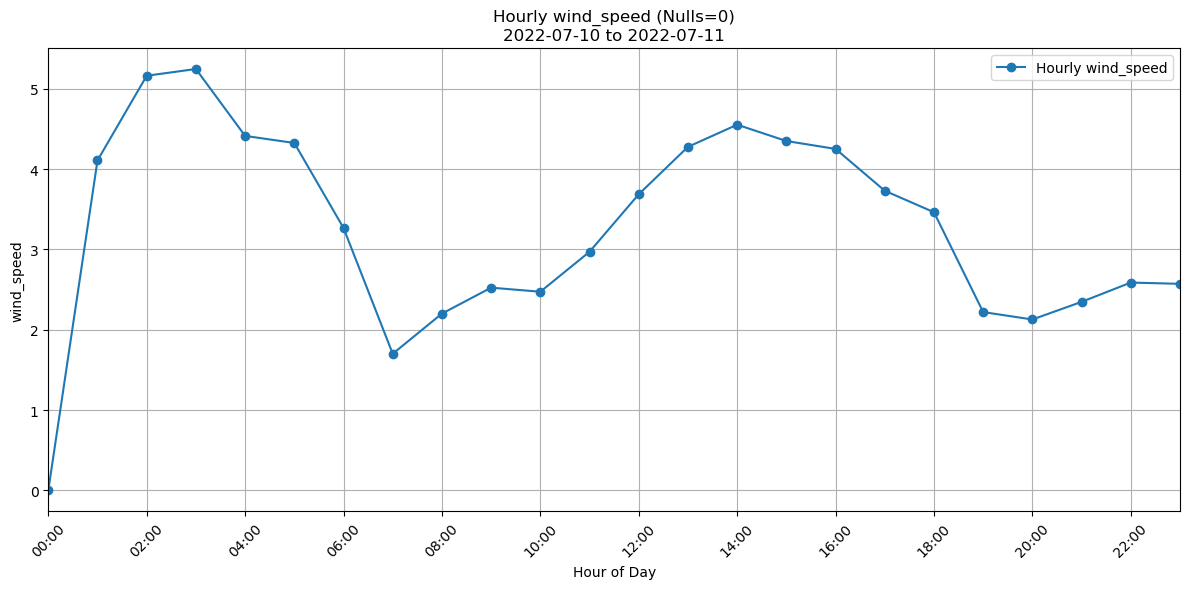

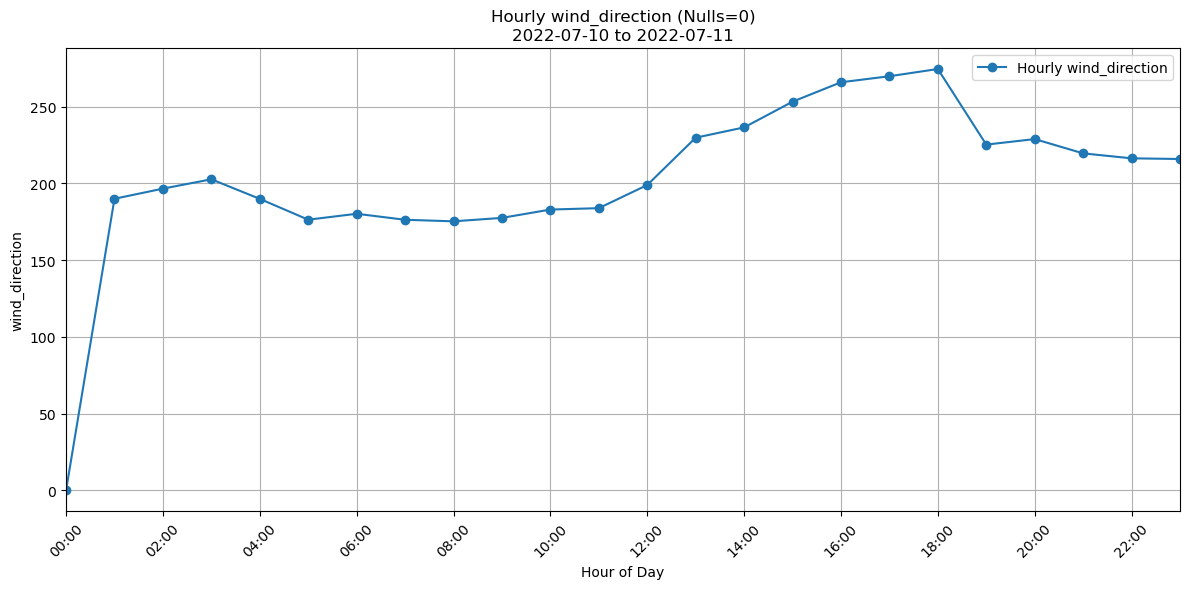

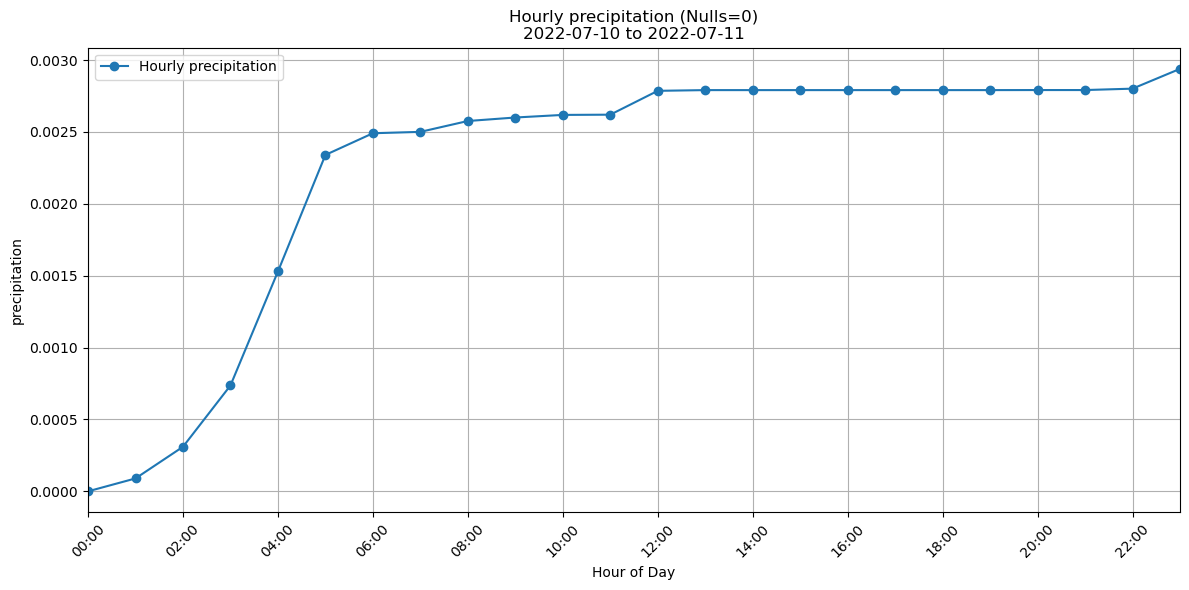

In [ ]:
plot_hourly_averages(
    df=weather_data_pldf_no_null_locations,
    location_id='0101000020E6100000C2F5285C8F4253409999999999993C40',
    start_date="2022-07-10",
    end_date="2022-07-11",
    variables=["temperature", "surface_net_solar_radiation", "surface_solar_radiation_downwards", "wind_speed", "wind_direction", "precipitation"],
)

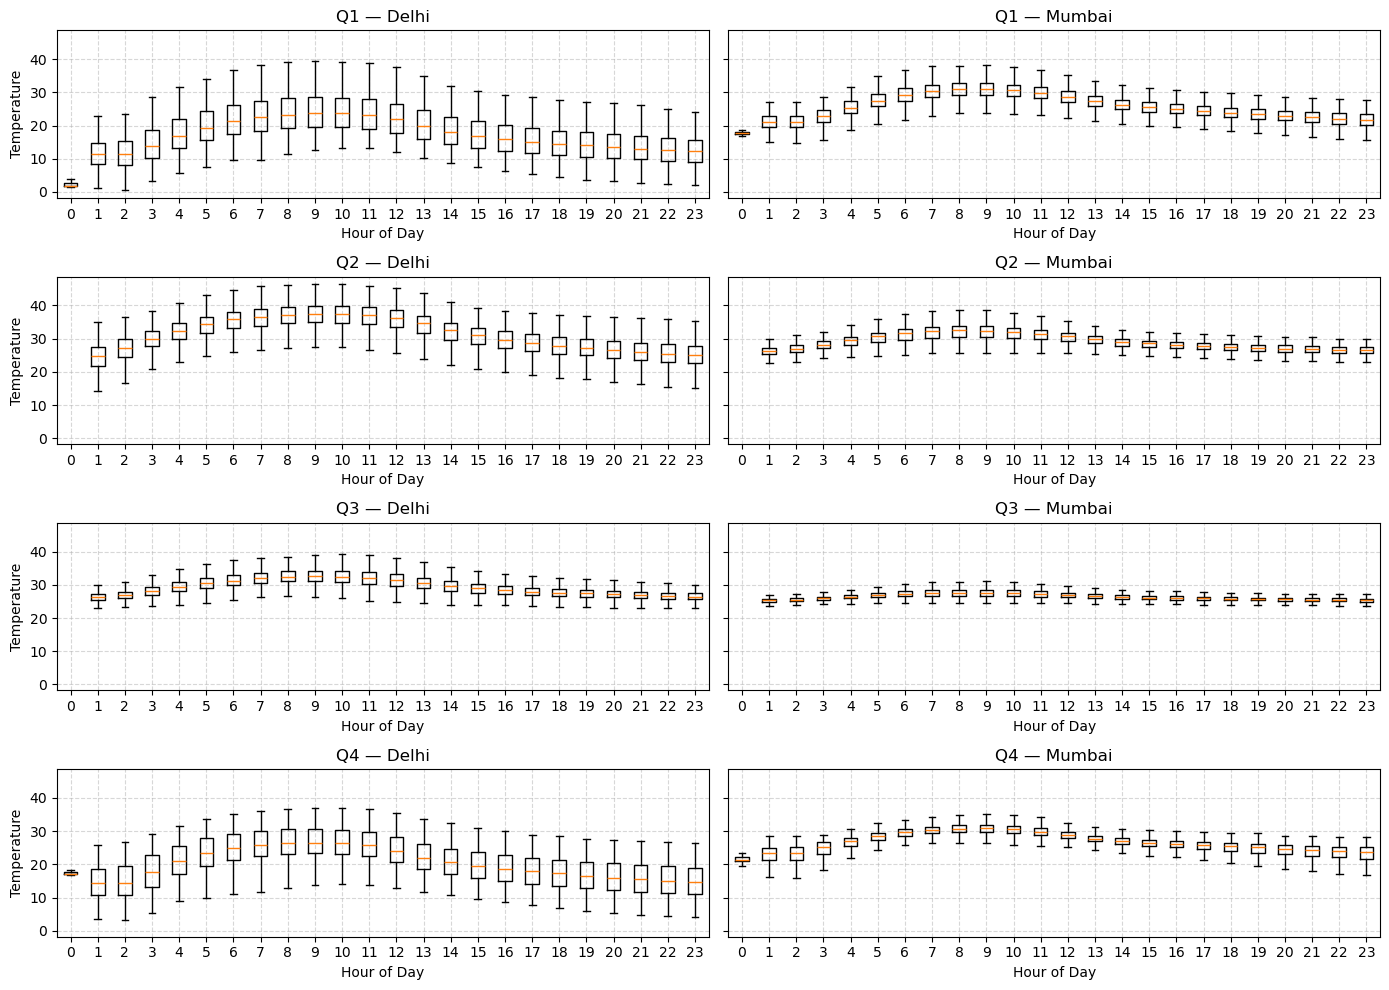

In [ ]:
plot_hourly_boxplots_by_month_or_quarter(
    df=weather_data_pldf_no_null_locations,
    variable="temperature",
    cities=("delhi", "mumbai"),
    use_quarters=True  # Set to True to use quarters instead of months
)

We notice a few things:
* It seems a bit odd that the temperature peaks earlier in the day.
    * Based on the documentation from [ECMWF](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Dateandtimespecification) it appears that the data is recorded in UTC, which is 5 hours and 30 minutes behind Indian Standard Time [IST](https://www.utctime.net/utc-to-ist-indian-converter).
    * Later, we will need to convert our data to local time zone by adding 5 hours and 30 minutes.

* The solar radiation fields appears to be cumulative.
    * The documentation states: "This variable is accumulated from the beginning of the forecast time to the end of the forecast step" [source](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-timeseries?tab=overview)
    * Later, we may way to de-accumulate this data
.
* The precipitation data is not immediately shocking, but based on the documentation we again know that it is accumulated.
    * "This variable is accumulated from the beginning of the forecast time to the end of the forecast step." [source](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-timeseries?tab=overview)
    * Another important part from the documentation is "The units of precipitation are depth in metres. It is the depth the water would have if it were spread evenly over the grid box. Care should be taken when comparing model variables with observations, because observations are often local to a particular point in space and time, rather than representing averages over a model grid box and model time step.".
    * As mentioned - if we gap fill with ERA5 World data, we may need to resolve these differences.


We'll now test adjustments to the cumulative fields to see if we can de-accumulate them.

If these steps works, then they can be used in future processing steps.

In [ ]:
weather_data_pldf_no_null_locations.columns

['timestamp',
 'wind_speed',
 'wind_direction',
 'temperature',
 'city',
 'precipitation',
 'location',
 'surface_net_solar_radiation',
 'surface_solar_radiation_downwards',
 'date',
 'time',
 'year',
 'month',
 'day',
 'hour',
 'minute',
 'weekday_int',
 'weekday_name']

In [ ]:
# Deaccumulate the hourly aggregation for 'precipitation', 'surface_net_solar_radiation', and 'surface_net_solar_radiation_downwards'
weather_data_pldf_no_null_locations = deaccumulate_hourly_weather(
    df=weather_data_pldf_no_null_locations,
    accum_vars=["precipitation", "surface_net_solar_radiation", "surface_solar_radiation_downwards"]
)
# Display the first few rows to verify deaccumulation
display(weather_data_pldf_no_null_locations.head(5))

shape: (5, 21)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ timestamp ┆ wind_spee ┆ wind_dire ┆ temperatu ┆ … ┆ weekday_n ┆ deacc_pre ┆ deacc_sur ┆ deacc_su │
│ ---       ┆ d         ┆ ction     ┆ re        ┆   ┆ ame       ┆ cipitatio ┆ face_net_ ┆ rface_so │
│ datetime[ ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ n         ┆ solar_rad ┆ lar_radi │
│ μs]       ┆ decimal[3 ┆ decimal[3 ┆ decimal[3 ┆   ┆ str       ┆ ---       ┆ iat…      ┆ ation_…  │
│           ┆ 8,18]     ┆ 8,20]     ┆ 8,15]     ┆   ┆           ┆ decimal[3 ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆ 8,28]     ┆ decimal[3 ┆ decimal[ │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 8,17]     ┆ 38,17]   │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2019-12-3 ┆ null      ┆ null      ┆ null      ┆ … ┆ Tuesday   ┆ null      ┆ null      ┆ null     │
│ 1         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 01:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2019-12-3 ┆ null      ┆ null      ┆ null      ┆ … ┆ Tuesday   ┆ null      ┆ null      ┆ null     │
│ 1         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 02:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2019-12-3 ┆ null      ┆ null      ┆ null      ┆ … ┆ Tuesday   ┆ null      ┆ null      ┆ null     │
│ 1         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 03:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2019-12-3 ┆ null      ┆ null      ┆ null      ┆ … ┆ Tuesday   ┆ null      ┆ null      ┆ null     │
│ 1         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 04:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2019-12-3 ┆ null      ┆ null      ┆ null      ┆ … ┆ Tuesday   ┆ null      ┆ null      ┆ null     │
│ 1         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 05:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

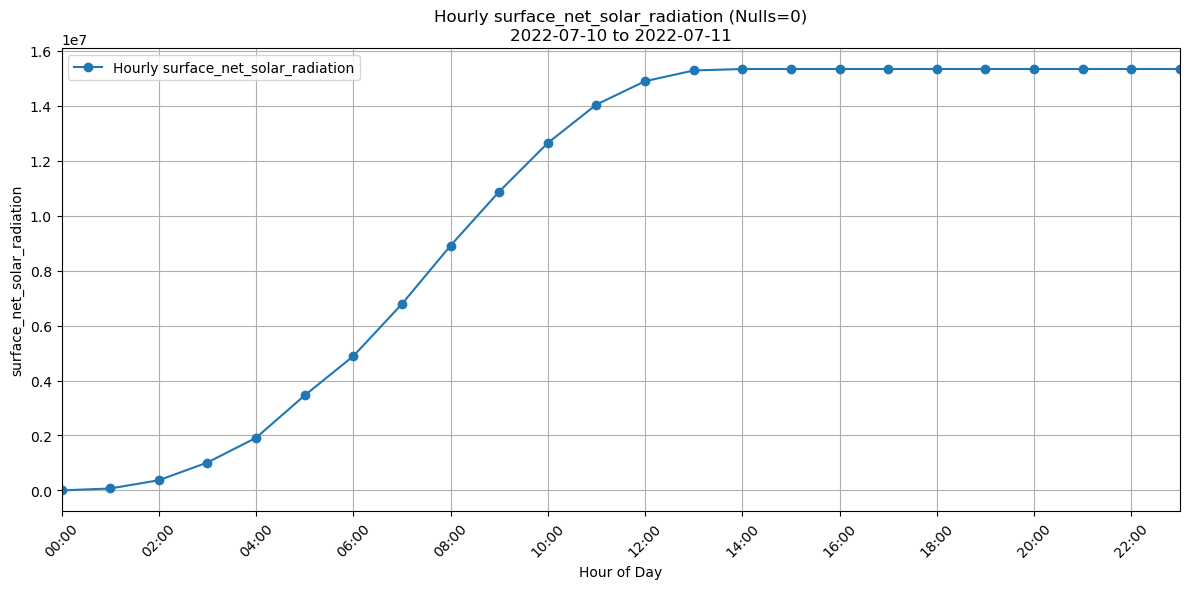

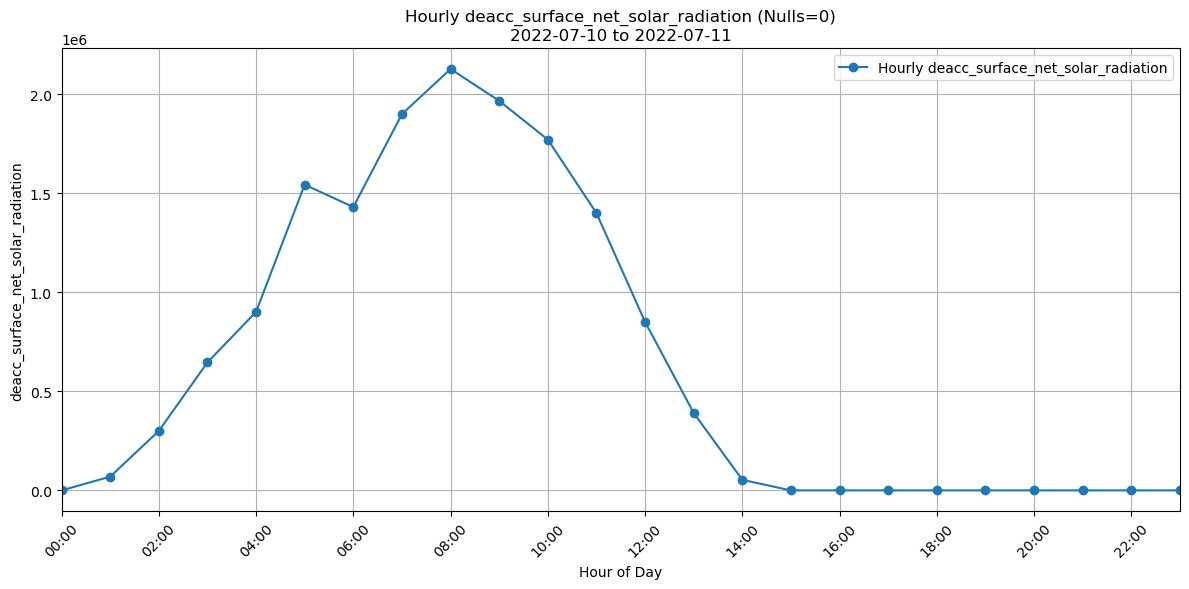

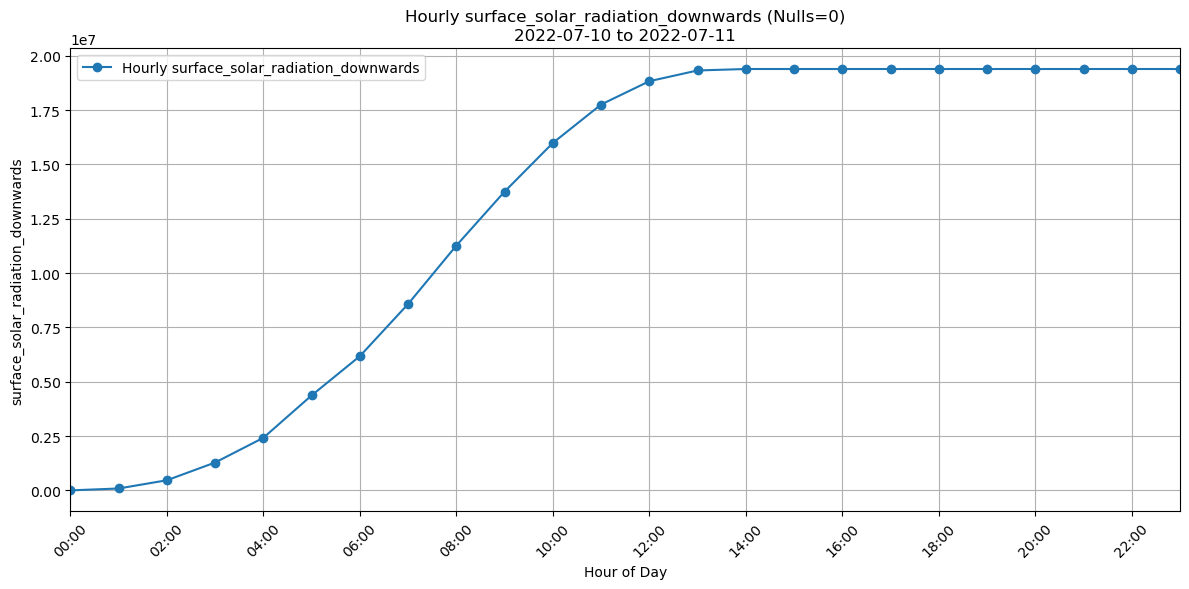

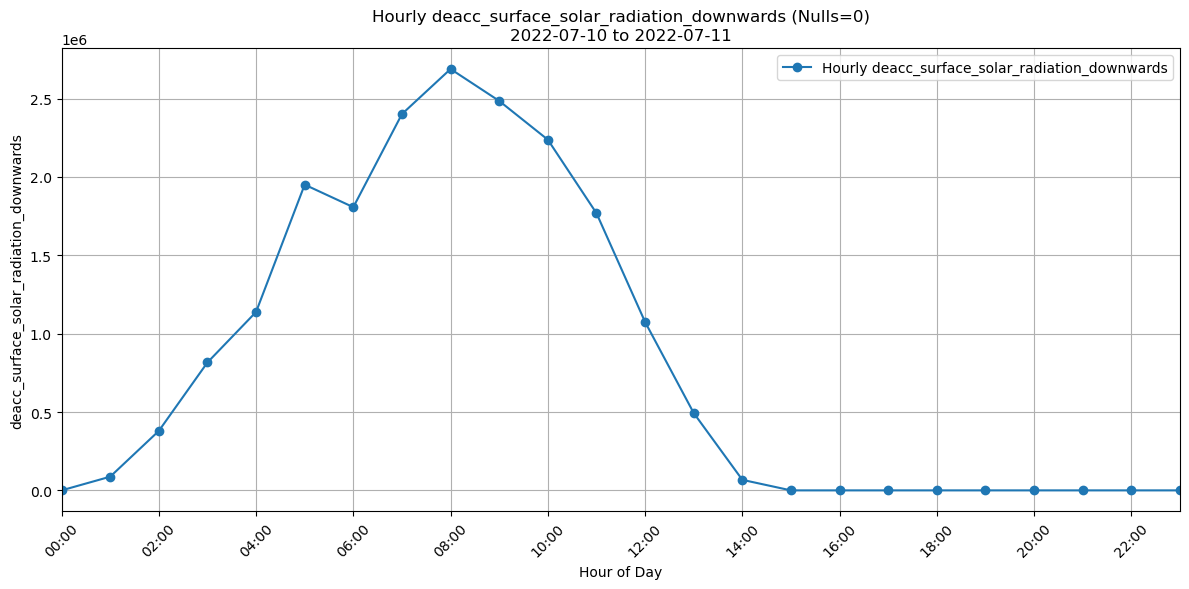

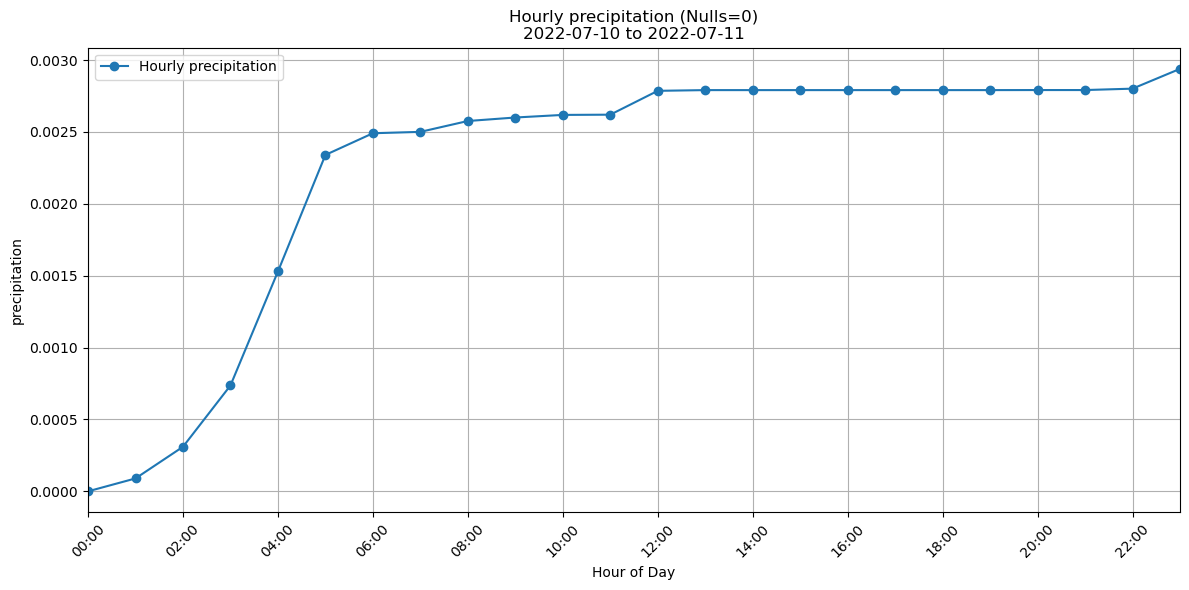

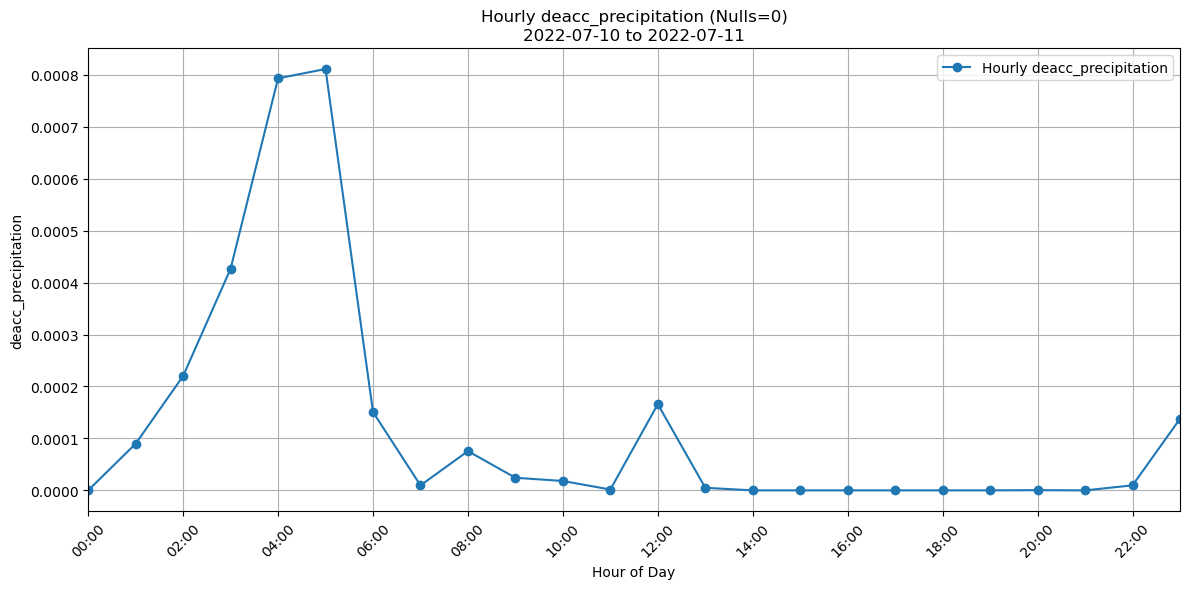

In [ ]:
plot_hourly_averages(
    df=weather_data_pldf_no_null_locations,
    location_id='0101000020E6100000C2F5285C8F4253409999999999993C40',
    start_date="2022-07-10",
    end_date="2022-07-11",
    variables=["surface_net_solar_radiation","deacc_surface_net_solar_radiation", "surface_solar_radiation_downwards", "deacc_surface_solar_radiation_downwards", "precipitation", "deacc_precipitation"],
)

That worked well, but we'll see how it looks when we need to add gap filling into the mix.

#### **ERA5-LAND DATA SUMMARY**

**Contains the following columns:**
* timestamp: Datetime of the measurement in UTC (hourly resolution)
* city: Name of the city ("delhi", "mumbai", etc.)
* location: Geographic identifier of the weather point (e.g., station ID or grid cell)
* wind_speed (m/s): 10m wind speed, derived from u/v components
* wind_direction (degrees): 10m wind direction, derived from u/v components
* temperature (°C): 2m air temperature (originally in Kelvin, converted to Celsius)
* precipitation (m): Total precipitation, accumulated over the forecast step
* surface_net_solar_radiation (J/m²): Net downward solar radiation (accumulated)
* surface_solar_radiation_downwards (J/m²): Downward shortwave solar radiation (accumulated)


**Data Summary:**
* Hourly weather data from 2019-12-31 to 2025-06-01
* 9 core columns capturing meteorological and derived variables
* Covers multiple locations and cities; spatial resolution is approximately 9 km
* Data source: ERA5-Land via the Copernicus Climate Data Store (CDS)


**Key Notes:**
* *Timezone*: All timestamps are in UTC
    * To convert to Indian Standard Time (IST), add 5 hours 30 minutes or set the timezone to Asia/Kolkata
    * Important for aligning weather with energy use, which is tracked in local time

* Solar Radiation (surface_net_solar_radiation, surface_solar_radiation_downwards):
    * Both variables are **cumulative** over each forecast step
    * To convert to power units (W/m²), divide by the number of seconds in the step (typically 3600 seconds for hourly)
    * For analysis, these are de-accumulated to obtain hourly values

* Precipitation (total_precipitation):
    * Also cumulative over the forecast step and recorded in meters of water depth
    * Represents water spread evenly over the model grid box
    * May differ from local station data, which is typically point-baseds

**Quality & Completeness:**
* Some missing timestamps are present in the raw data
    * Midnight (00:00) is often missing for many locations, and 2022-10-31 has widespread gaps
    * Missing data is present in original dataset, not just from processing
    * will need to be gap filled or addressed in analysis

**Additional Notes:**
* Wind components were used to derive:
  * wind_speed = sqrt(u² + v²)
  * wind_direction = atan2(u, v)
    * As you can see the v and u components are swapped from what you may expect. This is how the data was ingested and unfortuneately we cannot change it. We may need to add 180 to the wind_direction to get the real direction (from - which is meteorological convention).

**Documentation:**
* [ERA5-Land Data Documentation](https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation)
* [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview)

## Testing Joins

Now we will attempt to perform some basic joins and analysis

In [ ]:
weather_table_pldf = weather_20250714_pldf


# As a reminder, here are the datasets we are looking at:
print("\n" + "-" * 120)
print("Datasets Overview:\n" + "-" * 120)
print(f"\n\'customers_table_pldf\' contains the customer data with columns \n{customers_table_pldf.columns}")
print(f"\n\'meter_readings_2021_pldf\' contains the electricity meter readings data (2021) with columns \n{meter_readings_2021_pldf.columns}")
print(f"\n\'grid_readings_table_pldf\' contains the emissions data from carbontracker.in with columns \n{grid_readings_table_pldf.columns}")
print(f"\n\'weather_table_pldf\' contains the weather data with columns \n{weather_table_pldf.columns}")


------------------------------------------------------------------------------------------------------------------------
Datasets Overview:
------------------------------------------------------------------------------------------------------------------------

'customers_table_pldf' contains the customer data with columns 
['id', 'location', 'city', 'coordinates']

'meter_readings_2021_pldf' contains the electricity meter readings data (2021) with columns 
['ca_id', 'date', 'value', 'city']

'grid_readings_table_pldf' contains the emissions data from carbontracker.in with columns 
['timestamp', 'thermal_generation', 'gas_generation', 'g_co2_per_kwh', 'hydro_generation', 'nuclear_generation', 'renewable_generation', 'tons_co2', 'total_generation', 'tons_co2_per_mwh', 'demand_met', 'net_demand', 'thermal_emission_factor_tonnes_CO2_per_mwh', 'gas_emission_factor_tonnes_CO2_per_mwh', 'tonnes_CO2_emissions_year_specific', 'CO2_difference', 'relative_CO2_difference']

'weather_table_pldf' 

The ultimate goal will be to join meter readings to location so that we can use the weather data (specified by location) in our marginal emissions calculations.

We will do this in parts:

---
1. Join weather_table_pldf to customers_table_pldf using 'location' from both tables
    * We do this first because this will be a smaller join, and we can save the results relatively easily to avoid repeating this process.
2. Join the results of the above with meter_readings_table_pldf_reduced using 'id' from the customers table and 'ca_id' from meter readings
    * Note that for now we are joining on the reduced dataset, but obviously we will eventually want to perform this join on the table.

---
Keep in mind that as we perform the above joins, we need to be conscious of the various temporal aspects we have here:
* weather_table_pldf contains readings per hour
* meter_readings_table_pldf contains readings per every 15 minutes
* (when eventually integrated) grid_readings_table_pldf contains readings per every 5 minutes

In [ ]:
# Quick look at all of the tables
display(customers_table_pldf.head(5))
display(meter_readings_2021_pldf.head(5))
display(grid_readings_table_pldf.head(5))
display(weather_table_pldf.head(5))

shape: (5, 4)
┌──────────────┬─────────────────────────────────┬────────┬────────────────────────┐
│ id           ┆ location                        ┆ city   ┆ coordinates            │
│ ---          ┆ ---                             ┆ ---    ┆ ---                    │
│ str          ┆ str                             ┆ str    ┆ list[f64]              │
╞══════════════╪═════════════════════════════════╪════════╪════════════════════════╡
│ 900000031184 ┆ 0101000020E6100000D034387CD834… ┆ mumbai ┆ [72.825713, 18.979316] │
│ 900000031173 ┆ 0101000020E6100000A6E7E5C9D834… ┆ mumbai ┆ [72.825732, 18.979353] │
│ 900000084889 ┆ 0101000020E61000007B423C337D36… ┆ mumbai ┆ [72.851392, 19.011059] │
│ 900001013992 ┆ 0101000020E6100000559354647C36… ┆ mumbai ┆ [72.851342, 19.011017] │
│ 900000084824 ┆ 0101000020E61000005EDCE3D87C36… ┆ mumbai ┆ [72.85137, 19.011072]  │
└──────────────┴─────────────────────────────────┴────────┴────────────────────────┘

shape: (5, 4)
┌─────────────┬─────────────────────┬───────┬───────┐
│ ca_id       ┆ date                ┆ value ┆ city  │
│ ---         ┆ ---                 ┆ ---   ┆ ---   │
│ i64         ┆ str                 ┆ f64   ┆ str   │
╞═════════════╪═════════════════════╪═══════╪═══════╡
│ 60005549047 ┆ 2021-12-01 00:00:00 ┆ 0.122 ┆ delhi │
│ 60023930583 ┆ 2021-12-01 00:00:00 ┆ 0.09  ┆ delhi │
│ 60003536707 ┆ 2021-12-01 00:00:00 ┆ 0.0   ┆ delhi │
│ 60004180638 ┆ 2021-12-01 00:00:00 ┆ 0.023 ┆ delhi │
│ 60020144238 ┆ 2021-12-01 00:00:00 ┆ 0.409 ┆ delhi │
└─────────────┴─────────────────────┴───────┴───────┘

shape: (5, 17)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ timestamp ┆ thermal_g ┆ gas_gener ┆ g_co2_per ┆ … ┆ gas_emiss ┆ tonnes_CO ┆ CO2_diffe ┆ relative │
│ ---       ┆ eneration ┆ ation     ┆ _kwh      ┆   ┆ ion_facto ┆ 2_emissio ┆ rence     ┆ _CO2_dif │
│ datetime[ ┆ ---       ┆ ---       ┆ ---       ┆   ┆ r_tonnes_ ┆ ns_year_s ┆ ---       ┆ ference  │
│ μs]       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ CO2…      ┆ pec…      ┆ f64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ ---       ┆ ---       ┆           ┆ f64      │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆ f64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2022-01-0 ┆ 136202.0  ┆ 2901.0    ┆ 815.57308 ┆ … ┆ 0.478     ┆ 11216.019 ┆ 47.6296   ┆ 0.004265 │
│ 4         ┆           ┆           ┆ 8         ┆   ┆           ┆ 5         ┆           ┆          │
│ 17:05:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2022-01-0 ┆ 136202.0  ┆ 2901.0    ┆ 815.57308 ┆ … ┆ 0.478     ┆ 11216.019 ┆ 47.6296   ┆ 0.004265 │
│ 4         ┆           ┆           ┆ 8         ┆   ┆           ┆ 5         ┆           ┆          │
│ 17:10:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2022-01-0 ┆ 136202.0  ┆ 2901.0    ┆ 815.57308 ┆ … ┆ 0.478     ┆ 11216.019 ┆ 47.6296   ┆ 0.004265 │
│ 4         ┆           ┆           ┆ 8         ┆   ┆           ┆ 5         ┆           ┆          │
│ 17:15:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2022-01-0 ┆ 136202.0  ┆ 2901.0    ┆ 815.57308 ┆ … ┆ 0.478     ┆ 11216.019 ┆ 47.6296   ┆ 0.004265 │
│ 4         ┆           ┆           ┆ 8         ┆   ┆           ┆ 5         ┆           ┆          │
│ 17:20:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2022-01-0 ┆ 136202.0  ┆ 2901.0    ┆ 815.57308 ┆ … ┆ 0.478     ┆ 11216.019 ┆ 47.6296   ┆ 0.004265 │
│ 4         ┆           ┆           ┆ 8         ┆   ┆           ┆ 5         ┆           ┆          │
│ 17:25:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

shape: (5, 9)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ timestamp ┆ wind_spee ┆ wind_dire ┆ temperatu ┆ … ┆ precipita ┆ location  ┆ surface_n ┆ surface_ │
│ ---       ┆ d         ┆ ction     ┆ re        ┆   ┆ tion      ┆ ---       ┆ et_solar_ ┆ solar_ra │
│ datetime[ ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ str       ┆ radiation ┆ diation_ │
│ μs]       ┆ decimal[3 ┆ decimal[3 ┆ decimal[3 ┆   ┆ decimal[3 ┆           ┆ ---       ┆ downwa…  │
│           ┆ 8,18]     ┆ 8,20]     ┆ 8,15]     ┆   ┆ 8,28]     ┆           ┆ decimal[3 ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 8,17]     ┆ decimal[ │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 38,17]   │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2024-12-1 ┆ 8.0135750 ┆ 105.09231 ┆ 15.975219 ┆ … ┆ 0.0000000 ┆ 010100002 ┆ 12296608. ┆ 14926616 │
│ 3         ┆ 209997540 ┆ 811866465 ┆ 726562500 ┆   ┆ 000000000 ┆ 0E6100000 ┆ 000000000 ┆ .0000000 │
│ 13:00:00  ┆ 00        ┆ 000000    ┆           ┆   ┆ 000000000 ┆ F6285C8FC ┆ 00000000  ┆ 00000000 │
│           ┆           ┆           ┆           ┆   ┆ 000       ┆ 255…      ┆           ┆ 00       │
│ 2024-12-1 ┆ 8.2898839 ┆ 110.72614 ┆ 14.646026 ┆ … ┆ 0.0000000 ┆ 010100002 ┆ 12108108. ┆ 14736050 │
│ 3         ┆ 579056100 ┆ 327536141 ┆ 611328125 ┆   ┆ 000000000 ┆ 0E6100000 ┆ 000000000 ┆ .0000000 │
│ 14:00:00  ┆ 00        ┆ 000000    ┆           ┆   ┆ 000000000 ┆ F6285C8FC ┆ 00000000  ┆ 00000000 │
│           ┆           ┆           ┆           ┆   ┆ 000       ┆ 235…      ┆           ┆ 00       │
│ 2024-12-1 ┆ 8.3368909 ┆ 110.27725 ┆ 14.629241 ┆ … ┆ 0.0000000 ┆ 010100002 ┆ 12149601. ┆ 14737817 │
│ 3         ┆ 544112030 ┆ 102589554 ┆ 943359375 ┆   ┆ 000000000 ┆ 0E6100000 ┆ 000000000 ┆ .0000000 │
│ 14:00:00  ┆ 00        ┆ 000000    ┆           ┆   ┆ 000000000 ┆ 5C8FC2F52 ┆ 00000000  ┆ 00000000 │
│           ┆           ┆           ┆           ┆   ┆ 000       ┆ 83C…      ┆           ┆ 00       │
│ 2024-12-1 ┆ 8.4037264 ┆ 109.70666 ┆ 14.623779 ┆ … ┆ 0.0000000 ┆ 010100002 ┆ 12240716. ┆ 14738703 │
│ 3         ┆ 682871980 ┆ 556656998 ┆ 296875000 ┆   ┆ 000000000 ┆ 0E6100000 ┆ 000000000 ┆ .0000000 │
│ 14:00:00  ┆ 00        ┆ 000000    ┆           ┆   ┆ 000000000 ┆ C2F5285C8 ┆ 00000000  ┆ 00000000 │
│           ┆           ┆           ┆           ┆   ┆ 000       ┆ F42…      ┆           ┆ 00       │
│ 2024-12-1 ┆ 8.4546371 ┆ 109.04352 ┆ 14.611297 ┆ … ┆ 0.0000000 ┆ 010100002 ┆ 12278334. ┆ 14740205 │
│ 3         ┆ 908084070 ┆ 821446052 ┆ 607421875 ┆   ┆ 000000000 ┆ 0E6100000 ┆ 000000000 ┆ .0000000 │
│ 14:00:00  ┆ 00        ┆ 000000    ┆           ┆   ┆ 000000000 ┆ 285C8FC2F ┆ 00000000  ┆ 00000000 │
│           ┆           ┆           ┆           ┆   ┆ 000       ┆ 548…      ┆           ┆ 00       │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

### customers <-> weather

We'll first perform a quick evaluation of the join to ensure it is possible in the way that we anticipate

In [ ]:
# location columns
customers_location_lengths = customers_table_pldf.select(
    pl.col("location").str.len_bytes().alias("location_length")
).to_series()
weather_location_lengths = weather_table_pldf.select(
    pl.col("location").str.len_bytes().alias("location_length")
).to_series()

print("\n" + "-" * 120)
print(f"Count of 'location' values by length:\n" + "-" * 120)
print(f"Customers Table 'location' lengths:\n{customers_location_lengths.value_counts().sort('location_length')}")
print(f"Weather Table 'location' lengths:\n{weather_location_lengths.value_counts().sort('location_length')}")


------------------------------------------------------------------------------------------------------------------------
Count of 'location' values by length:
------------------------------------------------------------------------------------------------------------------------
Customers Table 'location' lengths:
shape: (1, 2)
┌─────────────────┬────────┐
│ location_length ┆ count  │
│ ---             ┆ ---    │
│ u32             ┆ u32    │
╞═════════════════╪════════╡
│ 50              ┆ 225683 │
└─────────────────┴────────┘
Weather Table 'location' lengths:
shape: (1, 2)
┌─────────────────┬─────────┐
│ location_length ┆ count   │
│ ---             ┆ ---     │
│ u32             ┆ u32     │
╞═════════════════╪═════════╡
│ 50              ┆ 3989664 │
└─────────────────┴─────────┘


In [ ]:
# Sample values from the 'location' column in the customers table
print("\n" + "-" * 120)
print(f"Sample values from 'location' column in 'customers_table_pldf':\n" + "-" * 120)
sample_customer_locations = customers_table_pldf.select(
    pl.col("location")
).unique().sort("location").head(10)
print(sample_customer_locations)

# Sample values from the 'location' column in the weather table
print("\n" + "-" * 120)
print(f"Sample values from 'location' column in 'weather_table_pldf':\n" + "-" * 120)
sample_weather_locations = weather_table_pldf.select(
    pl.col("location")
).unique().sort("location").head(10)
print(sample_weather_locations)


------------------------------------------------------------------------------------------------------------------------
Sample values from 'location' column in 'customers_table_pldf':
------------------------------------------------------------------------------------------------------------------------
shape: (10, 1)
┌─────────────────────────────────┐
│ location                        │
│ ---                             │
│ str                             │
╞═════════════════════════════════╡
│ 0101000020E6100000000000000000… │
│ 0101000020E61000000000421C9249… │
│ 0101000020E610000000014AC7054B… │
│ 0101000020E610000000014AC78543… │
│ 0101000020E610000000014AC78549… │
│ 0101000020E610000000018CE39748… │
│ 0101000020E610000000018CE3D748… │
│ 0101000020E6100000000252727948… │
│ 0101000020E61000000002948E0B49… │
│ 0101000020E61000000002F7B88648… │
└─────────────────────────────────┘

-----------------------------------------------------------------------------------------------------

In [ ]:
# Count of Unique locations in each DataFrame
print("\n" + "-" * 120)
print("Unique locations in each DataFrame:\n" + "-" * 120)
print(f"Weather Readings: {weather_table_pldf['location'].n_unique()}")
print(f"Customers: {customers_table_pldf['location'].n_unique()}")

customer_locations_list = customers_table_pldf['location'].implode()  # -> Series of list type

print("\n" + "-" * 120)
print("Matching and Non-Matching Locations:\n" + "-" * 120)

matching_locations_count = weather_table_pldf.filter(pl.col('location').is_in(customer_locations_list))['location'].n_unique()
print(f"Number of Unique Weather locations that match Customers locations: {matching_locations_count}")

non_matching_locations_count = weather_table_pldf.filter(~pl.col('location').is_in(customer_locations_list))['location'].n_unique()
print(f"Number of Unique Weather locations that do NOT match Customers locations: {non_matching_locations_count}")


------------------------------------------------------------------------------------------------------------------------
Unique locations in each DataFrame:
------------------------------------------------------------------------------------------------------------------------
Weather Readings: 84
Customers: 220569

------------------------------------------------------------------------------------------------------------------------
Matching and Non-Matching Locations:
------------------------------------------------------------------------------------------------------------------------
Number of Unique Weather locations that match Customers locations: 0
Number of Unique Weather locations that do NOT match Customers locations: 84


Unfortunately, we're not seeing any matches based on those location codes. Lets validate the datatypes and the formatting

In [ ]:
print(weather_table_pldf.schema)
print(customers_table_pldf.schema)

Schema([('timestamp', Datetime(time_unit='us', time_zone=None)), ('wind_speed', Decimal(precision=38, scale=18)), ('wind_direction', Decimal(precision=38, scale=20)), ('temperature', Decimal(precision=38, scale=15)), ('city', String), ('precipitation', Decimal(precision=38, scale=28)), ('location', String), ('surface_net_solar_radiation', Decimal(precision=38, scale=17)), ('surface_solar_radiation_downwards', Decimal(precision=38, scale=17))])
Schema([('id', String), ('location', String), ('city', String), ('coordinates', List(Float64))])


In [ ]:
weather_table_pldf = weather_table_pldf.with_columns(
    pl.col("location").cast(pl.Utf8).str.strip_chars().str.to_lowercase()
)

customers_table_pldf = customers_table_pldf.with_columns(
    pl.col("location").cast(pl.Utf8).str.strip_chars().str.to_lowercase()
)


In [ ]:
customer_locations_list = customers_table_pldf['location'].implode()  # -> Series of list type

print("\n" + "-" * 120)
print("Matching and Non-Matching Locations:\n" + "-" * 120)

matching_locations_count = weather_table_pldf.filter(pl.col('location').is_in(customer_locations_list))['location'].n_unique()
print(f"Number of Unique Weather locations that match Customers locations: {matching_locations_count}")

non_matching_locations_count = weather_table_pldf.filter(~pl.col('location').is_in(customer_locations_list))['location'].n_unique()
print(f"Number of Unique Weather locations that do NOT match Customers locations: {non_matching_locations_count}")


------------------------------------------------------------------------------------------------------------------------
Matching and Non-Matching Locations:
------------------------------------------------------------------------------------------------------------------------
Number of Unique Weather locations that match Customers locations: 0
Number of Unique Weather locations that do NOT match Customers locations: 84


Unfortunately it doesn't look as if these locations exactly match. We'll try changing the coordinates to lat-long, and then matching the coordinates to their nearest neighbors spatially.

#### Geospatial Matching

In [ ]:
print(customers_table_pldf.columns)
print(weather_table_pldf.columns)


['id', 'location', 'city', 'coordinates']
['timestamp', 'wind_speed', 'wind_direction', 'temperature', 'city', 'precipitation', 'location', 'surface_net_solar_radiation', 'surface_solar_radiation_downwards']


Our first step is to convert the location data into longitude and latitude

In [ ]:
# Convert Polars DataFrames to Pandas DataFrames for easier manipulation with lambda functions
customers_pddf = customers_table_pldf.to_pandas()
weather_pddf = weather_table_pldf.to_pandas()

# Decode the 'location' hex values into latitude and longitude coordinates
# and add them as new columns 'lon' and 'lat' in both DataFrames
customers_pddf[["lon", "lat"]] = customers_pddf["location"].apply(
    lambda x: pd.Series(wkb_to_coords(x))
)
weather_pddf[["lon", "lat"]] = weather_pddf["location"].apply(
    lambda x: pd.Series(wkb_to_coords(x))
)

Now that we have lat and long, we can begin working with geospatial packages like geopandas & shapely

In [ ]:
# Convert to GeoDataFrames and add geometry with EPSG:4326 CRS
gdf_customers = gpd.GeoDataFrame(
    customers_pddf,
    geometry=[Point(xy) for xy in zip(customers_pddf["lon"], customers_pddf["lat"])],
    crs="EPSG:4326"
)

gdf_weather = gpd.GeoDataFrame(
    weather_pddf,
    geometry=[Point(xy) for xy in zip(weather_pddf["lon"], weather_pddf["lat"])],
    crs="EPSG:4326"
)

In [ ]:
print(f"Type of 'gdf_customers' variable : {type(gdf_customers)}")

display(gdf_customers.head(2))
display(gdf_weather.head(2))

Type of 'gdf_customers' variable : <class 'geopandas.geodataframe.GeoDataFrame'>


id                                           location    city  \
0  900000031184  0101000020e6100000d034387cd834524068716b77b4fa...  mumbai   
1  900000031173  0101000020e6100000a6e7e5c9d8345240148145d9b6fa...  mumbai   

                  coordinates        lon        lat                   geometry  
0   [72.82571321, 18.9793162]  72.825713  18.979316  POINT (72.82571 18.97932)  
1  [72.82573173, 18.97935255]  72.825732  18.979353  POINT (72.82573 18.97935)

timestamp            wind_speed            wind_direction  \
0 2024-12-13 13:00:00  8.013575020999754000  105.09231811866465000000   
1 2024-12-13 14:00:00  8.289883957905610000  110.72614327536141000000   

          temperature   city precipitation  \
0  15.975219726562500  delhi         0E-28   
1  14.646026611328125  delhi         0E-28   

                                            location  \
0  0101000020e6100000f6285c8fc2555340666666666666...   
1  0101000020e6100000f6285c8fc2355340cdcccccccccc...   

  surface_net_solar_radiation surface_solar_radiation_downwards    lon   lat  \
0  12296608.00000000000000000        14926616.00000000000000000  77.34  28.4   
1  12108108.00000000000000000        14736050.00000000000000000  76.84  28.8   

             geometry  
0  POINT (77.34 28.4)  
1  POINT (76.84 28.8)

As expected, it looks like there is a difference in granularity here.
The customers data appears to be much more granular whereas the weather data is covering a larger area.
Our first strategy is to attempt an exact match, but it is unlikely that this will work.

In [ ]:
# Exact Match on coordinates
exact_matching_customers_and_weather = gdf_customers.merge(
    gdf_weather,
    on=["lon", "lat"],
    suffixes=("_customer", "_weather")
)

# Drop duplicate columns and only keep relevant columns
# exact_matching_customers_and_weather = exact_matching_customers_and_weather[["id", "location_customer", "location_weather"]].drop_duplicates()

# Display the exact matching customers and weather locations
print(f"Columns in 'exact_matching_customers_and_weather' gdf: \n{exact_matching_customers_and_weather.columns}\n")

print(f"Type of 'exact_matching_customers_and_weather' variable : {type(exact_matching_customers_and_weather)}\n")

print(f"First 5 rows of 'exact_matching_customers_and_weather':")
display(exact_matching_customers_and_weather.head(5))

Columns in 'exact_matching_customers_and_weather' gdf: 
Index(['id', 'location_customer', 'city_customer', 'coordinates', 'lon', 'lat',
       'geometry_customer', 'timestamp', 'wind_speed', 'wind_direction',
       'temperature', 'city_weather', 'precipitation', 'location_weather',
       'surface_net_solar_radiation', 'surface_solar_radiation_downwards',
       'geometry_weather'],
      dtype='object')

Type of 'exact_matching_customers_and_weather' variable : <class 'geopandas.geodataframe.GeoDataFrame'>

First 5 rows of 'exact_matching_customers_and_weather':


Empty GeoDataFrame
Columns: [id, location_customer, city_customer, coordinates, lon, lat, geometry_customer, timestamp, wind_speed, wind_direction, temperature, city_weather, precipitation, location_weather, surface_net_solar_radiation, surface_solar_radiation_downwards, geometry_weather]
Index: []

As expected, we have no exact matches. Let's now attempt to match each customer location to the nearest locations

In order to accomplish this, we'll need to first convert to a new coordinate system to measure the distance between locations.
Though the default CRS (ESPG:4326) is useful, the longitude and latitude coordinates it provides are not suitable for distance calculations as the distance between degrees are not consistent across the globe.

In [ ]:
# Project dataframes to ESPG:3857 (meters) for distance calculations

gdf_customers_meters = gdf_customers.to_crs(epsg=3857)
gdf_weather_meters = gdf_weather.to_crs(epsg=3857)

print(f"Type of 'gdf_customers' variable : {type(gdf_customers)}")
print(f"Type of 'gdf_customers_meters' variable : {type(gdf_customers_meters)}")

Type of 'gdf_customers' variable : <class 'geopandas.geodataframe.GeoDataFrame'>
Type of 'gdf_customers_meters' variable : <class 'geopandas.geodataframe.GeoDataFrame'>


Unfortunately the following code block caused the Kernel to crash:

```
gdf_customers_join_weather_meters = gdf_customers_meters.sjoin_nearest(
    gdf_weather_meters,
    how="left",
    distance_col="distance_between_locations_meters",
    max_distance=None 
)
```

This is because by doing this join we would be blowing up the data - assigning each customer 2+ years of weather data.

In [ ]:
# Number of unique customers
num_customers = customers_table_pldf["id"].n_unique()
num_timestamps = weather_table_pldf["timestamp"].n_unique()

print(f"Number of unique customers in customers_table_pldf: {num_customers:,}")
print(f"Number of unique timestamps per location in the weather_table_pldf: {num_timestamps:,}")
print(
    f"Estimated rows for a joined customers and weather table : {num_customers:,} X {num_timestamps:,} = {num_customers * num_timestamps:,} rows"
    )

Number of unique customers in customers_table_pldf: 225,683
Number of unique timestamps per location in the weather_table_pldf: 47,496
Estimated rows for a joined customers and weather table : 225,683 X 47,496 = 10,719,039,768 rows


We'll leave that operation for when we have higher comput resources available.
Until then, we'll ensure that we have a matching table in the customers data

In [ ]:
# Create a GeoDataFrame with only the 'location', 'geometry', 'lon', and 'lat' columns
gdf_weather_meters_location_only = gdf_weather_meters[["location", "geometry", "lon", "lat"]].copy()

# Look at size of the gdf_weather_meters_location_only
print(f"Size of gdf_weather_meters_location_only: {gdf_weather_meters_location_only.shape[0]:,} rows")

# Now drop duplicates (should be many from the multiple timestamps)
gdf_weather_meters_location_only = gdf_weather_meters_location_only.drop_duplicates()
print(f"Size of gdf_weather_meters_location_only after dropping duplicates: {gdf_weather_meters_location_only.shape[0]:,} rows")

print(f"Type of 'gdf_weather_meters_location_only' variable : {type(gdf_weather_meters_location_only)}")

Size of gdf_weather_meters_location_only: 3,989,664 rows
Size of gdf_weather_meters_location_only after dropping duplicates: 84 rows
Type of 'gdf_weather_meters_location_only' variable : <class 'geopandas.geodataframe.GeoDataFrame'>


In [ ]:
gdf_customers_weather_mapped = gdf_customers_meters.sjoin_nearest(
    right=gdf_weather_meters_location_only,
    how="left",
    lsuffix="_customer",
    rsuffix="_weather",
    distance_col="distance_between_locations_meters",
    max_distance=None,  # Set to None to find all nearest points
)

print(f"Type of 'gdf_customers_weather_mapped' variable : {type(gdf_customers_weather_mapped)}\n")
display(gdf_customers_weather_mapped.head(5))
display(gdf_customers_weather_mapped.describe())

Type of 'gdf_customers_weather_mapped' variable : <class 'geopandas.geodataframe.GeoDataFrame'>



id                                 location__customer    city  \
0  900000031184  0101000020e6100000d034387cd834524068716b77b4fa...  mumbai   
1  900000031173  0101000020e6100000a6e7e5c9d8345240148145d9b6fa...  mumbai   
2  900000084889  0101000020e61000007b423c337d365240cf635abcd402...  mumbai   
3  900001013992  0101000020e6100000559354647c36524083d6cb08d202...  mumbai   
4  900000084824  0101000020e61000005edce3d87c36524075747d9bd502...  mumbai   

                  coordinates  lon__customer  lat__customer  \
0   [72.82571321, 18.9793162]      72.825713      18.979316   
1  [72.82573173, 18.97935255]      72.825732      18.979353   
2  [72.85139161, 19.01105859]      72.851392      19.011059   
3  [72.85134228, 19.01101737]      72.851342      19.011017   
4  [72.85137007, 19.01107189]      72.851370      19.011072   

                          geometry  index__weather  \
0  POINT (8106921.311 2152500.884)             407   
1  POINT (8106923.373 2152505.163)             407   
2  POINT (8109779.818 2156237.928)             407   
3  POINT (8109774.326 2156233.075)             407   
4   POINT (8109777.42 2156239.494)             407   

                                   location__weather  lon__weather  \
0  0101000020e610000046e17a14ae375240ffffffffffff...         72.87   
1  0101000020e610000046e17a14ae375240ffffffffffff...         72.87   
2  0101000020e610000046e17a14ae375240ffffffffffff...         72.87   
3  0101000020e610000046e17a14ae375240ffffffffffff...         72.87   
4  0101000020e610000046e17a14ae375240ffffffffffff...         72.87   

   lat__weather  distance_between_locations_meters  
0          19.0                        5498.555035  
1          19.0                        5494.812365  
2          19.0                        2446.682012  
3          19.0                        2448.758666  
4          19.0                        2449.545456

lon__customer  lat__customer  index__weather   lon__weather  \
count  225683.000000  225683.000000   225683.000000  225683.000000   
mean       76.496139      27.151632       74.208084      76.448293   
std         4.486337       3.885689      144.953112       1.596071   
min         0.000000       0.000000        1.000000      72.470000   
25%        77.089728      28.680774       10.000000      77.040000   
50%        77.140683      28.696319       10.000000      77.140000   
75%        77.189174      28.718846       11.000000      77.140000   
max       231.484813      86.320485      413.000000      77.340000   

        lat__weather  distance_between_locations_meters  
count  225683.000000                       2.256830e+05  
mean       27.120846                       3.086910e+04  
std         3.565465                       4.990907e+05  
min        18.500000                       1.345382e+01  
25%        28.700000                       2.259989e+03  
50%        28.700000                       3.942711e+03  
75%        28.700000                       5.381579e+03  
max        28.800000                       2.945803e+07

In [ ]:
# Rename columns for clarity:
gdf_customers_weather_mapped = gdf_customers_weather_mapped.rename(
    columns={
        "lon__customer": "customer_longitude",
        "lat__customer": "customer_latitude",
        "lon__weather": "weather_longitude",
        "lat__weather": "weather_latitude",
        "location__customer": "customer_location",
        "location__weather": "weather_location",
        "id": "customer_id",
    })

print(f"Type of 'gdf_customers_weather_mapped' variable after renaming columns: {type(gdf_customers_weather_mapped)}\n")
print(f"Columns in 'gdf_customers_weather_mapped': \n{gdf_customers_weather_mapped.columns}\n")


Type of 'gdf_customers_weather_mapped' variable after renaming columns: <class 'geopandas.geodataframe.GeoDataFrame'>

Columns in 'gdf_customers_weather_mapped': 
Index(['customer_id', 'customer_location', 'city', 'coordinates',
       'customer_longitude', 'customer_latitude', 'geometry', 'index__weather',
       'weather_location', 'weather_longitude', 'weather_latitude',
       'distance_between_locations_meters'],
      dtype='object')



In [ ]:
# Note that this operation converts the GeoDataFrame to a Pandas DataFrame
gdf_customers_weather_mapped = gdf_customers_weather_mapped.drop(columns=["index__weather", "geometry"])

print(f"Type of 'gdf_customers_weather_mapped' variable after dropping columns: {type(gdf_customers_weather_mapped)}\n")
print(f"Columns in 'gdf_customers_weather_mapped' after drops: {gdf_customers_weather_mapped.columns}")

Type of 'gdf_customers_weather_mapped' variable after dropping columns: <class 'pandas.core.frame.DataFrame'>

Columns in 'gdf_customers_weather_mapped' after drops: Index(['customer_id', 'customer_location', 'city', 'coordinates',
       'customer_longitude', 'customer_latitude', 'weather_location',
       'weather_longitude', 'weather_latitude',
       'distance_between_locations_meters'],
      dtype='object')


The methodology works! We'll wait to run the full join until we have a script that can handle the larger data and after we've dealt with the missing weather data

In [ ]:
# First we'll reset the index to ensure a clean DataFrame
gdf_customers_weather_mapped = gdf_customers_weather_mapped.reset_index(drop=True)

# Now we convert to polars DataFrame
customers_weather_mapping_table_pldf = pl.from_pandas(gdf_customers_weather_mapped)

print(f"Type of 'customers_weather_mapping_table_pldf' variable after conversion: {type(customers_weather_mapping_table_pldf)}\n")

print(f"Columns in 'customers_weather_mapping_table_pldf': {customers_weather_mapping_table_pldf.columns}\n")

# Display the first few rows of the customers_weather_mapping_table_pldf
display(customers_weather_mapping_table_pldf.head(5))

Type of 'customers_weather_mapping_table_pldf' variable after conversion: <class 'polars.dataframe.frame.DataFrame'>

Columns in 'customers_weather_mapping_table_pldf': ['customer_id', 'customer_location', 'city', 'coordinates', 'customer_longitude', 'customer_latitude', 'weather_location', 'weather_longitude', 'weather_latitude', 'distance_between_locations_meters']



shape: (5, 10)
┌────────────┬────────────┬────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ customer_i ┆ customer_l ┆ city   ┆ coordinat ┆ … ┆ weather_l ┆ weather_l ┆ weather_l ┆ distance_ │
│ d          ┆ ocation    ┆ ---    ┆ es        ┆   ┆ ocation   ┆ ongitude  ┆ atitude   ┆ between_l │
│ ---        ┆ ---        ┆ str    ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ocations_ │
│ str        ┆ str        ┆        ┆ list[f64] ┆   ┆ str       ┆ f64       ┆ f64       ┆ met…      │
│            ┆            ┆        ┆           ┆   ┆           ┆           ┆           ┆ ---       │
│            ┆            ┆        ┆           ┆   ┆           ┆           ┆           ┆ f64       │
╞════════════╪════════════╪════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 9000000311 ┆ 0101000020 ┆ mumbai ┆ [72.82571 ┆ … ┆ 010100002 ┆ 72.87     ┆ 19.0      ┆ 5498.5550 │
│ 84         ┆ e6100000d0 ┆        ┆ 3, 18.979 ┆   ┆ 0e6100000 ┆           ┆           ┆ 35        │
│            ┆ 34387cd834 ┆        ┆ 316]      ┆   ┆ 46e17a14a ┆           ┆           ┆           │
│            ┆ …          ┆        ┆           ┆   ┆ e37…      ┆           ┆           ┆           │
│ 9000000311 ┆ 0101000020 ┆ mumbai ┆ [72.82573 ┆ … ┆ 010100002 ┆ 72.87     ┆ 19.0      ┆ 5494.8123 │
│ 73         ┆ e6100000a6 ┆        ┆ 2, 18.979 ┆   ┆ 0e6100000 ┆           ┆           ┆ 65        │
│            ┆ e7e5c9d834 ┆        ┆ 353]      ┆   ┆ 46e17a14a ┆           ┆           ┆           │
│            ┆ …          ┆        ┆           ┆   ┆ e37…      ┆           ┆           ┆           │
│ 9000000848 ┆ 0101000020 ┆ mumbai ┆ [72.85139 ┆ … ┆ 010100002 ┆ 72.87     ┆ 19.0      ┆ 2446.6820 │
│ 89         ┆ e61000007b ┆        ┆ 2, 19.011 ┆   ┆ 0e6100000 ┆           ┆           ┆ 12        │
│            ┆ 423c337d36 ┆        ┆ 059]      ┆   ┆ 46e17a14a ┆           ┆           ┆           │
│            ┆ …          ┆        ┆           ┆   ┆ e37…      ┆           ┆           ┆           │
│ 9000010139 ┆ 0101000020 ┆ mumbai ┆ [72.85134 ┆ … ┆ 010100002 ┆ 72.87     ┆ 19.0      ┆ 2448.7586 │
│ 92         ┆ e610000055 ┆        ┆ 2, 19.011 ┆   ┆ 0e6100000 ┆           ┆           ┆ 66        │
│            ┆ 9354647c36 ┆        ┆ 017]      ┆   ┆ 46e17a14a ┆           ┆           ┆           │
│            ┆ …          ┆        ┆           ┆   ┆ e37…      ┆           ┆           ┆           │
│ 9000000848 ┆ 0101000020 ┆ mumbai ┆ [72.85137 ┆ … ┆ 010100002 ┆ 72.87     ┆ 19.0      ┆ 2449.5454 │
│ 24         ┆ e61000005e ┆        ┆ , 19.0110 ┆   ┆ 0e6100000 ┆           ┆           ┆ 56        │
│            ┆ dce3d87c36 ┆        ┆ 72]       ┆   ┆ 46e17a14a ┆           ┆           ┆           │
│            ┆ …          ┆        ┆           ┆   ┆ e37…      ┆           ┆           ┆           │
└────────────┴────────────┴────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

### customers <-> meter readings

We'll first perform a quick evaluation of the join to ensure it is possible in the way that we anticipate

In [ ]:
print("\n" + "-" * 120)
print("Customer ID Compatibility Analysis".center(120))
print("-" * 120)

# Count unique IDs
n_meter_ids = meter_readings_2021_pldf['ca_id'].n_unique()
n_customer_ids = customers_table_pldf['id'].n_unique()
print(f"• Unique customer IDs in meter readings: {n_meter_ids:,}")
print(f"• Unique customer IDs in customer data: {n_customer_ids:,}")

# Handle invalid IDs and convert to proper format
customers_clean = customers_table_pldf.with_columns(
    pl.when(pl.col("id") == "")
    .then(None)
    .otherwise(pl.col("id").str.extract(r"(\d+)").cast(pl.Int64))
    .alias("clean_id")
)

# Get valid customer IDs as list
valid_customer_ids = customers_clean.filter(
    pl.col("clean_id").is_not_null()
)["clean_id"].unique().to_list()

# Analysis
matching = meter_readings_2021_pldf.filter(
    pl.col("ca_id").is_in(valid_customer_ids)
)
non_matching = meter_readings_2021_pldf.filter(
    ~pl.col("ca_id").is_in(valid_customer_ids)
)

matching_count = matching["ca_id"].n_unique()
non_matching_count = non_matching["ca_id"].n_unique()

print(f"\n• Matching IDs: {matching_count:,}")
print(f"Non-matching IDs: {non_matching_count:,}")
print(f"Match percentage: {matching_count/n_meter_ids*100:.2f}%")


------------------------------------------------------------------------------------------------------------------------
                                           Customer ID Compatibility Analysis                                           
------------------------------------------------------------------------------------------------------------------------
• Unique customer IDs in meter readings: 165,077
• Unique customer IDs in customer data: 225,683

• Matching IDs: 164,680
Non-matching IDs: 397
Match percentage: 99.76%


It looks as if we have overall very high compatiblity between the two datasets.
Less than 0.5% of the ids in the meter readings do not have a match in the customer data table.
If we are unable to find these ids, this should be an acceptable number to drop or fill in with an average value, but lets validate.

In the above we only counted the number of unique ID's but not the data that they are associated with and how much volume out of the total dataset they encompass.
Again, as we are currently dealing with a reduced dataset, these results should be considered preliminary, but informative.


This is essentially the same ratio of unique nonmatching id's, so we can tentatively assume that the majority of the data will have matches.

## SUMMARY 

**KEY TAKEAWAYS:** 

**Customers Table:**
* *What's in it?:*
  * Contains customer information, including ID, city, and location.
  * Contains 225,683 unique customers across two cities: Delhi and Mumbai.
  * Majority of customers are in Delhi with a smaller portion in Mumbai.
  * These are all smart meter customers.
* *What do we need to do?:*
  * Convert location to latitude and longitude for geospatial analysis.
  * Drop the one blank id.
  * Change city column to categorical datatype.


**Meter Readings Table:**
* *What's in it?:*
  * Contains electricity usage data for customers, with readings in kWh.
  * Data is segmented by year and retrieved using a script run on a high-performance computing (HPC) environment.
  * Contains 164,281 readings from 2021-12-01 to 2023-03-28, with most data from Delhi.
  * No null values detected, indicating high data quality.
    * Data is too large to fit into memory on a typical personal computer, so it is stored across multiple partitioned files.
  * Contains customer ID (ca_id) matching the 'id' column in the 'customers' table.
  * Contains a 'value' column representing electricity usage in kWh and a 'date' column with timestamps.
  * Data completeness is high, with no missing (null) values detected across any columns.
  * Preliminary analysis suggests low customer turnover, making the dataset suitable for analyzing usage behavior and interventions.
  * Average hourly usage patterns in Mumbai show consistent peaks in the morning and evening, with significant increases in usage from 2022 to 2023.
* *What do we need to do?:*
  * Convert timestamps to the correct timezone (IST).
  * Change city column to categorical datatype.

**Weather Table:**
* *What's in it?:*
    * Contains weather data from ERA5-Land, including wind speed, wind direction, temperature, precipitation, and solar radiation.
    * Data spans from 2019-12-31 to 2025-06-01, with hourly resolution.
    * Contains 84 unique locations across two cities: Delhi and Mumbai, but only 45 locations have valid weather readings.
    * Data is in UTC timezone, which will need to be converted to Indian Standard Time (IST) for analysis.
    * Solar radiation fields are cumulative and will need to be de-accumulated for analysis.
    * Precipitation data is in meters and represents depth spread evenly over the grid box, which may differ from local station data.
    * Some missing timestamps are present, particularly at midnight (00:00) and on 2022-10-31, which will need to be addressed.
* *What do we need to do?:*
    * Convert timestamps to the correct timezone (IST).
    * Change city column to categorical datatype.
    * Change location column to two separate columns for longitude and latitude.
    * Change wind_direction, wind_speed, and temperature to float32.
    * Change precipitation to millimeters and float32.
    * Change solar radiation fields to kWh/m² and float32.
    * De-accumulate solar radiation and precipitation data to obtain hourly values.

* *What issues do we need to address?:*
    * Missing data for midnight (00:00) and on 2022-10-31.
    * Need to gap fill or impute missing values.
    * Ensure that the de-accumulation of solar radiation and precipitation is done correctly.


**Grid Readings Table:**
* *What's in it?:*
  * Contains grid-level electricity generation by source (thermal, gas, nuclear, hydro, renewable), as well as carbon tons and intensity.
  * 5 minute resolution data.
  * Data is for the entire country of India, not just Delhi and Mumbai.
* *What do we need to do?:*
  * Convert timestamps to the correct timezone (IST).
  
